In [1]:
import torch
import anndata
import scanpy as sc
# import scarches as sca
import scvi


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Global seed set to 0


In [2]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [3]:
torch.cuda.is_available()

True

In [4]:
# no need to exclude villani, as loss is mse
adata = sc.read('../../data/immune/Immune_ALL_human.h5ad')
adata

AnnData object with n_obs × n_vars = 33506 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [5]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=4000,
    layer="counts",
    batch_key="batch",
    subset=True
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [6]:
# CD45 - marker of immune vs non-immune cells
np.array([x=='PTPRC' for x in adata.var_names.values.tolist()]).sum()

0

In [7]:
import pandas as pd
data = pd.read_table('../../data/tirosh_2016/GSE72056_melanoma_single_cell_revised_v2.txt')

In [8]:
meta_data = data.iloc[0:3,:]
gex_data = data.iloc[4:,:]
gex_data.index = gex_data.Cell
gex_data = gex_data.drop('Cell', axis = 1)

In [9]:
metadata_mapping = {'malignant' : {1 : 'no', 2:'yes', 0:'unresolved'},
                    'final_annotation' : {0: 'Malignant', 1:'T', 2:'B', 3:'Macro.', 4:'Endo.', 5:'CAF', 6:'NK'}}

In [10]:
obs = pd.DataFrame(data = {'Cell': gex_data.columns.tolist(),
                       'malignant': [int(x) for x in meta_data.iloc[1,1:].tolist()],
                       'final_annotation' : [int(x) for x in meta_data.iloc[2,1:].tolist()]})

In [11]:
obs = obs.replace(metadata_mapping)

In [12]:
query = sc.AnnData(gex_data)
query = query.T
query.obs = obs
query.obs['batch'] = 'query'
query

/tmp/ipykernel_15005/3248923236.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  query = sc.AnnData(gex_data)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4645 × 23685
    obs: 'Cell', 'malignant', 'final_annotation', 'batch'

In [13]:
# import re
# var_names = query.var_names.values
# query.var_names = [re.sub("\'",'', x) for x in var_names]

In [14]:
# intersection of reference and query
len(np.intersect1d(adata.var_names, query.var_names))

3997

In [15]:
query.obs['CD45'] = query[:,'PTPRC'].X

In [16]:
query.var_names_make_unique()

In [17]:
### padding non-overlapping genes with zero
X = np.concatenate(
    (
        query[:,np.intersect1d(adata.var_names,query.var_names)].X,
         np.zeros((query.shape[0], len(np.setdiff1d(adata.var_names, query.var_names))))
    ), axis = 1)

X.shape

(4645, 4000)

In [18]:
intersect_names = np.intersect1d(adata.var_names,query.var_names)
setdiff_names = np.setdiff1d(adata.var_names, query.var_names)

query = sc.AnnData(X, obs = query.obs)    
query.var_names = np.concatenate((intersect_names, setdiff_names))

/tmp/ipykernel_15005/98319506.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  query = sc.AnnData(X, obs = query.obs)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
query = query[:,adata.var_names]

In [20]:
scvi.model.SCVI.setup_anndata(adata, batch_key="batch")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [21]:
# trvae = sca.models.TRVAE(
#     adata=adata,
#     condition_key='batch',
#     conditions= adata.obs['batch'].unique().tolist(),
#     hidden_layer_sizes=[128, 128],
#     recon_loss='mse',
# )

In [22]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

In [23]:
trvae = scvi.model.SCVI(
    adata=adata,
    **arches_params
 )

In [24]:
# trvae.train(
#     n_epochs=trvae_epochs,
#     alpha_epoch_anneal=200,
#     early_stopping_kwargs=early_stopping_kwargs
# )

In [25]:
# trvae.train(max_epochs=400, plan_kwargs=dict(weight_decay=0.0))

In [26]:
# trvae.save('immunemelanoma_scvi_model')

In [27]:
# ref_path = 'immune_exp_melanoma_4k_scarchesTrvae_mseloss/'
# trvae.save(ref_path, overwrite=True)


ref_path = '../../notebooks/immunemelanoma_scvi_model'
trvae = scvi.model.SCVI.load(ref_path, adata)


INFO     File ../../notebooks/immunemelanoma_scvi_model/model.pt already downloaded          


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [28]:
# trvae_q = sca.models.TRVAE.load_query_data(adata=query, 
#                                            reference_model=ref_path,
#                                           freeze_expression=False)

query = query.copy()

# trvae_q = scvi.model.SCVI.load_query_data(query, 
#                                             trvae)

In [29]:
# trvae_q.train(
#     n_epochs=surgery_epochs,
#     alpha_epoch_anneal=200,
#     early_stopping_kwargs=early_stopping_kwargs,
#     weight_decay=0
# )


# trvae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))

In [30]:
# trvae_q.save('immune_exp_melanoma_4k_scarchesTrvae_mseloss_trveacl_nofreezexprs')

In [31]:
query.obs_names = query.obs['Cell']

In [32]:
adata_full = query.concatenate(adata,batch_key="batch_nn")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [33]:
adata_full

AnnData object with n_obs × n_vars = 38151 × 4000
    obs: 'Cell', 'malignant', 'final_annotation', 'batch', 'CD45', 'chemistry', 'data_type', 'dpt_pseudotime', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', '_scvi_batch', '_scvi_labels', 'batch_nn'
    var: 'highly_variable-1', 'highly_variable_rank-1', 'means-1', 'variances-1', 'variances_norm-1', 'highly_variable_nbatches-1'

In [34]:
adata_full.X = adata_full.X.todense()

In [35]:
# TL model (with or w/o freezing the expression layer)
# full_latent = sc.AnnData(trvae_q.get_latent(adata_full.X, adata_full.obs['batch']))
# full_latent = sc.AnnData(trvae_q.get_latent_representation(adata_full))
# full_latent.obs = adata_full.obs

In [36]:
# query.obs['fbatch'] = "10X"

In [37]:
# full_latent.uns['X_query_refproj_10X'] = trvae.get_latent(query.X, query.obs['fbatch'])

In [38]:
# adata_full.obs.batch.value_counts()

In [39]:
# query.obs['fbatch'] = "Villani"

In [40]:
# full_latent.uns['X_query_refproj_villani'] = trvae.get_latent(query.X, query.obs['fbatch'])

In [41]:
# full_latent

In [42]:
# full_latent.write('../data/tirosh_2016/tirosh_immune_4k_integrated_latent_scvi.h5ad')

In [43]:
# import umap

# X = full_latent.X
# trans = umap.UMAP(
#     n_neighbors=10,
#     random_state=42,
#     min_dist=0.4,
# )
# full_latent.obsm["X_umap"] = trans.fit_transform(X)

# trvae.umap_op_ = trans

In [44]:
# sc.pl.umap(
#     full_latent,
#     color=["batch", "final_annotation","CD45"],
#     frameon=False,
#     ncols=1,
# #     save = 'fig_4k_90masked_scarches.png'
# )

### Continual training

In [45]:
from scvi.dataloaders import DataSplitter

In [46]:
splitter = DataSplitter(trvae.adata_manager,  train_size = 0.6) # unknown_label

splitter.setup()
train_dl = splitter.train_dataloader()

In [47]:
from copy import deepcopy

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data
from torch.utils.data.dataloader import DataLoader

from scvi.module import VAE


# device = 'cpu'
device = 'cuda'

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)


class EWC_SCVI(object):
    def __init__(self, model: VAE, dataset: DataLoader):

        self.model = model
        self.dataset = dataset
        self.n_batch = model.n_batch
        

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad and p.grad != None} # and p.grad != None
        self.param_list = [n for n, p in self.params.items()] # if 'z_encoder.mean_encoder' in n
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
#             if n in self.param_list:
#                 p.data.zero_()
#                 precision_matrices[n] = variable(p.data)

        self.model.eval()
        for i, batch_data in enumerate(self.dataset):
#             batch_data = batch_data[0]  # uncomment for ref
            for key, batch in batch_data.items():
                batch_data[key] = variable(batch.to(device))
            self.model.zero_grad()
            inference_input = self.model._get_inference_input(batch_data)
            inference_outputs = self.model.inference(**inference_input)
            generative_inputs = self.model._get_generative_input(batch_data, inference_outputs)
            generative_outputs = self.model.generative(**generative_inputs)
            for key, i_outs in inference_outputs.items():
                try:
                    inference_outputs[key] = i_outs.to(device)
                except AttributeError:
                    pass
                
            for key, gen_outs in generative_outputs.items():
                try:
                    generative_outputs[key] = gen_outs.to(device)
                except AttributeError:
                    pass
                
                
                ## reconstruction loss only
#                 px_r = generative_outputs["px_r"]
#                 px_rate = generative_outputs["px_rate"]
#                 px_dropout = generative_outputs["px_dropout"]
#                 loss = self.model.get_reconstruction_loss(batch_data['X'], px_rate, px_r ,px_dropout)
                
              ## complete loss (recon + kl)  
            loss = self.model.loss(batch_data, inference_outputs, generative_outputs).loss
            loss.backward()

            for n, p in self.model.named_parameters():
                if n in self.param_list:
                    precision_matrices[n].data += p.grad.data.to(device) ** 2 / len(self.dataset)
#                 if n in self.param_list:
#                     precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: VAE):
        loss = 0
        for n, p in model.named_parameters():
            p = p.to(device)
            if n in self.param_list:
#                 print(n, p.shape)
#                 print(self._precision_matrices[n])
                try:
                    _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
                except RuntimeError:
                    j = max(p.shape) - self.n_batch
                    if len(p.shape) > 1:
                        try:
                            _loss = self._precision_matrices[n][:,:j] * (p[:,:j] - self._means[n][:,:j]) ** 2
                        except RuntimeError:
                            j = min(p.shape) - self.n_batch
                            _loss = self._precision_matrices[n][:,:j] * (p[:,:j] - self._means[n][:,:j]) ** 2
                    else:
                        _loss = self._precision_matrices[n][:j] * (p[:j] - self._means[n][:j]) ** 2
                            
                    
                loss += _loss.sum()
        return loss

In [48]:
#Overwrite training plan
from typing import Callable, Optional, Union
from scvi._compat import Literal
from scvi.model import SCVI

from scvi.train._trainingplans import TrainingPlan
from scvi.module.base import BaseModuleClass, LossRecorder

class ContinualTrainingPlan(TrainingPlan):
    """
    Lightning module task for SemiSupervised Training.

    Parameters
    ----------
    module
        A module instance from class ``BaseModuleClass``.
    classification_ratio
        Weight of the classification_loss in loss function
    lr
        Learning rate used for optimization :class:`~torch.optim.Adam`.
    weight_decay
        Weight decay used in :class:`~torch.optim.Adam`.
    n_steps_kl_warmup
        Number of training steps (minibatches) to scale weight on KL divergences from 0 to 1.
        Only activated when `n_epochs_kl_warmup` is set to None.
    n_epochs_kl_warmup
        Number of epochs to scale weight on KL divergences from 0 to 1.
        Overrides `n_steps_kl_warmup` when both are not `None`.
    reduce_lr_on_plateau
        Whether to monitor validation loss and reduce learning rate when validation set
        `lr_scheduler_metric` plateaus.
    lr_factor
        Factor to reduce learning rate.
    lr_patience
        Number of epochs with no improvement after which learning rate will be reduced.
    lr_threshold
        Threshold for measuring the new optimum.
    lr_scheduler_metric
        Which metric to track for learning rate reduction.
    **loss_kwargs
        Keyword args to pass to the loss method of the `module`.
        `kl_weight` should not be passed here and is handled automatically.
    """

    def __init__(
        self,
        module: BaseModuleClass,
        old_task_dl: DataLoader,
        old_model: SCVI,
        ewc: EWC_SCVI,
        importance: float=0.1,
        lr=1e-3,
        weight_decay=1e-6,
        n_steps_kl_warmup: Union[int, None] = None,
        n_epochs_kl_warmup: Union[int, None] = 400,
        reduce_lr_on_plateau: bool = False,
        lr_factor: float = 0.6,
        lr_patience: int = 30,
        lr_threshold: float = 0.0,
        lr_scheduler_metric: Literal[
            "elbo_validation", "reconstruction_loss_validation", "kl_local_validation"
        ] = "elbo_validation",
        **loss_kwargs,
    ):
        super(ContinualTrainingPlan, self).__init__(
            module=module,
            lr=lr,
            weight_decay=weight_decay,
            n_steps_kl_warmup=n_steps_kl_warmup,
            n_epochs_kl_warmup=n_epochs_kl_warmup,
            reduce_lr_on_plateau=reduce_lr_on_plateau,
            lr_factor=lr_factor,
            lr_patience=lr_patience,
            lr_threshold=lr_threshold,
            lr_scheduler_metric=lr_scheduler_metric,
            **loss_kwargs,
        )
        self.old_task_dl = old_task_dl
        self.old_model = old_model
        self.ewccls=ewc(old_model, old_task_dl)
#         self.ewc = ewc
        self.importance = importance

    def training_step(self, batch, batch_idx, optimizer_idx=0):
        # Potentially dangerous if batch is from a single dataloader with two keys
        if len(batch) == 2:
            full_dataset = batch[0]
            labelled_dataset = batch[1]
        else:
            full_dataset = batch
            labelled_dataset = None

        if "kl_weight" in self.loss_kwargs:
            self.loss_kwargs.update({"kl_weight": self.kl_weight})
        _, _, scvi_losses = self.forward(full_dataset, loss_kwargs=self.loss_kwargs)
        loss = scvi_losses.loss
#         ewc = self.ewc
#         ewccls = ewc(self.module, self.old_task_dl)
#         self.ewccls = ewccls
        ewc_penalty = self.ewccls.penalty(self.module)
        loss = loss + self.importance * ewc_penalty
#         loss = 0.001*loss + self.importance * ewc_penalty

        print("ewc loss {}".format(ewc_penalty))
        self.log(
            "train_loss",
            loss,
            on_epoch=True,
            batch_size=len(scvi_losses.reconstruction_loss),
        )
    
        self.log(
            "ewc_loss",
            ewc_penalty,
            on_epoch=True,
            batch_size=len(scvi_losses.reconstruction_loss),
        )
        self.compute_and_log_metrics(scvi_losses, self.elbo_train)
        return loss


    def validation_step(self, batch, batch_idx, optimizer_idx=0):
        # Potentially dangerous if batch is from a single dataloader with two keys
        if len(batch) == 2:
            full_dataset = batch[0]
            labelled_dataset = batch[1]
        else:
            full_dataset = batch
            labelled_dataset = None

        
        _, _, scvi_losses = self.forward(full_dataset, loss_kwargs=self.loss_kwargs)
        loss = scvi_losses.loss
#         ewc = self.ewccls
#         self.ewccls = ewc(self.module, self.old_task_dl)
        ewc_penalty = self.ewccls.penalty(self.module)
#         loss = 0.001*loss + self.importance * ewc_penalty
        loss = loss + self.importance * ewc_penalty
        self.log(
            "validation_loss",
            loss,
            on_epoch=True,
            batch_size=len(scvi_losses.reconstruction_loss),
        )
        self.compute_and_log_metrics(scvi_losses, self.elbo_val)

In [49]:
import logging
import warnings
from typing import Optional, Union

import numpy as np
import pandas as pd
import pytorch_lightning as pl

from scvi.dataloaders import DataSplitter, SemiSupervisedDataSplitter
from scvi.model._utils import parse_use_gpu_arg
from scvi.model.base import BaseModelClass
from scvi.train import Trainer

logger = logging.getLogger(__name__)
class ContinualTrainRunner:
    """
    TrainRunner calls Trainer.fit() and handles pre and post training procedures.

    Parameters
    ----------
    model
        model to train
    training_plan
        initialized TrainingPlan
    data_splitter
        initialized :class:`~scvi.dataloaders.SemiSupervisedDataSplitter` or
        :class:`~scvi.dataloaders.DataSplitter`
    max_epochs
        max_epochs to train for
    use_gpu
        Use default GPU if available (if None or True), or index of GPU to use (if int),
        or name of GPU (if str, e.g., `'cuda:0'`), or use CPU (if False).
    trainer_kwargs
        Extra kwargs for :class:`~scvi.train.Trainer`

    Examples
    --------
    >>> # Following code should be within a subclass of BaseModelClass
    >>> data_splitter = DataSplitter(self.adata)
    >>> training_plan = TrainingPlan(self.module, len(data_splitter.train_idx))
    >>> runner = TrainRunner(
    >>>     self,
    >>>     training_plan=trianing_plan,
    >>>     data_splitter=data_splitter,
    >>>     max_epochs=max_epochs)
    >>> runner()
    """

    def __init__(
        self,
        model: BaseModelClass,
        training_plan: pl.LightningModule,
        data_splitter: Union[SemiSupervisedDataSplitter, DataSplitter],
        max_epochs: int,
        use_gpu: Optional[Union[str, int, bool]] = None,
        **trainer_kwargs,
    ):
        self.training_plan = training_plan
        self.data_splitter = data_splitter
        self.model = model
        gpus, device = parse_use_gpu_arg(use_gpu)
        self.gpus = gpus
        self.device = device
        self.trainer = Trainer(max_epochs=max_epochs, gpus=gpus, **trainer_kwargs)

    def __call__(self):
        if hasattr(self.data_splitter, "n_train"):
            self.training_plan.n_obs_training = self.data_splitter.n_train
        if hasattr(self.data_splitter, "n_val"):
            self.training_plan.n_obs_validation = self.data_splitter.n_val

        self.trainer.fit(self.training_plan, self.data_splitter)
        self._update_history()

        # data splitter only gets these attrs after fit
        self.model.train_indices = self.data_splitter.train_idx
        self.model.test_indices = self.data_splitter.test_idx
        self.model.validation_indices = self.data_splitter.val_idx

        self.model.model.module.eval()
        self.model.is_trained_ = True
        self.model.model.is_trained_ = True
        self.model.model.to_device(self.device)
        self.model.trainer = self.trainer
        self.model.model.trainer = self.trainer


    def _update_history(self):
        # model is being further trained
        # this was set to true during first training session
        if self.model.is_trained_ is True:
            # if not using the default logger (e.g., tensorboard)
            if not isinstance(self.model.history_, dict):
                warnings.warn(
                    "Training history cannot be updated. Logger can be accessed from model.trainer.logger"
                )
                return
            else:
                new_history = self.trainer.logger.history
                for key, val in self.model.history_.items():
                    # e.g., no validation loss due to training params
                    if key not in new_history:
                        continue
                    prev_len = len(val)
                    new_len = len(new_history[key])
                    index = np.arange(prev_len, prev_len + new_len)
                    new_history[key].index = index
                    self.model.history_[key] = pd.concat(
                        [
                            val,
                            new_history[key],
                        ]
                    )
                    self.model.history_[key].index.name = val.index.name
        else:
            # set history_ attribute if it exists
            # other pytorch lightning loggers might not have history attr
            try:
                self.model.history_ = self.trainer.logger.history
            except AttributeError:
                self.history_ = None

In [50]:
## overwrite the train function for the whole model class
## through inherentence etc i.e. a wrapper around SCANVI class
import logging
import warnings
from copy import deepcopy
from typing import List, Optional, Sequence, Union

import numpy as np
import pandas as pd
import torch
from anndata import AnnData

from scvi import REGISTRY_KEYS
from scvi._compat import Literal
from scvi.data import AnnDataManager
from scvi.data._constants import _SETUP_ARGS_KEY
from scvi.data._utils import get_anndata_attribute
from scvi.data.fields import (
    CategoricalJointObsField,
    CategoricalObsField,
    LabelsWithUnlabeledObsField,
    LayerField,
    NumericalJointObsField,
    NumericalObsField,
)
from scvi.dataloaders import DataSplitter
from scvi.model._utils import _init_library_size
from scvi.module import VAE
# from scvi.train import SemiSupervisedTrainingPlan, TrainRunner
from scvi.train import TrainRunner
from scvi.train._callbacks import SubSampleLabels
from scvi.utils import setup_anndata_dsp

from scvi.model._scvi import SCVI
from scvi.model.base import ArchesMixin, BaseModelClass, RNASeqMixin, VAEMixin

logger = logging.getLogger(__name__)


class SCVI_CL(SCVI):
    """
    Single-cell annotation using variational inference [Xu21]_.

    Inspired from M1 + M2 model, as described in (https://arxiv.org/pdf/1406.5298.pdf).

    Parameters
    ----------
    adata
        AnnData object that has been registered via :meth:`~scvi.model.SCANVI.setup_anndata`.
    n_hidden
        Number of nodes per hidden layer.
    n_latent
        Dimensionality of the latent space.
    n_layers
        Number of hidden layers used for encoder and decoder NNs.
    dropout_rate
        Dropout rate for neural networks.
    dispersion
        One of the following:

        * ``'gene'`` - dispersion parameter of NB is constant per gene across cells
        * ``'gene-batch'`` - dispersion can differ between different batches
        * ``'gene-label'`` - dispersion can differ between different labels
        * ``'gene-cell'`` - dispersion can differ for every gene in every cell
    gene_likelihood
        One of:

        * ``'nb'`` - Negative binomial distribution
        * ``'zinb'`` - Zero-inflated negative binomial distribution
        * ``'poisson'`` - Poisson distribution
    **model_kwargs
        Keyword args for :class:`~scvi.module.SCANVAE`

    Examples
    --------
    >>> adata = anndata.read_h5ad(path_to_anndata)
    >>> scvi.model.SCANVI.setup_anndata(adata, batch_key="batch", labels_key="labels")
    >>> vae = scvi.model.SCANVI(adata, "Unknown")
    >>> vae.train()
    >>> adata.obsm["X_scVI"] = vae.get_latent_representation()
    >>> adata.obs["pred_label"] = vae.predict()

    Notes
    -----
    See further usage examples in the following tutorials:

    1. :doc:`/tutorials/notebooks/harmonization`
    2. :doc:`/tutorials/notebooks/scarches_scvi_tools`
    3. :doc:`/tutorials/notebooks/seed_labeling`
    """

    def __init__(
        self,
        model: SCVI,
        old_task_dl: DataLoader,
        old_model: SCVI,
        ewc: EWC_SCVI,
        importance: float=0.1
    ):
#         super(SCANVI).__init__()
        self.model = model
        self._model_summary_string = self.model._model_summary_string
        self._is_trained = self.model.is_trained
        self.is_trained_ = self.model.is_trained_
        self.ewccls = ewc
        self.old_task_dl = old_task_dl
        self.old_model = old_model
        self.importance = importance
       


    def train(
        self,
        max_epochs: Optional[int] = None,
        n_samples_per_label: Optional[float] = None,
        check_val_every_n_epoch: Optional[int] = None,
        train_size: float = 0.9,
        validation_size: Optional[float] = None,
        batch_size: int = 128,
        use_gpu: Optional[Union[str, int, bool]] = None,
        plan_kwargs: Optional[dict] = None,
        **trainer_kwargs,
    ):
        """
        Train the model.

        Parameters
        ----------
        max_epochs
            Number of passes through the dataset for semisupervised training.
        n_samples_per_label
            Number of subsamples for each label class to sample per epoch. By default, there
            is no label subsampling.
        check_val_every_n_epoch
            Frequency with which metrics are computed on the data for validation set for both
            the unsupervised and semisupervised trainers. If you'd like a different frequency for
            the semisupervised trainer, set check_val_every_n_epoch in semisupervised_train_kwargs.
        train_size
            Size of training set in the range [0.0, 1.0].
        validation_size
            Size of the test set. If `None`, defaults to 1 - `train_size`. If
            `train_size + validation_size < 1`, the remaining cells belong to a test set.
        batch_size
            Minibatch size to use during training.
        use_gpu
            Use default GPU if available (if None or True), or index of GPU to use (if int),
            or name of GPU (if str, e.g., `'cuda:0'`), or use CPU (if False).
        plan_kwargs
            Keyword args for :class:`~scvi.train.SemiSupervisedTrainingPlan`. Keyword arguments passed to
            `train()` will overwrite values present in `plan_kwargs`, when appropriate.
        **trainer_kwargs
            Other keyword args for :class:`~scvi.train.Trainer`.
        """

        if max_epochs is None:
            n_cells = self.model.adata.n_obs
            max_epochs = np.min([round((20000 / n_cells) * 400), 400])

           

        logger.info("Training for {} epochs.".format(max_epochs))

        plan_kwargs = {} if plan_kwargs is None else plan_kwargs

        

        data_splitter = DataSplitter(
            self.model.adata_manager,
            train_size=train_size,
            validation_size=validation_size,
            batch_size=batch_size,
            use_gpu=use_gpu,
        )
        training_plan = ContinualTrainingPlan(self.model.module,
                                              self.old_task_dl,
                                              self.old_model,
                                              self.ewccls,
                                              self.importance,
                                              **plan_kwargs)
        

        runner = ContinualTrainRunner(
            self,
            training_plan=training_plan,
            data_splitter=data_splitter,
            max_epochs=max_epochs,
            use_gpu=use_gpu,
            check_val_every_n_epoch=check_val_every_n_epoch,
            **trainer_kwargs,
        )
        return runner()

In [56]:
trvae_q = scvi.model.SCVI.load_query_data(query, 
                                            trvae, 
                                         unfrozen=True)

# scvi.model.SCVI.setup_anndata(query, batch_key="batch")
# trvae_q = scvi.model.SCVI(query, **arches_params)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [57]:
trvae_q

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [58]:
trvae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.2, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [59]:
vae_cl = SCVI_CL(trvae_q, train_dl, trvae.module, ewc = EWC_SCVI, importance = 10000)

In [60]:
vae_cl.train(max_epochs=500, plan_kwargs=dict(weight_decay=0.0))

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0
ewc loss 0.0010016943560913205
ewc loss 0.001435327110812068
ewc loss 0.0025332081131637096
ewc loss 0.004048800095915794
ewc loss 0.005476600490510464
ewc loss 0.006762116216123104
ewc loss 0.007996969856321812
ewc loss 0.009265311062335968
ewc loss 0.010552789084613323
ewc loss 0.011769895441830158
ewc loss 0.012845075689256191
ewc loss 0.013781844638288021
ewc loss 0.014595950953662395


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0152988750487566
ewc loss 0.01585417054593563
ewc loss 0.016237249597907066
ewc loss 0.016486434265971184
ewc loss 0.016660427674651146
ewc loss 0.01678837090730667
ewc loss 0.01686439849436283
ewc loss 0.016868790611624718
ewc loss 0.016806626692414284
ewc loss 0.0166920218616724
ewc loss 0.016559110954403877
ewc loss 0.01642942801117897
ewc loss 0.016293512657284737
ewc loss 0.01614861749112606
ewc loss 0.015978142619132996
ewc loss 0.01583051308989525
ewc loss 0.015692468732595444
ewc loss 0.015584713779389858
ewc loss 0.015501417219638824
Epoch 2/500:   0%|          | 1/500 [00:01<11:51,  1.43s/it, loss=3.82e+03, v_num=1]ewc loss 0.01543115172535181
ewc loss 0.015352410264313221
ewc loss 0.015274742618203163
ewc loss 0.015189636498689651


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.015108561143279076
ewc loss 0.015035177581012249
ewc loss 0.014962239190936089
ewc loss 0.014899419620633125
ewc loss 0.014840329065918922
ewc loss 0.014796456322073936
ewc loss 0.014749678783118725


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.014690344221889973
ewc loss 0.014626099728047848
ewc loss 0.014557969756424427
ewc loss 0.014485947787761688
ewc loss 0.01441897265613079
ewc loss 0.014360181987285614
ewc loss 0.014313239604234695
ewc loss 0.01427933108061552
ewc loss 0.014256720431149006
ewc loss 0.014237375929951668
ewc loss 0.014208618551492691
ewc loss 0.014170773327350616
ewc loss 0.014136883430182934
ewc loss 0.014074571430683136
ewc loss 0.014024383388459682
ewc loss 0.014001119881868362
ewc loss 0.013964942656457424
ewc loss 0.013927316293120384
ewc loss 0.013878867030143738
ewc loss 0.013833768665790558
ewc loss 0.013788151554763317
ewc loss 0.013735032640397549
Epoch 3/500:   0%|          | 2/500 [00:02<11:46,  1.42s/it, loss=3.58e+03, v_num=1]ewc loss 0.013667370192706585
ewc loss 0.013601303100585938
ewc loss 0.013555353507399559
ewc loss 0.013523451052606106


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.013511666096746922
ewc loss 0.01347919087857008
ewc loss 0.013452943414449692
ewc loss 0.013444991782307625
ewc loss 0.013430130667984486
ewc loss 0.013405839912593365
ewc loss 0.013384061865508556
ewc loss 0.01335485652089119
ewc loss 0.013331338763237
ewc loss 0.01331281941384077
ewc loss 0.013322971761226654
ewc loss 0.013348572887480259
ewc loss 0.013372130692005157
ewc loss 0.013367235660552979
ewc loss 0.013339732773602009
ewc loss 0.013280748389661312
ewc loss 0.013226468116044998
ewc loss 0.013141725212335587
ewc loss 0.013069968670606613
ewc loss 0.01302177645266056
ewc loss 0.01300346851348877
ewc loss 0.012973610311746597
ewc loss 0.012955181300640106
ewc loss 0.012957626022398472
ewc loss 0.012944634072482586
ewc loss 0.012900165282189846
ewc loss 0.012865358032286167
ewc loss 0.012832392007112503
ewc loss 0.012798039242625237
Epoch 4/500:   1%|          | 3/500 [00:04<11:45,  1.42s/it, loss=3.52e+03, v_num=1]ewc loss 0.012754534371197224
ewc loss 0.0127152148634

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.012690955772995949
ewc loss 0.012697487138211727
ewc loss 0.01269252598285675
ewc loss 0.012660210020840168
ewc loss 0.012617751024663448
ewc loss 0.012586240656673908
ewc loss 0.012548528611660004
ewc loss 0.012527404353022575
ewc loss 0.012514299713075161
ewc loss 0.012507196515798569
ewc loss 0.012513848021626472
ewc loss 0.012531887739896774
ewc loss 0.012562001124024391
ewc loss 0.012565230950713158
ewc loss 0.012561790645122528
ewc loss 0.012555609457194805
ewc loss 0.012536474503576756
ewc loss 0.012493028305470943
ewc loss 0.012437914498150349
ewc loss 0.012378850020468235
ewc loss 0.012350761331617832
ewc loss 0.012336935847997665
ewc loss 0.012341229245066643
ewc loss 0.012345368973910809
ewc loss 0.012342306785285473
ewc loss 0.012314862571656704
ewc loss 0.012261097319424152
ewc loss 0.012222625315189362
ewc loss 0.01218097098171711
Epoch 5/500:   1%|          | 4/500 [00:05<11:42,  1.42s/it, loss=3.47e+03, v_num=1]ewc loss 0.012164590880274773
ewc loss 0.0121280

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.012007275596261024
ewc loss 0.012013372033834457
ewc loss 0.012036147527396679
ewc loss 0.012077273800969124
ewc loss 0.012097389437258244
ewc loss 0.012097976170480251
ewc loss 0.012085976079106331


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.012087560258805752
ewc loss 0.012093518860638142
ewc loss 0.012074494734406471
ewc loss 0.012037367559969425
ewc loss 0.011987819336354733
ewc loss 0.011920844204723835
ewc loss 0.011863859370350838
ewc loss 0.011839073151350021
ewc loss 0.011844796128571033
ewc loss 0.011850680224597454
ewc loss 0.011826450936496258
ewc loss 0.01177690178155899
ewc loss 0.011739646084606647
ewc loss 0.011704659089446068
ewc loss 0.011662192642688751
ewc loss 0.011614218354225159
ewc loss 0.011591748334467411
ewc loss 0.011603066697716713
ewc loss 0.011639967560768127
ewc loss 0.01168238278478384
ewc loss 0.01169934868812561
Epoch 6/500:   1%|          | 5/500 [00:07<11:36,  1.41s/it, loss=3.45e+03, v_num=1]ewc loss 0.011695689521729946
ewc loss 0.011651971377432346
ewc loss 0.011602280661463737
ewc loss 0.01155813317745924


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.011542357504367828
ewc loss 0.011522438377141953
ewc loss 0.011523817665874958
ewc loss 0.011524870060384274
ewc loss 0.011538125574588776


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.011551400646567345
ewc loss 0.01156446523964405
ewc loss 0.011573069728910923
ewc loss 0.01157317403703928
ewc loss 0.011556938290596008
ewc loss 0.011497821658849716
ewc loss 0.011455739848315716
ewc loss 0.011406651698052883
ewc loss 0.011380349285900593
ewc loss 0.011367397382855415
ewc loss 0.011379040777683258
ewc loss 0.011396234855055809
ewc loss 0.011377239599823952
ewc loss 0.01133489515632391
ewc loss 0.011302062310278416
ewc loss 0.01127864234149456
ewc loss 0.011251717805862427
ewc loss 0.011233408004045486
ewc loss 0.011226076632738113
ewc loss 0.011236615478992462
ewc loss 0.011225979775190353
ewc loss 0.011200758628547192
ewc loss 0.011183863505721092
ewc loss 0.01117562223225832
Epoch 7/500:   1%|          | 6/500 [00:08<11:56,  1.45s/it, loss=3.43e+03, v_num=1]ewc loss 0.01115420088171959
ewc loss 0.011142093688249588
ewc loss 0.01113714650273323
ewc loss 0.01113874465227127


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.011152570135891438
ewc loss 0.011125221848487854
ewc loss 0.011102840304374695
ewc loss 0.011079361662268639
ewc loss 0.011050381697714329
ewc loss 0.011034135706722736
ewc loss 0.01102407369762659
ewc loss 0.011005610227584839
ewc loss 0.010999439284205437
ewc loss 0.01101594977080822
ewc loss 0.011044636368751526
ewc loss 0.011040984652936459
ewc loss 0.011026754975318909
ewc loss 0.011021743528544903
ewc loss 0.010998931713402271
ewc loss 0.010964412242174149
ewc loss 0.010940948501229286
ewc loss 0.010923507623374462
ewc loss 0.010893269442021847
ewc loss 0.010878280736505985
ewc loss 0.010860003530979156
ewc loss 0.01084150280803442
ewc loss 0.010810460895299911
ewc loss 0.010774477384984493
ewc loss 0.010755537077784538
ewc loss 0.010750673711299896
ewc loss 0.010760593228042126
ewc loss 0.010791503824293613
ewc loss 0.010800037533044815
Epoch 8/500:   1%|▏         | 7/500 [00:10<11:47,  1.43s/it, loss=3.42e+03, v_num=1]ewc loss 0.010800160467624664
ewc loss 0.01079395

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.010733026079833508
ewc loss 0.010737004689872265
ewc loss 0.010739818215370178
ewc loss 0.010733457282185555
ewc loss 0.01073685847222805
ewc loss 0.010732341557741165
ewc loss 0.010725132189691067
ewc loss 0.010709661990404129
ewc loss 0.010661382228136063


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.010598568245768547
ewc loss 0.01055680401623249
ewc loss 0.010530064813792706
ewc loss 0.010517549701035023
ewc loss 0.010529786348342896
ewc loss 0.010572080500423908
ewc loss 0.010611725971102715
ewc loss 0.010649223811924458
ewc loss 0.01066240668296814
ewc loss 0.010633843950927258
ewc loss 0.010585046373307705
ewc loss 0.010539320297539234
ewc loss 0.010514121502637863
ewc loss 0.010486033745110035
ewc loss 0.010458609089255333
ewc loss 0.010427146218717098
ewc loss 0.01041875034570694
ewc loss 0.01043089758604765
ewc loss 0.010445727035403252
ewc loss 0.010450727306306362
Epoch 9/500:   2%|▏         | 8/500 [00:11<11:43,  1.43s/it, loss=3.4e+03, v_num=1] ewc loss 0.010437076911330223
ewc loss 0.010425387881696224
ewc loss 0.010401468724012375
ewc loss 0.010374804958701134


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.010368376970291138
ewc loss 0.010380594059824944
ewc loss 0.010385304689407349
ewc loss 0.010377784259617329
ewc loss 0.010378103703260422
ewc loss 0.010378245264291763


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.010363338515162468
ewc loss 0.010340481996536255
ewc loss 0.010301169939339161
ewc loss 0.010261661373078823
ewc loss 0.010241448879241943
ewc loss 0.010240335017442703
ewc loss 0.010248659178614616
ewc loss 0.010272480547428131
ewc loss 0.01030459813773632
ewc loss 0.010315896943211555
ewc loss 0.010319189168512821
ewc loss 0.010294272564351559
ewc loss 0.010262146592140198
ewc loss 0.010222116485238075
ewc loss 0.01016194373369217
ewc loss 0.010123303160071373
ewc loss 0.010105570778250694
ewc loss 0.010119189508259296
ewc loss 0.010164557956159115
ewc loss 0.010194872505962849
ewc loss 0.010206116363406181
ewc loss 0.010191584937274456
ewc loss 0.010148751549422741
Epoch 10/500:   2%|▏         | 9/500 [00:12<11:38,  1.42s/it, loss=3.4e+03, v_num=1]ewc loss 0.010094533674418926
ewc loss 0.010059111751616001
ewc loss 0.01005727332085371
ewc loss 0.010057502426207066


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.010061637498438358
ewc loss 0.010072873905301094
ewc loss 0.010089706629514694
ewc loss 0.010099244304001331
ewc loss 0.010090295225381851
ewc loss 0.0100629897788167
ewc loss 0.010037058033049107
ewc loss 0.010026234202086926
ewc loss 0.010030783712863922
ewc loss 0.010021133348345757
ewc loss 0.009994893334805965
ewc loss 0.009954824112355709
ewc loss 0.009931366890668869
ewc loss 0.009913505055010319
ewc loss 0.009894855320453644
ewc loss 0.009883394464850426
ewc loss 0.009884865023195744
ewc loss 0.00989961065351963
ewc loss 0.009899421595036983
ewc loss 0.009891080670058727
ewc loss 0.009884892031550407
ewc loss 0.00985963735729456
ewc loss 0.009835487231612206
ewc loss 0.009816124103963375
ewc loss 0.009811162948608398
ewc loss 0.009832382202148438
ewc loss 0.009865955449640751
ewc loss 0.00990212894976139
ewc loss 0.009912286885082722
Epoch 11/500:   2%|▏         | 10/500 [00:14<11:35,  1.42s/it, loss=3.39e+03, v_num=1]ewc loss 0.009895166382193565
ewc loss 0.00988719

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009852057322859764
ewc loss 0.009834588505327702
ewc loss 0.009826438501477242
ewc loss 0.009849173948168755
ewc loss 0.009884675033390522
ewc loss 0.00989343598484993
ewc loss 0.009864198043942451
ewc loss 0.009829027578234673
ewc loss 0.009801656007766724
ewc loss 0.009787492454051971


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009774020873010159
ewc loss 0.0097599346190691
ewc loss 0.009757529944181442
ewc loss 0.009760864078998566
ewc loss 0.009770260192453861
ewc loss 0.009782455861568451
ewc loss 0.009781936183571815
ewc loss 0.009777369908988476
ewc loss 0.009775797836482525
ewc loss 0.0097565408796072
ewc loss 0.009718157351016998
ewc loss 0.009683181531727314
ewc loss 0.009665367193520069
ewc loss 0.009662680327892303
ewc loss 0.009667681530117989
ewc loss 0.00965846423059702
ewc loss 0.009633220732212067
ewc loss 0.009604661725461483
ewc loss 0.009572206996381283
Epoch 12/500:   2%|▏         | 11/500 [00:15<11:30,  1.41s/it, loss=3.39e+03, v_num=1]ewc loss 0.009552373550832272
ewc loss 0.009585755877196789
ewc loss 0.009624851867556572
ewc loss 0.009651724249124527


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009646613150835037
ewc loss 0.009643040597438812
ewc loss 0.00964111927896738
ewc loss 0.009622427634894848
ewc loss 0.009591282345354557
ewc loss 0.009571917355060577
ewc loss 0.009564865380525589


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009558610618114471
ewc loss 0.009548481553792953
ewc loss 0.009549948386847973
ewc loss 0.009546278975903988
ewc loss 0.009540018625557423
ewc loss 0.0095271747559309
ewc loss 0.00953174289315939
ewc loss 0.009539922699332237
ewc loss 0.009553362615406513
ewc loss 0.009541455656290054
ewc loss 0.009522958658635616
ewc loss 0.009500740095973015
ewc loss 0.009495691396296024
ewc loss 0.009496902115643024
ewc loss 0.009496896527707577
ewc loss 0.009507277980446815
ewc loss 0.009509731084108353
ewc loss 0.009498897939920425
ewc loss 0.009484934620559216
ewc loss 0.009475203230977058
ewc loss 0.009469952434301376
ewc loss 0.009454495273530483
Epoch 13/500:   2%|▏         | 12/500 [00:17<11:29,  1.41s/it, loss=3.37e+03, v_num=1]ewc loss 0.009436044842004776
ewc loss 0.009420895017683506
ewc loss 0.009417520835995674
ewc loss 0.009409242309629917


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009407233446836472
ewc loss 0.009402338415384293
ewc loss 0.009401616640388966
ewc loss 0.009394152089953423
ewc loss 0.009372701868414879
ewc loss 0.00936855562031269
ewc loss 0.009373007342219353
ewc loss 0.00937624741345644
ewc loss 0.009371774271130562
ewc loss 0.009367664344608784
ewc loss 0.009367667138576508
ewc loss 0.0093489745631814
ewc loss 0.00931588839739561
ewc loss 0.009286263026297092
ewc loss 0.009272899478673935
ewc loss 0.009287714958190918
ewc loss 0.009286890737712383
ewc loss 0.009296391159296036
ewc loss 0.009318853728473186
ewc loss 0.009335978887975216
ewc loss 0.009334691800177097
ewc loss 0.009314198978245258
ewc loss 0.009263619780540466
ewc loss 0.009225143119692802
ewc loss 0.00920169148594141
ewc loss 0.009202035143971443
ewc loss 0.009222553111612797
ewc loss 0.00925403367727995
ewc loss 0.009267430752515793
Epoch 14/500:   3%|▎         | 13/500 [00:18<11:28,  1.41s/it, loss=3.37e+03, v_num=1]ewc loss 0.009283657185733318
ewc loss 0.0092998342

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009259479120373726
ewc loss 0.00923397857695818
ewc loss 0.009225593879818916
ewc loss 0.009226989932358265
ewc loss 0.009226560592651367
ewc loss 0.009225811809301376
ewc loss 0.009226333349943161
ewc loss 0.009207917377352715
ewc loss 0.009185572154819965
ewc loss 0.00916289258748293
ewc loss 0.009143508970737457
ewc loss 0.00912952609360218
ewc loss 0.00913324486464262
ewc loss 0.009131158702075481
ewc loss 0.009118647314608097
ewc loss 0.00912084337323904
ewc loss 0.00912899523973465
ewc loss 0.009126931428909302
ewc loss 0.009118549525737762
ewc loss 0.009103968739509583
ewc loss 0.009098167531192303
ewc loss 0.009096563793718815
ewc loss 0.009082656353712082
ewc loss 0.009074526838958263
ewc loss 0.009076952002942562
ewc loss 0.009084702469408512
ewc loss 0.009087457321584225
ewc loss 0.009094014763832092
ewc loss 0.009103437885642052
Epoch 15/500:   3%|▎         | 14/500 [00:19<11:26,  1.41s/it, loss=3.36e+03, v_num=1]ewc loss 0.009092861786484718
ewc loss 0.009073812

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00900634191930294
ewc loss 0.009000142104923725
ewc loss 0.008998876437544823
ewc loss 0.009016107767820358
ewc loss 0.009051225148141384
ewc loss 0.00906459242105484
ewc loss 0.00907862838357687
ewc loss 0.009081217460334301


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.009064611978828907
ewc loss 0.009057294577360153
ewc loss 0.009039659984409809
ewc loss 0.009020758792757988
ewc loss 0.009004175662994385
ewc loss 0.00898890383541584
ewc loss 0.008986315689980984
ewc loss 0.008986098691821098
ewc loss 0.008976454846560955
ewc loss 0.00896461121737957
ewc loss 0.008947795256972313
ewc loss 0.008923888206481934
ewc loss 0.008904604241251945
ewc loss 0.008894032798707485
ewc loss 0.008896905928850174
ewc loss 0.008910170756280422
ewc loss 0.008908603340387344
ewc loss 0.008903021924197674
ewc loss 0.008906107395887375
ewc loss 0.00890116486698389
ewc loss 0.00890518631786108
Epoch 16/500:   3%|▎         | 15/500 [00:21<11:25,  1.41s/it, loss=3.36e+03, v_num=1]ewc loss 0.008901907131075859
ewc loss 0.008913552388548851
ewc loss 0.008926953189074993
ewc loss 0.008942607790231705


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008949045091867447
ewc loss 0.008950100280344486
ewc loss 0.008947347290813923
ewc loss 0.0089321443811059
ewc loss 0.008925347588956356


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008920819498598576
ewc loss 0.008926056325435638
ewc loss 0.008943100459873676
ewc loss 0.00893358327448368
ewc loss 0.008913272060453892
ewc loss 0.00889526680111885
ewc loss 0.008878541179001331
ewc loss 0.008871757425367832
ewc loss 0.00886912364512682
ewc loss 0.008874056860804558
ewc loss 0.008878928609192371
ewc loss 0.008887210860848427
ewc loss 0.008879756554961205
ewc loss 0.008864030241966248
ewc loss 0.008849442936480045
ewc loss 0.008829008787870407
ewc loss 0.008798756636679173
ewc loss 0.008770615793764591
ewc loss 0.008750814013183117
ewc loss 0.008748762309551239
ewc loss 0.008761824108660221
ewc loss 0.008776476606726646
ewc loss 0.008786946535110474
ewc loss 0.008782736025750637
Epoch 17/500:   3%|▎         | 16/500 [00:22<11:24,  1.42s/it, loss=3.35e+03, v_num=1]ewc loss 0.008770011365413666
ewc loss 0.008748752065002918
ewc loss 0.008740450255572796
ewc loss 0.008751810528337955


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008763034828007221
ewc loss 0.008785136044025421
ewc loss 0.008791543543338776
ewc loss 0.008800072595477104
ewc loss 0.00882992334663868
ewc loss 0.008836725726723671
ewc loss 0.008826649747788906
ewc loss 0.0088170375674963
ewc loss 0.008791817352175713
ewc loss 0.00876393262296915
ewc loss 0.008748393505811691
ewc loss 0.008723572827875614
ewc loss 0.008700408041477203
ewc loss 0.008691076189279556
ewc loss 0.00868169590830803
ewc loss 0.008672748692333698
ewc loss 0.00866098701953888
ewc loss 0.008646697737276554
ewc loss 0.008636354468762875
ewc loss 0.008628911338746548
ewc loss 0.008624386042356491
ewc loss 0.008618120104074478
ewc loss 0.008623553439974785
ewc loss 0.008632345125079155
ewc loss 0.008654938079416752
ewc loss 0.00866739172488451
ewc loss 0.008666809648275375
ewc loss 0.008670498616993427
ewc loss 0.008671221323311329
Epoch 18/500:   3%|▎         | 17/500 [00:24<11:27,  1.42s/it, loss=3.36e+03, v_num=1]ewc loss 0.008674753829836845
ewc loss 0.0086932573

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008713575080037117
ewc loss 0.008702592924237251
ewc loss 0.008691376075148582
ewc loss 0.008682485669851303
ewc loss 0.008672206662595272
ewc loss 0.008654091507196426
ewc loss 0.008651018142700195
ewc loss 0.00866630207747221
ewc loss 0.008679401129484177


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008682585321366787
ewc loss 0.00867824349552393
ewc loss 0.00867477711290121
ewc loss 0.00866776704788208
ewc loss 0.00865317415446043
ewc loss 0.008628311567008495
ewc loss 0.008604234084486961
ewc loss 0.008611971512436867
ewc loss 0.008632590062916279
ewc loss 0.008626291528344154
ewc loss 0.008614680729806423
ewc loss 0.008613665588200092
ewc loss 0.008610781282186508
ewc loss 0.008615531027317047
ewc loss 0.008620687760412693
ewc loss 0.008636227808892727
ewc loss 0.008666577748954296
ewc loss 0.008682120591402054
ewc loss 0.008685000240802765
ewc loss 0.008684765547513962
Epoch 19/500:   4%|▎         | 18/500 [00:25<11:28,  1.43s/it, loss=3.33e+03, v_num=1]ewc loss 0.00867081806063652
ewc loss 0.008646037429571152
ewc loss 0.00861101783812046
ewc loss 0.008582578040659428


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008561544120311737
ewc loss 0.00855366699397564
ewc loss 0.008545130491256714
ewc loss 0.00853716116398573
ewc loss 0.00852662418037653
ewc loss 0.00851356703788042


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00850766059011221
ewc loss 0.008512821048498154
ewc loss 0.00851940456777811
ewc loss 0.00852271355688572
ewc loss 0.008523440919816494
ewc loss 0.008518645539879799
ewc loss 0.00850736815482378
ewc loss 0.008508355356752872
ewc loss 0.008509752340614796
ewc loss 0.008502279408276081
ewc loss 0.00849951896816492
ewc loss 0.008497828617691994
ewc loss 0.008513052947819233
ewc loss 0.008531969040632248
ewc loss 0.00852870661765337
ewc loss 0.008521698415279388
ewc loss 0.008525308221578598
ewc loss 0.008531225845217705
ewc loss 0.00853524636477232
ewc loss 0.008535594679415226
ewc loss 0.008530684746801853
ewc loss 0.008526155725121498
ewc loss 0.00851789303123951
Epoch 20/500:   4%|▍         | 19/500 [00:27<11:27,  1.43s/it, loss=3.36e+03, v_num=1]ewc loss 0.008515014313161373
ewc loss 0.008519324474036694
ewc loss 0.008518530055880547
ewc loss 0.008516784757375717


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008513707667589188
ewc loss 0.00850149616599083
ewc loss 0.008490246720612049
ewc loss 0.008485391736030579
ewc loss 0.008470860309898853
ewc loss 0.008462473750114441
ewc loss 0.008454754017293453
ewc loss 0.008429782465100288
ewc loss 0.008418576791882515
ewc loss 0.008415034972131252
ewc loss 0.008411004208028316
ewc loss 0.008411392569541931
ewc loss 0.008407393470406532
ewc loss 0.008409587666392326
ewc loss 0.008423954248428345
ewc loss 0.008424355648458004
ewc loss 0.00842298287898302
ewc loss 0.00841960497200489
ewc loss 0.008409196510910988
ewc loss 0.008391526527702808
ewc loss 0.008377200923860073
ewc loss 0.008366245776414871
ewc loss 0.00836904440075159
ewc loss 0.0083724744617939
ewc loss 0.008373379707336426
ewc loss 0.008386491797864437
ewc loss 0.008396700955927372
ewc loss 0.008404598571360111
ewc loss 0.008406751789152622
Epoch 21/500:   4%|▍         | 20/500 [00:28<11:23,  1.42s/it, loss=3.34e+03, v_num=1]ewc loss 0.008399352431297302
ewc loss 0.008392935

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008340805768966675
ewc loss 0.008333561941981316
ewc loss 0.008334952406585217
ewc loss 0.00835022609680891
ewc loss 0.008353963494300842
ewc loss 0.008351767435669899
ewc loss 0.008344532921910286
ewc loss 0.008331150747835636
ewc loss 0.008309043943881989
ewc loss 0.008296072483062744


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00829585362225771
ewc loss 0.008315011858940125
ewc loss 0.008350556716322899
ewc loss 0.008385756984353065
ewc loss 0.00839939247816801
ewc loss 0.008407906629145145
ewc loss 0.008411782793700695
ewc loss 0.008408627472817898
ewc loss 0.008405576460063457
ewc loss 0.00838705338537693
ewc loss 0.008376897312700748
ewc loss 0.008350348100066185
ewc loss 0.008321378380060196
ewc loss 0.008316809311509132
ewc loss 0.008319449611008167
ewc loss 0.008323588408529758
ewc loss 0.00833088718354702
ewc loss 0.008334069512784481
ewc loss 0.008317499421536922
Epoch 22/500:   4%|▍         | 21/500 [00:29<11:25,  1.43s/it, loss=3.33e+03, v_num=1]ewc loss 0.008310796692967415
ewc loss 0.008302384987473488
ewc loss 0.00831286795437336
ewc loss 0.008315426297485828


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008315562270581722
ewc loss 0.008329455740749836
ewc loss 0.008327417075634003
ewc loss 0.008336642757058144
ewc loss 0.008337512612342834
ewc loss 0.008318888954818249
ewc loss 0.008305354975163937


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008282695896923542
ewc loss 0.008268643170595169
ewc loss 0.00825904868543148
ewc loss 0.00824884045869112
ewc loss 0.008238975889980793
ewc loss 0.00823906995356083
ewc loss 0.008246557787060738
ewc loss 0.008244423195719719
ewc loss 0.008232656866312027
ewc loss 0.008218522183597088
ewc loss 0.008217745460569859
ewc loss 0.00821800995618105
ewc loss 0.008213753812015057
ewc loss 0.00820485595613718
ewc loss 0.008197900839149952
ewc loss 0.008205940015614033
ewc loss 0.00820665992796421
ewc loss 0.008213053457438946
ewc loss 0.008215797133743763
ewc loss 0.008209040388464928
ewc loss 0.008202689699828625
ewc loss 0.008201521821320057
Epoch 23/500:   4%|▍         | 22/500 [00:31<11:23,  1.43s/it, loss=3.35e+03, v_num=1]ewc loss 0.008199671283364296
ewc loss 0.008195266127586365
ewc loss 0.008209073916077614
ewc loss 0.008238187991082668


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008268355391919613
ewc loss 0.008295665495097637
ewc loss 0.008288872428238392
ewc loss 0.008273076266050339
ewc loss 0.008253434672951698
ewc loss 0.00821748934686184
ewc loss 0.008195087313652039
ewc loss 0.008195354603230953
ewc loss 0.008192367851734161
ewc loss 0.008188782259821892
ewc loss 0.008202814497053623
ewc loss 0.008204197511076927
ewc loss 0.00821510050445795
ewc loss 0.008221440017223358
ewc loss 0.008202834986150265
ewc loss 0.008180880919098854
ewc loss 0.008161424659192562
ewc loss 0.008152795024216175
ewc loss 0.008150470443069935
ewc loss 0.008153353817760944
ewc loss 0.008154093287885189
ewc loss 0.008176883682608604
ewc loss 0.008182905614376068
ewc loss 0.00817673560231924
ewc loss 0.008174198679625988
ewc loss 0.00815880112349987
ewc loss 0.008143149316310883
ewc loss 0.008138974197208881
ewc loss 0.00812957901507616
Epoch 24/500:   5%|▍         | 23/500 [00:32<11:23,  1.43s/it, loss=3.33e+03, v_num=1]ewc loss 0.008122473955154419
ewc loss 0.00811619

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00813265610486269
ewc loss 0.008149953559041023
ewc loss 0.008150197565555573
ewc loss 0.00813884474337101
ewc loss 0.00813574530184269
ewc loss 0.00813065841794014
ewc loss 0.008127816952764988
ewc loss 0.00812657829374075
ewc loss 0.008121417835354805
ewc loss 0.008134214207530022
ewc loss 0.008141778409481049
ewc loss 0.008131382055580616
ewc loss 0.008128552697598934
ewc loss 0.008119428530335426
ewc loss 0.008110079914331436
ewc loss 0.008109934628009796
ewc loss 0.008090777322649956
ewc loss 0.008066598325967789
ewc loss 0.008060355670750141
ewc loss 0.008045230992138386
ewc loss 0.008036509156227112
ewc loss 0.008036551997065544
ewc loss 0.008034134283661842
ewc loss 0.008054888807237148
ewc loss 0.008073204196989536
ewc loss 0.008083516731858253
ewc loss 0.008082655258476734
ewc loss 0.008072726428508759
ewc loss 0.008058645762503147
Epoch 25/500:   5%|▍         | 24/500 [00:34<11:19,  1.43s/it, loss=3.33e+03, v_num=1]ewc loss 0.00804662425071001
ewc loss 0.008050547

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008075268939137459
ewc loss 0.008082213811576366
ewc loss 0.008094234392046928
ewc loss 0.008092199452221394
ewc loss 0.008090406656265259
ewc loss 0.008085994981229305
ewc loss 0.008078914135694504
ewc loss 0.00807303749024868


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008067824877798557
ewc loss 0.008059246465563774
ewc loss 0.00805602502077818
ewc loss 0.008056704886257648
ewc loss 0.008065784350037575
ewc loss 0.008068995550274849
ewc loss 0.008058116771280766
ewc loss 0.008045458234846592
ewc loss 0.008028329350054264
ewc loss 0.008015362545847893
ewc loss 0.008009044453501701
ewc loss 0.008014438673853874
ewc loss 0.008023878559470177
ewc loss 0.00802883505821228
ewc loss 0.008039788343012333
ewc loss 0.008051440119743347
ewc loss 0.008061657659709454
ewc loss 0.0080478610470891
ewc loss 0.008019178174436092
ewc loss 0.007990189827978611
ewc loss 0.007976183667778969
Epoch 26/500:   5%|▌         | 25/500 [00:35<11:15,  1.42s/it, loss=3.34e+03, v_num=1]ewc loss 0.007973154075443745
ewc loss 0.007972772233188152
ewc loss 0.007976344786584377
ewc loss 0.007985839620232582
ewc loss 0.007994536310434341


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008013426326215267
ewc loss 0.008023712784051895
ewc loss 0.008008823730051517
ewc loss 0.007981338538229465


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007959173992276192
ewc loss 0.007940367795526981
ewc loss 0.007942958734929562
ewc loss 0.00795732531696558
ewc loss 0.007966175675392151
ewc loss 0.007971558719873428
ewc loss 0.007981092669069767
ewc loss 0.007983420975506306
ewc loss 0.007979949936270714
ewc loss 0.007982728071510792
ewc loss 0.007974322885274887
ewc loss 0.007967587560415268
ewc loss 0.007968263700604439
ewc loss 0.007967231795191765
ewc loss 0.007968137972056866
ewc loss 0.007973083294928074
ewc loss 0.007974228821694851
ewc loss 0.007972756400704384
ewc loss 0.007966184988617897
ewc loss 0.007968873716890812
ewc loss 0.007970603182911873
ewc loss 0.007966366596519947
ewc loss 0.007963286712765694
ewc loss 0.007959490641951561
Epoch 27/500:   5%|▌         | 26/500 [00:36<10:54,  1.38s/it, loss=3.33e+03, v_num=1]ewc loss 0.007957038469612598
ewc loss 0.007961095310747623
ewc loss 0.007951605133712292
ewc loss 0.00794594082981348
ewc loss 0.007939009927213192


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007931430824100971
ewc loss 0.007939820177853107
ewc loss 0.00795237347483635
ewc loss 0.007947564125061035
ewc loss 0.00795401819050312
ewc loss 0.007952018640935421
ewc loss 0.007955481298267841
ewc loss 0.007959418930113316
ewc loss 0.007946999743580818
ewc loss 0.007936731912195683
ewc loss 0.007928923703730106
ewc loss 0.007900422438979149
ewc loss 0.007906698621809483
ewc loss 0.007917151786386967
ewc loss 0.007905949838459492
ewc loss 0.00791573990136385
ewc loss 0.00791851431131363
ewc loss 0.007915227673947811
ewc loss 0.007920538075268269
ewc loss 0.00790857058018446
ewc loss 0.007898555137217045
ewc loss 0.007899490185081959
ewc loss 0.00789368525147438
ewc loss 0.007898055948317051
ewc loss 0.00789270643144846
ewc loss 0.00788137223571539
ewc loss 0.00788082554936409
ewc loss 0.007884315215051174
Epoch 28/500:   5%|▌         | 27/500 [00:38<10:35,  1.34s/it, loss=3.34e+03, v_num=1]ewc loss 0.007872276939451694
ewc loss 0.007876904681324959
ewc loss 0.007882089354

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007893268018960953
ewc loss 0.007905369624495506
ewc loss 0.007914325222373009
ewc loss 0.007913253270089626
ewc loss 0.007898996584117413
ewc loss 0.007888532243669033
ewc loss 0.00787440687417984
ewc loss 0.007861967198550701
ewc loss 0.00786055251955986


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007848452776670456
ewc loss 0.007847030647099018
ewc loss 0.007853839546442032
ewc loss 0.00786605104804039
ewc loss 0.007882933132350445
ewc loss 0.007872065529227257
ewc loss 0.00786928366869688
ewc loss 0.007876782678067684
ewc loss 0.007875346578657627
ewc loss 0.007879671640694141
ewc loss 0.007866066880524158
ewc loss 0.007853788323700428
ewc loss 0.00784929096698761
ewc loss 0.007841832935810089
ewc loss 0.007838153280317783
ewc loss 0.0078296959400177
ewc loss 0.007815757766366005
ewc loss 0.007820162922143936
ewc loss 0.007813900709152222
Epoch 29/500:   6%|▌         | 28/500 [00:39<10:21,  1.32s/it, loss=3.32e+03, v_num=1]ewc loss 0.007816961966454983
ewc loss 0.007829980924725533
ewc loss 0.007836965844035149
ewc loss 0.00783819891512394


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00784292258322239
ewc loss 0.007841812446713448
ewc loss 0.00784632470458746
ewc loss 0.007851756177842617
ewc loss 0.007858491502702236
ewc loss 0.007866638712584972


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007862675935029984
ewc loss 0.007850367575883865
ewc loss 0.007859330624341965
ewc loss 0.007851787842810154
ewc loss 0.007837390527129173
ewc loss 0.007829469628632069
ewc loss 0.007823183201253414
ewc loss 0.00782888475805521
ewc loss 0.007827949710190296
ewc loss 0.00780657259747386
ewc loss 0.007802502252161503
ewc loss 0.007802428677678108
ewc loss 0.007799293380230665
ewc loss 0.007795159704983234
ewc loss 0.007796079386025667
ewc loss 0.00780206173658371
ewc loss 0.00781610794365406
ewc loss 0.007816215977072716
ewc loss 0.007814043201506138
ewc loss 0.0078108287416398525
ewc loss 0.007801664061844349
ewc loss 0.007793373428285122
ewc loss 0.007800164632499218
Epoch 30/500:   6%|▌         | 29/500 [00:40<10:31,  1.34s/it, loss=3.33e+03, v_num=1]ewc loss 0.007822129875421524
ewc loss 0.007825170643627644
ewc loss 0.007827837020158768
ewc loss 0.007826599292457104


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007823336869478226
ewc loss 0.007828403264284134
ewc loss 0.007827682420611382
ewc loss 0.007829789072275162
ewc loss 0.007827520370483398
ewc loss 0.007816562429070473
ewc loss 0.007807408459484577
ewc loss 0.007810101378709078
ewc loss 0.007806937210261822
ewc loss 0.007803198415786028
ewc loss 0.007797603029757738
ewc loss 0.0077926404774188995
ewc loss 0.007802730426192284
ewc loss 0.007811303250491619
ewc loss 0.007806343957781792
ewc loss 0.007803359534591436
ewc loss 0.0078115761280059814
ewc loss 0.007805670145899057
ewc loss 0.0078040724620223045
ewc loss 0.007813503965735435
ewc loss 0.007812758907675743
ewc loss 0.007806585635989904
ewc loss 0.007792893331497908
ewc loss 0.007779304403811693
ewc loss 0.00778559735044837
ewc loss 0.007776619866490364
ewc loss 0.007777264341711998
ewc loss 0.007778676692396402
ewc loss 0.0077584655955433846
Epoch 31/500:   6%|▌         | 30/500 [00:42<10:38,  1.36s/it, loss=3.32e+03, v_num=1]ewc loss 0.0077619100920856
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007763334549963474
ewc loss 0.007766416296362877
ewc loss 0.007766965311020613
ewc loss 0.007752775680273771
ewc loss 0.00774115975946188
ewc loss 0.0077363536693155766
ewc loss 0.007736546453088522
ewc loss 0.007745226379483938
ewc loss 0.007752501871436834
ewc loss 0.0077567510306835175


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007763891015201807
ewc loss 0.007764716167002916
ewc loss 0.0077564409002661705
ewc loss 0.007751981727778912
ewc loss 0.007735894527286291
ewc loss 0.0077193561010062695
ewc loss 0.0077173481695353985
ewc loss 0.007723792921751738
ewc loss 0.007730806712061167
ewc loss 0.007745224982500076
ewc loss 0.0077415104024112225
ewc loss 0.0077344514429569244
ewc loss 0.007725674193352461
ewc loss 0.007707183714956045
ewc loss 0.007696759887039661
ewc loss 0.007689798250794411
ewc loss 0.0076852659694850445
ewc loss 0.007688463665544987
ewc loss 0.007692151702940464
Epoch 32/500:   6%|▌         | 31/500 [00:43<10:45,  1.38s/it, loss=3.32e+03, v_num=1]ewc loss 0.007701913360506296
ewc loss 0.007710215635597706
ewc loss 0.007706629112362862
ewc loss 0.007700263988226652


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007685518357902765
ewc loss 0.00767409848049283
ewc loss 0.007669919170439243
ewc loss 0.007663448341190815
ewc loss 0.007659745868295431
ewc loss 0.007668022066354752
ewc loss 0.007677371613681316


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007684631273150444
ewc loss 0.007679569534957409
ewc loss 0.007675440516322851
ewc loss 0.007674835156649351
ewc loss 0.007688200566917658
ewc loss 0.007697812281548977
ewc loss 0.0076933675445616245
ewc loss 0.007688240613788366
ewc loss 0.007687910459935665
ewc loss 0.007691836915910244
ewc loss 0.00768720917403698
ewc loss 0.007678152061998844
ewc loss 0.0076710074208676815
ewc loss 0.007672800216823816
ewc loss 0.00768094090744853
ewc loss 0.0076691447757184505
ewc loss 0.007651668041944504
ewc loss 0.007650386542081833
ewc loss 0.007658989168703556
ewc loss 0.0076589323580265045
ewc loss 0.007658867165446281
ewc loss 0.007663043215870857
Epoch 33/500:   6%|▋         | 32/500 [00:44<10:47,  1.38s/it, loss=3.32e+03, v_num=1]ewc loss 0.007684167008846998
ewc loss 0.007708018645644188
ewc loss 0.007721540983766317
ewc loss 0.007729286793619394


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007718986831605434
ewc loss 0.007710745092481375
ewc loss 0.007709119468927383
ewc loss 0.007707688491791487
ewc loss 0.007713338825851679
ewc loss 0.007714609149843454
ewc loss 0.007705066818743944
ewc loss 0.0076945084147155285
ewc loss 0.007684511598199606
ewc loss 0.007676310371607542
ewc loss 0.00766697246581316
ewc loss 0.00766056589782238
ewc loss 0.007661188021302223
ewc loss 0.00766020966693759
ewc loss 0.007638922426849604
ewc loss 0.007622018922120333
ewc loss 0.007618641015142202
ewc loss 0.00761178694665432
ewc loss 0.007609801832586527
ewc loss 0.007621646858751774
ewc loss 0.007635016459971666
ewc loss 0.007646087557077408
ewc loss 0.007643027696758509
ewc loss 0.007634266279637814
ewc loss 0.007637570146471262
ewc loss 0.0076436446979641914
ewc loss 0.007640881463885307
ewc loss 0.007640314754098654
ewc loss 0.007647814229130745
Epoch 34/500:   7%|▋         | 33/500 [00:46<10:52,  1.40s/it, loss=3.33e+03, v_num=1]ewc loss 0.0076480950228869915
ewc loss 0.0076

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007636621128767729
ewc loss 0.007624873425811529
ewc loss 0.0076212272979319096
ewc loss 0.007639224175363779
ewc loss 0.007651057094335556
ewc loss 0.007656460162252188
ewc loss 0.007660701405256987
ewc loss 0.007658456452190876
ewc loss 0.007648101542145014
ewc loss 0.007631151471287012
ewc loss 0.007613068912178278
ewc loss 0.007600096520036459
ewc loss 0.007594499737024307
ewc loss 0.007597049698233604
ewc loss 0.007601513061672449
ewc loss 0.00761284027248621
ewc loss 0.007632619701325893
ewc loss 0.0076484656892716885
ewc loss 0.007652404252439737
ewc loss 0.007648436352610588
ewc loss 0.007636877242475748
ewc loss 0.007621335797011852
ewc loss 0.0076137203723192215
ewc loss 0.0076120938174426556
ewc loss 0.007617167662829161
ewc loss 0.007623663637787104
ewc loss 0.007621344178915024
ewc loss 0.007619344629347324
ewc loss 0.007628525607287884
Epoch 35/500:   7%|▋         | 34/500 [00:47<10:55,  1.41s/it, loss=3.32e+03, v_num=1]ewc loss 0.007644187193363905
ewc loss 0.

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007631519343703985
ewc loss 0.007611136417835951
ewc loss 0.0076009551994502544
ewc loss 0.007587986998260021
ewc loss 0.007589437533169985
ewc loss 0.007586128078401089
ewc loss 0.007575655356049538
ewc loss 0.007564338389784098


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0075580221600830555
ewc loss 0.007551914546638727
ewc loss 0.007553121540695429
ewc loss 0.007545054890215397
ewc loss 0.007544631604105234
ewc loss 0.0075552151538431644
ewc loss 0.0075551588088274
ewc loss 0.007565516512840986
ewc loss 0.0075689866207540035
ewc loss 0.007570286281406879
ewc loss 0.007568045053631067
ewc loss 0.007567087188363075
ewc loss 0.00756816053763032
ewc loss 0.00756826251745224
ewc loss 0.007567457389086485
ewc loss 0.0075706597417593
ewc loss 0.007580621168017387
ewc loss 0.0075851138681173325
ewc loss 0.007594707887619734
ewc loss 0.007602091878652573
ewc loss 0.007613277994096279
Epoch 36/500:   7%|▋         | 35/500 [00:49<10:55,  1.41s/it, loss=3.31e+03, v_num=1]ewc loss 0.007625062949955463
ewc loss 0.0076332311145961285
ewc loss 0.007637619040906429
ewc loss 0.007639959454536438


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007638001348823309
ewc loss 0.007630033418536186
ewc loss 0.007616893853992224
ewc loss 0.007607794366776943
ewc loss 0.007596587296575308


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007595730014145374
ewc loss 0.007608018349856138
ewc loss 0.007621792145073414
ewc loss 0.007625092752277851
ewc loss 0.007609534077346325
ewc loss 0.0075987898744642735
ewc loss 0.007601459044963121
ewc loss 0.0075952657498419285
ewc loss 0.007597679737955332
ewc loss 0.007592801470309496
ewc loss 0.007592093665152788
ewc loss 0.007597028277814388
ewc loss 0.007605398073792458
ewc loss 0.00761075597256422
ewc loss 0.007603154983371496
ewc loss 0.007596779149025679
ewc loss 0.007598932832479477
ewc loss 0.007580249570310116
ewc loss 0.007565679494291544
ewc loss 0.0075585925951600075
ewc loss 0.007557326462119818
ewc loss 0.007567045744508505
ewc loss 0.0075674899853765965
ewc loss 0.00756057957187295
Epoch 37/500:   7%|▋         | 36/500 [00:50<10:57,  1.42s/it, loss=3.32e+03, v_num=1]ewc loss 0.007567345630377531
ewc loss 0.0075697642751038074
ewc loss 0.007568787317723036
ewc loss 0.007566505577415228


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0075654941610991955
ewc loss 0.0075599392876029015
ewc loss 0.007564523257315159
ewc loss 0.0075545222498476505
ewc loss 0.007563777733594179
ewc loss 0.007571709807962179
ewc loss 0.0075636315159499645
ewc loss 0.007562232669442892
ewc loss 0.007561422884464264
ewc loss 0.007556878495961428
ewc loss 0.007568984292447567
ewc loss 0.007566521875560284
ewc loss 0.007564832456409931
ewc loss 0.007572774309664965
ewc loss 0.00756491906940937
ewc loss 0.007553163915872574
ewc loss 0.007554320152848959
ewc loss 0.007549958769232035
ewc loss 0.007547917775809765
ewc loss 0.007548743858933449
ewc loss 0.007550627458840609
ewc loss 0.0075562484562397
ewc loss 0.007552310358732939
ewc loss 0.007549414876848459
ewc loss 0.007547416258603334
ewc loss 0.007541738450527191
ewc loss 0.007543803658336401
ewc loss 0.007542058359831572
ewc loss 0.007541750557720661
Epoch 38/500:   7%|▋         | 37/500 [00:52<10:53,  1.41s/it, loss=3.31e+03, v_num=1]ewc loss 0.007544065825641155
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007576261181384325
ewc loss 0.007570615038275719
ewc loss 0.007558173034340143
ewc loss 0.007545579224824905
ewc loss 0.007540206890553236
ewc loss 0.0075376080349087715
ewc loss 0.0075350613333284855
ewc loss 0.007528452202677727


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00752345472574234
ewc loss 0.0075227669440209866
ewc loss 0.0075193000957369804
ewc loss 0.007518064230680466
ewc loss 0.0075194742530584335
ewc loss 0.007519934326410294
ewc loss 0.007526829838752747
ewc loss 0.007525293156504631
ewc loss 0.007515020202845335
ewc loss 0.007511533331125975
ewc loss 0.007510011550039053
ewc loss 0.00750341173261404
ewc loss 0.0074934083968400955
ewc loss 0.007482679095119238
ewc loss 0.0074784886091947556
ewc loss 0.0074829705990850925
ewc loss 0.007492166478186846
ewc loss 0.007506467401981354
ewc loss 0.007515285164117813
ewc loss 0.007515092380344868
Epoch 39/500:   8%|▊         | 38/500 [00:53<10:48,  1.40s/it, loss=3.31e+03, v_num=1]ewc loss 0.007516816258430481
ewc loss 0.007516980171203613
ewc loss 0.0075263455510139465
ewc loss 0.007534526288509369


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0075418706983327866
ewc loss 0.007548241876065731
ewc loss 0.007550305686891079
ewc loss 0.00755257997661829
ewc loss 0.00754306185990572
ewc loss 0.0075273215770721436


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007511381059885025
ewc loss 0.007504050154238939
ewc loss 0.007489025592803955
ewc loss 0.00747248250991106
ewc loss 0.007468267809599638
ewc loss 0.007456266786903143
ewc loss 0.007449812721461058
ewc loss 0.007442487869411707
ewc loss 0.007436749991029501
ewc loss 0.007435295265167952
ewc loss 0.007434634026139975
ewc loss 0.007442783564329147
ewc loss 0.0074460869655013084
ewc loss 0.0074579291976988316
ewc loss 0.007473650388419628
ewc loss 0.007482927292585373
ewc loss 0.00748878438025713
ewc loss 0.0074850949458777905
ewc loss 0.007487830240279436
ewc loss 0.007485693786293268
ewc loss 0.007500848732888699
ewc loss 0.007507951930165291
ewc loss 0.007514196448028088
Epoch 40/500:   8%|▊         | 39/500 [00:54<10:48,  1.41s/it, loss=3.31e+03, v_num=1]ewc loss 0.007524461019784212
ewc loss 0.007526944391429424
ewc loss 0.007529160473495722
ewc loss 0.007525542750954628
ewc loss 0.0075195468962192535


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007527275942265987
ewc loss 0.007518830243498087
ewc loss 0.007511897012591362
ewc loss 0.00750436307862401
ewc loss 0.007498653139919043
ewc loss 0.007505269721150398
ewc loss 0.0074991793371737
ewc loss 0.007488950155675411
ewc loss 0.0074757058173418045
ewc loss 0.007455587852746248
ewc loss 0.007442096248269081
ewc loss 0.007436519023030996
ewc loss 0.0074299718253314495
ewc loss 0.007425221148878336
ewc loss 0.007426477037370205
ewc loss 0.007444194983690977
ewc loss 0.007460211403667927
ewc loss 0.007474333979189396
ewc loss 0.007490911055356264
ewc loss 0.007485580164939165
ewc loss 0.007475683465600014
ewc loss 0.0074732061475515366
ewc loss 0.007463640999048948
ewc loss 0.007456046529114246
ewc loss 0.007453269325196743
ewc loss 0.007453526835888624
ewc loss 0.007453429512679577
ewc loss 0.007458843756467104
Epoch 41/500:   8%|▊         | 40/500 [00:56<10:46,  1.40s/it, loss=3.3e+03, v_num=1] ewc loss 0.007463803980499506
ewc loss 0.00746653089299798
ewc loss 0.0074

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007453773636370897
ewc loss 0.007447973825037479
ewc loss 0.0074398755095899105
ewc loss 0.007435953710228205
ewc loss 0.00743203004822135
ewc loss 0.007430071476846933
ewc loss 0.007429450750350952
ewc loss 0.0074260844849050045
ewc loss 0.00742595037445426
ewc loss 0.007424882613122463


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007421671878546476
ewc loss 0.007425105199217796
ewc loss 0.007424446288496256
ewc loss 0.007423007395118475
ewc loss 0.007423762232065201
ewc loss 0.0074304030276834965
ewc loss 0.007444316055625677
ewc loss 0.007452955935150385
ewc loss 0.007458262145519257
ewc loss 0.007464503403753042
ewc loss 0.007470966782420874
ewc loss 0.007471184711903334
ewc loss 0.007464427500963211
ewc loss 0.007452753372490406
ewc loss 0.007439818233251572
ewc loss 0.007434520870447159
ewc loss 0.0074299406260252
ewc loss 0.007430861704051495
ewc loss 0.0074265799485147
Epoch 42/500:   8%|▊         | 41/500 [00:57<10:49,  1.42s/it, loss=3.29e+03, v_num=1]ewc loss 0.007430414669215679
ewc loss 0.007429116405546665
ewc loss 0.0074262856505811214
ewc loss 0.007424252573400736


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007415279280394316
ewc loss 0.007409347221255302
ewc loss 0.007411682512611151
ewc loss 0.007420464418828487
ewc loss 0.007422792259603739
ewc loss 0.00741632329300046
ewc loss 0.007410963531583548


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007401663344353437
ewc loss 0.007388809695839882
ewc loss 0.007381199859082699
ewc loss 0.007375355344265699
ewc loss 0.0073695918545126915
ewc loss 0.007377933245152235
ewc loss 0.007377329748123884
ewc loss 0.007378825452178717
ewc loss 0.007391720078885555
ewc loss 0.007393438834697008
ewc loss 0.007403959054499865
ewc loss 0.007410495076328516
ewc loss 0.0074197668582201
ewc loss 0.007427129428833723
ewc loss 0.007426895666867495
ewc loss 0.0074203284457325935
ewc loss 0.007409235462546349
ewc loss 0.007408990059047937
ewc loss 0.007406501565128565
ewc loss 0.0074018570594489574
ewc loss 0.00739537738263607
ewc loss 0.007399688009172678
Epoch 43/500:   8%|▊         | 42/500 [00:59<10:48,  1.42s/it, loss=3.31e+03, v_num=1]ewc loss 0.007413002196699381
ewc loss 0.007421467918902636
ewc loss 0.007428910117596388
ewc loss 0.0074377888813614845


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007454098667949438
ewc loss 0.007466776762157679
ewc loss 0.0074696848168969154
ewc loss 0.007473811972886324
ewc loss 0.0074762399308383465
ewc loss 0.007479082327336073
ewc loss 0.00747339241206646
ewc loss 0.007462262641638517
ewc loss 0.007448910735547543
ewc loss 0.007443467155098915
ewc loss 0.007432499434798956
ewc loss 0.007417029235512018
ewc loss 0.007408967707306147
ewc loss 0.007406736258417368
ewc loss 0.007396649569272995
ewc loss 0.007388040889054537
ewc loss 0.007378272712230682
ewc loss 0.007367397658526897
ewc loss 0.0073618656024336815
ewc loss 0.0073667047545313835
ewc loss 0.007357046008110046
ewc loss 0.007348241284489632
ewc loss 0.007345919031649828
ewc loss 0.007335844449698925
ewc loss 0.007333524990826845
ewc loss 0.007344970479607582
ewc loss 0.00735771469771862
ewc loss 0.007379693444818258
ewc loss 0.007393269799649715
Epoch 44/500:   9%|▊         | 43/500 [01:00<10:50,  1.42s/it, loss=3.29e+03, v_num=1]ewc loss 0.007398695684969425
ewc loss 0.0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007380140013992786
ewc loss 0.007386166602373123
ewc loss 0.007392300292849541
ewc loss 0.007400165311992168
ewc loss 0.007396226283162832
ewc loss 0.007402773946523666
ewc loss 0.007400031201541424
ewc loss 0.007375897839665413
ewc loss 0.007365663535892963
ewc loss 0.00736567797139287
ewc loss 0.007368804886937141
ewc loss 0.007371310610324144
ewc loss 0.007366548758000135
ewc loss 0.007374828215688467
ewc loss 0.007387099787592888
ewc loss 0.007404838688671589
ewc loss 0.007413359358906746
ewc loss 0.007416707929223776
ewc loss 0.00742014916613698
ewc loss 0.007408608216792345
ewc loss 0.0074030510149896145
ewc loss 0.007394060026854277
ewc loss 0.007386960554867983
ewc loss 0.007381316274404526
ewc loss 0.007391346152871847
ewc loss 0.0074025788344442844
ewc loss 0.007402125746011734
ewc loss 0.007397911511361599
ewc loss 0.007387662306427956
Epoch 45/500:   9%|▉         | 44/500 [01:01<10:47,  1.42s/it, loss=3.3e+03, v_num=1] ewc loss 0.007386480458080769
ewc loss 0.007

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007380378898233175
ewc loss 0.007372978609055281
ewc loss 0.007371775805950165
ewc loss 0.007382219657301903
ewc loss 0.007381667383015156
ewc loss 0.0073897442780435085
ewc loss 0.007372182793915272


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007363735698163509
ewc loss 0.007360505871474743
ewc loss 0.007354901637881994
ewc loss 0.007370834704488516
ewc loss 0.007353744003921747
ewc loss 0.007347571663558483
ewc loss 0.007352926768362522
ewc loss 0.007358553819358349
ewc loss 0.007369124796241522
ewc loss 0.0073698824271559715
ewc loss 0.007368643302470446
ewc loss 0.007359982933849096
ewc loss 0.007343303877860308
ewc loss 0.007350789848715067
ewc loss 0.0073521872982382774
ewc loss 0.007339327596127987
ewc loss 0.007338837720453739
ewc loss 0.007331828121095896
ewc loss 0.007329624146223068
ewc loss 0.0073240031488239765
ewc loss 0.007311595603823662
Epoch 46/500:   9%|▉         | 45/500 [01:03<10:43,  1.41s/it, loss=3.3e+03, v_num=1]ewc loss 0.007324680220335722
ewc loss 0.007326573599129915
ewc loss 0.007340988144278526
ewc loss 0.007345068268477917
ewc loss 0.007349902763962746


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00736335339024663
ewc loss 0.0073593370616436005
ewc loss 0.007349600549787283
ewc loss 0.007343764416873455


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007332964334636927
ewc loss 0.007335287984460592
ewc loss 0.007338348310440779
ewc loss 0.007338325958698988
ewc loss 0.007340557873249054
ewc loss 0.007342163939028978
ewc loss 0.007353368680924177
ewc loss 0.007358509115874767
ewc loss 0.007353262975811958
ewc loss 0.0073626390658319
ewc loss 0.007348230108618736
ewc loss 0.00734084052965045
ewc loss 0.007344964891672134
ewc loss 0.007342131342738867
ewc loss 0.007355435751378536
ewc loss 0.007357970345765352
ewc loss 0.007363894023001194
ewc loss 0.007366896606981754
ewc loss 0.007363677024841309
ewc loss 0.007364347111433744
ewc loss 0.007365379482507706
ewc loss 0.0073556918650865555
ewc loss 0.007350126281380653
ewc loss 0.0073478734120726585
Epoch 47/500:   9%|▉         | 46/500 [01:04<10:46,  1.42s/it, loss=3.3e+03, v_num=1]ewc loss 0.007342026103287935
ewc loss 0.007341945078223944
ewc loss 0.007349893916398287
ewc loss 0.007354213390499353


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007354609202593565
ewc loss 0.007351861335337162
ewc loss 0.007345198653638363
ewc loss 0.007334379944950342
ewc loss 0.007336004171520472
ewc loss 0.007337960880249739
ewc loss 0.007343578618019819
ewc loss 0.0073476433753967285
ewc loss 0.007338336203247309
ewc loss 0.0073387655429542065
ewc loss 0.007335743401199579
ewc loss 0.007335091009736061
ewc loss 0.0073296381160616875
ewc loss 0.00732828676700592
ewc loss 0.007326857186853886
ewc loss 0.007323901169002056
ewc loss 0.007331643719226122
ewc loss 0.007339263800531626
ewc loss 0.0073415981605648994
ewc loss 0.007342996541410685
ewc loss 0.007344900630414486
ewc loss 0.007348847575485706
ewc loss 0.007347430568188429
ewc loss 0.0073419976979494095
ewc loss 0.007342565339058638
ewc loss 0.007349186576902866
ewc loss 0.007358028087764978
ewc loss 0.007359660230576992
ewc loss 0.007352427579462528
Epoch 48/500:   9%|▉         | 47/500 [01:06<10:48,  1.43s/it, loss=3.29e+03, v_num=1]ewc loss 0.007342685479670763
ewc loss 0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007327604573220015
ewc loss 0.007330167572945356
ewc loss 0.007338000927120447
ewc loss 0.007339230738580227
ewc loss 0.007339253090322018
ewc loss 0.0073409308679401875
ewc loss 0.0073387338779866695
ewc loss 0.007332652807235718


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007322416640818119
ewc loss 0.007310805376619101
ewc loss 0.007302331738173962
ewc loss 0.00730908801779151
ewc loss 0.007321998942643404
ewc loss 0.007322003599256277
ewc loss 0.007317219860851765
ewc loss 0.007316964212805033
ewc loss 0.00731590436771512
ewc loss 0.007316273637115955
ewc loss 0.007315389811992645
ewc loss 0.007308184169232845
ewc loss 0.007310632616281509
ewc loss 0.007310566492378712
ewc loss 0.007309891749173403
ewc loss 0.007310724351555109
ewc loss 0.007309200242161751
ewc loss 0.007309335749596357
ewc loss 0.0073193456046283245
ewc loss 0.007332737557590008
ewc loss 0.007344386540353298
Epoch 49/500:  10%|▉         | 48/500 [01:07<10:44,  1.43s/it, loss=3.3e+03, v_num=1] ewc loss 0.007336402777582407
ewc loss 0.007336566690355539
ewc loss 0.00734309246763587
ewc loss 0.007323275785893202


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007313867099583149
ewc loss 0.007315100636333227
ewc loss 0.007311373483389616
ewc loss 0.007327523548156023
ewc loss 0.007331485394388437
ewc loss 0.00732400082051754


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007325637619942427
ewc loss 0.007326335646212101
ewc loss 0.007317268289625645
ewc loss 0.007307242602109909
ewc loss 0.007307696621865034
ewc loss 0.007318360731005669
ewc loss 0.007321104407310486
ewc loss 0.007316329050809145
ewc loss 0.007313986774533987
ewc loss 0.007316274102777243
ewc loss 0.007319612428545952
ewc loss 0.007316535338759422
ewc loss 0.007319058757275343
ewc loss 0.00732762273401022
ewc loss 0.007331357803195715
ewc loss 0.007327696308493614
ewc loss 0.007332760840654373
ewc loss 0.007338035851716995
ewc loss 0.007331449538469315
ewc loss 0.007325139828026295
ewc loss 0.007326011545956135
ewc loss 0.007325401995331049
ewc loss 0.007334274705499411
Epoch 50/500:  10%|▉         | 49/500 [01:09<10:41,  1.42s/it, loss=3.31e+03, v_num=1]ewc loss 0.007335991133004427
ewc loss 0.007339674513787031
ewc loss 0.00734884524717927
ewc loss 0.007356900256127119


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007347080856561661
ewc loss 0.0073357438668608665
ewc loss 0.007333280518651009
ewc loss 0.007324837613850832
ewc loss 0.007317894604057074
ewc loss 0.007311795838177204
ewc loss 0.007300024852156639
ewc loss 0.007292549591511488
ewc loss 0.007286916486918926
ewc loss 0.0072862920351326466
ewc loss 0.007297629024833441
ewc loss 0.0072920918464660645
ewc loss 0.007290196605026722
ewc loss 0.007289113011211157
ewc loss 0.00729220500215888
ewc loss 0.007298179902136326
ewc loss 0.007298786658793688
ewc loss 0.007302114740014076
ewc loss 0.007308240979909897
ewc loss 0.00731320958584547
ewc loss 0.007315622176975012
ewc loss 0.007308168802410364
ewc loss 0.007300065364688635
ewc loss 0.007288873195648193
ewc loss 0.007283799350261688
ewc loss 0.007274745963513851
ewc loss 0.007268221117556095
ewc loss 0.007259128615260124
ewc loss 0.007263192441314459
Epoch 51/500:  10%|█         | 50/500 [01:10<10:37,  1.42s/it, loss=3.3e+03, v_num=1] ewc loss 0.00727367727085948
ewc loss 0.007

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007307678461074829
ewc loss 0.007303173188120127
ewc loss 0.007297579199075699
ewc loss 0.007290418725460768
ewc loss 0.00728072552010417
ewc loss 0.0072672730311751366
ewc loss 0.0072617600671947
ewc loss 0.007258447352796793
ewc loss 0.007257409859448671
ewc loss 0.007259265054017305


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00725867785513401
ewc loss 0.0072551388293504715
ewc loss 0.007257714867591858
ewc loss 0.007253060583025217
ewc loss 0.007238398306071758
ewc loss 0.0072317966260015965
ewc loss 0.007228945381939411
ewc loss 0.007225576788187027
ewc loss 0.007237429730594158
ewc loss 0.007246698252856731
ewc loss 0.007249888032674789
ewc loss 0.007258858997374773
ewc loss 0.007265503518283367
ewc loss 0.0072779543697834015
ewc loss 0.00728894816711545
ewc loss 0.007301849778741598
ewc loss 0.007312119007110596
ewc loss 0.007319263648241758
ewc loss 0.007325292099267244
Epoch 52/500:  10%|█         | 51/500 [01:11<10:36,  1.42s/it, loss=3.28e+03, v_num=1]ewc loss 0.007332940120249987
ewc loss 0.007344173267483711
ewc loss 0.007347112521529198
ewc loss 0.007345468271523714
ewc loss 0.007335370406508446


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007322543300688267
ewc loss 0.007321138866245747
ewc loss 0.007317746058106422
ewc loss 0.007313098292797804
ewc loss 0.007305212784558535
ewc loss 0.007292555645108223


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007285221479833126
ewc loss 0.007279476150870323
ewc loss 0.0072735450230538845
ewc loss 0.007273531053215265
ewc loss 0.007267360109835863
ewc loss 0.0072626955807209015
ewc loss 0.0072648231871426105
ewc loss 0.00727265328168869
ewc loss 0.007277154363691807
ewc loss 0.007285350002348423
ewc loss 0.007299285382032394
ewc loss 0.007305922452360392
ewc loss 0.007301919162273407
ewc loss 0.007295000366866589
ewc loss 0.0072904969565570354
ewc loss 0.007286670617759228
ewc loss 0.007286248728632927
ewc loss 0.00729170348495245
ewc loss 0.00729664321988821
ewc loss 0.007291163317859173
ewc loss 0.0072835651226341724
ewc loss 0.0072781085036695
Epoch 53/500:  10%|█         | 52/500 [01:13<10:33,  1.41s/it, loss=3.29e+03, v_num=1]ewc loss 0.007272622082382441
ewc loss 0.0072671882808208466
ewc loss 0.007265339605510235
ewc loss 0.007276321295648813


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007281108759343624
ewc loss 0.007278049364686012
ewc loss 0.007281527388840914
ewc loss 0.007280321326106787
ewc loss 0.007273308467119932
ewc loss 0.007274198345839977
ewc loss 0.00727626821026206
ewc loss 0.007282816339284182
ewc loss 0.007293351925909519
ewc loss 0.007287262007594109
ewc loss 0.007289831526577473
ewc loss 0.00728257093578577
ewc loss 0.007271303795278072
ewc loss 0.007264206185936928
ewc loss 0.007262147031724453
ewc loss 0.007253988180309534
ewc loss 0.0072411359287798405
ewc loss 0.007244529668241739
ewc loss 0.007247003260999918
ewc loss 0.00724258366972208
ewc loss 0.007241054438054562
ewc loss 0.007240049075335264
ewc loss 0.007234800606966019
ewc loss 0.007238724268972874
ewc loss 0.007239129394292831
ewc loss 0.007235066499561071
ewc loss 0.007239212282001972
ewc loss 0.007246793247759342
ewc loss 0.007244446314871311
Epoch 54/500:  11%|█         | 53/500 [01:14<10:32,  1.42s/it, loss=3.29e+03, v_num=1]ewc loss 0.00725369481369853
ewc loss 0.007253

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007243155036121607
ewc loss 0.007247057277709246
ewc loss 0.0072540403343737125
ewc loss 0.007260438520461321
ewc loss 0.007259272504597902
ewc loss 0.007256587967276573
ewc loss 0.0072527374140918255
ewc loss 0.007241893094033003
ewc loss 0.007235504221171141
ewc loss 0.00723093980923295
ewc loss 0.007230664603412151
ewc loss 0.007238699123263359
ewc loss 0.007245018146932125
ewc loss 0.007250362541526556
ewc loss 0.007260236889123917
ewc loss 0.007267432752996683
ewc loss 0.007265852764248848
ewc loss 0.007275418844074011
ewc loss 0.007279266137629747
ewc loss 0.007279420271515846
ewc loss 0.007281001191586256
ewc loss 0.007279017008841038
ewc loss 0.007276515476405621
ewc loss 0.007271617650985718
ewc loss 0.007282885257154703
ewc loss 0.007280662190169096
ewc loss 0.007275601848959923
ewc loss 0.007269770838320255
ewc loss 0.007256791926920414
Epoch 55/500:  11%|█         | 54/500 [01:16<10:31,  1.42s/it, loss=3.3e+03, v_num=1] ewc loss 0.007254790049046278
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007244275417178869
ewc loss 0.007251456845551729
ewc loss 0.007254099939018488
ewc loss 0.007250410970300436
ewc loss 0.007257168181240559
ewc loss 0.007253522519022226
ewc loss 0.007238195277750492
ewc loss 0.007240154780447483


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007249350193887949
ewc loss 0.007252297829836607
ewc loss 0.007247697561979294
ewc loss 0.007249424234032631
ewc loss 0.007259417325258255
ewc loss 0.007256744895130396
ewc loss 0.007251238916069269
ewc loss 0.007259045727550983
ewc loss 0.00726839667186141
ewc loss 0.007255700882524252
ewc loss 0.007251273840665817
ewc loss 0.0072614289820194244
ewc loss 0.007261344697326422
ewc loss 0.007261525373905897
ewc loss 0.00726386858150363
ewc loss 0.007261611055582762
ewc loss 0.007256861310452223
ewc loss 0.007250928785651922
ewc loss 0.0072451806627213955
ewc loss 0.0072388555854558945
ewc loss 0.007228830363601446
Epoch 56/500:  11%|█         | 55/500 [01:17<10:33,  1.42s/it, loss=3.29e+03, v_num=1]ewc loss 0.007215922232717276
ewc loss 0.007207032293081284
ewc loss 0.0072246212512254715
ewc loss 0.007233656011521816


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007235650438815355
ewc loss 0.007242180407047272
ewc loss 0.007253567688167095
ewc loss 0.007262412924319506
ewc loss 0.0072570303454995155


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007253921590745449
ewc loss 0.007253018207848072
ewc loss 0.00725259305909276
ewc loss 0.007258933503180742
ewc loss 0.0072611416690051556
ewc loss 0.007257518824189901
ewc loss 0.007254085503518581
ewc loss 0.007245335262268782
ewc loss 0.00724888127297163
ewc loss 0.0072356341406702995
ewc loss 0.00723982835188508
ewc loss 0.0072451368905603886
ewc loss 0.007251570466905832
ewc loss 0.007263749837875366
ewc loss 0.007272628601640463
ewc loss 0.007279655430465937
ewc loss 0.00728043494746089
ewc loss 0.007269665133208036
ewc loss 0.007266627624630928
ewc loss 0.007255604490637779
ewc loss 0.007260765880346298
ewc loss 0.00725762452930212
ewc loss 0.007253878749907017
ewc loss 0.007254814263433218
Epoch 57/500:  11%|█         | 56/500 [01:19<10:35,  1.43s/it, loss=3.29e+03, v_num=1]ewc loss 0.0072390176355838776
ewc loss 0.007247680798172951
ewc loss 0.007242830004543066
ewc loss 0.007251865696161985


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007260821294039488
ewc loss 0.007254664786159992
ewc loss 0.007265527732670307
ewc loss 0.007264024578034878
ewc loss 0.007263032719492912
ewc loss 0.007259861100465059
ewc loss 0.0072486368007957935
ewc loss 0.007259096950292587
ewc loss 0.0072627137415111065
ewc loss 0.007262778468430042
ewc loss 0.007263274863362312
ewc loss 0.007236477453261614
ewc loss 0.007232345640659332
ewc loss 0.007232493255287409
ewc loss 0.007221756037324667
ewc loss 0.007219583261758089
ewc loss 0.0072132134810090065
ewc loss 0.007219263352453709
ewc loss 0.007224394474178553
ewc loss 0.007220046129077673
ewc loss 0.007239378988742828
ewc loss 0.007235805969685316
ewc loss 0.007225603796541691
ewc loss 0.007231596857309341
ewc loss 0.007220851723104715
ewc loss 0.007227711379528046
ewc loss 0.007230693940073252
ewc loss 0.007220584433525801
ewc loss 0.007224448956549168
Epoch 58/500:  11%|█▏        | 57/500 [01:20<10:35,  1.43s/it, loss=3.28e+03, v_num=1]ewc loss 0.007210045121610165
ewc loss 0.

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072310566902160645
ewc loss 0.0072378129698336124
ewc loss 0.007236234378069639
ewc loss 0.0072457557544112206
ewc loss 0.007228734437376261
ewc loss 0.007220928091555834
ewc loss 0.007209304254502058
ewc loss 0.007202096749097109
ewc loss 0.007210551295429468


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072149839252233505
ewc loss 0.0072194915264844894
ewc loss 0.00722903897985816
ewc loss 0.007234290707856417
ewc loss 0.007227601017802954
ewc loss 0.007225908804684877
ewc loss 0.00722082844004035
ewc loss 0.007218176033347845
ewc loss 0.007214654702693224
ewc loss 0.00721290847286582
ewc loss 0.007220015395432711
ewc loss 0.0072260769084095955
ewc loss 0.00722638051956892
ewc loss 0.007227952126413584
ewc loss 0.007225719280540943
ewc loss 0.0072225239127874374
ewc loss 0.0072160204872488976
ewc loss 0.007219014689326286
ewc loss 0.007229188457131386
ewc loss 0.00723274564370513
Epoch 59/500:  12%|█▏        | 58/500 [01:21<10:33,  1.43s/it, loss=3.3e+03, v_num=1] ewc loss 0.007233680225908756
ewc loss 0.007229812443256378
ewc loss 0.007237352896481752
ewc loss 0.00725106056779623


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00725789088755846
ewc loss 0.007267965003848076
ewc loss 0.007273395080119371
ewc loss 0.007271923590451479
ewc loss 0.007272742222994566
ewc loss 0.007273777853697538


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007275287993252277
ewc loss 0.007275450974702835
ewc loss 0.007271923590451479
ewc loss 0.0072731017135083675
ewc loss 0.007276269607245922
ewc loss 0.0072669838555157185
ewc loss 0.007255597971379757
ewc loss 0.007245601620525122
ewc loss 0.007244004402309656
ewc loss 0.007227468304336071
ewc loss 0.007213701494038105
ewc loss 0.007205012254416943
ewc loss 0.00719810277223587
ewc loss 0.0072027817368507385
ewc loss 0.007198456674814224
ewc loss 0.007198621518909931
ewc loss 0.007204587571322918
ewc loss 0.007200333289802074
ewc loss 0.0071943942457437515
ewc loss 0.00718823354691267
ewc loss 0.007182926405221224
ewc loss 0.007192831486463547
ewc loss 0.007207060698419809
Epoch 60/500:  12%|█▏        | 59/500 [01:23<10:32,  1.43s/it, loss=3.29e+03, v_num=1]ewc loss 0.007223741617053747
ewc loss 0.007224501110613346
ewc loss 0.0072356825694441795
ewc loss 0.0072478302754461765


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072303772903978825
ewc loss 0.007219984196126461
ewc loss 0.007223925087600946
ewc loss 0.0072281258180737495
ewc loss 0.007233228534460068
ewc loss 0.007232296280562878
ewc loss 0.007238630671054125
ewc loss 0.007250857539474964
ewc loss 0.0072503662668168545
ewc loss 0.007253127638250589
ewc loss 0.007247653789818287
ewc loss 0.00723231490701437
ewc loss 0.007225885055959225
ewc loss 0.007217493839561939
ewc loss 0.007208965718746185
ewc loss 0.007207317277789116
ewc loss 0.007210623472929001
ewc loss 0.007209996692836285
ewc loss 0.007213685195893049
ewc loss 0.007212535012513399
ewc loss 0.007205798756331205
ewc loss 0.007210993207991123
ewc loss 0.007209902163594961
ewc loss 0.0072018601931631565
ewc loss 0.007201442960649729
ewc loss 0.0071917204186320305
ewc loss 0.0071997069753706455
ewc loss 0.007205776870250702
ewc loss 0.007206089794635773
Epoch 61/500:  12%|█▏        | 60/500 [01:24<10:32,  1.44s/it, loss=3.28e+03, v_num=1]ewc loss 0.007199091371148825
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007227136753499508
ewc loss 0.0072215404361486435
ewc loss 0.007206760812550783
ewc loss 0.007204062771052122
ewc loss 0.00720686512067914
ewc loss 0.0072137960232794285
ewc loss 0.00722436374053359
ewc loss 0.007224058732390404
ewc loss 0.007230458315461874
ewc loss 0.007231369148939848


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007228428032249212
ewc loss 0.0072252037934958935
ewc loss 0.007214046549052
ewc loss 0.007208654191344976
ewc loss 0.007205781992524862
ewc loss 0.007204450201243162
ewc loss 0.007208781782537699
ewc loss 0.007207286078482866
ewc loss 0.007213172037154436
ewc loss 0.007216135039925575
ewc loss 0.007219841703772545
ewc loss 0.0072220140136778355
ewc loss 0.0072187031619250774
ewc loss 0.007214763667434454
ewc loss 0.007211875636130571
ewc loss 0.007210682611912489
ewc loss 0.0072142453864216805
ewc loss 0.007221588399261236
ewc loss 0.007225753739476204
Epoch 62/500:  12%|█▏        | 61/500 [01:26<10:30,  1.44s/it, loss=3.29e+03, v_num=1]ewc loss 0.007231545634567738
ewc loss 0.007238906342536211
ewc loss 0.007238255813717842
ewc loss 0.007238039281219244


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007234725169837475
ewc loss 0.007235935889184475
ewc loss 0.007242151536047459
ewc loss 0.007247737608850002
ewc loss 0.007251309230923653
ewc loss 0.007242628373205662
ewc loss 0.00723310885950923


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007231079041957855
ewc loss 0.007236960809677839
ewc loss 0.0072355554439127445
ewc loss 0.007235285360366106
ewc loss 0.007228806149214506
ewc loss 0.007219650782644749
ewc loss 0.007212972734123468
ewc loss 0.007208222057670355
ewc loss 0.00720390398055315
ewc loss 0.007194275967776775
ewc loss 0.007193067576736212
ewc loss 0.0071956692263484
ewc loss 0.0071892752312123775
ewc loss 0.0071821133606135845
ewc loss 0.0071801962330937386
ewc loss 0.007179183419793844
ewc loss 0.007172650191932917
ewc loss 0.007169109769165516
ewc loss 0.007167176343500614
ewc loss 0.007174614351242781
ewc loss 0.007187540642917156
ewc loss 0.007188230752944946
Epoch 63/500:  12%|█▏        | 62/500 [01:27<10:29,  1.44s/it, loss=3.28e+03, v_num=1]ewc loss 0.007195533253252506
ewc loss 0.007215073332190514
ewc loss 0.00722001027315855
ewc loss 0.007214618381112814


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007200346793979406
ewc loss 0.00719658937305212
ewc loss 0.007204309105873108
ewc loss 0.007202485576272011
ewc loss 0.007195012643933296
ewc loss 0.007206871639937162
ewc loss 0.007195297162979841
ewc loss 0.007197798695415258
ewc loss 0.0072021037340164185
ewc loss 0.007183961104601622
ewc loss 0.007180479355156422
ewc loss 0.007181196473538876
ewc loss 0.007179406471550465
ewc loss 0.007181065157055855
ewc loss 0.00717972731217742
ewc loss 0.007186420261859894
ewc loss 0.007181281689554453
ewc loss 0.007180105894804001
ewc loss 0.00717294542118907
ewc loss 0.00716973003000021
ewc loss 0.00717184878885746
ewc loss 0.007166242226958275
ewc loss 0.007167798466980457
ewc loss 0.007182398810982704
ewc loss 0.007196837570518255
ewc loss 0.007199382409453392
ewc loss 0.007204361259937286
ewc loss 0.0072119045071303844
ewc loss 0.007202465087175369
Epoch 64/500:  13%|█▎        | 63/500 [01:29<10:26,  1.43s/it, loss=3.3e+03, v_num=1] ewc loss 0.007188522722572088
ewc loss 0.007188

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007193897385150194
ewc loss 0.007195157464593649
ewc loss 0.007194929290562868
ewc loss 0.007199373096227646
ewc loss 0.0071974690072238445
ewc loss 0.007193916477262974
ewc loss 0.007198545150458813
ewc loss 0.007197428960353136
ewc loss 0.007195082027465105
ewc loss 0.007194183301180601
ewc loss 0.0071984874084591866
ewc loss 0.007193842902779579
ewc loss 0.0071929506957530975
ewc loss 0.007201035972684622
ewc loss 0.007207436952739954
ewc loss 0.007206611800938845
ewc loss 0.007209372706711292
ewc loss 0.007211376912891865
ewc loss 0.007212111260741949
ewc loss 0.007206785958260298
ewc loss 0.007209409028291702
ewc loss 0.00721664447337389
ewc loss 0.0072186179459095
ewc loss 0.007216886151582003
ewc loss 0.007221067789942026
ewc loss 0.00722153065726161
ewc loss 0.007209097500890493
ewc loss 0.007194723933935165
ewc loss 0.007186410948634148
Epoch 65/500:  13%|█▎        | 64/500 [01:30<10:26,  1.44s/it, loss=3.29e+03, v_num=1]ewc loss 0.0071878014132380486
ewc loss 0.007

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007213815115392208
ewc loss 0.007220510393381119
ewc loss 0.007221400737762451
ewc loss 0.007219795603305101
ewc loss 0.0072159795090556145
ewc loss 0.007211071439087391
ewc loss 0.007206236477941275
ewc loss 0.007195717189460993


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007195829413831234
ewc loss 0.007202358450740576
ewc loss 0.007203022018074989
ewc loss 0.007209050469100475
ewc loss 0.007209631614387035
ewc loss 0.0071985251270234585
ewc loss 0.007199654821306467
ewc loss 0.007202296983450651
ewc loss 0.00719196442514658
ewc loss 0.00719186756759882
ewc loss 0.007185195107012987
ewc loss 0.007172148209065199
ewc loss 0.007167426403611898
ewc loss 0.007163675501942635
ewc loss 0.007159983739256859
ewc loss 0.00716750044375658
ewc loss 0.00716251228004694
ewc loss 0.007165449671447277
ewc loss 0.007178023923188448
ewc loss 0.007187086157500744
ewc loss 0.007192458026111126
Epoch 66/500:  13%|█▎        | 65/500 [01:32<10:23,  1.43s/it, loss=3.28e+03, v_num=1]ewc loss 0.00720378989353776
ewc loss 0.00722200283780694
ewc loss 0.0072302017360925674
ewc loss 0.007233102340251207


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00724128820002079
ewc loss 0.00724428053945303
ewc loss 0.00724522490054369
ewc loss 0.007254472933709621
ewc loss 0.007252184208482504


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007250201888382435
ewc loss 0.007246651221066713
ewc loss 0.00723743811249733
ewc loss 0.007231651805341244
ewc loss 0.007221595849841833
ewc loss 0.007213100790977478
ewc loss 0.007214452140033245
ewc loss 0.007218318525701761
ewc loss 0.007215077057480812
ewc loss 0.0072090718895196915
ewc loss 0.007204995024949312
ewc loss 0.007199376355856657
ewc loss 0.007195771671831608
ewc loss 0.007188680116087198
ewc loss 0.007189161144196987
ewc loss 0.0072005921974778175
ewc loss 0.007203179411590099
ewc loss 0.007206364069133997
ewc loss 0.007207694463431835
ewc loss 0.007218182552605867
ewc loss 0.007213813718408346
ewc loss 0.007202213164418936
ewc loss 0.007191012147814035
ewc loss 0.007183899637311697
Epoch 67/500:  13%|█▎        | 66/500 [01:33<10:19,  1.43s/it, loss=3.28e+03, v_num=1]ewc loss 0.007180341519415379
ewc loss 0.0071770488284528255
ewc loss 0.007178048603236675
ewc loss 0.007183347828686237


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00718264002352953
ewc loss 0.007182882633060217
ewc loss 0.00718125281855464
ewc loss 0.007184991147369146
ewc loss 0.007192328572273254
ewc loss 0.0071946182288229465
ewc loss 0.007191096432507038
ewc loss 0.007189134601503611
ewc loss 0.007190282456576824
ewc loss 0.007199344225227833
ewc loss 0.007211838848888874
ewc loss 0.007216538302600384
ewc loss 0.007213468663394451
ewc loss 0.007208989933133125
ewc loss 0.007208249531686306
ewc loss 0.007206314709037542
ewc loss 0.0072044748812913895
ewc loss 0.00720594497397542
ewc loss 0.007208479102700949
ewc loss 0.007207262795418501
ewc loss 0.007205814588814974
ewc loss 0.007199080195277929
ewc loss 0.007192783989012241
ewc loss 0.007186464965343475
ewc loss 0.00717749260365963
ewc loss 0.007171823643147945
ewc loss 0.00716974725946784
ewc loss 0.007168736308813095
ewc loss 0.007162522990256548
Epoch 68/500:  13%|█▎        | 67/500 [01:34<10:21,  1.43s/it, loss=3.29e+03, v_num=1]ewc loss 0.007160585839301348
ewc loss 0.007165

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007194740232080221
ewc loss 0.0072046127170324326
ewc loss 0.007202471140772104
ewc loss 0.007183409295976162
ewc loss 0.0071893660351634026
ewc loss 0.007177659776061773
ewc loss 0.007181422784924507
ewc loss 0.00718266237527132
ewc loss 0.0071778371930122375


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007200409658253193
ewc loss 0.007199419662356377
ewc loss 0.007198240142315626
ewc loss 0.007204761262983084
ewc loss 0.007197325583547354
ewc loss 0.007200316991657019
ewc loss 0.007187227252870798
ewc loss 0.007179576437920332
ewc loss 0.007174345664680004
ewc loss 0.007167655974626541
ewc loss 0.007178500760346651
ewc loss 0.0071866074576973915
ewc loss 0.007176363840699196
ewc loss 0.007179361768066883
ewc loss 0.0071713305078446865
ewc loss 0.007170731667429209
ewc loss 0.007181574124842882
ewc loss 0.0071862246841192245
ewc loss 0.007189291063696146
ewc loss 0.007192423101514578
Epoch 69/500:  14%|█▎        | 68/500 [01:36<10:21,  1.44s/it, loss=3.28e+03, v_num=1]ewc loss 0.007198200095444918
ewc loss 0.007189388386905193
ewc loss 0.007191914599388838
ewc loss 0.007195856422185898


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007205415982753038
ewc loss 0.007211585063487291
ewc loss 0.007214016746729612
ewc loss 0.007220318540930748
ewc loss 0.007223487365990877
ewc loss 0.007226880639791489


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007222534157335758
ewc loss 0.007217303849756718
ewc loss 0.0072215222753584385
ewc loss 0.007213916163891554
ewc loss 0.007206630893051624
ewc loss 0.007205622270703316
ewc loss 0.00720827654004097
ewc loss 0.007207421585917473
ewc loss 0.007198558654636145
ewc loss 0.007188720162957907
ewc loss 0.007182921748608351
ewc loss 0.007180382963269949
ewc loss 0.007184815593063831
ewc loss 0.0071880933828651905
ewc loss 0.007189344614744186
ewc loss 0.00719208549708128
ewc loss 0.007184267044067383
ewc loss 0.007180571556091309
ewc loss 0.007179431151598692
ewc loss 0.007183837704360485
ewc loss 0.007194048725068569
ewc loss 0.0072059473022818565
ewc loss 0.007216719910502434
Epoch 70/500:  14%|█▍        | 69/500 [01:37<10:19,  1.44s/it, loss=3.29e+03, v_num=1]ewc loss 0.00722750136628747
ewc loss 0.0072370171546936035
ewc loss 0.007240849081426859
ewc loss 0.0072435783222317696


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007243684493005276
ewc loss 0.007235769648104906
ewc loss 0.007228880655020475
ewc loss 0.007222452666610479
ewc loss 0.007213148288428783
ewc loss 0.007208543363958597
ewc loss 0.007200367748737335
ewc loss 0.007186477072536945
ewc loss 0.007173740305006504
ewc loss 0.007165152113884687
ewc loss 0.0071601225063204765
ewc loss 0.007159697823226452
ewc loss 0.00715967733412981
ewc loss 0.007161001209169626
ewc loss 0.007168788928538561
ewc loss 0.007174687460064888
ewc loss 0.007172869518399239
ewc loss 0.007173480000346899
ewc loss 0.0071818893775343895
ewc loss 0.00719029363244772
ewc loss 0.007200984284281731
ewc loss 0.007205702364444733
ewc loss 0.007204902824014425
ewc loss 0.007208543363958597
ewc loss 0.007204500492662191
ewc loss 0.007197394501417875
ewc loss 0.0071967653930187225
ewc loss 0.007208661176264286
ewc loss 0.007210997864603996
Epoch 71/500:  14%|█▍        | 70/500 [01:39<10:19,  1.44s/it, loss=3.28e+03, v_num=1]ewc loss 0.007208290975540876
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007195231970399618
ewc loss 0.007199656218290329
ewc loss 0.007207064889371395
ewc loss 0.007211486808955669
ewc loss 0.007208396680653095
ewc loss 0.0072106895968317986
ewc loss 0.007222609594464302
ewc loss 0.007222616579383612
ewc loss 0.007220032159239054
ewc loss 0.0072159175761044025


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00721204187721014
ewc loss 0.00720252888277173
ewc loss 0.0071962024085223675
ewc loss 0.007199279498308897
ewc loss 0.007198191713541746
ewc loss 0.007194825913757086
ewc loss 0.0071919867768883705
ewc loss 0.007196633145213127
ewc loss 0.007192123215645552
ewc loss 0.007205359637737274
ewc loss 0.00720809493213892
ewc loss 0.007211409509181976
ewc loss 0.007209628354758024
ewc loss 0.007205687928944826
ewc loss 0.007209220435470343
ewc loss 0.007198368664830923
ewc loss 0.007192612159997225
ewc loss 0.0071884943172335625
ewc loss 0.007180237211287022
Epoch 72/500:  14%|█▍        | 71/500 [01:40<10:18,  1.44s/it, loss=3.27e+03, v_num=1]ewc loss 0.007177975028753281
ewc loss 0.007180595770478249
ewc loss 0.007186052389442921
ewc loss 0.0071947649121284485


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00719942944124341
ewc loss 0.007203150074928999
ewc loss 0.007200063206255436
ewc loss 0.007195115089416504
ewc loss 0.007189356721937656
ewc loss 0.007191026583313942
ewc loss 0.0071926722303032875


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007187785115092993
ewc loss 0.0071840244345366955
ewc loss 0.007184538524597883
ewc loss 0.007175703998655081
ewc loss 0.007168187759816647
ewc loss 0.007167899049818516
ewc loss 0.007169138174504042
ewc loss 0.007174135185778141
ewc loss 0.007172311190515757
ewc loss 0.007173020392656326
ewc loss 0.007180182728916407
ewc loss 0.0071856859140098095
ewc loss 0.007183949928730726
ewc loss 0.007177363615483046
ewc loss 0.0071803550235927105
ewc loss 0.0071878014132380486
ewc loss 0.007193128578364849
ewc loss 0.00720027182251215
ewc loss 0.0072112311609089375
ewc loss 0.007210058625787497
ewc loss 0.007217102218419313
ewc loss 0.007211773190647364
Epoch 73/500:  14%|█▍        | 72/500 [01:42<10:16,  1.44s/it, loss=3.28e+03, v_num=1]ewc loss 0.0071997563354671
ewc loss 0.0071964021772146225
ewc loss 0.007196260616183281
ewc loss 0.0072015561163425446


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007200833410024643
ewc loss 0.007207074668258429
ewc loss 0.0072096348740160465
ewc loss 0.007201722823083401
ewc loss 0.007192575838416815
ewc loss 0.007187110837548971
ewc loss 0.007192467804998159
ewc loss 0.007200594991445541
ewc loss 0.007202979177236557
ewc loss 0.00720387976616621
ewc loss 0.007205180358141661
ewc loss 0.007202614564448595
ewc loss 0.007195119746029377
ewc loss 0.007185915019363165
ewc loss 0.007185474503785372
ewc loss 0.007189353462308645
ewc loss 0.007202561944723129
ewc loss 0.007201074622571468
ewc loss 0.007192086428403854
ewc loss 0.00719048036262393
ewc loss 0.007189194206148386
ewc loss 0.00718902749940753
ewc loss 0.00719481473788619
ewc loss 0.007202880457043648
ewc loss 0.007209645584225655
ewc loss 0.007210280746221542
ewc loss 0.007215120363980532
ewc loss 0.007221456151455641
ewc loss 0.007215355988591909
Epoch 74/500:  15%|█▍        | 73/500 [01:43<10:15,  1.44s/it, loss=3.29e+03, v_num=1]ewc loss 0.007207869552075863
ewc loss 0.007223

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00726437009871006
ewc loss 0.007258268538862467
ewc loss 0.007249440532177687
ewc loss 0.007251533214002848
ewc loss 0.00724989827722311
ewc loss 0.007241381797939539
ewc loss 0.007222055923193693
ewc loss 0.0072043342515826225
ewc loss 0.007192450109869242
ewc loss 0.007186469156295061
ewc loss 0.00718270055949688
ewc loss 0.007183504290878773
ewc loss 0.0071817077696323395
ewc loss 0.007177893538028002
ewc loss 0.007180994376540184
ewc loss 0.007187180686742067
ewc loss 0.007191098760813475
ewc loss 0.007190253585577011
ewc loss 0.007186569273471832
ewc loss 0.007179857697337866
ewc loss 0.007176736835390329
ewc loss 0.007176687940955162
ewc loss 0.007178366184234619
ewc loss 0.007183194626122713
ewc loss 0.0071922652423381805
ewc loss 0.00719961104914546
ewc loss 0.007211379706859589
ewc loss 0.007212492171674967
ewc loss 0.00721854530274868
Epoch 75/500:  15%|█▍        | 74/500 [01:44<10:12,  1.44s/it, loss=3.29e+03, v_num=1]ewc loss 0.007230062037706375
ewc loss 0.00723

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007244679611176252
ewc loss 0.007258974947035313
ewc loss 0.007243360858410597
ewc loss 0.00724572641775012
ewc loss 0.007243645377457142
ewc loss 0.007242545485496521
ewc loss 0.007228427566587925
ewc loss 0.007221729960292578


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007217177655547857
ewc loss 0.007218848913908005
ewc loss 0.00722102215513587
ewc loss 0.007219650782644749
ewc loss 0.007220277097076178
ewc loss 0.0072249192744493484
ewc loss 0.007227815687656403
ewc loss 0.007226481568068266
ewc loss 0.007230967748910189
ewc loss 0.0072314064018428326
ewc loss 0.007238711696118116
ewc loss 0.007232894655317068
ewc loss 0.007223596330732107
ewc loss 0.007217518053948879
ewc loss 0.007212616968899965
ewc loss 0.00721314363181591
ewc loss 0.007213014177978039
ewc loss 0.007214028388261795
ewc loss 0.007206708658486605
ewc loss 0.007205033674836159
ewc loss 0.007206236012279987
Epoch 76/500:  15%|█▌        | 75/500 [01:46<10:07,  1.43s/it, loss=3.26e+03, v_num=1]ewc loss 0.007206277921795845
ewc loss 0.0072040376253426075
ewc loss 0.007204803638160229
ewc loss 0.007210011128336191


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007214492652565241
ewc loss 0.007219328545033932
ewc loss 0.0072182947769761086
ewc loss 0.007212106138467789
ewc loss 0.007202868349850178


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007203536573797464
ewc loss 0.007203280460089445
ewc loss 0.007196215447038412
ewc loss 0.00719703733921051
ewc loss 0.007199820596724749
ewc loss 0.007204504683613777
ewc loss 0.007202853448688984
ewc loss 0.007201390340924263
ewc loss 0.007204536814242601
ewc loss 0.00720609724521637
ewc loss 0.007205141708254814
ewc loss 0.007201461121439934
ewc loss 0.007191516924649477
ewc loss 0.007176630664616823
ewc loss 0.0071724532172083855
ewc loss 0.0071722823195159435
ewc loss 0.007175374310463667
ewc loss 0.007179472595453262
ewc loss 0.007171982899308205
ewc loss 0.007172282785177231
ewc loss 0.007178917992860079
ewc loss 0.007175065111368895
ewc loss 0.007173244375735521
ewc loss 0.007170891389250755
Epoch 77/500:  15%|█▌        | 76/500 [01:47<10:02,  1.42s/it, loss=3.27e+03, v_num=1]ewc loss 0.007170725613832474
ewc loss 0.007177073508501053
ewc loss 0.007186629809439182
ewc loss 0.007200108375400305


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007205131929367781
ewc loss 0.007208348251879215
ewc loss 0.007210239302366972
ewc loss 0.007212424650788307
ewc loss 0.007217298727482557
ewc loss 0.007215054240077734
ewc loss 0.007217146921902895
ewc loss 0.007211129181087017
ewc loss 0.007205389905720949
ewc loss 0.007204127497971058
ewc loss 0.007196175400167704
ewc loss 0.007188047748059034
ewc loss 0.007186414673924446
ewc loss 0.007187134586274624
ewc loss 0.007184561342000961
ewc loss 0.007178758271038532
ewc loss 0.007184198126196861
ewc loss 0.0071972752921283245
ewc loss 0.00720725953578949
ewc loss 0.00721770292147994
ewc loss 0.007216420490294695
ewc loss 0.007227171678096056
ewc loss 0.007225375156849623
ewc loss 0.007219994440674782
ewc loss 0.0072204493917524815
ewc loss 0.007207199931144714
ewc loss 0.007197353523224592
ewc loss 0.0071882400661706924
ewc loss 0.007188469171524048
Epoch 78/500:  15%|█▌        | 77/500 [01:49<09:58,  1.42s/it, loss=3.27e+03, v_num=1]ewc loss 0.007191711571067572
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007218369748443365
ewc loss 0.007216317113488913
ewc loss 0.007217543665319681
ewc loss 0.0072165303863584995
ewc loss 0.007215535268187523
ewc loss 0.0072213406674563885
ewc loss 0.007225396577268839
ewc loss 0.007226126734167337
ewc loss 0.007221037521958351


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007216803729534149
ewc loss 0.007216865662485361
ewc loss 0.007215410005301237
ewc loss 0.007207568734884262
ewc loss 0.007202548440545797
ewc loss 0.007199837360531092
ewc loss 0.0071969530545175076
ewc loss 0.007188478484749794
ewc loss 0.00718353595584631
ewc loss 0.007189761847257614
ewc loss 0.0071980152279138565
ewc loss 0.007204283960163593
ewc loss 0.007201031781733036
ewc loss 0.0071974946185946465
ewc loss 0.007201728876680136
ewc loss 0.0072058578953146935
ewc loss 0.007208487018942833
ewc loss 0.007202809676527977
ewc loss 0.007204454392194748
ewc loss 0.007204375229775906
Epoch 79/500:  16%|█▌        | 78/500 [01:50<09:56,  1.41s/it, loss=3.28e+03, v_num=1]ewc loss 0.007210068870335817
ewc loss 0.00721244141459465
ewc loss 0.007214810699224472
ewc loss 0.007225337903946638


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072291335090994835
ewc loss 0.007238041143864393
ewc loss 0.007239476777613163
ewc loss 0.007227874826639891
ewc loss 0.007210949901491404
ewc loss 0.007199435029178858


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007186641916632652
ewc loss 0.007172964978963137
ewc loss 0.007168215233832598
ewc loss 0.007168256677687168
ewc loss 0.0071660554967820644
ewc loss 0.007168919313699007
ewc loss 0.007175710052251816
ewc loss 0.007180963642895222
ewc loss 0.007180831395089626
ewc loss 0.007174268364906311
ewc loss 0.007182057946920395
ewc loss 0.0071842726320028305
ewc loss 0.007187862414866686
ewc loss 0.007182928267866373
ewc loss 0.007192876189947128
ewc loss 0.007194053381681442
ewc loss 0.007193000055849552
ewc loss 0.007199614308774471
ewc loss 0.007196714170277119
ewc loss 0.007197463419288397
ewc loss 0.007197433151304722
ewc loss 0.007192335091531277
ewc loss 0.00718733062967658
Epoch 80/500:  16%|█▌        | 79/500 [01:51<09:54,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007195125333964825
ewc loss 0.0071930112317204475
ewc loss 0.007207315415143967
ewc loss 0.00721454992890358


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007215744815766811
ewc loss 0.007239344995468855
ewc loss 0.007245160639286041
ewc loss 0.007236849516630173
ewc loss 0.007236966397613287
ewc loss 0.007229845970869064
ewc loss 0.007218536455184221
ewc loss 0.007215481251478195
ewc loss 0.007212718017399311
ewc loss 0.007213413715362549
ewc loss 0.007210036739706993
ewc loss 0.007205104921013117
ewc loss 0.007207510527223349
ewc loss 0.007214012555778027
ewc loss 0.007222355809062719
ewc loss 0.0072298068553209305
ewc loss 0.0072347442619502544
ewc loss 0.007231461349874735
ewc loss 0.007228761911392212
ewc loss 0.0072276960127055645
ewc loss 0.007230469491332769
ewc loss 0.007238189689815044
ewc loss 0.007232427131384611
ewc loss 0.007234053686261177
ewc loss 0.0072214906103909016
ewc loss 0.007217912469059229
ewc loss 0.0072168633341789246
ewc loss 0.007207738235592842
ewc loss 0.007198685314506292
Epoch 81/500:  16%|█▌        | 80/500 [01:53<09:51,  1.41s/it, loss=3.29e+03, v_num=1]ewc loss 0.007193052209913731
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007195306941866875
ewc loss 0.0072067491710186005
ewc loss 0.007215129677206278
ewc loss 0.007212516851723194
ewc loss 0.007214765530079603
ewc loss 0.007219516206532717
ewc loss 0.007226672489196062
ewc loss 0.007230490446090698
ewc loss 0.007232561241835356
ewc loss 0.007233906537294388


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007234602235257626
ewc loss 0.007241082843393087
ewc loss 0.007235056255012751
ewc loss 0.00722705340012908
ewc loss 0.007221843581646681
ewc loss 0.007226955611258745
ewc loss 0.00723009929060936
ewc loss 0.007230676710605621
ewc loss 0.0072275311686098576
ewc loss 0.007223402615636587
ewc loss 0.007220147643238306
ewc loss 0.007216980680823326
ewc loss 0.007211487740278244
ewc loss 0.0072084274142980576
ewc loss 0.007211617659777403
ewc loss 0.007206291425973177
ewc loss 0.007205909583717585
ewc loss 0.0072022066451609135
ewc loss 0.0071951658464968204
ewc loss 0.007206210400909185
Epoch 82/500:  16%|█▌        | 81/500 [01:54<09:55,  1.42s/it, loss=3.28e+03, v_num=1]ewc loss 0.007218655664473772
ewc loss 0.007220170926302671
ewc loss 0.007226947695016861
ewc loss 0.007235005963593721


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007238352205604315
ewc loss 0.007244186941534281
ewc loss 0.007246613968163729
ewc loss 0.007245616987347603
ewc loss 0.007242429535835981
ewc loss 0.007239644881337881
ewc loss 0.0072428383864462376


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072442712262272835
ewc loss 0.0072351498529314995
ewc loss 0.0072233970277011395
ewc loss 0.007215655408799648
ewc loss 0.007208281196653843
ewc loss 0.007197177037596703
ewc loss 0.00719068618491292
ewc loss 0.0071886763907969
ewc loss 0.007184391375631094
ewc loss 0.0071884635835886
ewc loss 0.007192305754870176
ewc loss 0.007186884060502052
ewc loss 0.007184415590018034
ewc loss 0.007183980196714401
ewc loss 0.007187887094914913
ewc loss 0.007189108058810234
ewc loss 0.007193666882812977
ewc loss 0.007188363466411829
ewc loss 0.0071938117034733295
ewc loss 0.00719042681157589
ewc loss 0.007198760751634836
ewc loss 0.0071982210502028465
Epoch 83/500:  16%|█▋        | 82/500 [01:56<09:54,  1.42s/it, loss=3.26e+03, v_num=1]ewc loss 0.0071998233906924725
ewc loss 0.007214166224002838
ewc loss 0.00721373874694109
ewc loss 0.007222669664770365
ewc loss 0.007221135776489973


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007221959065645933
ewc loss 0.007215946912765503
ewc loss 0.007213863544166088
ewc loss 0.007218378596007824
ewc loss 0.007214099168777466
ewc loss 0.007217056583613157
ewc loss 0.007220619823783636
ewc loss 0.0072157415561378
ewc loss 0.00720534473657608
ewc loss 0.007197433616966009
ewc loss 0.007200657855719328
ewc loss 0.00720211211591959
ewc loss 0.007197610568255186
ewc loss 0.007193388883024454
ewc loss 0.007192316465079784
ewc loss 0.00719461590051651
ewc loss 0.0072007328271865845
ewc loss 0.007211350370198488
ewc loss 0.007222005631774664
ewc loss 0.007222751621156931
ewc loss 0.007220433559268713
ewc loss 0.007223755586892366
ewc loss 0.007222466636449099
ewc loss 0.007213778328150511
ewc loss 0.007211131975054741
ewc loss 0.007209526840597391
ewc loss 0.007213608827441931
ewc loss 0.007215942721813917
Epoch 84/500:  17%|█▋        | 83/500 [01:57<09:48,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007220295257866383
ewc loss 0.007225063629448414
ewc loss 0.0072256

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007224244996905327
ewc loss 0.007220294326543808
ewc loss 0.00722266361117363
ewc loss 0.007228223141282797
ewc loss 0.007226692512631416
ewc loss 0.007225304841995239
ewc loss 0.00722790602594614
ewc loss 0.007231643423438072
ewc loss 0.007228879723697901
ewc loss 0.007219834718853235
ewc loss 0.00720842182636261
ewc loss 0.00720590353012085
ewc loss 0.00720587931573391
ewc loss 0.007200351916253567
ewc loss 0.007192390505224466
ewc loss 0.0071873716078698635
ewc loss 0.007187573239207268
ewc loss 0.007184813730418682
ewc loss 0.007188834715634584
ewc loss 0.007188974879682064
ewc loss 0.007184346206486225
ewc loss 0.007194130215793848
ewc loss 0.0071992711164057255
ewc loss 0.007208696100860834
ewc loss 0.00721397902816534
ewc loss 0.007222294341772795
ewc loss 0.00722991768270731
ewc loss 0.007227685302495956
ewc loss 0.0072310068644583225
Epoch 85/500:  17%|█▋        | 84/500 [01:59<09:48,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.0072272587567567825
ewc loss 0.007231

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072525073774158955
ewc loss 0.007255529519170523
ewc loss 0.007261925842612982
ewc loss 0.007257148157805204
ewc loss 0.007262164726853371
ewc loss 0.007261702790856361
ewc loss 0.007251430302858353
ewc loss 0.007244442123919725


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00723847234621644
ewc loss 0.007243612315505743
ewc loss 0.007241879589855671
ewc loss 0.007238395046442747
ewc loss 0.007234733086079359
ewc loss 0.007232872769236565
ewc loss 0.007231957744807005
ewc loss 0.007223066873848438
ewc loss 0.007214245852082968
ewc loss 0.007208320312201977
ewc loss 0.007206218782812357
ewc loss 0.007207089103758335
ewc loss 0.007203346583992243
ewc loss 0.0072023929096758366
ewc loss 0.007199432235211134
ewc loss 0.0071960072964429855
ewc loss 0.007195179350674152
ewc loss 0.007194032892584801
ewc loss 0.007194093894213438
ewc loss 0.007189253345131874
ewc loss 0.00718933530151844
Epoch 86/500:  17%|█▋        | 85/500 [02:00<09:44,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007198035717010498
ewc loss 0.0072080232203006744
ewc loss 0.0072167846374213696
ewc loss 0.007225249893963337
ewc loss 0.007235861383378506


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007238343358039856
ewc loss 0.007237514015287161
ewc loss 0.007232665084302425
ewc loss 0.007224875967949629


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007220822386443615
ewc loss 0.007221212610602379
ewc loss 0.0072257062420248985
ewc loss 0.00721242930740118
ewc loss 0.007199613843113184
ewc loss 0.007189847994595766
ewc loss 0.007187083829194307
ewc loss 0.007183751557022333
ewc loss 0.007180096115916967
ewc loss 0.007184131536632776
ewc loss 0.00719409016892314
ewc loss 0.0071917432360351086
ewc loss 0.0071971784345805645
ewc loss 0.007200795691460371
ewc loss 0.007202249485999346
ewc loss 0.0072065009735524654
ewc loss 0.007208485156297684
ewc loss 0.007211130578070879
ewc loss 0.007214692421257496
ewc loss 0.007211706601083279
ewc loss 0.007220874074846506
ewc loss 0.007228751666843891
ewc loss 0.007231420837342739
ewc loss 0.0072317770682275295
Epoch 87/500:  17%|█▋        | 86/500 [02:01<09:42,  1.41s/it, loss=3.28e+03, v_num=1]ewc loss 0.007224122527986765
ewc loss 0.0072262766771018505
ewc loss 0.007228263188153505
ewc loss 0.007228298112750053


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007230402436107397
ewc loss 0.007234588731080294
ewc loss 0.0072398558259010315
ewc loss 0.0072517371736466885
ewc loss 0.0072496188804507256
ewc loss 0.0072442637756466866
ewc loss 0.007240607403218746
ewc loss 0.007240857928991318
ewc loss 0.0072376057505607605
ewc loss 0.007227485068142414
ewc loss 0.007231815252453089
ewc loss 0.007232543081045151
ewc loss 0.0072394912131130695
ewc loss 0.007239751052111387
ewc loss 0.007231548428535461
ewc loss 0.007219924591481686
ewc loss 0.007210396230220795
ewc loss 0.007215660996735096
ewc loss 0.007218390237540007
ewc loss 0.007209730800241232
ewc loss 0.007203786633908749
ewc loss 0.007210113573819399
ewc loss 0.00722472695633769
ewc loss 0.007234877906739712
ewc loss 0.007226999383419752
ewc loss 0.007219195365905762
ewc loss 0.007225068286061287
ewc loss 0.007238182704895735
ewc loss 0.0072460719384253025
Epoch 88/500:  17%|█▋        | 87/500 [02:03<09:40,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.00724942097440362
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007279380224645138
ewc loss 0.007270757108926773
ewc loss 0.007262773346155882
ewc loss 0.00725559564307332
ewc loss 0.007253903895616531
ewc loss 0.0072467271238565445
ewc loss 0.007238711230456829
ewc loss 0.007234475575387478
ewc loss 0.007231606170535088


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007237167563289404
ewc loss 0.007244886830449104
ewc loss 0.007245822809636593
ewc loss 0.007248522248119116
ewc loss 0.007248036563396454
ewc loss 0.007243456318974495
ewc loss 0.007242401130497456
ewc loss 0.007237449754029512
ewc loss 0.007238950114697218
ewc loss 0.00724318902939558
ewc loss 0.00724459532648325
ewc loss 0.007239989936351776
ewc loss 0.007225950714200735
ewc loss 0.00721713388338685
ewc loss 0.007213585078716278
ewc loss 0.007208784576505423
ewc loss 0.0072181010618805885
ewc loss 0.007219094317406416
ewc loss 0.007213191594928503
ewc loss 0.007226132787764072
Epoch 89/500:  18%|█▊        | 88/500 [02:04<09:38,  1.40s/it, loss=3.27e+03, v_num=1]ewc loss 0.00723304133862257
ewc loss 0.0072389463894069195
ewc loss 0.007247654255479574
ewc loss 0.0072539797984063625


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007254066877067089
ewc loss 0.007256146054714918
ewc loss 0.007257453631609678
ewc loss 0.007248689886182547
ewc loss 0.00723764905706048
ewc loss 0.007227790076285601


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007222934626042843
ewc loss 0.007225228473544121
ewc loss 0.007226242683827877
ewc loss 0.007229621522128582
ewc loss 0.007229379378259182
ewc loss 0.007236919365823269
ewc loss 0.007235742639750242
ewc loss 0.007240957114845514
ewc loss 0.007247150409966707
ewc loss 0.007248664274811745
ewc loss 0.007256652694195509
ewc loss 0.007253387477248907
ewc loss 0.0072500938549637794
ewc loss 0.007260710932314396
ewc loss 0.007273809053003788
ewc loss 0.007278920616954565
ewc loss 0.007282544858753681
ewc loss 0.007276126649230719
ewc loss 0.007270876318216324
ewc loss 0.007268229965120554
ewc loss 0.007262184284627438
ewc loss 0.007257708348333836
ewc loss 0.007253054063767195
Epoch 90/500:  18%|█▊        | 89/500 [02:06<09:36,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007249803282320499
ewc loss 0.007250524125993252
ewc loss 0.007250404451042414
ewc loss 0.007254946045577526


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007252069190144539
ewc loss 0.007243562489748001
ewc loss 0.007241431158035994
ewc loss 0.007237254176288843
ewc loss 0.007234583143144846
ewc loss 0.007236895151436329
ewc loss 0.007232952862977982
ewc loss 0.007239846978336573
ewc loss 0.007244677282869816
ewc loss 0.007250855211168528
ewc loss 0.007257243152707815
ewc loss 0.007258670404553413
ewc loss 0.007252116221934557
ewc loss 0.0072548482567071915
ewc loss 0.00726437009871006
ewc loss 0.00726945698261261
ewc loss 0.007278229109942913
ewc loss 0.007287239655852318
ewc loss 0.007297935429960489
ewc loss 0.007293017115443945
ewc loss 0.007283743470907211
ewc loss 0.007279205601662397
ewc loss 0.007265103980898857
ewc loss 0.00724705820903182
ewc loss 0.007237229496240616
ewc loss 0.007232983596622944
ewc loss 0.0072439005598425865
ewc loss 0.007258151192218065
ewc loss 0.007257466670125723
Epoch 91/500:  18%|█▊        | 90/500 [02:07<09:34,  1.40s/it, loss=3.27e+03, v_num=1]ewc loss 0.007244466803967953
ewc loss 0.0072

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0072501725517213345
ewc loss 0.007246335968375206
ewc loss 0.0072442577220499516
ewc loss 0.007252350449562073
ewc loss 0.007255069445818663
ewc loss 0.007255395874381065
ewc loss 0.007255513221025467
ewc loss 0.007254059426486492
ewc loss 0.007259168196469545
ewc loss 0.007267376873642206


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007269325200468302
ewc loss 0.007264656480401754
ewc loss 0.007263351231813431
ewc loss 0.00726535776630044
ewc loss 0.007262821774929762
ewc loss 0.00725155184045434
ewc loss 0.007248640991747379
ewc loss 0.007252790033817291
ewc loss 0.007259344216436148
ewc loss 0.007259242702275515
ewc loss 0.007252589799463749
ewc loss 0.007242474239319563
ewc loss 0.007240313105285168
ewc loss 0.007248750422149897
ewc loss 0.007253927178680897
ewc loss 0.007252126932144165
ewc loss 0.007251764182001352
ewc loss 0.007258117198944092
ewc loss 0.007263321429491043
Epoch 92/500:  18%|█▊        | 91/500 [02:08<09:34,  1.40s/it, loss=3.27e+03, v_num=1]ewc loss 0.007263424340635538
ewc loss 0.007262213621288538
ewc loss 0.007265162188559771
ewc loss 0.007264872547239065


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007270117290318012
ewc loss 0.007269150111824274
ewc loss 0.007269738707691431
ewc loss 0.007262679748237133
ewc loss 0.007256814278662205
ewc loss 0.007251431699842215
ewc loss 0.007246450986713171


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007243020925670862
ewc loss 0.007236921228468418
ewc loss 0.0072333537973463535
ewc loss 0.007235215976834297
ewc loss 0.0072411103174090385
ewc loss 0.007245305925607681
ewc loss 0.007250344846397638
ewc loss 0.007249192800372839
ewc loss 0.007251652888953686
ewc loss 0.007252804469317198
ewc loss 0.007258533034473658
ewc loss 0.007256514858454466
ewc loss 0.007258559111505747
ewc loss 0.007263359148055315
ewc loss 0.007264565676450729
ewc loss 0.007264657877385616
ewc loss 0.007260024081915617
ewc loss 0.0072588021866977215
ewc loss 0.007263290695846081
ewc loss 0.007265866734087467
ewc loss 0.007260879501700401
ewc loss 0.007261293940246105
Epoch 93/500:  18%|█▊        | 92/500 [02:10<09:33,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007265687454491854
ewc loss 0.0072668492794036865
ewc loss 0.007265511900186539
ewc loss 0.007269424386322498


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007276289165019989
ewc loss 0.007274188566952944
ewc loss 0.007276590447872877
ewc loss 0.0072807008400559425
ewc loss 0.007283361628651619
ewc loss 0.007275915239006281
ewc loss 0.00726391701027751
ewc loss 0.007253037765622139
ewc loss 0.007245697546750307
ewc loss 0.00723903626203537
ewc loss 0.007231390103697777
ewc loss 0.007230844348669052
ewc loss 0.007234102115035057
ewc loss 0.007239519618451595
ewc loss 0.007241762708872557
ewc loss 0.007239856757223606
ewc loss 0.007238431833684444
ewc loss 0.007233456242829561
ewc loss 0.007228046655654907
ewc loss 0.007221829611808062
ewc loss 0.007216891273856163
ewc loss 0.007214493118226528
ewc loss 0.007215786259621382
ewc loss 0.007219043094664812
ewc loss 0.007226533722132444
ewc loss 0.007234569638967514
ewc loss 0.007238266058266163
ewc loss 0.00724319601431489
ewc loss 0.007241602521389723
Epoch 94/500:  19%|█▊        | 93/500 [02:11<09:31,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.0072466046549379826
ewc loss 0.0072

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007255426608026028
ewc loss 0.007253303658217192
ewc loss 0.007250212598592043
ewc loss 0.007247319910675287
ewc loss 0.007254807278513908
ewc loss 0.007250271271914244
ewc loss 0.00724607240408659
ewc loss 0.007245263084769249
ewc loss 0.007242806721478701
ewc loss 0.007253399584442377
ewc loss 0.007254398427903652
ewc loss 0.0072634415701031685
ewc loss 0.007259076461195946
ewc loss 0.00726173585280776
ewc loss 0.007264993153512478
ewc loss 0.007261456456035376
ewc loss 0.007262236904352903
ewc loss 0.0072614517994225025
ewc loss 0.007262191269546747
ewc loss 0.007263158448040485
ewc loss 0.007269850932061672
ewc loss 0.0072700828313827515
ewc loss 0.007266444619745016
ewc loss 0.0072694141417741776
ewc loss 0.007273192051798105
ewc loss 0.007277647498995066
ewc loss 0.007279639597982168
ewc loss 0.007272868417203426
Epoch 95/500:  19%|█▉        | 94/500 [02:13<09:30,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007267965003848076
ewc loss 0.007267750799655914
ewc loss 0.0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007280161138623953
ewc loss 0.007276652380824089
ewc loss 0.0072718290612101555
ewc loss 0.007262274157255888
ewc loss 0.007252123206853867
ewc loss 0.007245407905429602
ewc loss 0.007245367858558893
ewc loss 0.007251176051795483


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007259347941726446
ewc loss 0.007265651132911444
ewc loss 0.007274964824318886
ewc loss 0.007285405416041613
ewc loss 0.007295363117009401
ewc loss 0.007292619440704584
ewc loss 0.007282581180334091
ewc loss 0.007275131531059742
ewc loss 0.0072667780332267284
ewc loss 0.00726792449131608
ewc loss 0.007261224091053009
ewc loss 0.007264984305948019
ewc loss 0.007274567615240812
ewc loss 0.007277586031705141
ewc loss 0.007278055883944035
ewc loss 0.007281280588358641
ewc loss 0.007288692984730005
ewc loss 0.00729033350944519
ewc loss 0.007292526308447123
ewc loss 0.007281844038516283
ewc loss 0.007281329482793808
Epoch 96/500:  19%|█▉        | 95/500 [02:14<09:29,  1.41s/it, loss=3.24e+03, v_num=1]ewc loss 0.007293730974197388
ewc loss 0.007311858702450991
ewc loss 0.007326077204197645
ewc loss 0.007327068131417036
ewc loss 0.007331111002713442


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0073205213993787766
ewc loss 0.007317371666431427
ewc loss 0.007306788582354784
ewc loss 0.007297129835933447


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00728832371532917
ewc loss 0.007275112438946962
ewc loss 0.007274347823113203
ewc loss 0.0072672441601753235
ewc loss 0.00726891728118062
ewc loss 0.00727376202121377
ewc loss 0.0072694821283221245
ewc loss 0.0072716278955340385
ewc loss 0.007268388289958239
ewc loss 0.007270531263202429
ewc loss 0.007257868070155382
ewc loss 0.00726692471653223
ewc loss 0.007270549889653921
ewc loss 0.0072949049063026905
ewc loss 0.007296739611774683
ewc loss 0.007302275393158197
ewc loss 0.007287064101547003
ewc loss 0.0072911521419882774
ewc loss 0.007293391972780228
ewc loss 0.007291457150131464
ewc loss 0.007293059956282377
ewc loss 0.00729904230684042
ewc loss 0.007321362383663654
ewc loss 0.007325704675167799
Epoch 97/500:  19%|█▉        | 96/500 [02:15<09:26,  1.40s/it, loss=3.27e+03, v_num=1]ewc loss 0.007338046561926603
ewc loss 0.007336225360631943
ewc loss 0.007332936394959688
ewc loss 0.007328493520617485


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007324766833335161
ewc loss 0.007333407644182444
ewc loss 0.007323031779378653
ewc loss 0.007322735618799925
ewc loss 0.0073232585564255714
ewc loss 0.007328611798584461
ewc loss 0.00733700767159462
ewc loss 0.007337311748415232
ewc loss 0.007334480527788401
ewc loss 0.007332129403948784
ewc loss 0.0073270006105303764
ewc loss 0.0073211537674069405
ewc loss 0.007318542804569006
ewc loss 0.007315428461879492
ewc loss 0.00730353407561779
ewc loss 0.007296106778085232
ewc loss 0.007284312043339014
ewc loss 0.0072792526334524155
ewc loss 0.00728561170399189
ewc loss 0.007282251492142677
ewc loss 0.0072794025763869286
ewc loss 0.007276284974068403
ewc loss 0.0072813499718904495
ewc loss 0.0072836424224078655
ewc loss 0.007276182994246483
ewc loss 0.007282164879143238
ewc loss 0.0072642844170331955
ewc loss 0.007275110110640526
ewc loss 0.007276874501258135
Epoch 98/500:  19%|█▉        | 97/500 [02:17<09:25,  1.40s/it, loss=3.27e+03, v_num=1]ewc loss 0.007277367636561394
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007288677617907524
ewc loss 0.007292268332093954
ewc loss 0.007292305119335651
ewc loss 0.007292240858078003
ewc loss 0.007294380571693182
ewc loss 0.007293343544006348
ewc loss 0.007296198979020119
ewc loss 0.007293204311281443
ewc loss 0.007285811938345432
ewc loss 0.007280224002897739


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007289561443030834
ewc loss 0.007298837415874004
ewc loss 0.007301452569663525
ewc loss 0.007300264202058315
ewc loss 0.007293039001524448
ewc loss 0.007293591741472483
ewc loss 0.007290281355381012
ewc loss 0.007281542290002108
ewc loss 0.00728207640349865
ewc loss 0.0072826482355594635
ewc loss 0.007294615264981985
ewc loss 0.007305957842618227
ewc loss 0.0073023210279643536
ewc loss 0.007298524957150221
ewc loss 0.007303069345653057
ewc loss 0.007304814178496599
ewc loss 0.00731322169303894
ewc loss 0.00731528690084815
ewc loss 0.00731041980907321
Epoch 99/500:  20%|█▉        | 98/500 [02:18<09:22,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007318122778087854
ewc loss 0.007311501540243626
ewc loss 0.007321774493902922
ewc loss 0.007335154805332422


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007348761428147554
ewc loss 0.007351233623921871
ewc loss 0.00735116982832551
ewc loss 0.007351717911660671
ewc loss 0.007348906248807907
ewc loss 0.007342142518609762


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0073357559740543365
ewc loss 0.007324020843952894
ewc loss 0.007322737481445074
ewc loss 0.007322337944060564
ewc loss 0.007322272751480341
ewc loss 0.007324503734707832
ewc loss 0.007324296981096268
ewc loss 0.00732483109459281
ewc loss 0.007320881821215153
ewc loss 0.007322485093027353
ewc loss 0.007319728843867779
ewc loss 0.007313959300518036
ewc loss 0.007308959029614925
ewc loss 0.007307070307433605
ewc loss 0.007307507563382387
ewc loss 0.007307214196771383
ewc loss 0.007302242796868086
ewc loss 0.0072991796769201756
ewc loss 0.00730150518938899
ewc loss 0.007304288446903229
ewc loss 0.007305525243282318
ewc loss 0.007315865717828274
ewc loss 0.007326388731598854
Epoch 100/500:  20%|█▉        | 99/500 [02:20<09:20,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007329895161092281
ewc loss 0.00732906349003315
ewc loss 0.007331294473260641
ewc loss 0.007341340649873018
ewc loss 0.007339174393564463


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007339078933000565
ewc loss 0.00733949663117528
ewc loss 0.007336755283176899
ewc loss 0.007340726908296347
ewc loss 0.00733711663633585
ewc loss 0.0073424833826720715
ewc loss 0.00734021607786417
ewc loss 0.007340157404541969
ewc loss 0.0073338719084858894
ewc loss 0.007324480451643467
ewc loss 0.007319233380258083
ewc loss 0.007310041226446629
ewc loss 0.007306805346161127
ewc loss 0.007295824121683836
ewc loss 0.007302837446331978
ewc loss 0.007301141042262316
ewc loss 0.007309732027351856
ewc loss 0.007310093380510807
ewc loss 0.007319701369851828
ewc loss 0.00731864245608449
ewc loss 0.007306756917387247
ewc loss 0.007307839579880238
ewc loss 0.007298577111214399
ewc loss 0.007302331738173962
ewc loss 0.007292933762073517
ewc loss 0.00729411980137229
ewc loss 0.007293544244021177
ewc loss 0.00730355316773057
Epoch 101/500:  20%|██        | 100/500 [02:21<09:19,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007306528743356466
ewc loss 0.007304072380065918
ewc loss 0.00731

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007302930112928152
ewc loss 0.007304189261049032
ewc loss 0.00730061624199152
ewc loss 0.007299158722162247
ewc loss 0.00729824835434556
ewc loss 0.007297174073755741
ewc loss 0.007302733138203621
ewc loss 0.007287921849638224
ewc loss 0.007292521186172962


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007292461581528187
ewc loss 0.007291829213500023
ewc loss 0.007297992240637541
ewc loss 0.0072991629131138325
ewc loss 0.007300802506506443
ewc loss 0.007298287004232407
ewc loss 0.007297816686332226
ewc loss 0.0073005217127501965
ewc loss 0.00730742234736681
ewc loss 0.007319429889321327
ewc loss 0.007330070249736309
ewc loss 0.00733783608302474
ewc loss 0.007348438259214163
ewc loss 0.0073489719070494175
ewc loss 0.007353169843554497
ewc loss 0.007355337962508202
ewc loss 0.00735078239813447
ewc loss 0.007343533914536238
ewc loss 0.007342104334384203
Epoch 102/500:  20%|██        | 101/500 [02:22<09:17,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007345775607973337
ewc loss 0.007343649864196777
ewc loss 0.007339905947446823
ewc loss 0.00733023788779974


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007326548453420401
ewc loss 0.0073253195732831955
ewc loss 0.007325680460780859
ewc loss 0.007327396422624588
ewc loss 0.007328831125050783
ewc loss 0.007328306324779987
ewc loss 0.0073189339600503445


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007312210742384195
ewc loss 0.007303654681891203
ewc loss 0.007298248820006847
ewc loss 0.0072982641868293285
ewc loss 0.007298733573406935
ewc loss 0.007302433252334595
ewc loss 0.007308519911020994
ewc loss 0.007316445931792259
ewc loss 0.007318573072552681
ewc loss 0.007317447569221258
ewc loss 0.007316342554986477
ewc loss 0.007314338814467192
ewc loss 0.007306589744985104
ewc loss 0.007302297744899988
ewc loss 0.007298430893570185
ewc loss 0.0072976769879460335
ewc loss 0.007301002740859985
ewc loss 0.007303458638489246
ewc loss 0.007304075639694929
ewc loss 0.0073025841265916824
ewc loss 0.0073051610961556435
ewc loss 0.007316453382372856
Epoch 103/500:  20%|██        | 102/500 [02:24<09:18,  1.40s/it, loss=3.25e+03, v_num=1]ewc loss 0.007327858824282885
ewc loss 0.007330676540732384
ewc loss 0.007333545014262199
ewc loss 0.0073386128060519695


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007342369295656681
ewc loss 0.007339660078287125
ewc loss 0.007336103823035955
ewc loss 0.007331557106226683
ewc loss 0.007327666040509939
ewc loss 0.007332052569836378
ewc loss 0.007332332897931337
ewc loss 0.007331663277000189
ewc loss 0.007326222490519285
ewc loss 0.0073250760324299335
ewc loss 0.007323027588427067
ewc loss 0.0073245735839009285
ewc loss 0.007324394304305315
ewc loss 0.007325613405555487
ewc loss 0.007322289049625397
ewc loss 0.007319392636418343
ewc loss 0.007324402220547199
ewc loss 0.0073324888944625854
ewc loss 0.007334141992032528
ewc loss 0.0073225595988333225
ewc loss 0.007318446412682533
ewc loss 0.007312755100429058
ewc loss 0.007312558591365814
ewc loss 0.007319540251046419
ewc loss 0.007322174496948719
ewc loss 0.007327292114496231
ewc loss 0.007323953788727522
ewc loss 0.0073371934704482555
ewc loss 0.007342310156673193
Epoch 104/500:  21%|██        | 103/500 [02:25<09:18,  1.41s/it, loss=3.25e+03, v_num=1]ewc loss 0.007357265334576368
ewc los

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007403370458632708
ewc loss 0.0074048531241714954
ewc loss 0.007396657019853592
ewc loss 0.007385295815765858
ewc loss 0.007378302980214357
ewc loss 0.007380463648587465
ewc loss 0.007376464083790779
ewc loss 0.0073707979172468185
ewc loss 0.007369974162429571
ewc loss 0.0073587242513895035
ewc loss 0.007347660604864359
ewc loss 0.0073438649997115135
ewc loss 0.007344269193708897
ewc loss 0.00734013831242919
ewc loss 0.007336057722568512
ewc loss 0.0073327175341546535
ewc loss 0.007328103296458721
ewc loss 0.007332617416977882
ewc loss 0.00733685027807951
ewc loss 0.007337809074670076
ewc loss 0.0073418207466602325
ewc loss 0.007346000988036394
ewc loss 0.007350323721766472
ewc loss 0.00735728582367301
ewc loss 0.007365599740296602
ewc loss 0.007364375051110983
ewc loss 0.007367209997028112
ewc loss 0.007366395089775324
ewc loss 0.007362525910139084
Epoch 105/500:  21%|██        | 104/500 [02:27<09:18,  1.41s/it, loss=3.27e+03, v_num=1]ewc loss 0.00736257852986455
ewc loss 0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007361317984759808
ewc loss 0.007358713541179895
ewc loss 0.00735258124768734
ewc loss 0.007351990323513746
ewc loss 0.007342605851590633
ewc loss 0.007336242124438286
ewc loss 0.007330446504056454
ewc loss 0.007331193424761295


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007331478875130415
ewc loss 0.007329973392188549
ewc loss 0.007338398136198521
ewc loss 0.007332122419029474
ewc loss 0.007327395491302013
ewc loss 0.007336742244660854
ewc loss 0.007353953085839748
ewc loss 0.007358514703810215
ewc loss 0.007366723846644163
ewc loss 0.007362215779721737
ewc loss 0.007352764718234539
ewc loss 0.007357338909059763
ewc loss 0.007359801791608334
ewc loss 0.007368855644017458
ewc loss 0.007376782596111298
ewc loss 0.007381129078567028
ewc loss 0.007384468801319599
ewc loss 0.0073859128169715405
ewc loss 0.007385394535958767
ewc loss 0.007384195923805237
ewc loss 0.007385540753602982
Epoch 106/500:  21%|██        | 105/500 [02:28<09:17,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007387882564216852
ewc loss 0.007395491003990173
ewc loss 0.007389627862721682
ewc loss 0.0073835114017128944
ewc loss 0.0073799854144454


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007382301148027182
ewc loss 0.007372444495558739
ewc loss 0.007364396005868912
ewc loss 0.0073629748076200485


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007364231627434492
ewc loss 0.00735904835164547
ewc loss 0.007355554029345512
ewc loss 0.007363975513726473
ewc loss 0.007362751755863428
ewc loss 0.007358043920248747
ewc loss 0.007363373879343271
ewc loss 0.007368387654423714
ewc loss 0.0073674144223332405
ewc loss 0.007368810940533876
ewc loss 0.007379436865448952
ewc loss 0.007386359851807356
ewc loss 0.007385673467069864
ewc loss 0.007386823184788227
ewc loss 0.0073884581215679646
ewc loss 0.007391755934804678
ewc loss 0.007393050938844681
ewc loss 0.007390718441456556
ewc loss 0.0073831696063280106
ewc loss 0.007381591480225325
ewc loss 0.007377290166914463
ewc loss 0.007375428918749094
ewc loss 0.0073745460249483585
ewc loss 0.007373791188001633
Epoch 107/500:  21%|██        | 106/500 [02:29<09:12,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007380731403827667
ewc loss 0.007380894850939512
ewc loss 0.007382444571703672
ewc loss 0.007396934553980827


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007408733945339918
ewc loss 0.007413054350763559
ewc loss 0.007413111161440611
ewc loss 0.007406382821500301
ewc loss 0.007397467270493507
ewc loss 0.007400683127343655
ewc loss 0.0073986840434372425
ewc loss 0.007394166197627783
ewc loss 0.007396233268082142
ewc loss 0.007392995525151491
ewc loss 0.007389504928141832
ewc loss 0.0073875365778803825
ewc loss 0.007368194870650768
ewc loss 0.0073623196221888065
ewc loss 0.007360220421105623
ewc loss 0.007361309602856636
ewc loss 0.007376567460596561
ewc loss 0.00737908948212862
ewc loss 0.007387308403849602
ewc loss 0.007392405066639185
ewc loss 0.007387256249785423
ewc loss 0.0073829228058457375
ewc loss 0.007375712972134352
ewc loss 0.007372809108346701
ewc loss 0.0073685841634869576
ewc loss 0.007358925882726908
ewc loss 0.00735494215041399
ewc loss 0.007359466049820185
ewc loss 0.0073658134788274765
Epoch 108/500:  21%|██▏       | 107/500 [02:31<09:10,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007376942317932844
ewc loss

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00739776436239481
ewc loss 0.007403168827295303
ewc loss 0.007406842894852161
ewc loss 0.007409402634948492
ewc loss 0.007406611926853657
ewc loss 0.007407198194414377
ewc loss 0.007405686192214489
ewc loss 0.007400982081890106
ewc loss 0.00739433616399765


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007385998498648405
ewc loss 0.007378577720373869
ewc loss 0.007373816799372435
ewc loss 0.00737136323004961
ewc loss 0.007372534368187189
ewc loss 0.007368489634245634
ewc loss 0.007368761580437422
ewc loss 0.007371407933533192
ewc loss 0.007370071019977331
ewc loss 0.007367699407041073
ewc loss 0.007368448190391064
ewc loss 0.007371549028903246
ewc loss 0.007368880324065685
ewc loss 0.00737721286714077
ewc loss 0.00738591980189085
ewc loss 0.007385449483990669
ewc loss 0.0073905871249735355
ewc loss 0.007398043759167194
ewc loss 0.0074006617069244385
ewc loss 0.007406252436339855
Epoch 109/500:  22%|██▏       | 108/500 [02:32<09:09,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.007404165342450142
ewc loss 0.0073950020596385
ewc loss 0.007388798985630274
ewc loss 0.007383157964795828


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0073791975155472755
ewc loss 0.007375969085842371
ewc loss 0.007369877304881811
ewc loss 0.007365663070231676
ewc loss 0.0073630791157484055
ewc loss 0.007360805291682482


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007363049313426018
ewc loss 0.007370942272245884
ewc loss 0.007372129708528519
ewc loss 0.007370335515588522
ewc loss 0.007372539956122637
ewc loss 0.00736682815477252
ewc loss 0.007359587121754885
ewc loss 0.007354522589594126
ewc loss 0.007353472989052534
ewc loss 0.00736123276874423
ewc loss 0.007362694013863802
ewc loss 0.007365390192717314
ewc loss 0.007371982093900442
ewc loss 0.007378268521279097
ewc loss 0.007382247596979141
ewc loss 0.007384630851447582
ewc loss 0.007378594018518925
ewc loss 0.007375742774456739
ewc loss 0.007371959742158651
ewc loss 0.007376423571258783
ewc loss 0.007379892747849226
ewc loss 0.007381884381175041
ewc loss 0.007385192438960075
Epoch 110/500:  22%|██▏       | 109/500 [02:34<09:08,  1.40s/it, loss=3.26e+03, v_num=1]ewc loss 0.0073855724185705185
ewc loss 0.007393054664134979
ewc loss 0.007394392974674702
ewc loss 0.007395569235086441


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007392968982458115
ewc loss 0.00739721255376935
ewc loss 0.0074010067619383335
ewc loss 0.007398821413516998
ewc loss 0.007400569971650839
ewc loss 0.007400892674922943
ewc loss 0.007397761102765799
ewc loss 0.007387145422399044
ewc loss 0.00738535588607192
ewc loss 0.007388686295598745
ewc loss 0.007387252990156412
ewc loss 0.007395751774311066
ewc loss 0.0073991925455629826
ewc loss 0.007399251684546471
ewc loss 0.00740025844424963
ewc loss 0.007397677283734083
ewc loss 0.007398404646664858
ewc loss 0.007398328278213739
ewc loss 0.007398937363177538
ewc loss 0.007397957146167755
ewc loss 0.007400734815746546
ewc loss 0.007404128089547157
ewc loss 0.00740777188912034
ewc loss 0.00740443542599678
ewc loss 0.0074041192419826984
ewc loss 0.007402792572975159
ewc loss 0.007403931580483913
ewc loss 0.0074010128155350685
ewc loss 0.007397301960736513
Epoch 111/500:  22%|██▏       | 110/500 [02:35<09:06,  1.40s/it, loss=3.25e+03, v_num=1]ewc loss 0.007403320167213678
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007418456487357616
ewc loss 0.0074237738735973835
ewc loss 0.007432817947119474
ewc loss 0.007432626094669104
ewc loss 0.007429773919284344
ewc loss 0.007424406241625547
ewc loss 0.007425396237522364
ewc loss 0.007420197129249573
ewc loss 0.007417174056172371
ewc loss 0.007416199892759323


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007415780331939459
ewc loss 0.007419804111123085
ewc loss 0.007422167807817459
ewc loss 0.007415394764393568
ewc loss 0.007407194469124079
ewc loss 0.0074035427533090115
ewc loss 0.007396765053272247
ewc loss 0.007397597189992666
ewc loss 0.007394819520413876
ewc loss 0.007397444453090429
ewc loss 0.007395618129521608
ewc loss 0.007391439750790596
ewc loss 0.007386285811662674
ewc loss 0.00738493911921978
ewc loss 0.007385683245956898
ewc loss 0.00738551514223218
ewc loss 0.007387058809399605
ewc loss 0.007391013670712709
ewc loss 0.007393846288323402
Epoch 112/500:  22%|██▏       | 111/500 [02:36<09:09,  1.41s/it, loss=3.25e+03, v_num=1]ewc loss 0.0073944139294326305
ewc loss 0.007397917099297047
ewc loss 0.007401884533464909
ewc loss 0.007405671291053295


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0074109951965510845
ewc loss 0.0074118198826909065
ewc loss 0.007408918812870979
ewc loss 0.0074052708223462105
ewc loss 0.007406790740787983
ewc loss 0.007410145364701748
ewc loss 0.007411166559904814


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007417515851557255
ewc loss 0.007424905430525541
ewc loss 0.0074249738827347755
ewc loss 0.0074245561845600605
ewc loss 0.007417193613946438
ewc loss 0.007419487461447716
ewc loss 0.007418389897793531
ewc loss 0.007415431085973978
ewc loss 0.007424178533256054
ewc loss 0.007422308437526226
ewc loss 0.007423033472150564
ewc loss 0.007421398535370827
ewc loss 0.007423823699355125
ewc loss 0.007419871166348457
ewc loss 0.0074194264598190784
ewc loss 0.007420085370540619
ewc loss 0.007411956321448088
ewc loss 0.007413378916680813
ewc loss 0.007401048671454191
ewc loss 0.007396399974822998
ewc loss 0.007394095417112112
ewc loss 0.0073911999352276325
Epoch 113/500:  22%|██▏       | 112/500 [02:38<09:07,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007390559185296297
ewc loss 0.0073952688835561275
ewc loss 0.007402233313769102
ewc loss 0.0074142999947071075


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007425334770232439
ewc loss 0.007433079648762941
ewc loss 0.0074424706399440765
ewc loss 0.007447751238942146
ewc loss 0.007446444593369961
ewc loss 0.007438497617840767
ewc loss 0.007428804878145456
ewc loss 0.007418065331876278
ewc loss 0.007407787721604109
ewc loss 0.007404247764497995
ewc loss 0.007405498065054417
ewc loss 0.007405079901218414
ewc loss 0.007406619377434254
ewc loss 0.0074133737944066525
ewc loss 0.00741854403167963
ewc loss 0.007423650939017534
ewc loss 0.007420272566378117
ewc loss 0.00741124153137207
ewc loss 0.007405270356684923
ewc loss 0.007407328113913536
ewc loss 0.00740797258913517
ewc loss 0.007402283605188131
ewc loss 0.0074012670665979385
ewc loss 0.007397549692541361
ewc loss 0.007397922221571207
ewc loss 0.007403313647955656
ewc loss 0.0074092922732234
ewc loss 0.007415299769490957
ewc loss 0.00741031626239419
Epoch 114/500:  23%|██▎       | 113/500 [02:39<09:08,  1.42s/it, loss=3.25e+03, v_num=1]ewc loss 0.007417198736220598
ewc loss 0.0074

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007459310814738274
ewc loss 0.00746217230334878
ewc loss 0.00746225705370307
ewc loss 0.007456911727786064
ewc loss 0.007450105156749487
ewc loss 0.007440995424985886
ewc loss 0.007430875673890114
ewc loss 0.007420283742249012
ewc loss 0.00741982227191329
ewc loss 0.007421415764838457
ewc loss 0.007425843738019466
ewc loss 0.007426189724355936
ewc loss 0.007429412566125393
ewc loss 0.007431540172547102
ewc loss 0.007428414653986692
ewc loss 0.007426124066114426
ewc loss 0.007420307025313377
ewc loss 0.007412318605929613
ewc loss 0.00741353677585721
ewc loss 0.007415757980197668
ewc loss 0.0074232048355042934
ewc loss 0.007431731093674898
ewc loss 0.007433815859258175
ewc loss 0.00743948295712471
ewc loss 0.007440265733748674
ewc loss 0.007436153944581747
ewc loss 0.007433789782226086
ewc loss 0.007427924778312445
ewc loss 0.007426044438034296
Epoch 115/500:  23%|██▎       | 114/500 [02:41<09:05,  1.41s/it, loss=3.25e+03, v_num=1]ewc loss 0.007429945282638073
ewc loss 0.00743

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007452674210071564
ewc loss 0.0074493554420769215
ewc loss 0.007444711867719889
ewc loss 0.007441745605319738
ewc loss 0.007438072934746742
ewc loss 0.007429002318531275
ewc loss 0.0074279578402638435


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007432331796735525
ewc loss 0.007429678458720446
ewc loss 0.007435937412083149
ewc loss 0.007431549485772848
ewc loss 0.0074186366982758045
ewc loss 0.00741744227707386
ewc loss 0.007423705421388149
ewc loss 0.007431454490870237
ewc loss 0.007442852016538382
ewc loss 0.007445160299539566
ewc loss 0.007444815710186958
ewc loss 0.00744110019877553
ewc loss 0.007437069434672594
ewc loss 0.007439539767801762
ewc loss 0.007436912041157484
ewc loss 0.007437070831656456
ewc loss 0.007442287169396877
ewc loss 0.007452552206814289
ewc loss 0.007448357529938221
ewc loss 0.007458896841853857
ewc loss 0.007461451459676027
Epoch 116/500:  23%|██▎       | 115/500 [02:42<09:02,  1.41s/it, loss=3.26e+03, v_num=1]ewc loss 0.007465817965567112
ewc loss 0.00747293047606945
ewc loss 0.00747879920527339
ewc loss 0.007493466604501009


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007496061734855175
ewc loss 0.0074904607608914375
ewc loss 0.007493475917726755
ewc loss 0.007480965461581945
ewc loss 0.007479497231543064


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007475075777620077
ewc loss 0.007474339101463556
ewc loss 0.007469702046364546
ewc loss 0.00745713384822011
ewc loss 0.0074610174633562565
ewc loss 0.007463507354259491
ewc loss 0.0074661835096776485
ewc loss 0.0074638971127569675
ewc loss 0.007455818820744753
ewc loss 0.0074514723382890224
ewc loss 0.0074467891827225685
ewc loss 0.007442176342010498
ewc loss 0.00743842264637351
ewc loss 0.007439810317009687
ewc loss 0.007441491819918156
ewc loss 0.007441897876560688
ewc loss 0.007444443646818399
ewc loss 0.007447561249136925
ewc loss 0.007446379400789738
ewc loss 0.00744648789986968
ewc loss 0.007446619216352701
ewc loss 0.007447061128914356
ewc loss 0.0074462913908064365
ewc loss 0.007458844687789679
Epoch 117/500:  23%|██▎       | 116/500 [02:44<09:03,  1.41s/it, loss=3.27e+03, v_num=1]ewc loss 0.007473228499293327
ewc loss 0.007483449764549732
ewc loss 0.007490638643503189
ewc loss 0.0074930922128260136


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007495581172406673
ewc loss 0.0074935960583388805
ewc loss 0.007498306687921286
ewc loss 0.007502887863665819
ewc loss 0.007504303939640522
ewc loss 0.007509652990847826
ewc loss 0.0075171152129769325
ewc loss 0.0075173145160079
ewc loss 0.007511001080274582
ewc loss 0.007500419393181801
ewc loss 0.007502875290811062
ewc loss 0.007508080452680588
ewc loss 0.007499790284782648
ewc loss 0.007482482586055994
ewc loss 0.007485830225050449
ewc loss 0.007498675025999546
ewc loss 0.007498244754970074
ewc loss 0.007481438107788563
ewc loss 0.00746915303170681
ewc loss 0.007472941651940346
ewc loss 0.007480204571038485
ewc loss 0.007466650102287531
ewc loss 0.007445837836712599
ewc loss 0.007440051529556513
ewc loss 0.007451258599758148
ewc loss 0.0074658566154539585
ewc loss 0.007466645445674658
ewc loss 0.007460215128958225
ewc loss 0.0074494509026408195
Epoch 118/500:  23%|██▎       | 117/500 [02:45<09:02,  1.42s/it, loss=3.24e+03, v_num=1]ewc loss 0.007456981111317873
ewc loss 0.

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007470321841537952
ewc loss 0.007480075117200613
ewc loss 0.007491500582545996
ewc loss 0.007488993927836418
ewc loss 0.007481513079255819
ewc loss 0.007482981309294701
ewc loss 0.007492709439247847
ewc loss 0.007498372346162796
ewc loss 0.0074906740337610245


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007487127557396889
ewc loss 0.0074930558912456036
ewc loss 0.00749489339068532
ewc loss 0.007499756757169962
ewc loss 0.007494344376027584
ewc loss 0.00748828100040555
ewc loss 0.007480355445295572
ewc loss 0.0074802907183766365
ewc loss 0.007482900749891996
ewc loss 0.007483885157853365
ewc loss 0.007477767299860716
ewc loss 0.007465179078280926
ewc loss 0.0074637471698224545
ewc loss 0.00746274134144187
ewc loss 0.007459163665771484
ewc loss 0.007454299367964268
ewc loss 0.007455608807504177
ewc loss 0.00745897414162755
ewc loss 0.007454846054315567
ewc loss 0.00746013643220067
Epoch 119/500:  24%|██▎       | 118/500 [02:46<09:02,  1.42s/it, loss=3.26e+03, v_num=1]ewc loss 0.007464533671736717
ewc loss 0.00746185053139925
ewc loss 0.0074571724981069565
ewc loss 0.00745932012796402


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007462941575795412
ewc loss 0.0074580954387784
ewc loss 0.007456073071807623
ewc loss 0.007460699882358313
ewc loss 0.0074635036289691925
ewc loss 0.007463376969099045


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00745528656989336
ewc loss 0.007457496598362923
ewc loss 0.007463837042450905
ewc loss 0.007461626548320055
ewc loss 0.0074597857892513275
ewc loss 0.007459510583430529
ewc loss 0.007462065666913986
ewc loss 0.007465990725904703
ewc loss 0.007467289455235004
ewc loss 0.007467852905392647
ewc loss 0.007467750925570726
ewc loss 0.0074564265087246895
ewc loss 0.007454685401171446
ewc loss 0.0074498290196061134
ewc loss 0.007448613177984953
ewc loss 0.007453172001987696
ewc loss 0.007460134569555521
ewc loss 0.007465091533958912
ewc loss 0.007469497621059418
ewc loss 0.007474008947610855
ewc loss 0.0074753472581505775
ewc loss 0.0074719954282045364
ewc loss 0.007471497170627117
Epoch 120/500:  24%|██▍       | 119/500 [02:48<09:03,  1.43s/it, loss=3.25e+03, v_num=1]ewc loss 0.00746995909139514
ewc loss 0.007472500205039978
ewc loss 0.00747709721326828
ewc loss 0.007483161054551601


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00748868053779006
ewc loss 0.007491841912269592
ewc loss 0.007493205368518829
ewc loss 0.007487639784812927
ewc loss 0.007484454195946455
ewc loss 0.007484132889658213
ewc loss 0.007480751257389784
ewc loss 0.007479777559638023
ewc loss 0.00747651606798172
ewc loss 0.0074796369299292564
ewc loss 0.007478771265596151
ewc loss 0.007470230106264353
ewc loss 0.007460255175828934
ewc loss 0.007454651407897472
ewc loss 0.007449785713106394
ewc loss 0.007442316506057978
ewc loss 0.007437222637236118
ewc loss 0.007443238981068134
ewc loss 0.0074480758048594
ewc loss 0.007456948980689049
ewc loss 0.007461948320269585
ewc loss 0.00746473204344511
ewc loss 0.007476515136659145
ewc loss 0.00747805368155241
ewc loss 0.007483665365725756
ewc loss 0.007481334265321493
ewc loss 0.00748235872015357
ewc loss 0.007484585512429476
ewc loss 0.007485838606953621
Epoch 121/500:  24%|██▍       | 120/500 [02:49<09:02,  1.43s/it, loss=3.25e+03, v_num=1]ewc loss 0.00749185960739851
ewc loss 0.00749956

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007512204349040985
ewc loss 0.007511049043387175
ewc loss 0.007511114235967398
ewc loss 0.007506547030061483
ewc loss 0.00750416424125433
ewc loss 0.0075019169598817825
ewc loss 0.007496546488255262
ewc loss 0.007488806266337633
ewc loss 0.007486897055059671
ewc loss 0.007481453008949757


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007475724909454584
ewc loss 0.0074747540056705475
ewc loss 0.007479935418814421
ewc loss 0.007486553862690926
ewc loss 0.007486970629543066
ewc loss 0.00748439459130168
ewc loss 0.007485763169825077
ewc loss 0.007490035146474838
ewc loss 0.007488627918064594
ewc loss 0.007485428359359503
ewc loss 0.007481798529624939
ewc loss 0.007483444642275572
ewc loss 0.007487703114748001
ewc loss 0.007495028432458639
ewc loss 0.007503732107579708
ewc loss 0.007511643227189779
ewc loss 0.007511213421821594
ewc loss 0.007509363349527121
ewc loss 0.007509710732847452
Epoch 122/500:  24%|██▍       | 121/500 [02:51<09:01,  1.43s/it, loss=3.26e+03, v_num=1]ewc loss 0.007506920024752617
ewc loss 0.0075079877860844135
ewc loss 0.007503041066229343
ewc loss 0.007505612447857857


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007509412709623575
ewc loss 0.007509823422878981
ewc loss 0.0075055924244225025
ewc loss 0.00750031229108572
ewc loss 0.007500625681132078
ewc loss 0.007502817083150148
ewc loss 0.007499054539948702


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007499416824430227
ewc loss 0.007504570297896862
ewc loss 0.007501269690692425
ewc loss 0.007502984721213579
ewc loss 0.0074973320588469505
ewc loss 0.007495169062167406
ewc loss 0.007496905978769064
ewc loss 0.007486328482627869
ewc loss 0.007485841400921345
ewc loss 0.007486587390303612
ewc loss 0.007492112461477518
ewc loss 0.007492932956665754
ewc loss 0.00749249430373311
ewc loss 0.007491015363484621
ewc loss 0.007494618650525808
ewc loss 0.0074866777285933495
ewc loss 0.007484802510589361
ewc loss 0.007490656804293394
ewc loss 0.007487686350941658
ewc loss 0.007492873352020979
ewc loss 0.007497320417314768
ewc loss 0.007504498586058617
Epoch 123/500:  24%|██▍       | 122/500 [02:52<08:59,  1.43s/it, loss=3.24e+03, v_num=1]ewc loss 0.00750395655632019
ewc loss 0.007511516567319632
ewc loss 0.0075103528797626495
ewc loss 0.007512842770665884


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0075213611125946045
ewc loss 0.007517045829445124
ewc loss 0.007528009358793497
ewc loss 0.007524705026298761
ewc loss 0.007538285572081804
ewc loss 0.007529019843786955
ewc loss 0.0075289239175617695
ewc loss 0.00752659235149622
ewc loss 0.0075172982178628445
ewc loss 0.007521167863160372
ewc loss 0.007512450218200684
ewc loss 0.007515194825828075
ewc loss 0.007507818751037121
ewc loss 0.007520079612731934
ewc loss 0.007517366670072079
ewc loss 0.007525018882006407
ewc loss 0.007531722541898489
ewc loss 0.007531757466495037
ewc loss 0.007537284400314093
ewc loss 0.007531148847192526
ewc loss 0.007541905157268047
ewc loss 0.007544850930571556
ewc loss 0.007545391097664833
ewc loss 0.0075431158766150475
ewc loss 0.007539412472397089
ewc loss 0.00753128482028842
ewc loss 0.007519248407334089
ewc loss 0.007510159630328417
ewc loss 0.00751249585300684
Epoch 124/500:  25%|██▍       | 123/500 [02:54<08:59,  1.43s/it, loss=3.25e+03, v_num=1]ewc loss 0.0075040520168840885
ewc loss 0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007502671331167221
ewc loss 0.007495042402297258
ewc loss 0.007486996240913868
ewc loss 0.007484490983188152
ewc loss 0.0074759963899850845
ewc loss 0.007469352334737778
ewc loss 0.007473581936210394
ewc loss 0.007482416927814484
ewc loss 0.0074902488850057125
ewc loss 0.007494291290640831
ewc loss 0.007497892715036869
ewc loss 0.007499478291720152
ewc loss 0.007509320043027401
ewc loss 0.007517428603023291
ewc loss 0.007514035329222679
ewc loss 0.007509397342801094
ewc loss 0.007506480440497398
ewc loss 0.007508887909352779
ewc loss 0.007507607340812683
ewc loss 0.007513924967497587
ewc loss 0.007530270144343376
ewc loss 0.007532267365604639
ewc loss 0.0075427270494401455
ewc loss 0.007542300038039684
ewc loss 0.007549419533461332
ewc loss 0.007553673814982176
ewc loss 0.007555799558758736
ewc loss 0.007546599488705397
ewc loss 0.007542526349425316
Epoch 125/500:  25%|██▍       | 124/500 [02:55<09:00,  1.44s/it, loss=3.24e+03, v_num=1]ewc loss 0.007541805040091276
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007550990674644709
ewc loss 0.0075546745210886
ewc loss 0.00755386333912611
ewc loss 0.007550438400357962
ewc loss 0.007545465603470802
ewc loss 0.00753997266292572
ewc loss 0.00753830885514617
ewc loss 0.007547671440988779


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007552183698862791
ewc loss 0.007557764183729887
ewc loss 0.007562396582216024
ewc loss 0.007565408479422331
ewc loss 0.007571363355964422
ewc loss 0.007562453392893076
ewc loss 0.007565929554402828
ewc loss 0.007556227035820484
ewc loss 0.0075442250818014145
ewc loss 0.007539128884673119
ewc loss 0.007536639459431171
ewc loss 0.00753370113670826
ewc loss 0.00752972811460495
ewc loss 0.007529342081397772
ewc loss 0.007527620997279882
ewc loss 0.007529253605753183
ewc loss 0.007528602611273527
ewc loss 0.007539279758930206
ewc loss 0.007540545891970396
ewc loss 0.00754499901086092
ewc loss 0.007547873537987471
Epoch 126/500:  25%|██▌       | 125/500 [02:56<08:57,  1.43s/it, loss=3.25e+03, v_num=1]ewc loss 0.007551797199994326
ewc loss 0.007547528017312288
ewc loss 0.007559432648122311
ewc loss 0.007559988647699356


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007569124922156334
ewc loss 0.007567062973976135
ewc loss 0.00756410276517272
ewc loss 0.007563713937997818
ewc loss 0.0075616613030433655


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007555773947387934
ewc loss 0.00755049753934145
ewc loss 0.0075517562218010426
ewc loss 0.007547455839812756
ewc loss 0.007552259135991335
ewc loss 0.007547628600150347
ewc loss 0.007546382490545511
ewc loss 0.0075448052957654
ewc loss 0.0075501492246985435
ewc loss 0.007548162713646889
ewc loss 0.007542204111814499
ewc loss 0.00754530867561698
ewc loss 0.007542523089796305
ewc loss 0.00754791684448719
ewc loss 0.007554500829428434
ewc loss 0.0075607215985655785
ewc loss 0.007564894389361143
ewc loss 0.007564326282590628
ewc loss 0.007563238497823477
ewc loss 0.0075567481108009815
ewc loss 0.007550572045147419
ewc loss 0.007547158747911453
ewc loss 0.00754654873162508
ewc loss 0.007550251204520464
Epoch 127/500:  25%|██▌       | 126/500 [02:58<08:56,  1.43s/it, loss=3.24e+03, v_num=1]ewc loss 0.007556356489658356
ewc loss 0.007555853575468063
ewc loss 0.007554843556135893
ewc loss 0.007559549529105425


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007561154663562775
ewc loss 0.007573752664029598
ewc loss 0.007573027163743973
ewc loss 0.007571321912109852
ewc loss 0.007570229470729828
ewc loss 0.00757339084520936
ewc loss 0.0075788539834320545
ewc loss 0.007577311247587204
ewc loss 0.007581888698041439
ewc loss 0.007573053706437349
ewc loss 0.00757044181227684
ewc loss 0.007563228718936443
ewc loss 0.007559899240732193
ewc loss 0.007559007965028286
ewc loss 0.007563193328678608
ewc loss 0.007568191736936569
ewc loss 0.007564692758023739
ewc loss 0.007561081554740667
ewc loss 0.0075523583218455315
ewc loss 0.0075513701885938644
ewc loss 0.007545137777924538
ewc loss 0.0075387731194496155
ewc loss 0.007535891141742468
ewc loss 0.007535242475569248
ewc loss 0.007540647406131029
ewc loss 0.007547660730779171
ewc loss 0.0075369891710579395
ewc loss 0.007533811032772064
ewc loss 0.007532087154686451
Epoch 128/500:  25%|██▌       | 127/500 [02:59<08:36,  1.39s/it, loss=3.24e+03, v_num=1]ewc loss 0.007536655757576227
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007563364692032337
ewc loss 0.007560623809695244
ewc loss 0.007567578926682472
ewc loss 0.0075667668133974075
ewc loss 0.007569821085780859
ewc loss 0.007566771470010281
ewc loss 0.007565970066934824
ewc loss 0.007569607347249985
ewc loss 0.007567071355879307


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007566188462078571
ewc loss 0.007562303449958563
ewc loss 0.007557196076959372
ewc loss 0.007552862633019686
ewc loss 0.007551559712737799
ewc loss 0.0075595807284116745
ewc loss 0.007564622908830643
ewc loss 0.00756749976426363
ewc loss 0.007568858098238707
ewc loss 0.007574735675007105
ewc loss 0.007569741923362017
ewc loss 0.007571402005851269
ewc loss 0.007575309835374355
ewc loss 0.007572336588054895
ewc loss 0.007575262803584337
ewc loss 0.0075668455101549625
ewc loss 0.007565978914499283
ewc loss 0.007563883904367685
ewc loss 0.007562077138572931
Epoch 129/500:  26%|██▌       | 128/500 [03:01<08:32,  1.38s/it, loss=3.25e+03, v_num=1]ewc loss 0.007569566834717989
ewc loss 0.007571299560368061
ewc loss 0.007569594774395227
ewc loss 0.007568797562271357


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007570150773972273
ewc loss 0.007564509753137827
ewc loss 0.00757416570559144
ewc loss 0.007572611328214407
ewc loss 0.00757431099191308
ewc loss 0.007571276277303696


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007571671158075333
ewc loss 0.007570398971438408
ewc loss 0.0075616855174303055
ewc loss 0.0075686960481107235
ewc loss 0.007571980357170105
ewc loss 0.007582077290862799
ewc loss 0.007583566475659609
ewc loss 0.007589817512780428
ewc loss 0.007592836394906044
ewc loss 0.007577311713248491
ewc loss 0.007571568246930838
ewc loss 0.007567551918327808
ewc loss 0.007565428968518972
ewc loss 0.007561757694929838
ewc loss 0.007565909065306187
ewc loss 0.007561869453638792
ewc loss 0.007558880839496851
ewc loss 0.007559479679912329
ewc loss 0.007558341138064861
ewc loss 0.007557910867035389
ewc loss 0.007552951108664274
ewc loss 0.007551167625933886
ewc loss 0.007554159965366125
Epoch 130/500:  26%|██▌       | 129/500 [03:02<08:34,  1.39s/it, loss=3.26e+03, v_num=1]ewc loss 0.007567242253571749
ewc loss 0.007576394360512495
ewc loss 0.0075887530110776424
ewc loss 0.0075978985987603664


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007604851387441158
ewc loss 0.007602376863360405
ewc loss 0.007608779240399599
ewc loss 0.007613805588334799
ewc loss 0.007614958565682173
ewc loss 0.007616759743541479
ewc loss 0.0076192645356059074
ewc loss 0.007618386298418045
ewc loss 0.007609689608216286
ewc loss 0.007603093981742859
ewc loss 0.007596519310027361
ewc loss 0.007589370012283325
ewc loss 0.007586796768009663
ewc loss 0.007583022583276033
ewc loss 0.0075876167975366116
ewc loss 0.007593146525323391
ewc loss 0.0076018585823476315
ewc loss 0.007602876052260399
ewc loss 0.007594327442348003
ewc loss 0.007599431090056896
ewc loss 0.007603771984577179
ewc loss 0.0076019675470888615
ewc loss 0.007609604857861996
ewc loss 0.0076142954640090466
ewc loss 0.007608034648001194
ewc loss 0.007615847047418356
ewc loss 0.007621427066624165
ewc loss 0.007613555062562227
ewc loss 0.007598976604640484
Epoch 131/500:  26%|██▌       | 130/500 [03:03<08:34,  1.39s/it, loss=3.23e+03, v_num=1]ewc loss 0.007593162357807159
ewc los

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007603032048791647
ewc loss 0.0076059396378695965
ewc loss 0.007612703833729029
ewc loss 0.007605772465467453
ewc loss 0.00760448956862092
ewc loss 0.0075948964804410934
ewc loss 0.007594355847686529
ewc loss 0.007591357920318842
ewc loss 0.007594387046992779


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007601859979331493
ewc loss 0.00760557409375906
ewc loss 0.0076094456017017365
ewc loss 0.0076071107760071754
ewc loss 0.007603606209158897
ewc loss 0.007601305842399597
ewc loss 0.007593825459480286
ewc loss 0.007591656409204006
ewc loss 0.007590498309582472
ewc loss 0.007592108566313982
ewc loss 0.0075921788811683655
ewc loss 0.007590549997985363
ewc loss 0.0075936755165457726
ewc loss 0.007598936092108488
ewc loss 0.0075967987067997456
ewc loss 0.0075918217189610004
ewc loss 0.00758674880489707
ewc loss 0.007578456308692694
ewc loss 0.007577588316053152
Epoch 132/500:  26%|██▌       | 131/500 [03:05<08:33,  1.39s/it, loss=3.23e+03, v_num=1]ewc loss 0.007594631519168615
ewc loss 0.007611165754497051
ewc loss 0.0076162791810929775
ewc loss 0.007618476636707783


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007618462201207876
ewc loss 0.007623110897839069
ewc loss 0.007620382588356733
ewc loss 0.007619994226843119
ewc loss 0.007616094779223204
ewc loss 0.007615464273840189
ewc loss 0.007614645641297102


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007605670485645533
ewc loss 0.007600974291563034
ewc loss 0.007601599209010601
ewc loss 0.00759477075189352
ewc loss 0.007584433536976576
ewc loss 0.007589063607156277
ewc loss 0.007592156995087862
ewc loss 0.007592654321342707
ewc loss 0.007596925832331181
ewc loss 0.00760237593203783
ewc loss 0.007602124009281397
ewc loss 0.007603525649756193
ewc loss 0.007602280471473932
ewc loss 0.00760769285261631
ewc loss 0.007610348518937826
ewc loss 0.007609982509166002
ewc loss 0.007611379958689213
ewc loss 0.007601050194352865
ewc loss 0.007596940267831087
ewc loss 0.007589373271912336
ewc loss 0.007586284540593624
ewc loss 0.007585454732179642
Epoch 133/500:  26%|██▋       | 132/500 [03:06<08:34,  1.40s/it, loss=3.25e+03, v_num=1]ewc loss 0.007584771607071161
ewc loss 0.007595767732709646
ewc loss 0.007605622056871653
ewc loss 0.007606144994497299


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007608702871948481
ewc loss 0.007603538688272238
ewc loss 0.00759991304948926
ewc loss 0.0076039573177695274
ewc loss 0.007604788988828659
ewc loss 0.007603177800774574
ewc loss 0.007603321224451065
ewc loss 0.0076033854857087135
ewc loss 0.007607719395309687
ewc loss 0.007607738021761179
ewc loss 0.007605563383549452
ewc loss 0.007612432818859816
ewc loss 0.007620866876095533
ewc loss 0.007623711135238409
ewc loss 0.007631354033946991
ewc loss 0.007634335197508335
ewc loss 0.00763726606965065
ewc loss 0.007634464185684919
ewc loss 0.007629782892763615
ewc loss 0.007632092572748661
ewc loss 0.007629220373928547
ewc loss 0.007625421974807978
ewc loss 0.00762237748131156
ewc loss 0.007613409776240587
ewc loss 0.0076178498566150665
ewc loss 0.007615681737661362
ewc loss 0.007622493430972099
ewc loss 0.007622316479682922
ewc loss 0.007618160452693701
Epoch 134/500:  27%|██▋       | 133/500 [03:08<08:33,  1.40s/it, loss=3.25e+03, v_num=1]ewc loss 0.007621996104717255
ewc loss 0.0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00764199486002326
ewc loss 0.0076379054225981236
ewc loss 0.007645278703421354
ewc loss 0.007641962729394436
ewc loss 0.0076460749842226505
ewc loss 0.0076439352706074715
ewc loss 0.007643739227205515
ewc loss 0.007644509430974722
ewc loss 0.00763701694086194
ewc loss 0.007641078904271126
ewc loss 0.007640199735760689
ewc loss 0.007643875200301409
ewc loss 0.007640119642019272
ewc loss 0.007640920113772154
ewc loss 0.0076318602077662945
ewc loss 0.007638107053935528
ewc loss 0.007624442223459482
ewc loss 0.007625892758369446
ewc loss 0.007631263695657253
ewc loss 0.007642469834536314
ewc loss 0.007645605597645044
ewc loss 0.0076480708085000515
ewc loss 0.0076548256911337376
ewc loss 0.007650489918887615
ewc loss 0.007652691565454006
ewc loss 0.0076438491232693195
ewc loss 0.007644189056009054
ewc loss 0.007640586234629154
ewc loss 0.007636613212525845
Epoch 135/500:  27%|██▋       | 134/500 [03:09<08:31,  1.40s/it, loss=3.23e+03, v_num=1]ewc loss 0.007635279092937708
ewc los

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007628193590790033
ewc loss 0.00762326642870903
ewc loss 0.0076225632801651955
ewc loss 0.007619532756507397
ewc loss 0.007623668294399977
ewc loss 0.007629296742379665
ewc loss 0.007636344060301781
ewc loss 0.007642916403710842


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0076417322270572186
ewc loss 0.0076443846337497234
ewc loss 0.007653368636965752
ewc loss 0.0076558589935302734
ewc loss 0.007662953808903694
ewc loss 0.0076581272296607494
ewc loss 0.007661114446818829
ewc loss 0.007662835065275431
ewc loss 0.007654006592929363
ewc loss 0.007647808641195297
ewc loss 0.007647306192666292
ewc loss 0.00764270406216383
ewc loss 0.007640170864760876
ewc loss 0.007640223018825054
ewc loss 0.007633793633431196
ewc loss 0.007632315158843994
ewc loss 0.007626250386238098
ewc loss 0.007624852936714888
ewc loss 0.007615888491272926
ewc loss 0.007617087569087744
ewc loss 0.007623408455401659
Epoch 136/500:  27%|██▋       | 135/500 [03:10<08:30,  1.40s/it, loss=3.24e+03, v_num=1]ewc loss 0.007628079503774643
ewc loss 0.0076407319866120815
ewc loss 0.007650506682693958
ewc loss 0.007656218949705362


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007655824534595013
ewc loss 0.007653169799596071
ewc loss 0.007650546729564667
ewc loss 0.007657069247215986
ewc loss 0.007658344693481922


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007658625952899456
ewc loss 0.0076616364531219006
ewc loss 0.007659129798412323
ewc loss 0.0076614199206233025
ewc loss 0.007658273447304964
ewc loss 0.007657991256564856
ewc loss 0.007660097908228636
ewc loss 0.00766373984515667
ewc loss 0.00766593124717474
ewc loss 0.007664616219699383
ewc loss 0.007661063689738512
ewc loss 0.007664207834750414
ewc loss 0.007660031784325838
ewc loss 0.007656771223992109
ewc loss 0.007651828695088625
ewc loss 0.007653751410543919
ewc loss 0.007642622105777264
ewc loss 0.007640013936907053
ewc loss 0.007638091687113047
ewc loss 0.007636225316673517
ewc loss 0.007639917079359293
ewc loss 0.007635633461177349
ewc loss 0.007647362537682056
ewc loss 0.007643828634172678
Epoch 137/500:  27%|██▋       | 136/500 [03:12<08:30,  1.40s/it, loss=3.23e+03, v_num=1]ewc loss 0.007658050861209631
ewc loss 0.007663694676011801
ewc loss 0.007661757059395313
ewc loss 0.007656123489141464


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007656892761588097
ewc loss 0.007670917082577944
ewc loss 0.0076719047501683235
ewc loss 0.00766805000603199
ewc loss 0.0076652150601148605
ewc loss 0.007665127515792847
ewc loss 0.007666829973459244
ewc loss 0.007667155470699072
ewc loss 0.007659193128347397
ewc loss 0.007661063224077225
ewc loss 0.007655431050807238
ewc loss 0.0076554943807423115
ewc loss 0.007652048487216234
ewc loss 0.007650838233530521
ewc loss 0.007646949961781502
ewc loss 0.00765156839042902
ewc loss 0.007663059514015913
ewc loss 0.007660313509404659
ewc loss 0.007664160802960396
ewc loss 0.007650621701031923
ewc loss 0.007656783331185579
ewc loss 0.007644957397133112
ewc loss 0.007645640522241592
ewc loss 0.007644639350473881
ewc loss 0.007635893765836954
ewc loss 0.007640185300260782
ewc loss 0.007632889319211245
ewc loss 0.007639904972165823
ewc loss 0.0076416595838963985
Epoch 138/500:  27%|██▋       | 137/500 [03:13<08:33,  1.41s/it, loss=3.24e+03, v_num=1]ewc loss 0.007650019135326147
ewc loss 0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007681143935769796
ewc loss 0.0076843067072331905
ewc loss 0.007681780494749546
ewc loss 0.007675288710743189
ewc loss 0.007677564397454262
ewc loss 0.007687538396567106
ewc loss 0.007691410835832357
ewc loss 0.0076813162304461
ewc loss 0.007674201391637325


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007679325062781572
ewc loss 0.007682283408939838
ewc loss 0.007677114102989435
ewc loss 0.007668915670365095
ewc loss 0.0076700071804225445
ewc loss 0.007675611414015293
ewc loss 0.007682086434215307
ewc loss 0.007682162337005138
ewc loss 0.00768040819093585
ewc loss 0.00768388481810689
ewc loss 0.0076975030824542046
ewc loss 0.007701260503381491
ewc loss 0.007687091361731291
ewc loss 0.007680284325033426
ewc loss 0.007682197727262974
ewc loss 0.007688507903367281
ewc loss 0.007694101892411709
ewc loss 0.007689557038247585
ewc loss 0.007685150485485792
ewc loss 0.0076805599965155125
Epoch 139/500:  28%|██▊       | 138/500 [03:15<08:33,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007681848015636206
ewc loss 0.007684153504669666
ewc loss 0.0076882378198206425
ewc loss 0.007689007092267275


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007683576084673405
ewc loss 0.007683212403208017
ewc loss 0.007685300428420305
ewc loss 0.007684793323278427
ewc loss 0.007689476013183594
ewc loss 0.007691840175539255


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007692484185099602
ewc loss 0.007689262740314007
ewc loss 0.007687083911150694
ewc loss 0.007684305310249329
ewc loss 0.007682683877646923
ewc loss 0.007682215888053179
ewc loss 0.007681369781494141
ewc loss 0.007680254057049751
ewc loss 0.007673863787204027
ewc loss 0.007676788605749607
ewc loss 0.007680000737309456
ewc loss 0.007687143515795469
ewc loss 0.0076865279115736485
ewc loss 0.007685896474868059
ewc loss 0.007686644326895475
ewc loss 0.007687061559408903
ewc loss 0.007686856668442488
ewc loss 0.007683903910219669
ewc loss 0.00768342986702919
ewc loss 0.007683430798351765
ewc loss 0.007687627803534269
ewc loss 0.007688990794122219
ewc loss 0.007690468803048134
Epoch 140/500:  28%|██▊       | 139/500 [03:16<08:32,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007691037375479937
ewc loss 0.007693604100495577
ewc loss 0.0076984502375125885
ewc loss 0.007704650517553091


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0077057150192558765
ewc loss 0.0076957158744335175
ewc loss 0.007692873477935791
ewc loss 0.007688233163207769
ewc loss 0.007695363834500313
ewc loss 0.007699117064476013
ewc loss 0.0077041685581207275
ewc loss 0.007696641143411398
ewc loss 0.007688623387366533
ewc loss 0.007684726268053055
ewc loss 0.007683316711336374
ewc loss 0.007685075979679823
ewc loss 0.007677736692130566
ewc loss 0.00767945684492588
ewc loss 0.007677207235246897
ewc loss 0.007684092968702316
ewc loss 0.0076854112558066845
ewc loss 0.007689083460718393
ewc loss 0.007693391293287277
ewc loss 0.007695797830820084
ewc loss 0.007697711698710918
ewc loss 0.007700510788708925
ewc loss 0.007698876783251762
ewc loss 0.007700086105614901
ewc loss 0.007704573683440685
ewc loss 0.007709816098213196
ewc loss 0.007713280618190765
ewc loss 0.007708892226219177
ewc loss 0.007697400636970997
Epoch 141/500:  28%|██▊       | 140/500 [03:17<08:31,  1.42s/it, loss=3.24e+03, v_num=1]ewc loss 0.007690072059631348
ewc loss 

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007714299950748682
ewc loss 0.007718563545495272
ewc loss 0.0077226608991622925
ewc loss 0.00771668553352356
ewc loss 0.007715740241110325
ewc loss 0.00771966390311718
ewc loss 0.00772323040291667
ewc loss 0.007718825712800026
ewc loss 0.007715466432273388
ewc loss 0.007719110697507858


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007729724515229464
ewc loss 0.007732338272035122
ewc loss 0.007726357784122229
ewc loss 0.007719388697296381
ewc loss 0.007722027599811554
ewc loss 0.007724088616669178
ewc loss 0.0077271899208426476
ewc loss 0.007721222937107086
ewc loss 0.007718880195170641
ewc loss 0.0077189248986542225
ewc loss 0.0077196406200528145
ewc loss 0.007713878992944956
ewc loss 0.007705666124820709
ewc loss 0.007703063543885946
ewc loss 0.007700489833950996
ewc loss 0.0077006327919662
ewc loss 0.007696634158492088
ewc loss 0.007697454188019037
ewc loss 0.007697365712374449
Epoch 142/500:  28%|██▊       | 141/500 [03:19<08:31,  1.42s/it, loss=3.24e+03, v_num=1]ewc loss 0.007699466310441494
ewc loss 0.007703195326030254
ewc loss 0.007701667491346598
ewc loss 0.007710468024015427


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007709641009569168
ewc loss 0.007716326974332333
ewc loss 0.007721926085650921
ewc loss 0.007722021546214819
ewc loss 0.007718733977526426
ewc loss 0.007714064791798592
ewc loss 0.007711303420364857


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007704080082476139
ewc loss 0.007707645185291767
ewc loss 0.007706635165959597
ewc loss 0.007702758070081472
ewc loss 0.007697714027017355
ewc loss 0.007702088449150324
ewc loss 0.007703800220042467
ewc loss 0.007699791807681322
ewc loss 0.0076981112360954285
ewc loss 0.007691898383200169
ewc loss 0.007695121690630913
ewc loss 0.007697642780840397
ewc loss 0.007696937769651413
ewc loss 0.00769311748445034
ewc loss 0.0076964786276221275
ewc loss 0.007702477741986513
ewc loss 0.0077032530680298805
ewc loss 0.007707980927079916
ewc loss 0.007706719450652599
ewc loss 0.007711161393672228
ewc loss 0.007715204264968634
ewc loss 0.007710140664130449
Epoch 143/500:  28%|██▊       | 142/500 [03:20<08:30,  1.43s/it, loss=3.24e+03, v_num=1]ewc loss 0.007709446828812361
ewc loss 0.007714448031038046
ewc loss 0.007722487673163414
ewc loss 0.00772861298173666


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007737189531326294
ewc loss 0.0077433050610125065
ewc loss 0.007751513738185167
ewc loss 0.0077600302174687386
ewc loss 0.007763226516544819
ewc loss 0.0077684056013822556
ewc loss 0.00776558555662632
ewc loss 0.0077562290243804455
ewc loss 0.007749399170279503
ewc loss 0.007740459870547056
ewc loss 0.007738078944385052
ewc loss 0.007735180202871561
ewc loss 0.007730881217867136
ewc loss 0.007724748458713293
ewc loss 0.007721617352217436
ewc loss 0.007722125854343176
ewc loss 0.007719884626567364
ewc loss 0.00771471718326211
ewc loss 0.007711687590926886
ewc loss 0.007715258747339249
ewc loss 0.007710764184594154
ewc loss 0.007707854267209768
ewc loss 0.00770661560818553
ewc loss 0.007711742538958788
ewc loss 0.007719068787992001
ewc loss 0.007721171714365482
ewc loss 0.007723295129835606
ewc loss 0.007718860171735287
ewc loss 0.00771719915792346
Epoch 144/500:  29%|██▊       | 143/500 [03:22<08:27,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007714325562119484
ewc loss 0.0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007750019431114197
ewc loss 0.007753162644803524
ewc loss 0.007754323072731495
ewc loss 0.007752577308565378
ewc loss 0.007746117655187845
ewc loss 0.007742136716842651
ewc loss 0.007738002110272646
ewc loss 0.007740272209048271
ewc loss 0.007741207256913185
ewc loss 0.00774436304345727
ewc loss 0.007749401498585939
ewc loss 0.007748375181108713
ewc loss 0.007745285984128714
ewc loss 0.007736595347523689
ewc loss 0.007734989281743765
ewc loss 0.007733423262834549
ewc loss 0.007732994854450226
ewc loss 0.007724452763795853
ewc loss 0.007728418335318565
ewc loss 0.007732399273663759
ewc loss 0.00773555226624012
ewc loss 0.0077368030324578285
ewc loss 0.007732929661870003
ewc loss 0.007727824151515961
ewc loss 0.007726141717284918
ewc loss 0.007725164759904146
ewc loss 0.007723585702478886
ewc loss 0.007726786658167839
ewc loss 0.007734263315796852
Epoch 145/500:  29%|██▉       | 144/500 [03:23<08:25,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.0077476296573877335
ewc loss 0.0

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007758209481835365
ewc loss 0.007763541303575039
ewc loss 0.007756343111395836
ewc loss 0.007749068550765514
ewc loss 0.007743909023702145
ewc loss 0.007748455740511417
ewc loss 0.007754493039101362
ewc loss 0.007759605068713427


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0077476780861616135
ewc loss 0.007743009366095066
ewc loss 0.007741291541606188
ewc loss 0.007743326015770435
ewc loss 0.00774468295276165
ewc loss 0.0077376579865813255
ewc loss 0.007734676823019981
ewc loss 0.007737827952951193
ewc loss 0.007742933463305235
ewc loss 0.0077386703342199326
ewc loss 0.007731165271252394
ewc loss 0.007724217604845762
ewc loss 0.007717482279986143
ewc loss 0.00771889416500926
ewc loss 0.007718655280768871
ewc loss 0.007722793612629175
ewc loss 0.007728080730885267
ewc loss 0.0077335285022854805
ewc loss 0.0077350204810500145
ewc loss 0.007731987163424492
ewc loss 0.007730577606707811
Epoch 146/500:  29%|██▉       | 145/500 [03:25<08:22,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007735675200819969
ewc loss 0.007741523906588554
ewc loss 0.00774367293342948
ewc loss 0.007742409128695726


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007740929257124662
ewc loss 0.007743180263787508
ewc loss 0.0077492003329098225
ewc loss 0.00775853730738163
ewc loss 0.007766271475702524


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007764656562358141
ewc loss 0.007766856346279383
ewc loss 0.007773758843541145
ewc loss 0.007774244993925095
ewc loss 0.00777361448854208
ewc loss 0.007765309885144234
ewc loss 0.007763320580124855
ewc loss 0.007757279556244612
ewc loss 0.007759665604680777
ewc loss 0.007757299114018679
ewc loss 0.007754620164632797
ewc loss 0.007741974666714668
ewc loss 0.00773491058498621
ewc loss 0.007728302851319313
ewc loss 0.007727833930402994
ewc loss 0.007721555419266224
ewc loss 0.007718169130384922
ewc loss 0.0077196042984724045
ewc loss 0.007725441362708807
ewc loss 0.007736090570688248
ewc loss 0.007733452133834362
ewc loss 0.007730749901384115
ewc loss 0.007732389960438013
ewc loss 0.0077408188953995705
Epoch 147/500:  29%|██▉       | 146/500 [03:26<08:18,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.007750651333481073
ewc loss 0.007758623920381069
ewc loss 0.007768799085170031
ewc loss 0.007773585617542267


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0077768354676663876
ewc loss 0.007781066000461578
ewc loss 0.007779385428875685
ewc loss 0.007774478755891323
ewc loss 0.007770623546093702
ewc loss 0.007773303426802158
ewc loss 0.007773496210575104
ewc loss 0.007780401036143303
ewc loss 0.007774398662149906
ewc loss 0.007768657058477402
ewc loss 0.007765361573547125
ewc loss 0.007770659402012825
ewc loss 0.00778119545429945
ewc loss 0.007789126597344875
ewc loss 0.007790517993271351
ewc loss 0.0077912406995892525
ewc loss 0.0077875577844679356
ewc loss 0.007785310037434101
ewc loss 0.007789865601807833
ewc loss 0.007794890087097883
ewc loss 0.007791033014655113
ewc loss 0.007786075118929148
ewc loss 0.007778039202094078
ewc loss 0.007769473362714052
ewc loss 0.007766957860440016
ewc loss 0.007771819829940796
ewc loss 0.00777836050838232
ewc loss 0.007789986208081245
ewc loss 0.007793152239173651
Epoch 148/500:  29%|██▉       | 147/500 [03:27<08:17,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.007793833035975695
ewc loss 0.

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00778915174305439
ewc loss 0.007789419963955879
ewc loss 0.007786576170474291
ewc loss 0.007792484015226364
ewc loss 0.007794573437422514
ewc loss 0.007784625981003046
ewc loss 0.007780730724334717
ewc loss 0.007786611560732126
ewc loss 0.007789803668856621


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007789963390678167
ewc loss 0.007785645313560963
ewc loss 0.007778631988912821
ewc loss 0.007782273460179567
ewc loss 0.007795175537467003
ewc loss 0.00779653899371624
ewc loss 0.007786760106682777
ewc loss 0.007782930973917246
ewc loss 0.007782862521708012
ewc loss 0.007785135880112648
ewc loss 0.007781591732054949
ewc loss 0.00777675025165081
ewc loss 0.007769071497023106
ewc loss 0.007765206042677164
ewc loss 0.007764522917568684
ewc loss 0.0077662779949605465
ewc loss 0.007761440239846706
ewc loss 0.0077561973594129086
ewc loss 0.007754726335406303
ewc loss 0.0077554816380143166
Epoch 149/500:  30%|██▉       | 148/500 [03:29<08:17,  1.41s/it, loss=3.23e+03, v_num=1]ewc loss 0.007756874896585941
ewc loss 0.007762765511870384
ewc loss 0.007764511741697788
ewc loss 0.0077619655057787895


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0077653382904827595
ewc loss 0.007772100158035755
ewc loss 0.00777236046269536
ewc loss 0.0077767339535057545
ewc loss 0.007778672501444817
ewc loss 0.00777359027415514


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007773722987622023
ewc loss 0.007779665756970644
ewc loss 0.007781837601214647
ewc loss 0.007779888808727264
ewc loss 0.007774426601827145
ewc loss 0.007773192133754492
ewc loss 0.0077684479765594006
ewc loss 0.007770628668367863
ewc loss 0.00777046475559473
ewc loss 0.007768599782139063
ewc loss 0.007771387696266174
ewc loss 0.007768448442220688
ewc loss 0.007764049340039492
ewc loss 0.007763328962028027
ewc loss 0.0077650463208556175
ewc loss 0.007763523608446121
ewc loss 0.0077606006525456905
ewc loss 0.007764429785311222
ewc loss 0.007767562288790941
ewc loss 0.007777022197842598
ewc loss 0.007775420788675547
ewc loss 0.007777456659823656
ewc loss 0.007771673146635294
Epoch 150/500:  30%|██▉       | 149/500 [03:30<08:16,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007780829910188913
ewc loss 0.007779434788972139
ewc loss 0.007789680268615484
ewc loss 0.0077934954315423965


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007812210824340582
ewc loss 0.007816804572939873
ewc loss 0.007833215408027172
ewc loss 0.007829471491277218
ewc loss 0.0078288484364748
ewc loss 0.007820097729563713
ewc loss 0.007819188758730888
ewc loss 0.007824795320630074
ewc loss 0.007822338491678238
ewc loss 0.007826320827007294
ewc loss 0.007825290784239769
ewc loss 0.007833811454474926
ewc loss 0.007830675691366196
ewc loss 0.007833094336092472
ewc loss 0.007819813676178455
ewc loss 0.007813710719347
ewc loss 0.007796796970069408
ewc loss 0.00778916385024786
ewc loss 0.00777831906452775
ewc loss 0.007770819123834372
ewc loss 0.007770940661430359
ewc loss 0.007770678494125605
ewc loss 0.0077732321806252
ewc loss 0.007776234298944473
ewc loss 0.007771160453557968
ewc loss 0.00777146453037858
ewc loss 0.007768039125949144
ewc loss 0.007761945016682148
ewc loss 0.007756577339023352
Epoch 151/500:  30%|███       | 150/500 [03:32<08:17,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007753495126962662
ewc loss 0.00776275899

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007788779214024544
ewc loss 0.007792313117533922
ewc loss 0.007793564815074205
ewc loss 0.007789386436343193
ewc loss 0.007784896530210972
ewc loss 0.007781354244798422
ewc loss 0.007778341416269541
ewc loss 0.007780045736581087
ewc loss 0.007782347034662962
ewc loss 0.007784317713230848


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007784554734826088
ewc loss 0.007786212954670191
ewc loss 0.007784591522067785
ewc loss 0.0077827186323702335
ewc loss 0.007780428975820541
ewc loss 0.007777743507176638
ewc loss 0.007780157495290041
ewc loss 0.007790387608110905
ewc loss 0.00779758533462882
ewc loss 0.007801246829330921
ewc loss 0.007798944599926472
ewc loss 0.007804960943758488
ewc loss 0.007805132307112217
ewc loss 0.007805943954735994
ewc loss 0.0078041283413767815
ewc loss 0.007809721399098635
ewc loss 0.007808865047991276
ewc loss 0.007809620816260576
ewc loss 0.007809552829712629
Epoch 152/500:  30%|███       | 151/500 [03:33<08:14,  1.42s/it, loss=3.24e+03, v_num=1]ewc loss 0.007809449452906847
ewc loss 0.007806906010955572
ewc loss 0.007818358950316906
ewc loss 0.007818358950316906


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0078099677339196205
ewc loss 0.007810672745108604
ewc loss 0.007810658309608698
ewc loss 0.007808136288076639
ewc loss 0.0078048850409686565
ewc loss 0.007802542299032211
ewc loss 0.007802315056324005


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007797651924192905
ewc loss 0.007796498015522957
ewc loss 0.00779636949300766
ewc loss 0.0077941566705703735
ewc loss 0.007794098928570747
ewc loss 0.0077940779738128185
ewc loss 0.0077983904629945755
ewc loss 0.007802518550306559
ewc loss 0.007807258516550064
ewc loss 0.007805731147527695
ewc loss 0.007807327434420586
ewc loss 0.007812215480953455
ewc loss 0.007815506309270859
ewc loss 0.00782100111246109
ewc loss 0.007820512168109417
ewc loss 0.007818547077476978
ewc loss 0.007818342186510563
ewc loss 0.007817178964614868
ewc loss 0.007814180105924606
ewc loss 0.007811719086021185
ewc loss 0.0078082918189466
ewc loss 0.0078073167242109776
Epoch 153/500:  30%|███       | 152/500 [03:34<08:13,  1.42s/it, loss=3.22e+03, v_num=1]ewc loss 0.007803993299603462
ewc loss 0.007806198671460152
ewc loss 0.007808414287865162
ewc loss 0.007812444120645523


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007813640870153904
ewc loss 0.007810323033481836
ewc loss 0.007814922370016575
ewc loss 0.007818961516022682
ewc loss 0.007822730578482151
ewc loss 0.007831522263586521
ewc loss 0.007832169532775879
ewc loss 0.007829531095921993
ewc loss 0.007823117077350616
ewc loss 0.007824061438441277
ewc loss 0.00781630165874958
ewc loss 0.007814059033989906
ewc loss 0.007808161433786154
ewc loss 0.007802029140293598
ewc loss 0.007802895270287991
ewc loss 0.007802188396453857
ewc loss 0.007799379527568817
ewc loss 0.007793453522026539
ewc loss 0.007791455369442701
ewc loss 0.007787513546645641
ewc loss 0.00778414960950613
ewc loss 0.007783632259815931
ewc loss 0.007784369867295027
ewc loss 0.007786569185554981
ewc loss 0.00778701389208436
ewc loss 0.00778946653008461
ewc loss 0.007792511489242315
ewc loss 0.007795420475304127
ewc loss 0.007796533405780792
Epoch 154/500:  31%|███       | 153/500 [03:36<08:10,  1.41s/it, loss=3.24e+03, v_num=1]ewc loss 0.007799957413226366
ewc loss 0.00780

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007819023914635181
ewc loss 0.007816868834197521
ewc loss 0.007813083939254284
ewc loss 0.007808947004377842
ewc loss 0.00780545873567462
ewc loss 0.007809606846421957
ewc loss 0.007811194285750389
ewc loss 0.007807306945323944
ewc loss 0.007812218740582466
ewc loss 0.007818789221346378
ewc loss 0.007823552004992962
ewc loss 0.007824059575796127
ewc loss 0.007826280780136585
ewc loss 0.007821486331522465
ewc loss 0.007819156162440777
ewc loss 0.007819055579602718
ewc loss 0.007822486571967602
ewc loss 0.007826677523553371
ewc loss 0.007832649163901806
ewc loss 0.007834222167730331
ewc loss 0.007834335789084435
ewc loss 0.007829106412827969
ewc loss 0.007832849398255348
ewc loss 0.007834824733436108
ewc loss 0.007839431054890156
ewc loss 0.007841336540877819
ewc loss 0.007839550264179707
ewc loss 0.007844600826501846
ewc loss 0.007844872772693634
Epoch 155/500:  31%|███       | 154/500 [03:37<08:07,  1.41s/it, loss=3.24e+03, v_num=1]ewc loss 0.007841117680072784
ewc loss 0.00

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007842444814741611
ewc loss 0.007839293219149113
ewc loss 0.007834160700440407
ewc loss 0.007828212343156338
ewc loss 0.007826050743460655
ewc loss 0.007826713845133781
ewc loss 0.007826782763004303
ewc loss 0.00782931037247181


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007829232141375542
ewc loss 0.007834243588149548
ewc loss 0.007834685035049915
ewc loss 0.007832059636712074
ewc loss 0.00782791804522276
ewc loss 0.007822448387742043
ewc loss 0.007817442528903484
ewc loss 0.007813343778252602
ewc loss 0.0078103854320943356
ewc loss 0.007814222946763039
ewc loss 0.007816941477358341
ewc loss 0.007819322869181633
ewc loss 0.007829612120985985
ewc loss 0.007828191854059696
ewc loss 0.007831358350813389
ewc loss 0.007831782102584839
ewc loss 0.007837578654289246
ewc loss 0.007833781652152538
ewc loss 0.007833550684154034
ewc loss 0.007837330922484398
ewc loss 0.007843747735023499
Epoch 156/500:  31%|███       | 155/500 [03:39<08:06,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.00784470234066248
ewc loss 0.007849587127566338
ewc loss 0.007849358022212982
ewc loss 0.007851042784750462


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007852543145418167
ewc loss 0.007852050475776196
ewc loss 0.0078499186784029
ewc loss 0.007845308631658554
ewc loss 0.007851829752326012


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00785115547478199
ewc loss 0.007856357842683792
ewc loss 0.007858052849769592
ewc loss 0.00786109734326601
ewc loss 0.00786344800144434
ewc loss 0.007861110381782055
ewc loss 0.007862838916480541
ewc loss 0.00786785688251257
ewc loss 0.007865759544074535
ewc loss 0.007859696634113789
ewc loss 0.00786072202026844
ewc loss 0.007860029116272926
ewc loss 0.00786507036536932
ewc loss 0.007867448031902313
ewc loss 0.00786639004945755
ewc loss 0.007860054261982441
ewc loss 0.007860973477363586
ewc loss 0.007859325036406517
ewc loss 0.007856350392103195
ewc loss 0.007854635827243328
ewc loss 0.007854372262954712
ewc loss 0.007852625101804733
ewc loss 0.00784983392804861
ewc loss 0.007843243889510632
Epoch 157/500:  31%|███       | 156/500 [03:40<08:06,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.007840273901820183
ewc loss 0.007834312506020069
ewc loss 0.007835193537175655
ewc loss 0.007837053388357162


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007834972813725471
ewc loss 0.007834965363144875
ewc loss 0.007841876707971096
ewc loss 0.007838532328605652
ewc loss 0.007836755365133286
ewc loss 0.007834717631340027
ewc loss 0.007830468006432056
ewc loss 0.00783203449100256
ewc loss 0.007831849157810211
ewc loss 0.007829667069017887
ewc loss 0.007834091782569885
ewc loss 0.00783834420144558
ewc loss 0.00785227119922638
ewc loss 0.00786135345697403
ewc loss 0.007863473147153854
ewc loss 0.007859619334340096
ewc loss 0.007858400233089924
ewc loss 0.007855478674173355
ewc loss 0.007850226946175098
ewc loss 0.007846251130104065
ewc loss 0.007850945927202702
ewc loss 0.00785720907151699
ewc loss 0.007858525030314922
ewc loss 0.007852287031710148
ewc loss 0.007847976870834827
ewc loss 0.007856829091906548
ewc loss 0.007860109210014343
ewc loss 0.007864819839596748
ewc loss 0.00784964021295309
Epoch 158/500:  31%|███▏      | 157/500 [03:41<08:04,  1.41s/it, loss=3.23e+03, v_num=1]ewc loss 0.007850577123463154
ewc loss 0.0078542

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007881669327616692
ewc loss 0.00788145698606968
ewc loss 0.007884818129241467
ewc loss 0.007882434874773026
ewc loss 0.007876076735556126
ewc loss 0.007871259935200214
ewc loss 0.007864205166697502
ewc loss 0.007860656827688217
ewc loss 0.00786246545612812


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00786501169204712
ewc loss 0.007865950465202332
ewc loss 0.007864948362112045
ewc loss 0.007865196093916893
ewc loss 0.007862566970288754
ewc loss 0.007863807491958141
ewc loss 0.007870747707784176
ewc loss 0.007874148897826672
ewc loss 0.007873530499637127
ewc loss 0.007874135859310627
ewc loss 0.007879284210503101
ewc loss 0.007883185520768166
ewc loss 0.007878375239670277
ewc loss 0.007871282286942005
ewc loss 0.007868372835218906
ewc loss 0.007863552309572697
ewc loss 0.007864156737923622
ewc loss 0.007863410748541355
ewc loss 0.007866527885198593
ewc loss 0.007865102961659431
Epoch 159/500:  32%|███▏      | 158/500 [03:43<08:01,  1.41s/it, loss=3.23e+03, v_num=1]ewc loss 0.007866477593779564
ewc loss 0.007871482521295547
ewc loss 0.007870380766689777
ewc loss 0.007872318848967552
ewc loss 0.007868151180446148


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007863666862249374
ewc loss 0.007863527163863182
ewc loss 0.00786110945045948
ewc loss 0.007859219796955585
ewc loss 0.007859504781663418


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007850301451981068
ewc loss 0.007846611551940441
ewc loss 0.007848763838410378
ewc loss 0.007850433699786663
ewc loss 0.00785819161683321
ewc loss 0.007870269939303398
ewc loss 0.007879816927015781
ewc loss 0.007888316176831722
ewc loss 0.00789143331348896
ewc loss 0.007894841022789478
ewc loss 0.007894307374954224
ewc loss 0.007885007187724113
ewc loss 0.007876552641391754
ewc loss 0.007871569134294987
ewc loss 0.007868119515478611
ewc loss 0.007868877612054348
ewc loss 0.007872238755226135
ewc loss 0.0078729297965765
ewc loss 0.007876023650169373
ewc loss 0.007878377102315426
ewc loss 0.007879435084760189
ewc loss 0.007877464406192303
ewc loss 0.00788027886301279
Epoch 160/500:  32%|███▏      | 159/500 [03:44<08:01,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.007882988080382347
ewc loss 0.007890782319009304
ewc loss 0.007892457768321037
ewc loss 0.007897749543190002


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00790433119982481
ewc loss 0.007902133278548717
ewc loss 0.007899089716374874
ewc loss 0.007894448935985565
ewc loss 0.00789080373942852
ewc loss 0.007889158092439175
ewc loss 0.007885437458753586
ewc loss 0.007881442084908485
ewc loss 0.007881944999098778
ewc loss 0.007882783189415932
ewc loss 0.0078835878521204
ewc loss 0.007885617204010487
ewc loss 0.007886113598942757
ewc loss 0.007886551320552826
ewc loss 0.007888399064540863
ewc loss 0.007889311760663986
ewc loss 0.007892065681517124
ewc loss 0.007890084758400917
ewc loss 0.007894582115113735
ewc loss 0.00789187103509903
ewc loss 0.007897893898189068
ewc loss 0.007893720641732216
ewc loss 0.007895508781075478
ewc loss 0.007890322245657444
ewc loss 0.007881782948970795
ewc loss 0.007879341952502728
ewc loss 0.007877880707383156
ewc loss 0.00787870679050684
ewc loss 0.007875610142946243
Epoch 161/500:  32%|███▏      | 160/500 [03:46<08:00,  1.41s/it, loss=3.23e+03, v_num=1]ewc loss 0.007880584336817265
ewc loss 0.0078824

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007893250323832035
ewc loss 0.007884559221565723
ewc loss 0.007890112698078156
ewc loss 0.007891827262938023
ewc loss 0.007884715683758259
ewc loss 0.00788692943751812
ewc loss 0.007884102873504162
ewc loss 0.007881932891905308
ewc loss 0.007884963415563107
ewc loss 0.00788660254329443


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007889946922659874
ewc loss 0.00789700634777546
ewc loss 0.007900474593043327
ewc loss 0.007898634299635887
ewc loss 0.00789533369243145
ewc loss 0.007895325310528278
ewc loss 0.007889755070209503
ewc loss 0.007879704236984253
ewc loss 0.007879768498241901
ewc loss 0.007886560633778572
ewc loss 0.007887518033385277
ewc loss 0.007891959510743618
ewc loss 0.007891246117651463
ewc loss 0.007892533205449581
ewc loss 0.007893097586929798
ewc loss 0.007897460833191872
ewc loss 0.007899776101112366
ewc loss 0.007898255251348019
ewc loss 0.007896211929619312
Epoch 162/500:  32%|███▏      | 161/500 [03:47<08:03,  1.43s/it, loss=3.23e+03, v_num=1]ewc loss 0.007898027077317238
ewc loss 0.007903872057795525
ewc loss 0.00792077835649252
ewc loss 0.007933064363896847


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007933590561151505
ewc loss 0.00793090183287859
ewc loss 0.007932845503091812
ewc loss 0.007933278568089008
ewc loss 0.007931075990200043
ewc loss 0.007915947586297989
ewc loss 0.007915415801107883


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007918456569314003
ewc loss 0.007919141091406345
ewc loss 0.007931400090456009
ewc loss 0.007927840575575829
ewc loss 0.007923380471765995
ewc loss 0.007920563220977783
ewc loss 0.007914386689662933
ewc loss 0.00791757833212614
ewc loss 0.007913836278021336
ewc loss 0.007907502353191376
ewc loss 0.00790361501276493
ewc loss 0.007893665693700314
ewc loss 0.007890544831752777
ewc loss 0.007888508029282093
ewc loss 0.007888752035796642
ewc loss 0.007893536239862442
ewc loss 0.00789556372910738
ewc loss 0.007899465039372444
ewc loss 0.007902064360678196
ewc loss 0.007900766097009182
ewc loss 0.00790416356176138
ewc loss 0.007902191020548344
Epoch 163/500:  32%|███▏      | 162/500 [03:49<07:58,  1.42s/it, loss=3.22e+03, v_num=1]ewc loss 0.007900825701653957
ewc loss 0.00790552981197834
ewc loss 0.007911039516329765
ewc loss 0.007918774150311947


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007925018668174744
ewc loss 0.007923882454633713
ewc loss 0.007918759249150753
ewc loss 0.007910510525107384
ewc loss 0.007907806895673275
ewc loss 0.007908642292022705
ewc loss 0.0079079894348979
ewc loss 0.007896993309259415
ewc loss 0.007898209616541862
ewc loss 0.007911685854196548
ewc loss 0.007917589507997036
ewc loss 0.007913370616734028
ewc loss 0.007911144755780697
ewc loss 0.007921135053038597
ewc loss 0.007914046756923199
ewc loss 0.007919926196336746
ewc loss 0.007918480783700943
ewc loss 0.007932274602353573
ewc loss 0.007937694899737835
ewc loss 0.00794018991291523
ewc loss 0.007931413128972054
ewc loss 0.007936608977615833
ewc loss 0.007934799417853355
ewc loss 0.00792876910418272
ewc loss 0.007918380200862885
ewc loss 0.007905757054686546
ewc loss 0.007911193184554577
ewc loss 0.007920544594526291
ewc loss 0.007929565384984016
Epoch 164/500:  33%|███▎      | 163/500 [03:50<07:59,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007925047539174557
ewc loss 0.00792

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007937476970255375
ewc loss 0.007935174740850925
ewc loss 0.007935931906104088
ewc loss 0.00793407391756773
ewc loss 0.007936499081552029
ewc loss 0.007934896275401115
ewc loss 0.007938526570796967
ewc loss 0.00793413259088993
ewc loss 0.007931833155453205
ewc loss 0.007928607054054737
ewc loss 0.007923581637442112
ewc loss 0.00791975762695074
ewc loss 0.007916639558970928
ewc loss 0.007912383414804935
ewc loss 0.00790864322334528
ewc loss 0.007903236895799637
ewc loss 0.007900606840848923
ewc loss 0.00790424458682537
ewc loss 0.007908645085990429
ewc loss 0.00791530217975378
ewc loss 0.007913041859865189
ewc loss 0.00790989026427269
ewc loss 0.007908076979219913
ewc loss 0.0079041738063097
ewc loss 0.007903491146862507
ewc loss 0.007903968915343285
ewc loss 0.0079055679962039
ewc loss 0.007907048799097538
ewc loss 0.007906931452453136
Epoch 165/500:  33%|███▎      | 164/500 [03:51<07:56,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.007909954525530338
ewc loss 0.007914579473

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007918700575828552
ewc loss 0.007914306595921516
ewc loss 0.007910776883363724
ewc loss 0.007910532876849174
ewc loss 0.00791629683226347
ewc loss 0.007914598099887371
ewc loss 0.007916007190942764
ewc loss 0.007915724068880081


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007910889573395252
ewc loss 0.007905032485723495
ewc loss 0.007902111858129501
ewc loss 0.007902456447482109
ewc loss 0.007903327234089375
ewc loss 0.00791161134839058
ewc loss 0.007914026267826557
ewc loss 0.007918300107121468
ewc loss 0.007915431633591652
ewc loss 0.007925610058009624
ewc loss 0.007927688769996166
ewc loss 0.007935699075460434
ewc loss 0.007938060909509659
ewc loss 0.00794291403144598
ewc loss 0.00794342253357172
ewc loss 0.007942693307995796
ewc loss 0.007950004190206528
ewc loss 0.007935998030006886
ewc loss 0.0079348711296916
ewc loss 0.007922930642962456
ewc loss 0.007924875244498253
Epoch 166/500:  33%|███▎      | 165/500 [03:53<07:54,  1.42s/it, loss=3.22e+03, v_num=1]ewc loss 0.00792573019862175
ewc loss 0.007929942570626736
ewc loss 0.007935303263366222
ewc loss 0.007940312847495079


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0079415924847126
ewc loss 0.00794538576155901
ewc loss 0.007946139201521873
ewc loss 0.00794861651957035
ewc loss 0.007948302663862705


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007945550605654716
ewc loss 0.007940084673464298
ewc loss 0.007936056703329086
ewc loss 0.007934961467981339
ewc loss 0.007933264598250389
ewc loss 0.0079360231757164
ewc loss 0.007938792929053307
ewc loss 0.007942055352032185
ewc loss 0.007944480516016483
ewc loss 0.007949174381792545
ewc loss 0.007952932268381119
ewc loss 0.007949932478368282
ewc loss 0.007940247654914856
ewc loss 0.00793385785073042
ewc loss 0.007925719022750854
ewc loss 0.007920462638139725
ewc loss 0.00791768915951252
ewc loss 0.00791448075324297
ewc loss 0.007913831621408463
ewc loss 0.007911715656518936
ewc loss 0.00791135709732771
ewc loss 0.007912484928965569
ewc loss 0.007913422770798206
ewc loss 0.007911661639809608
Epoch 167/500:  33%|███▎      | 166/500 [03:54<07:53,  1.42s/it, loss=3.23e+03, v_num=1]ewc loss 0.007914695888757706
ewc loss 0.007925706915557384
ewc loss 0.007938021793961525
ewc loss 0.00794015359133482


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007939906790852547
ewc loss 0.007936396636068821
ewc loss 0.007935806177556515
ewc loss 0.007939351722598076
ewc loss 0.007940718904137611
ewc loss 0.007943677715957165
ewc loss 0.007953986525535583
ewc loss 0.007957014255225658
ewc loss 0.007959404028952122
ewc loss 0.007956871762871742
ewc loss 0.007955300621688366
ewc loss 0.00794606376439333
ewc loss 0.007948276586830616
ewc loss 0.00794287770986557
ewc loss 0.007939535193145275
ewc loss 0.007939851842820644
ewc loss 0.007937107235193253
ewc loss 0.007936431095004082
ewc loss 0.007939746603369713
ewc loss 0.007941854186356068
ewc loss 0.007942921482026577
ewc loss 0.007951091043651104
ewc loss 0.00795272458344698
ewc loss 0.00794775690883398
ewc loss 0.00794846098870039
ewc loss 0.007955729961395264
ewc loss 0.007954220287501812
ewc loss 0.00794871337711811
ewc loss 0.007947815582156181
Epoch 168/500:  33%|███▎      | 167/500 [03:56<07:52,  1.42s/it, loss=3.22e+03, v_num=1]ewc loss 0.00795193761587143
ewc loss 0.00795091

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007960324175655842
ewc loss 0.007960943505167961
ewc loss 0.007965215481817722
ewc loss 0.00796579010784626
ewc loss 0.007958457805216312
ewc loss 0.007953507825732231
ewc loss 0.007950120605528355
ewc loss 0.007948789745569229
ewc loss 0.007945144549012184


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0079444395378232
ewc loss 0.007943601347506046
ewc loss 0.00793754868209362
ewc loss 0.007933269254863262
ewc loss 0.007929743267595768
ewc loss 0.007928351871669292
ewc loss 0.007929451763629913
ewc loss 0.00793446321040392
ewc loss 0.007938966155052185
ewc loss 0.007945177145302296
ewc loss 0.007949628867208958
ewc loss 0.007958605885505676
ewc loss 0.00796412117779255
ewc loss 0.007968295365571976
ewc loss 0.007968101650476456
ewc loss 0.007964184507727623
ewc loss 0.007961105555295944
ewc loss 0.007962244562804699
ewc loss 0.007958377711474895
ewc loss 0.007958643138408661
Epoch 169/500:  34%|███▎      | 168/500 [03:57<07:52,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.00796174444258213
ewc loss 0.007962627336382866
ewc loss 0.007961566559970379
ewc loss 0.007963630370795727


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007963175885379314
ewc loss 0.00796615332365036
ewc loss 0.007973549887537956
ewc loss 0.00796680711209774
ewc loss 0.007957443594932556
ewc loss 0.007948369719088078


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007952435873448849
ewc loss 0.007953830994665623
ewc loss 0.007960624992847443
ewc loss 0.007964729331433773
ewc loss 0.00797556433826685
ewc loss 0.007970495149493217
ewc loss 0.007966218516230583
ewc loss 0.007965803146362305
ewc loss 0.007965613156557083
ewc loss 0.007965709082782269
ewc loss 0.007972636260092258
ewc loss 0.00799447949975729
ewc loss 0.008010354824364185
ewc loss 0.008009511977434158
ewc loss 0.008005060255527496
ewc loss 0.008012980222702026
ewc loss 0.008023201487958431
ewc loss 0.008019731380045414
ewc loss 0.008005599491298199
ewc loss 0.008007028140127659
ewc loss 0.008013753220438957
ewc loss 0.008002552203834057
ewc loss 0.007989145815372467
Epoch 170/500:  34%|███▍      | 169/500 [03:59<07:51,  1.43s/it, loss=3.23e+03, v_num=1]ewc loss 0.007988207042217255
ewc loss 0.007994461804628372
ewc loss 0.0079908836632967
ewc loss 0.007986568845808506


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007990270853042603
ewc loss 0.007990443147718906
ewc loss 0.007988465018570423
ewc loss 0.007988978177309036
ewc loss 0.007990209385752678
ewc loss 0.007993699982762337
ewc loss 0.007997261360287666
ewc loss 0.007988105528056622
ewc loss 0.007984747178852558
ewc loss 0.007983319461345673
ewc loss 0.007986914366483688
ewc loss 0.00798215251415968
ewc loss 0.007979640737175941
ewc loss 0.00797581672668457
ewc loss 0.007974176667630672
ewc loss 0.00797347817569971
ewc loss 0.007979792542755604
ewc loss 0.007972552441060543
ewc loss 0.007972530089318752
ewc loss 0.007967600598931313
ewc loss 0.007967285811901093
ewc loss 0.00796214397996664
ewc loss 0.007959377020597458
ewc loss 0.007963715121150017
ewc loss 0.007964543998241425
ewc loss 0.007969347760081291
ewc loss 0.00797995738685131
ewc loss 0.007983951829373837
ewc loss 0.007979737594723701
Epoch 171/500:  34%|███▍      | 170/500 [04:00<07:49,  1.42s/it, loss=3.22e+03, v_num=1]ewc loss 0.007976834662258625
ewc loss 0.007975

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007976744323968887
ewc loss 0.007984645664691925
ewc loss 0.007993713021278381
ewc loss 0.0080023892223835
ewc loss 0.00800364837050438
ewc loss 0.007994407787919044
ewc loss 0.007990589365363121
ewc loss 0.007990517653524876
ewc loss 0.00798564963042736
ewc loss 0.007978077046573162


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007970470935106277
ewc loss 0.007966882549226284
ewc loss 0.007961932569742203
ewc loss 0.007963799871504307
ewc loss 0.007958710193634033
ewc loss 0.007957539521157742
ewc loss 0.007963154464960098
ewc loss 0.007964608259499073
ewc loss 0.007961645722389221
ewc loss 0.007960261777043343
ewc loss 0.007955635897815228
ewc loss 0.007956773974001408
ewc loss 0.007959212176501751
ewc loss 0.007960023358464241
ewc loss 0.007961926981806755
ewc loss 0.00796387530863285
ewc loss 0.007968557998538017
ewc loss 0.007970687933266163
ewc loss 0.007966405712068081
Epoch 172/500:  34%|███▍      | 171/500 [04:01<07:46,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.007964402437210083
ewc loss 0.007970208302140236
ewc loss 0.007972841151058674
ewc loss 0.007979683578014374


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007984553463757038
ewc loss 0.00799523200839758
ewc loss 0.007992115803062916
ewc loss 0.007994690909981728
ewc loss 0.007994001731276512
ewc loss 0.00799660012125969
ewc loss 0.007993586361408234


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.007988044992089272
ewc loss 0.007985959760844707
ewc loss 0.007981312461197376
ewc loss 0.007979615591466427
ewc loss 0.007983147166669369
ewc loss 0.007986669428646564
ewc loss 0.007981739938259125
ewc loss 0.007982910610735416
ewc loss 0.007973907515406609
ewc loss 0.00796352606266737
ewc loss 0.007962084375321865
ewc loss 0.007962643168866634
ewc loss 0.007963381707668304
ewc loss 0.00795728899538517
ewc loss 0.007966135628521442
ewc loss 0.007965665310621262
ewc loss 0.007990144193172455
ewc loss 0.00799885205924511
ewc loss 0.008016593754291534
ewc loss 0.00800679624080658
ewc loss 0.008019360713660717
ewc loss 0.008011885918676853
Epoch 173/500:  34%|███▍      | 172/500 [04:03<07:43,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.008021457120776176
ewc loss 0.008016123436391354
ewc loss 0.008024687878787518
ewc loss 0.008025730028748512


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008024675771594048
ewc loss 0.008020982146263123
ewc loss 0.008016216568648815
ewc loss 0.008018692024052143
ewc loss 0.008019356988370419
ewc loss 0.008019677363336086
ewc loss 0.008007664233446121
ewc loss 0.008010412566363811
ewc loss 0.008004698902368546
ewc loss 0.008003126829862595
ewc loss 0.007992676459252834
ewc loss 0.007994208484888077
ewc loss 0.007991611957550049
ewc loss 0.007995099760591984
ewc loss 0.007992474362254143
ewc loss 0.007990242913365364
ewc loss 0.008003413677215576
ewc loss 0.007996969856321812
ewc loss 0.007998338900506496
ewc loss 0.007989062927663326
ewc loss 0.007991758175194263
ewc loss 0.007995408959686756
ewc loss 0.007999435067176819
ewc loss 0.007998610846698284
ewc loss 0.008002452552318573
ewc loss 0.008005565032362938
ewc loss 0.00800811406224966
ewc loss 0.008005200885236263
ewc loss 0.00801011547446251
Epoch 174/500:  35%|███▍      | 173/500 [04:04<07:40,  1.41s/it, loss=3.2e+03, v_num=1] ewc loss 0.008006449788808823
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008017323911190033
ewc loss 0.00801606010645628
ewc loss 0.008012129925191402
ewc loss 0.008018014952540398
ewc loss 0.00801708921790123
ewc loss 0.008015235885977745
ewc loss 0.008010915480554104
ewc loss 0.008016125299036503
ewc loss 0.008018195629119873
ewc loss 0.008003180846571922
ewc loss 0.0079911258071661
ewc loss 0.00798762496560812
ewc loss 0.007994741201400757
ewc loss 0.007991506718099117
ewc loss 0.007992370054125786
ewc loss 0.007983514107763767
ewc loss 0.007989034987986088
ewc loss 0.007990374229848385
ewc loss 0.007993640378117561
ewc loss 0.007985662668943405
ewc loss 0.007981175556778908
ewc loss 0.007979371584951878
ewc loss 0.007984676398336887
ewc loss 0.007985372096300125
ewc loss 0.00798709411174059
ewc loss 0.007989717647433281
ewc loss 0.007995953783392906
ewc loss 0.008009486831724644
ewc loss 0.008022578433156013
Epoch 175/500:  35%|███▍      | 174/500 [04:06<07:40,  1.41s/it, loss=3.2e+03, v_num=1]ewc loss 0.008031985722482204
ewc loss 0.00803321

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008026283234357834
ewc loss 0.008018124848604202
ewc loss 0.00801161490380764
ewc loss 0.00800818856805563
ewc loss 0.008007483556866646
ewc loss 0.008003213442862034
ewc loss 0.0080027487128973
ewc loss 0.008001218549907207


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00800322275608778
ewc loss 0.008007564581930637
ewc loss 0.008009971119463444
ewc loss 0.008010398596525192
ewc loss 0.00801068264991045
ewc loss 0.008014685474336147
ewc loss 0.008015399798750877
ewc loss 0.00801750086247921
ewc loss 0.008018926717340946
ewc loss 0.008016902953386307
ewc loss 0.008022438734769821
ewc loss 0.008028260432183743
ewc loss 0.008032101206481457
ewc loss 0.008030137047171593
ewc loss 0.008028862066566944
ewc loss 0.008026378229260445
ewc loss 0.00802651047706604
ewc loss 0.008028211072087288
ewc loss 0.008028753101825714
ewc loss 0.008035684004426003
ewc loss 0.008032839745283127
Epoch 176/500:  35%|███▌      | 175/500 [04:07<07:41,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.008027411065995693
ewc loss 0.008024612441658974
ewc loss 0.008025458082556725
ewc loss 0.008023678325116634


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008025791496038437
ewc loss 0.008026782423257828
ewc loss 0.00803226325660944
ewc loss 0.008028957061469555
ewc loss 0.00803412776440382


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00802848394960165
ewc loss 0.00802186131477356
ewc loss 0.00801209919154644
ewc loss 0.008009516634047031
ewc loss 0.008004293777048588
ewc loss 0.007998548448085785
ewc loss 0.007993955165147781
ewc loss 0.007998262532055378
ewc loss 0.00800394918769598
ewc loss 0.008006781339645386
ewc loss 0.008005953393876553
ewc loss 0.008001538924872875
ewc loss 0.007997245527803898
ewc loss 0.007998055778443813
ewc loss 0.008001028560101986
ewc loss 0.00800573080778122
ewc loss 0.008013356477022171
ewc loss 0.00802367553114891
ewc loss 0.008028990589082241
ewc loss 0.008032999001443386
ewc loss 0.008034097962081432
ewc loss 0.008047780022025108
ewc loss 0.00805088970810175
ewc loss 0.008059646002948284
Epoch 177/500:  35%|███▌      | 176/500 [04:08<07:39,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.008054918609559536
ewc loss 0.008055194281041622
ewc loss 0.00805885810405016
ewc loss 0.008063114248216152


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008061176165938377
ewc loss 0.008061204105615616
ewc loss 0.008056859485805035
ewc loss 0.008053955622017384
ewc loss 0.008053814992308617
ewc loss 0.008048473857343197
ewc loss 0.008046038448810577
ewc loss 0.008037352003157139
ewc loss 0.00803404301404953
ewc loss 0.008036202751100063
ewc loss 0.008034883067011833
ewc loss 0.008037302643060684
ewc loss 0.008040176704525948
ewc loss 0.008037391118705273
ewc loss 0.008036225102841854
ewc loss 0.008037763647735119
ewc loss 0.008040259592235088
ewc loss 0.00804249569773674
ewc loss 0.008037795312702656
ewc loss 0.00804195273667574
ewc loss 0.008045068942010403
ewc loss 0.008042417466640472
ewc loss 0.008038649335503578
ewc loss 0.008030787110328674
ewc loss 0.008020834997296333
ewc loss 0.00801722053438425
ewc loss 0.008015683852136135
ewc loss 0.008019015192985535
ewc loss 0.008012832142412663
Epoch 178/500:  35%|███▌      | 177/500 [04:10<07:36,  1.41s/it, loss=3.21e+03, v_num=1]ewc loss 0.008010818623006344
ewc loss 0.00801

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00801629014313221
ewc loss 0.008022383786737919
ewc loss 0.008018556982278824
ewc loss 0.008020141161978245
ewc loss 0.008024019189178944
ewc loss 0.008023213595151901
ewc loss 0.008020286448299885
ewc loss 0.008024177514016628
ewc loss 0.008028962649405003


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008037545718252659
ewc loss 0.008038697764277458
ewc loss 0.008038613945245743
ewc loss 0.008039318025112152
ewc loss 0.008036714047193527
ewc loss 0.008037591353058815
ewc loss 0.0080422293394804
ewc loss 0.00804491713643074
ewc loss 0.008049232885241508
ewc loss 0.008044475689530373
ewc loss 0.008047590963542461
ewc loss 0.008045968599617481
ewc loss 0.008040538057684898
ewc loss 0.008038343861699104
ewc loss 0.008034524507820606
ewc loss 0.008036388084292412
ewc loss 0.00803320948034525
ewc loss 0.00802652444690466
ewc loss 0.008027858100831509
ewc loss 0.008025354705750942
Epoch 179/500:  36%|███▌      | 178/500 [04:11<07:33,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.008024782873690128
ewc loss 0.00802783202379942
ewc loss 0.008030598051846027
ewc loss 0.008040200918912888


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00804907362908125
ewc loss 0.008058230392634869
ewc loss 0.008063914254307747
ewc loss 0.00805976614356041
ewc loss 0.008055595681071281
ewc loss 0.008064745925366879


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008065395057201385
ewc loss 0.008063899353146553
ewc loss 0.008062902837991714
ewc loss 0.008057315833866596
ewc loss 0.008054965175688267
ewc loss 0.008052499033510685
ewc loss 0.00805868860334158
ewc loss 0.008062428794801235
ewc loss 0.008057588711380959
ewc loss 0.008058585226535797
ewc loss 0.008058243431150913
ewc loss 0.00805292371660471
ewc loss 0.008039080537855625
ewc loss 0.008026753552258015
ewc loss 0.008021258749067783
ewc loss 0.0080256974324584
ewc loss 0.008029940538108349
ewc loss 0.008032391779124737
ewc loss 0.008028863929212093
ewc loss 0.008028123527765274
ewc loss 0.008025065995752811
ewc loss 0.00803293101489544
ewc loss 0.00803053006529808
Epoch 180/500:  36%|███▌      | 179/500 [04:13<07:30,  1.40s/it, loss=3.21e+03, v_num=1]ewc loss 0.008031885139644146
ewc loss 0.008040700107812881
ewc loss 0.008047502487897873
ewc loss 0.008044864982366562


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008050923235714436
ewc loss 0.008051032200455666
ewc loss 0.008051658980548382
ewc loss 0.008057218976318836
ewc loss 0.008057895116508007
ewc loss 0.008054078556597233
ewc loss 0.008046873845160007
ewc loss 0.008050361648201942
ewc loss 0.008050951175391674
ewc loss 0.008047118782997131
ewc loss 0.008043321780860424
ewc loss 0.008038838393986225
ewc loss 0.00803989265114069
ewc loss 0.008040960878133774
ewc loss 0.00803438387811184
ewc loss 0.008031926117837429
ewc loss 0.008032252080738544
ewc loss 0.00803707167506218
ewc loss 0.00804066937416792
ewc loss 0.008047479204833508
ewc loss 0.008052145130932331
ewc loss 0.008054262027144432
ewc loss 0.008062845095992088
ewc loss 0.0080708097666502
ewc loss 0.008077587001025677
ewc loss 0.008079979568719864
ewc loss 0.008078902959823608
ewc loss 0.008074409328401089
ewc loss 0.008069788105785847
Epoch 181/500:  36%|███▌      | 180/500 [04:14<07:28,  1.40s/it, loss=3.21e+03, v_num=1]ewc loss 0.008062324486672878
ewc loss 0.0080610

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00807118695229292
ewc loss 0.008072873577475548
ewc loss 0.008067925460636616
ewc loss 0.008069797419011593
ewc loss 0.008068467490375042
ewc loss 0.008064860478043556
ewc loss 0.008074183948338032
ewc loss 0.008077388629317284
ewc loss 0.008085806854069233
ewc loss 0.008091584779322147


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00808435957878828
ewc loss 0.008091065101325512
ewc loss 0.008089843206107616
ewc loss 0.008090399205684662
ewc loss 0.008079000748693943
ewc loss 0.008065838366746902
ewc loss 0.00805612187832594
ewc loss 0.008052981458604336
ewc loss 0.008050637319684029
ewc loss 0.00805225782096386
ewc loss 0.008046218194067478
ewc loss 0.00804529245942831
ewc loss 0.008056470192968845
ewc loss 0.008064266294240952
ewc loss 0.008068282157182693
ewc loss 0.008071284741163254
ewc loss 0.00806542206555605
ewc loss 0.008071456104516983
ewc loss 0.008070827461779118
Epoch 182/500:  36%|███▌      | 181/500 [04:15<07:28,  1.41s/it, loss=3.2e+03, v_num=1] ewc loss 0.00806534755975008
ewc loss 0.008060078136622906
ewc loss 0.008058360777795315
ewc loss 0.008059140294790268


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008059285581111908
ewc loss 0.008054560981690884
ewc loss 0.00805458053946495
ewc loss 0.008052281104028225
ewc loss 0.008046873845160007
ewc loss 0.008045047521591187
ewc loss 0.008044391870498657


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008046377450227737
ewc loss 0.008050257340073586
ewc loss 0.008053800091147423
ewc loss 0.008047767914831638
ewc loss 0.008046028204262257
ewc loss 0.008044593036174774
ewc loss 0.008053193800151348
ewc loss 0.008060234598815441
ewc loss 0.00806308165192604
ewc loss 0.008061492815613747
ewc loss 0.008066348731517792
ewc loss 0.008070243522524834
ewc loss 0.008071156218647957
ewc loss 0.00807223655283451
ewc loss 0.00806744396686554
ewc loss 0.008061915636062622
ewc loss 0.008061095140874386
ewc loss 0.008066810667514801
ewc loss 0.008065550588071346
ewc loss 0.008064364083111286
ewc loss 0.008063377812504768
ewc loss 0.00806612428277731
Epoch 183/500:  36%|███▋      | 182/500 [04:17<07:31,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.008063268847763538
ewc loss 0.008063417859375477
ewc loss 0.008065210655331612
ewc loss 0.008075420744717121


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00808573979884386
ewc loss 0.008090790361166
ewc loss 0.008087159134447575
ewc loss 0.008079010993242264
ewc loss 0.008075738325715065
ewc loss 0.008076266385614872
ewc loss 0.008069728501141071
ewc loss 0.008060470223426819
ewc loss 0.008059090003371239
ewc loss 0.008063899353146553
ewc loss 0.00806583184748888
ewc loss 0.008062167093157768
ewc loss 0.008054891601204872
ewc loss 0.008053768426179886
ewc loss 0.008052928373217583
ewc loss 0.008050089702010155
ewc loss 0.008041966706514359
ewc loss 0.008040260523557663
ewc loss 0.008041578345000744
ewc loss 0.008037155494093895
ewc loss 0.008035668171942234
ewc loss 0.008034569211304188
ewc loss 0.008039908483624458
ewc loss 0.008044383488595486
ewc loss 0.008047793991863728
ewc loss 0.008052758872509003
ewc loss 0.008064829744398594
ewc loss 0.008074053563177586
ewc loss 0.008072706870734692
Epoch 184/500:  37%|███▋      | 183/500 [04:18<07:32,  1.43s/it, loss=3.21e+03, v_num=1]ewc loss 0.008071692660450935
ewc loss 0.008074

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008085642009973526
ewc loss 0.008084927685558796
ewc loss 0.00808823574334383
ewc loss 0.00808443408459425
ewc loss 0.008084195666015148
ewc loss 0.008085260167717934
ewc loss 0.008081533014774323
ewc loss 0.008075976744294167
ewc loss 0.008071866817772388
ewc loss 0.008081980049610138
ewc loss 0.008080946281552315
ewc loss 0.008090535178780556
ewc loss 0.008091539144515991
ewc loss 0.008092726580798626
ewc loss 0.00809241272509098
ewc loss 0.008095121011137962
ewc loss 0.008094487711787224
ewc loss 0.00808842945843935
ewc loss 0.008094665594398975
ewc loss 0.008093371987342834
ewc loss 0.008106240071356297
ewc loss 0.008105633780360222
ewc loss 0.008101196959614754
ewc loss 0.008103182539343834
ewc loss 0.008107416331768036
ewc loss 0.008104044012725353
ewc loss 0.00810306053608656
ewc loss 0.0080898217856884
ewc loss 0.008089913055300713
Epoch 185/500:  37%|███▋      | 184/500 [04:20<07:33,  1.44s/it, loss=3.22e+03, v_num=1]ewc loss 0.008097956888377666
ewc loss 0.00810477

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008103637024760246
ewc loss 0.008108695968985558
ewc loss 0.008109143003821373
ewc loss 0.008106859400868416
ewc loss 0.008107883855700493
ewc loss 0.008106114342808723
ewc loss 0.008103365078568459
ewc loss 0.008099351078271866


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008089677430689335
ewc loss 0.008086465299129486
ewc loss 0.008083225227892399
ewc loss 0.008080859668552876
ewc loss 0.008082069456577301
ewc loss 0.00807657465338707
ewc loss 0.00807766243815422
ewc loss 0.008077737875282764
ewc loss 0.008073892444372177
ewc loss 0.008081117644906044
ewc loss 0.008077996782958508
ewc loss 0.008078441023826599
ewc loss 0.008085360750555992
ewc loss 0.008087174035608768
ewc loss 0.008091333322227001
ewc loss 0.008087532594799995
ewc loss 0.008087809197604656
ewc loss 0.008091661147773266
ewc loss 0.008090389892458916
ewc loss 0.008091139607131481
ewc loss 0.008091929368674755
Epoch 186/500:  37%|███▋      | 185/500 [04:21<07:31,  1.43s/it, loss=3.22e+03, v_num=1]ewc loss 0.008094034157693386
ewc loss 0.008100669831037521
ewc loss 0.008102179504930973
ewc loss 0.008100525476038456


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008101041428744793
ewc loss 0.008091342635452747
ewc loss 0.008086537010967731
ewc loss 0.008079595863819122
ewc loss 0.008076219819486141


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008074299432337284
ewc loss 0.008072493597865105
ewc loss 0.008072366006672382
ewc loss 0.008073022589087486
ewc loss 0.008071398362517357
ewc loss 0.008066520094871521
ewc loss 0.008065611124038696
ewc loss 0.00806990172713995
ewc loss 0.008076687343418598
ewc loss 0.00808250717818737
ewc loss 0.008089306764304638
ewc loss 0.008095122873783112
ewc loss 0.00809904932975769
ewc loss 0.008103342726826668
ewc loss 0.008103533647954464
ewc loss 0.008100985549390316
ewc loss 0.008100811392068863
ewc loss 0.0080989059060812
ewc loss 0.008104011416435242
ewc loss 0.00810168031603098
ewc loss 0.008098796010017395
ewc loss 0.008094701915979385
ewc loss 0.008094415999948978
ewc loss 0.008094524033367634
Epoch 187/500:  37%|███▋      | 186/500 [04:23<07:32,  1.44s/it, loss=3.2e+03, v_num=1] ewc loss 0.0080955121666193
ewc loss 0.00810168031603098
ewc loss 0.00810350850224495
ewc loss 0.00811296422034502


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00812213309109211
ewc loss 0.008122042752802372
ewc loss 0.008121799677610397
ewc loss 0.0081210657954216
ewc loss 0.008117325603961945
ewc loss 0.008109782822430134
ewc loss 0.00811056885868311
ewc loss 0.008107191883027554
ewc loss 0.008107295259833336
ewc loss 0.008107434026896954
ewc loss 0.008097607642412186
ewc loss 0.008091188035905361
ewc loss 0.00809332262724638
ewc loss 0.008084519766271114
ewc loss 0.00809197686612606
ewc loss 0.008088202215731144
ewc loss 0.008093698881566525
ewc loss 0.008092766627669334
ewc loss 0.008102856576442719
ewc loss 0.008103420957922935
ewc loss 0.008112870156764984
ewc loss 0.008115120232105255
ewc loss 0.008114547468721867
ewc loss 0.008110113441944122
ewc loss 0.008106702007353306
ewc loss 0.0081105288118124
ewc loss 0.008105899207293987
ewc loss 0.00811427179723978
ewc loss 0.008106354624032974
Epoch 188/500:  37%|███▋      | 187/500 [04:24<07:29,  1.43s/it, loss=3.22e+03, v_num=1]ewc loss 0.008114277385175228
ewc loss 0.0080971606

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008107942529022694
ewc loss 0.008093751966953278
ewc loss 0.008101008832454681
ewc loss 0.008090585470199585
ewc loss 0.008103829808533192
ewc loss 0.008101235143840313
ewc loss 0.0081168869510293
ewc loss 0.008116430602967739
ewc loss 0.00812529120594263


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008126625791192055
ewc loss 0.008117885328829288
ewc loss 0.008111899718642235
ewc loss 0.008105939254164696
ewc loss 0.00810934416949749
ewc loss 0.008108248002827168
ewc loss 0.008111264556646347
ewc loss 0.008116403594613075
ewc loss 0.008111272938549519
ewc loss 0.00810960866510868
ewc loss 0.008108427748084068
ewc loss 0.008110959082841873
ewc loss 0.008113028481602669
ewc loss 0.008114703930914402
ewc loss 0.00811342615634203
ewc loss 0.008111758157610893
ewc loss 0.008109376765787601
ewc loss 0.008111737668514252
ewc loss 0.008114776574075222
ewc loss 0.008116750046610832
Epoch 189/500:  38%|███▊      | 188/500 [04:26<07:29,  1.44s/it, loss=3.21e+03, v_num=1]ewc loss 0.008115195669233799
ewc loss 0.008116569370031357
ewc loss 0.00811681617051363
ewc loss 0.008116386830806732


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00811877753585577
ewc loss 0.008121171966195107
ewc loss 0.008124230429530144
ewc loss 0.008125354535877705
ewc loss 0.008123050443828106
ewc loss 0.008119850419461727


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008117442950606346
ewc loss 0.008117697201669216
ewc loss 0.008117337711155415
ewc loss 0.008111209608614445
ewc loss 0.008110281080007553
ewc loss 0.008111320436000824
ewc loss 0.00811266154050827
ewc loss 0.008110311813652515
ewc loss 0.008107793517410755
ewc loss 0.008109809830784798
ewc loss 0.008110937662422657
ewc loss 0.008117173798382282
ewc loss 0.00812611635774374
ewc loss 0.008127626031637192
ewc loss 0.008131886832416058
ewc loss 0.00813205260783434
ewc loss 0.008127464912831783
ewc loss 0.008122832514345646
ewc loss 0.008115988224744797
ewc loss 0.00811038538813591
ewc loss 0.008109371177852154
ewc loss 0.008112003095448017
ewc loss 0.008114549331367016
Epoch 190/500:  38%|███▊      | 189/500 [04:27<07:25,  1.43s/it, loss=3.21e+03, v_num=1]ewc loss 0.008118899539113045
ewc loss 0.008116687647998333
ewc loss 0.008115376345813274
ewc loss 0.008113500662147999


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008117820136249065
ewc loss 0.008120381273329258
ewc loss 0.008124234154820442
ewc loss 0.008110235445201397
ewc loss 0.008113468065857887
ewc loss 0.008113067597150803
ewc loss 0.008114781230688095
ewc loss 0.00811130739748478
ewc loss 0.00811136793345213
ewc loss 0.00811005663126707
ewc loss 0.008108101785182953
ewc loss 0.008109958842396736
ewc loss 0.008108403533697128
ewc loss 0.00811247993260622
ewc loss 0.008116337470710278
ewc loss 0.008115132339298725
ewc loss 0.00811568833887577
ewc loss 0.008113766089081764
ewc loss 0.008106677792966366
ewc loss 0.008106912486255169
ewc loss 0.008105321787297726
ewc loss 0.00810147263109684
ewc loss 0.00810287520289421
ewc loss 0.00810317788273096
ewc loss 0.00809746515005827
ewc loss 0.008097692392766476
ewc loss 0.008096866309642792
ewc loss 0.008098077960312366
ewc loss 0.008106975816190243
Epoch 191/500:  38%|███▊      | 190/500 [04:28<07:21,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.00811254046857357
ewc loss 0.00811748020

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008135490119457245
ewc loss 0.008136001415550709
ewc loss 0.008137689903378487
ewc loss 0.008141200989484787
ewc loss 0.00814239401370287
ewc loss 0.008143404498696327
ewc loss 0.008140469901263714
ewc loss 0.008132957853376865
ewc loss 0.00813600979745388
ewc loss 0.008131389506161213


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008126502856612206
ewc loss 0.00812292005866766
ewc loss 0.008124555461108685
ewc loss 0.008122064173221588
ewc loss 0.00812851544469595
ewc loss 0.008128860034048557
ewc loss 0.008129246532917023
ewc loss 0.00812366884201765
ewc loss 0.008121535181999207
ewc loss 0.008119897916913033
ewc loss 0.008112750947475433
ewc loss 0.008106900379061699
ewc loss 0.008101715706288815
ewc loss 0.008100519888103008
ewc loss 0.00810076855123043
ewc loss 0.008109712973237038
ewc loss 0.008110557682812214
ewc loss 0.008115801028907299
ewc loss 0.008115990087389946
Epoch 192/500:  38%|███▊      | 191/500 [04:30<07:18,  1.42s/it, loss=3.2e+03, v_num=1] ewc loss 0.008121329359710217
ewc loss 0.00811876729130745
ewc loss 0.00812631193548441
ewc loss 0.008120549842715263
ewc loss 0.008126837201416492


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0081337820738554
ewc loss 0.008138380944728851
ewc loss 0.00814575981348753
ewc loss 0.008142564445734024
ewc loss 0.008147099986672401
ewc loss 0.008141294121742249


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008143015205860138
ewc loss 0.008140274323523045
ewc loss 0.00814147386699915
ewc loss 0.008133627474308014
ewc loss 0.008141743950545788
ewc loss 0.008137328550219536
ewc loss 0.008136972784996033
ewc loss 0.008131353184580803
ewc loss 0.008126080967485905
ewc loss 0.00812300480902195
ewc loss 0.008122897706925869
ewc loss 0.008125439286231995
ewc loss 0.008128470741212368
ewc loss 0.00812966376543045
ewc loss 0.00813171174377203
ewc loss 0.008135249838232994
ewc loss 0.008136787451803684
ewc loss 0.008145894855260849
ewc loss 0.008146906271576881
ewc loss 0.008152754046022892
ewc loss 0.00815453939139843
ewc loss 0.00814538262784481
Epoch 193/500:  38%|███▊      | 192/500 [04:31<07:14,  1.41s/it, loss=3.2e+03, v_num=1]ewc loss 0.008148769848048687
ewc loss 0.008148969151079655
ewc loss 0.008143178187310696
ewc loss 0.008139950223267078


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008140338584780693
ewc loss 0.008137276396155357
ewc loss 0.008138800971210003
ewc loss 0.008141783997416496
ewc loss 0.008142631500959396
ewc loss 0.008135889656841755
ewc loss 0.008125386200845242
ewc loss 0.008121638558804989
ewc loss 0.008114504627883434
ewc loss 0.008112485520541668
ewc loss 0.008108924143016338
ewc loss 0.00810945127159357
ewc loss 0.0081099271774292
ewc loss 0.008112122304737568
ewc loss 0.00811726227402687
ewc loss 0.008121853694319725
ewc loss 0.00812440738081932
ewc loss 0.008119954727590084
ewc loss 0.008120927959680557
ewc loss 0.008115370757877827
ewc loss 0.008117388933897018
ewc loss 0.008118955418467522
ewc loss 0.008119902573525906
ewc loss 0.008122619241476059
ewc loss 0.008128626272082329
ewc loss 0.008134220726788044
ewc loss 0.008139293640851974
ewc loss 0.008136874996125698
ewc loss 0.008140111342072487
Epoch 194/500:  39%|███▊      | 193/500 [04:33<07:12,  1.41s/it, loss=3.21e+03, v_num=1]ewc loss 0.008146209642291069
ewc loss 0.008152

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008179998025298119
ewc loss 0.008186304941773415
ewc loss 0.008181342855095863
ewc loss 0.00818552728742361
ewc loss 0.008181937970221043
ewc loss 0.008179298602044582
ewc loss 0.008175449445843697
ewc loss 0.00816925149410963
ewc loss 0.008173314854502678
ewc loss 0.008162184618413448
ewc loss 0.008166590705513954
ewc loss 0.008150388486683369
ewc loss 0.008154185488820076
ewc loss 0.008151965215802193
ewc loss 0.008151278831064701
ewc loss 0.008142713457345963
ewc loss 0.008141840808093548
ewc loss 0.008141160011291504
ewc loss 0.008141787722706795
ewc loss 0.008145550265908241
ewc loss 0.008147665299475193
ewc loss 0.008146228268742561
ewc loss 0.008148349821567535
ewc loss 0.008145211264491081
ewc loss 0.008142963983118534
ewc loss 0.00814406294375658
ewc loss 0.008145468309521675
ewc loss 0.008148739114403725
ewc loss 0.008147221989929676
Epoch 195/500:  39%|███▉      | 194/500 [04:34<07:11,  1.41s/it, loss=3.19e+03, v_num=1]ewc loss 0.008143555372953415
ewc loss 0.0081

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008162109181284904
ewc loss 0.008161545731127262
ewc loss 0.008163751102983952
ewc loss 0.008154713548719883
ewc loss 0.008145781233906746
ewc loss 0.008145018480718136
ewc loss 0.00815255381166935
ewc loss 0.008156011812388897


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008160739205777645
ewc loss 0.008157058618962765
ewc loss 0.008154937997460365
ewc loss 0.00815599039196968
ewc loss 0.00815599225461483
ewc loss 0.00814899243414402
ewc loss 0.008142556995153427
ewc loss 0.008134745061397552
ewc loss 0.00813316274434328
ewc loss 0.008133386261761189
ewc loss 0.008133933879435062
ewc loss 0.008138720877468586
ewc loss 0.00813862681388855
ewc loss 0.008144603110849857
ewc loss 0.008152510970830917
ewc loss 0.008157958276569843
ewc loss 0.008150696754455566
ewc loss 0.008169158361852169
ewc loss 0.00817115232348442
ewc loss 0.008180702105164528
ewc loss 0.008187114261090755
Epoch 196/500:  39%|███▉      | 195/500 [04:35<07:11,  1.41s/it, loss=3.21e+03, v_num=1]ewc loss 0.008190161548554897
ewc loss 0.0081945126876235
ewc loss 0.008191188797354698
ewc loss 0.008196784183382988


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008197877556085587
ewc loss 0.00819569081068039
ewc loss 0.008196965791285038
ewc loss 0.008201918564736843
ewc loss 0.008203879930078983


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008199322037398815
ewc loss 0.008186927065253258
ewc loss 0.008190643042325974
ewc loss 0.008182055316865444
ewc loss 0.0081725362688303
ewc loss 0.008161569945514202
ewc loss 0.008164113387465477
ewc loss 0.008161833509802818
ewc loss 0.00815980602055788
ewc loss 0.00815451517701149
ewc loss 0.008158735930919647
ewc loss 0.008160820230841637
ewc loss 0.008165094070136547
ewc loss 0.00816031452268362
ewc loss 0.008161426521837711
ewc loss 0.008162104524672031
ewc loss 0.008163249120116234
ewc loss 0.008160615339875221
ewc loss 0.008153460919857025
ewc loss 0.008155237883329391
ewc loss 0.008153826929628849
ewc loss 0.008154178969562054
ewc loss 0.008156371302902699
ewc loss 0.008160682395100594
Epoch 197/500:  39%|███▉      | 196/500 [04:37<07:09,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.008164331316947937
ewc loss 0.008168120868504047
ewc loss 0.008163800463080406
ewc loss 0.008172981441020966


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008171435445547104
ewc loss 0.008175286464393139
ewc loss 0.008176296018064022
ewc loss 0.00817638635635376
ewc loss 0.008174767717719078
ewc loss 0.008174598217010498
ewc loss 0.008168413303792477
ewc loss 0.008167119696736336
ewc loss 0.008164691738784313
ewc loss 0.008164909668266773
ewc loss 0.008162516169250011
ewc loss 0.008160113357007504
ewc loss 0.008155107498168945
ewc loss 0.00814756564795971
ewc loss 0.008142325095832348
ewc loss 0.008134833537042141
ewc loss 0.008136308752000332
ewc loss 0.008137953467667103
ewc loss 0.008143213577568531
ewc loss 0.008146455511450768
ewc loss 0.008155059069395065
ewc loss 0.008158804848790169
ewc loss 0.008165344595909119
ewc loss 0.008167739026248455
ewc loss 0.008175716735422611
ewc loss 0.008176430128514767
ewc loss 0.008182882331311703
ewc loss 0.008187740109860897
ewc loss 0.008189360611140728
Epoch 198/500:  39%|███▉      | 197/500 [04:38<07:07,  1.41s/it, loss=3.22e+03, v_num=1]ewc loss 0.008184757083654404
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008187716826796532
ewc loss 0.008183877915143967
ewc loss 0.008185208775103092
ewc loss 0.008186721242964268
ewc loss 0.00818738155066967
ewc loss 0.008182032965123653
ewc loss 0.008181032724678516
ewc loss 0.008171876892447472
ewc loss 0.008166383020579815


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008158029057085514
ewc loss 0.008154424838721752
ewc loss 0.008149530738592148
ewc loss 0.008152861148118973
ewc loss 0.008154829032719135
ewc loss 0.008156479336321354
ewc loss 0.008153601549565792
ewc loss 0.008149231784045696
ewc loss 0.008143165148794651
ewc loss 0.008139616809785366
ewc loss 0.008143453858792782
ewc loss 0.008152225986123085
ewc loss 0.008162756450474262
ewc loss 0.008169923909008503
ewc loss 0.008176075294613838
ewc loss 0.008181028999388218
ewc loss 0.008183082565665245
ewc loss 0.008181682787835598
ewc loss 0.00818097498267889
ewc loss 0.00817923340946436
Epoch 199/500:  40%|███▉      | 198/500 [04:40<07:07,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.00817872304469347
ewc loss 0.008181593380868435
ewc loss 0.008187724277377129
ewc loss 0.008184336125850677


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008181637153029442
ewc loss 0.008181232027709484
ewc loss 0.008182164281606674
ewc loss 0.00817460659891367
ewc loss 0.00817076861858368
ewc loss 0.008163456805050373


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00817248597741127
ewc loss 0.008177410811185837
ewc loss 0.008179436437785625
ewc loss 0.008173398673534393
ewc loss 0.008170495741069317
ewc loss 0.008172373287379742
ewc loss 0.00816823448985815
ewc loss 0.008167767897248268
ewc loss 0.008175814524292946
ewc loss 0.008181928656995296
ewc loss 0.008184380829334259
ewc loss 0.008184247650206089
ewc loss 0.008185608312487602
ewc loss 0.00819172989577055
ewc loss 0.008198791183531284
ewc loss 0.008199835196137428
ewc loss 0.008191648870706558
ewc loss 0.008185089565813541
ewc loss 0.008186573162674904
ewc loss 0.008194096386432648
ewc loss 0.008197737857699394
ewc loss 0.008196166716516018
ewc loss 0.00819381233304739
Epoch 200/500:  40%|███▉      | 199/500 [04:41<07:08,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.008196918293833733
ewc loss 0.008199878968298435
ewc loss 0.008198196068406105
ewc loss 0.0081927590072155


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008190677501261234
ewc loss 0.008191825821995735
ewc loss 0.008195778355002403
ewc loss 0.008197829127311707
ewc loss 0.008199281059205532
ewc loss 0.008197614923119545
ewc loss 0.00819338858127594
ewc loss 0.008195295929908752
ewc loss 0.008195078931748867
ewc loss 0.008199970237910748
ewc loss 0.00819052942097187
ewc loss 0.008182893507182598
ewc loss 0.008173690177500248
ewc loss 0.0081666000187397
ewc loss 0.00816752016544342
ewc loss 0.008173628710210323
ewc loss 0.008180486038327217
ewc loss 0.008188062347471714
ewc loss 0.008189868181943893
ewc loss 0.008190459571778774
ewc loss 0.008194798603653908
ewc loss 0.008197559043765068
ewc loss 0.008196098729968071
ewc loss 0.008197835646569729
ewc loss 0.008197975344955921
ewc loss 0.008198917843401432
ewc loss 0.008211402222514153
ewc loss 0.00820937193930149
ewc loss 0.008200261741876602
Epoch 201/500:  40%|████      | 200/500 [04:43<07:07,  1.42s/it, loss=3.2e+03, v_num=1] ewc loss 0.008202068507671356
ewc loss 0.0082125

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008212311193346977
ewc loss 0.008209854364395142
ewc loss 0.008214831352233887
ewc loss 0.008216336369514465
ewc loss 0.008207561448216438
ewc loss 0.008202270604670048
ewc loss 0.008200179785490036
ewc loss 0.008193867281079292
ewc loss 0.008190886117517948
ewc loss 0.008187414146959782


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00818223599344492
ewc loss 0.008184140548110008
ewc loss 0.008189788088202477
ewc loss 0.008189922198653221
ewc loss 0.008190341293811798
ewc loss 0.008190792053937912
ewc loss 0.008190006017684937
ewc loss 0.008196801878511906
ewc loss 0.008198141120374203
ewc loss 0.008197379298508167
ewc loss 0.00819284189492464
ewc loss 0.008190540596842766
ewc loss 0.008191905915737152
ewc loss 0.008191213943064213
ewc loss 0.008194098249077797
ewc loss 0.00818764977157116
ewc loss 0.008181722834706306
ewc loss 0.008189540356397629
ewc loss 0.008184704929590225
Epoch 202/500:  40%|████      | 201/500 [04:44<07:05,  1.42s/it, loss=3.21e+03, v_num=1]ewc loss 0.008185668848454952
ewc loss 0.0081903962418437
ewc loss 0.008201801218092442
ewc loss 0.008218317292630672
ewc loss 0.00822285283356905


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008223787881433964
ewc loss 0.008229133673012257
ewc loss 0.008240013383328915
ewc loss 0.008234771899878979
ewc loss 0.008230720646679401
ewc loss 0.008214636705815792


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008201359771192074
ewc loss 0.008199024945497513
ewc loss 0.00820329412817955
ewc loss 0.008204106241464615
ewc loss 0.008205954916775227
ewc loss 0.008206050843000412
ewc loss 0.008204909972846508
ewc loss 0.008201693184673786
ewc loss 0.008199465461075306
ewc loss 0.00819492433220148
ewc loss 0.008193598128855228
ewc loss 0.008200396783649921
ewc loss 0.008206408470869064
ewc loss 0.008208416402339935
ewc loss 0.008207792416214943
ewc loss 0.008200839161872864
ewc loss 0.00819683913141489
ewc loss 0.008196422830224037
ewc loss 0.008201608434319496
ewc loss 0.008200430311262608
ewc loss 0.008193818852305412
ewc loss 0.008191288448870182
Epoch 203/500:  40%|████      | 202/500 [04:45<07:10,  1.44s/it, loss=3.2e+03, v_num=1] ewc loss 0.008188324980437756
ewc loss 0.00819536205381155
ewc loss 0.008200813084840775


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008203058503568172
ewc loss 0.008206753060221672
ewc loss 0.008210785686969757
ewc loss 0.008205350488424301
ewc loss 0.008203710429370403


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008204994723200798
ewc loss 0.008205167949199677
ewc loss 0.00820594560354948
ewc loss 0.008216545917093754
ewc loss 0.00821136124432087
ewc loss 0.00820208340883255
ewc loss 0.00819781981408596
ewc loss 0.00819386262446642
ewc loss 0.008196569047868252
ewc loss 0.00818664114922285
ewc loss 0.008185629732906818
ewc loss 0.008177494630217552
ewc loss 0.008170104585587978
ewc loss 0.00817017164081335
ewc loss 0.008172868750989437
ewc loss 0.008176029659807682
ewc loss 0.008176196366548538
ewc loss 0.008180568926036358
ewc loss 0.008186460472643375
ewc loss 0.008194836787879467
ewc loss 0.008194689638912678
ewc loss 0.008196447044610977
ewc loss 0.008197125978767872
ewc loss 0.008206021040678024
ewc loss 0.008207470178604126
Epoch 204/500:  41%|████      | 203/500 [04:47<07:15,  1.47s/it, loss=3.2e+03, v_num=1]ewc loss 0.008218677714467049
ewc loss 0.008223072625696659
ewc loss 0.008232587948441505
ewc loss 0.008236551657319069


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008238796144723892
ewc loss 0.008242880925536156
ewc loss 0.008237553760409355
ewc loss 0.008237950503826141
ewc loss 0.008234640583395958
ewc loss 0.008234239183366299
ewc loss 0.008226167410612106
ewc loss 0.00822208821773529
ewc loss 0.008224273100495338
ewc loss 0.008212507702410221
ewc loss 0.008214004337787628
ewc loss 0.008211520500481129
ewc loss 0.008218331262469292
ewc loss 0.00821642018854618
ewc loss 0.008220973424613476
ewc loss 0.008217362686991692
ewc loss 0.008215309120714664
ewc loss 0.008212546817958355
ewc loss 0.008219071663916111
ewc loss 0.008227777667343616
ewc loss 0.008237586356699467
ewc loss 0.0082422299310565
ewc loss 0.008242597803473473
ewc loss 0.008241995237767696
ewc loss 0.008238942362368107
ewc loss 0.008232180960476398
ewc loss 0.008221440017223358
ewc loss 0.008215748704969883
ewc loss 0.00821203924715519
Epoch 205/500:  41%|████      | 204/500 [04:48<07:08,  1.45s/it, loss=3.21e+03, v_num=1]ewc loss 0.008209845051169395
ewc loss 0.008214

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008233405649662018
ewc loss 0.008234158158302307
ewc loss 0.008240291848778725
ewc loss 0.008245604112744331
ewc loss 0.008248620666563511
ewc loss 0.008241684176027775
ewc loss 0.00823367852717638
ewc loss 0.008229536935687065


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008224878460168839
ewc loss 0.00822326261550188
ewc loss 0.008225509896874428
ewc loss 0.008223505690693855
ewc loss 0.008217820897698402
ewc loss 0.008213702589273453
ewc loss 0.00821520946919918
ewc loss 0.008216900750994682
ewc loss 0.00821459386497736
ewc loss 0.008214465342462063
ewc loss 0.008209526538848877
ewc loss 0.00820318516343832
ewc loss 0.008199736475944519
ewc loss 0.008189601823687553
ewc loss 0.008185273967683315
ewc loss 0.00818360224366188
ewc loss 0.00818745605647564
ewc loss 0.008192076347768307
ewc loss 0.00819374993443489
ewc loss 0.008196265436708927
ewc loss 0.008202742785215378
Epoch 206/500:  41%|████      | 205/500 [04:50<07:04,  1.44s/it, loss=3.21e+03, v_num=1]ewc loss 0.008208726532757282
ewc loss 0.00822299625724554
ewc loss 0.00822805892676115
ewc loss 0.008234774693846703
ewc loss 0.008233335800468922


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008235815912485123
ewc loss 0.008233519271016121
ewc loss 0.008233541622757912
ewc loss 0.008232533931732178


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008231391198933125
ewc loss 0.008230304345488548
ewc loss 0.008226493373513222
ewc loss 0.008222180418670177
ewc loss 0.008223259821534157
ewc loss 0.008229932747781277
ewc loss 0.008231834508478642
ewc loss 0.008230925537645817
ewc loss 0.008230234496295452
ewc loss 0.008234670385718346
ewc loss 0.008236703462898731
ewc loss 0.008238582871854305
ewc loss 0.00824227649718523
ewc loss 0.008248580619692802
ewc loss 0.008246906101703644
ewc loss 0.008245465345680714
ewc loss 0.008242577314376831
ewc loss 0.008243443444371223
ewc loss 0.008248955942690372
ewc loss 0.008247248828411102
ewc loss 0.008242102339863777
ewc loss 0.008237062022089958
ewc loss 0.008229813538491726
ewc loss 0.008225589990615845
Epoch 207/500:  41%|████      | 206/500 [04:51<06:59,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008227636106312275
ewc loss 0.008225549012422562
ewc loss 0.008230865933001041
ewc loss 0.008238263428211212


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008241121657192707
ewc loss 0.008246316574513912
ewc loss 0.008242630399763584
ewc loss 0.008241061121225357
ewc loss 0.008245331235229969
ewc loss 0.00824692938476801
ewc loss 0.008250368759036064
ewc loss 0.008239302784204483
ewc loss 0.008227312006056309
ewc loss 0.008223162032663822
ewc loss 0.008225453086197376
ewc loss 0.008230303414165974
ewc loss 0.008229392580688
ewc loss 0.00822801236063242
ewc loss 0.00822516344487667
ewc loss 0.008221406489610672
ewc loss 0.008214359171688557
ewc loss 0.008209805004298687
ewc loss 0.008211224339902401
ewc loss 0.008220166899263859
ewc loss 0.008227784186601639
ewc loss 0.008229566738009453
ewc loss 0.008226071484386921
ewc loss 0.008227418176829815
ewc loss 0.008227917365729809
ewc loss 0.008228370919823647
ewc loss 0.008228839375078678
ewc loss 0.008224536664783955
ewc loss 0.008223017677664757
Epoch 208/500:  41%|████▏     | 207/500 [04:53<06:58,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008234778419137001
ewc loss 0.0082354

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008240776136517525
ewc loss 0.008245961740612984
ewc loss 0.00824491586536169
ewc loss 0.008228413760662079
ewc loss 0.008225766941905022
ewc loss 0.00822694692760706
ewc loss 0.008228032849729061
ewc loss 0.008223705925047398
ewc loss 0.008217986673116684


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008216693997383118
ewc loss 0.008226530626416206
ewc loss 0.008220662362873554
ewc loss 0.008219989016652107
ewc loss 0.008221801370382309
ewc loss 0.0082261236384511
ewc loss 0.008230052888393402
ewc loss 0.008233189582824707
ewc loss 0.008224177174270153
ewc loss 0.008227349258959293
ewc loss 0.00823026429861784
ewc loss 0.008233568631112576
ewc loss 0.008229084312915802
ewc loss 0.00821748562157154
ewc loss 0.008235241286456585
ewc loss 0.008232349529862404
ewc loss 0.00823976844549179
ewc loss 0.0082326028496027
ewc loss 0.008237219415605068
ewc loss 0.008245247416198254
Epoch 209/500:  42%|████▏     | 208/500 [04:54<06:58,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008255964145064354
ewc loss 0.008255130611360073
ewc loss 0.008258748799562454
ewc loss 0.008263533934950829


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008272022008895874
ewc loss 0.008273099549114704
ewc loss 0.008262100629508495
ewc loss 0.008249646984040737
ewc loss 0.008250356651842594
ewc loss 0.008258286863565445


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008249297738075256
ewc loss 0.008236951194703579
ewc loss 0.008228724822402
ewc loss 0.008229636587202549
ewc loss 0.008232062682509422
ewc loss 0.00823268573731184
ewc loss 0.008230157196521759
ewc loss 0.00823221355676651
ewc loss 0.00823323242366314
ewc loss 0.008231219835579395
ewc loss 0.008232678286731243
ewc loss 0.008240350522100925
ewc loss 0.008243365213274956
ewc loss 0.008249706588685513
ewc loss 0.008261739276349545
ewc loss 0.008263029158115387
ewc loss 0.008257067762315273
ewc loss 0.008265511132776737
ewc loss 0.008263057097792625
ewc loss 0.008258230052888393
ewc loss 0.008258573710918427
ewc loss 0.008254542015492916
ewc loss 0.008249684236943722
Epoch 210/500:  42%|████▏     | 209/500 [04:55<06:57,  1.44s/it, loss=3.2e+03, v_num=1]ewc loss 0.008261040784418583
ewc loss 0.008266568183898926
ewc loss 0.0082626324146986
ewc loss 0.008267993107438087


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008274883031845093
ewc loss 0.008265846408903599
ewc loss 0.008267092518508434
ewc loss 0.008271693252027035
ewc loss 0.00825835857540369
ewc loss 0.00826779194176197
ewc loss 0.008270121179521084
ewc loss 0.00827068742364645
ewc loss 0.008274916559457779
ewc loss 0.008275553584098816
ewc loss 0.008269964717328548
ewc loss 0.008265585638582706
ewc loss 0.008262624964118004
ewc loss 0.008260979317128658
ewc loss 0.008256987668573856
ewc loss 0.008255507797002792
ewc loss 0.0082575473934412
ewc loss 0.008250639773905277
ewc loss 0.00824530515819788
ewc loss 0.008243706077337265
ewc loss 0.008238464593887329
ewc loss 0.008240544237196445
ewc loss 0.00824656616896391
ewc loss 0.008246730081737041
ewc loss 0.00824496615678072
ewc loss 0.008243096992373466
ewc loss 0.008239907212555408
ewc loss 0.008232523687183857
ewc loss 0.008235432207584381
Epoch 211/500:  42%|████▏     | 210/500 [04:57<06:57,  1.44s/it, loss=3.2e+03, v_num=1]ewc loss 0.008233325555920601
ewc loss 0.0082345493

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00824615266174078
ewc loss 0.00824648141860962
ewc loss 0.008245177567005157
ewc loss 0.008241772651672363
ewc loss 0.008242247626185417
ewc loss 0.008240751922130585
ewc loss 0.008239775896072388
ewc loss 0.008243948221206665
ewc loss 0.008247017860412598
ewc loss 0.008250821381807327


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0082559734582901
ewc loss 0.008252978324890137
ewc loss 0.00825047492980957
ewc loss 0.008248832076787949
ewc loss 0.008246592245995998
ewc loss 0.008252209983766079
ewc loss 0.008249201811850071
ewc loss 0.008250362239778042
ewc loss 0.008252217434346676
ewc loss 0.008248666301369667
ewc loss 0.008249283768236637
ewc loss 0.008248277008533478
ewc loss 0.00825517438352108
ewc loss 0.008252217434346676
ewc loss 0.008261002600193024
ewc loss 0.008264315314590931
ewc loss 0.008271492086350918
ewc loss 0.008265356533229351
ewc loss 0.008258851245045662
Epoch 212/500:  42%|████▏     | 211/500 [04:58<06:51,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008256242610514164
ewc loss 0.00825541839003563
ewc loss 0.00825898814946413
ewc loss 0.008264545351266861
ewc loss 0.008264966309070587


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008258699439466
ewc loss 0.0082582151517272
ewc loss 0.008259962312877178
ewc loss 0.008258635178208351
ewc loss 0.008251551538705826
ewc loss 0.008249185048043728


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008245781064033508
ewc loss 0.008245451375842094
ewc loss 0.008244471624493599
ewc loss 0.008245160803198814
ewc loss 0.008249128237366676
ewc loss 0.008251368999481201
ewc loss 0.008252240717411041
ewc loss 0.008256364613771439
ewc loss 0.00826619565486908
ewc loss 0.008271907456219196
ewc loss 0.008272748440504074
ewc loss 0.008270991034805775
ewc loss 0.008266957476735115
ewc loss 0.008266719989478588
ewc loss 0.008271634578704834
ewc loss 0.008271928876638412
ewc loss 0.008270631544291973
ewc loss 0.00826968252658844
ewc loss 0.008270389400422573
ewc loss 0.008270503021776676
ewc loss 0.008264700882136822
ewc loss 0.008262531831860542
Epoch 213/500:  42%|████▏     | 212/500 [05:00<06:50,  1.43s/it, loss=3.22e+03, v_num=1]ewc loss 0.008256876841187477
ewc loss 0.008258453570306301
ewc loss 0.008261146023869514
ewc loss 0.008265147916972637


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008263107389211655
ewc loss 0.008264868520200253
ewc loss 0.008272351697087288
ewc loss 0.008273999206721783
ewc loss 0.008277558721601963
ewc loss 0.00827505998313427
ewc loss 0.008272803388535976
ewc loss 0.008271279744803905
ewc loss 0.008276295848190784
ewc loss 0.008278311230242252
ewc loss 0.00827651284635067
ewc loss 0.008277120999991894
ewc loss 0.008287903852760792
ewc loss 0.008289848454296589
ewc loss 0.008286600932478905
ewc loss 0.008281184360384941
ewc loss 0.008273045532405376
ewc loss 0.008279060013592243
ewc loss 0.008283687755465508
ewc loss 0.008277245797216892
ewc loss 0.00826939009130001
ewc loss 0.008275053463876247
ewc loss 0.008284821175038815
ewc loss 0.008281448855996132
ewc loss 0.008276348933577538
ewc loss 0.00826997309923172
ewc loss 0.008269030600786209
ewc loss 0.008264747448265553
ewc loss 0.008257617242634296
Epoch 214/500:  43%|████▎     | 213/500 [05:01<06:49,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008256249129772186
ewc loss 0.00825

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008251224644482136
ewc loss 0.008246349170804024
ewc loss 0.008250348269939423
ewc loss 0.008252066560089588
ewc loss 0.008253509178757668
ewc loss 0.008254602551460266
ewc loss 0.008258620277047157
ewc loss 0.008266289718449116
ewc loss 0.008273638784885406
ewc loss 0.008277575485408306
ewc loss 0.008282211609184742
ewc loss 0.008283732458949089
ewc loss 0.008282913826406002
ewc loss 0.008283914066851139
ewc loss 0.008284023031592369
ewc loss 0.008281589485704899
ewc loss 0.008279851637780666
ewc loss 0.00828241091221571
ewc loss 0.008286180905997753
ewc loss 0.008281896822154522
ewc loss 0.008273829706013203
ewc loss 0.008271471597254276
ewc loss 0.008270134218037128
ewc loss 0.00826969463378191
ewc loss 0.00826899241656065
ewc loss 0.008264976553618908
ewc loss 0.008266745135188103
ewc loss 0.008262613788247108
ewc loss 0.008266530930995941
Epoch 215/500:  43%|████▎     | 214/500 [05:03<06:49,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008277173154056072
ewc loss 0.0082

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008288128301501274
ewc loss 0.008294031955301762
ewc loss 0.008295735344290733
ewc loss 0.008303515613079071
ewc loss 0.008299986831843853
ewc loss 0.00829415675252676
ewc loss 0.008296934887766838
ewc loss 0.008305380120873451


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008314291946589947
ewc loss 0.00831813644617796
ewc loss 0.008314589038491249
ewc loss 0.008311876095831394
ewc loss 0.008307461626827717
ewc loss 0.008305259048938751
ewc loss 0.008305425755679607
ewc loss 0.008303888142108917
ewc loss 0.00830016378313303
ewc loss 0.008295063860714436
ewc loss 0.008286750875413418
ewc loss 0.008283799514174461
ewc loss 0.008276057429611683
ewc loss 0.008273918181657791
ewc loss 0.008270669728517532
ewc loss 0.008266165852546692
ewc loss 0.008268442936241627
ewc loss 0.008266894146800041
ewc loss 0.008260976523160934
ewc loss 0.008255016058683395
ewc loss 0.008253495208919048
Epoch 216/500:  43%|████▎     | 215/500 [05:04<06:47,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008257315494120121
ewc loss 0.008259299211204052
ewc loss 0.00826718844473362
ewc loss 0.00826940219849348


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008274748921394348
ewc loss 0.008280753158032894
ewc loss 0.008283414877951145
ewc loss 0.008294198662042618
ewc loss 0.008298717439174652


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008294527418911457
ewc loss 0.008298806846141815
ewc loss 0.008298264816403389
ewc loss 0.0082973288372159
ewc loss 0.008295458741486073
ewc loss 0.008292952552437782
ewc loss 0.008286464028060436
ewc loss 0.008286124095320702
ewc loss 0.008279424160718918
ewc loss 0.008276890031993389
ewc loss 0.008268143981695175
ewc loss 0.008275879546999931
ewc loss 0.00826998706907034
ewc loss 0.008275013417005539
ewc loss 0.00827845185995102
ewc loss 0.00827392004430294
ewc loss 0.008271697908639908
ewc loss 0.008266758173704147
ewc loss 0.008268065750598907
ewc loss 0.008270001970231533
ewc loss 0.008278602734208107
ewc loss 0.008273589424788952
ewc loss 0.008272734470665455
ewc loss 0.008267626166343689
Epoch 217/500:  43%|████▎     | 216/500 [05:06<06:48,  1.44s/it, loss=3.19e+03, v_num=1]ewc loss 0.008268538862466812
ewc loss 0.00827145203948021
ewc loss 0.008275104686617851
ewc loss 0.008281580172479153


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008288564160466194
ewc loss 0.0082871587947011
ewc loss 0.008276601321995258
ewc loss 0.008283627219498158
ewc loss 0.00829034112393856
ewc loss 0.008282231166958809
ewc loss 0.00826992653310299
ewc loss 0.00827142782509327
ewc loss 0.008279032073915005
ewc loss 0.008274785242974758
ewc loss 0.008276117034256458
ewc loss 0.008278416469693184
ewc loss 0.008281774818897247
ewc loss 0.008279510773718357
ewc loss 0.008284787647426128
ewc loss 0.008287034928798676
ewc loss 0.008286960422992706
ewc loss 0.008283448405563831
ewc loss 0.008286554366350174
ewc loss 0.008283079601824284
ewc loss 0.008279480040073395
ewc loss 0.00827786698937416
ewc loss 0.008274208754301071
ewc loss 0.008274977095425129
ewc loss 0.008274521678686142
ewc loss 0.008271251805126667
ewc loss 0.008268606849014759
ewc loss 0.00827137939631939
ewc loss 0.00827329233288765
Epoch 218/500:  43%|████▎     | 217/500 [05:07<06:48,  1.44s/it, loss=3.2e+03, v_num=1] ewc loss 0.008276103064417839
ewc loss 0.008276556

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00829140655696392
ewc loss 0.00828971341252327
ewc loss 0.008282567374408245
ewc loss 0.008272869512438774
ewc loss 0.008272894658148289
ewc loss 0.008271634578704834
ewc loss 0.008269775658845901
ewc loss 0.008272819221019745
ewc loss 0.008270028978586197


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008271744474768639
ewc loss 0.00826731976121664
ewc loss 0.008267910219728947
ewc loss 0.008270446211099625
ewc loss 0.008272113278508186
ewc loss 0.008277437649667263
ewc loss 0.008279397152364254
ewc loss 0.008279350586235523
ewc loss 0.00828168261796236
ewc loss 0.008279512636363506
ewc loss 0.008279557339847088
ewc loss 0.00827351026237011
ewc loss 0.008270129561424255
ewc loss 0.00827249139547348
ewc loss 0.008276429027318954
ewc loss 0.008279742673039436
ewc loss 0.008285852149128914
ewc loss 0.008289624005556107
ewc loss 0.00829218327999115
ewc loss 0.00829402357339859
Epoch 219/500:  44%|████▎     | 218/500 [05:08<06:45,  1.44s/it, loss=3.2e+03, v_num=1]ewc loss 0.008302601985633373
ewc loss 0.008311857469379902
ewc loss 0.008312768302857876
ewc loss 0.008313615806400776


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00830629002302885
ewc loss 0.00830091256648302
ewc loss 0.008293061517179012
ewc loss 0.008285283111035824
ewc loss 0.008278247900307178
ewc loss 0.008277732878923416


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008276802487671375
ewc loss 0.008274292573332787
ewc loss 0.008271569386124611
ewc loss 0.008275255560874939
ewc loss 0.008280257694423199
ewc loss 0.008288602344691753
ewc loss 0.008292836137115955
ewc loss 0.008294953033328056
ewc loss 0.008297587744891644
ewc loss 0.008297370746731758
ewc loss 0.008294162340462208
ewc loss 0.008300215005874634
ewc loss 0.008305533789098263
ewc loss 0.008310786448419094
ewc loss 0.008314287289977074
ewc loss 0.008312592282891273
ewc loss 0.00830892100930214
ewc loss 0.008307124488055706
ewc loss 0.008311549201607704
ewc loss 0.008309250697493553
ewc loss 0.008305064402520657
ewc loss 0.008299057371914387
ewc loss 0.008295292966067791
Epoch 220/500:  44%|████▍     | 219/500 [05:10<06:42,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.00829825084656477
ewc loss 0.008303160779178143
ewc loss 0.008308524265885353
ewc loss 0.008313589729368687


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008320720866322517
ewc loss 0.008319965563714504
ewc loss 0.008321180008351803
ewc loss 0.008327260613441467
ewc loss 0.008341779932379723
ewc loss 0.00833404716104269
ewc loss 0.008336702361702919
ewc loss 0.00833478756248951
ewc loss 0.008341161534190178
ewc loss 0.008320982567965984
ewc loss 0.008316140621900558
ewc loss 0.008315873332321644
ewc loss 0.008321914821863174
ewc loss 0.00830946583300829
ewc loss 0.008298153057694435
ewc loss 0.00830080546438694
ewc loss 0.008300966583192348
ewc loss 0.008299020119011402
ewc loss 0.008288457058370113
ewc loss 0.00829174742102623
ewc loss 0.008295519277453423
ewc loss 0.008296347223222256
ewc loss 0.008289733901619911
ewc loss 0.008285119198262691
ewc loss 0.008276748470962048
ewc loss 0.008288807235658169
ewc loss 0.00829504244029522
ewc loss 0.008292730897665024
ewc loss 0.008288648910820484
Epoch 221/500:  44%|████▍     | 220/500 [05:11<06:39,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008289823308587074
ewc loss 0.0082975

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008300429210066795
ewc loss 0.008294953033328056
ewc loss 0.008290725760161877
ewc loss 0.008291831240057945
ewc loss 0.008289722725749016
ewc loss 0.00828266330063343
ewc loss 0.008279887959361076
ewc loss 0.008277435787022114
ewc loss 0.008282541297376156
ewc loss 0.008290046826004982


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008288809098303318
ewc loss 0.008289197459816933
ewc loss 0.008284248411655426
ewc loss 0.008288420736789703
ewc loss 0.008288645185530186
ewc loss 0.008291957899928093
ewc loss 0.008294465951621532
ewc loss 0.008294370956718922
ewc loss 0.008290854282677174
ewc loss 0.008290368132293224
ewc loss 0.008293161168694496
ewc loss 0.008290296420454979
ewc loss 0.00829417072236538
ewc loss 0.008293977938592434
ewc loss 0.008299191482365131
ewc loss 0.008299914188683033
ewc loss 0.00830322876572609
ewc loss 0.008297743275761604
ewc loss 0.008298256434500217
Epoch 222/500:  44%|████▍     | 221/500 [05:13<06:38,  1.43s/it, loss=3.21e+03, v_num=1]ewc loss 0.008294060826301575
ewc loss 0.008299066685140133
ewc loss 0.00830366462469101
ewc loss 0.008309685625135899


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008313215337693691
ewc loss 0.00832096766680479
ewc loss 0.008321365341544151
ewc loss 0.008320467546582222
ewc loss 0.008314775303006172
ewc loss 0.00830858014523983
ewc loss 0.008305476978421211


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008308056741952896
ewc loss 0.00830798503011465
ewc loss 0.008302799426019192
ewc loss 0.00830299686640501
ewc loss 0.008297792635858059
ewc loss 0.008304404094815254
ewc loss 0.008293161168694496
ewc loss 0.008305980823934078
ewc loss 0.008302727714180946
ewc loss 0.008310728706419468
ewc loss 0.008306920528411865
ewc loss 0.008314893580973148
ewc loss 0.00831366516649723
ewc loss 0.00831433106213808
ewc loss 0.008315755985677242
ewc loss 0.00832386128604412
ewc loss 0.008318287320435047
ewc loss 0.008321603760123253
ewc loss 0.008313696831464767
ewc loss 0.008317222818732262
ewc loss 0.008313433267176151
ewc loss 0.00832019466906786
Epoch 223/500:  44%|████▍     | 222/500 [05:14<06:36,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008320808410644531
ewc loss 0.008314437232911587
ewc loss 0.008315990678966045
ewc loss 0.008325465954840183


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008316615596413612
ewc loss 0.008313013240695
ewc loss 0.00831114873290062
ewc loss 0.008305411785840988
ewc loss 0.008297709748148918
ewc loss 0.008291699923574924
ewc loss 0.008295916020870209
ewc loss 0.00829672534018755
ewc loss 0.008301207795739174
ewc loss 0.008310956880450249
ewc loss 0.008308229967951775
ewc loss 0.008310745470225811
ewc loss 0.008313711732625961
ewc loss 0.008325779810547829
ewc loss 0.008331592194736004
ewc loss 0.008342718705534935
ewc loss 0.008347983472049236
ewc loss 0.008352650329470634
ewc loss 0.0083540640771389
ewc loss 0.008358243852853775
ewc loss 0.008365651592612267
ewc loss 0.00836989190429449
ewc loss 0.008369696326553822
ewc loss 0.008360225707292557
ewc loss 0.00835072249174118
ewc loss 0.008334504440426826
ewc loss 0.00832854863256216
ewc loss 0.008320432156324387
ewc loss 0.008314684964716434
Epoch 224/500:  45%|████▍     | 223/500 [05:15<06:32,  1.42s/it, loss=3.2e+03, v_num=1]ewc loss 0.008302425965666771
ewc loss 0.008302274160

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008296221494674683
ewc loss 0.008295339532196522
ewc loss 0.008300998248159885
ewc loss 0.008299954235553741
ewc loss 0.008299915120005608
ewc loss 0.008299725130200386
ewc loss 0.008297396823763847
ewc loss 0.00830348115414381
ewc loss 0.008313437923789024
ewc loss 0.008312038145959377
ewc loss 0.008311458863317966
ewc loss 0.008313504047691822
ewc loss 0.008313130587339401
ewc loss 0.008303415030241013
ewc loss 0.008304399438202381
ewc loss 0.008304345421493053
ewc loss 0.00829662848263979
ewc loss 0.008301201276481152
ewc loss 0.008307165466248989
ewc loss 0.008303134702146053
ewc loss 0.008307970128953457
ewc loss 0.008311962708830833
ewc loss 0.008308682590723038
ewc loss 0.008309388533234596
ewc loss 0.008307759650051594
ewc loss 0.008311825804412365
ewc loss 0.008312595076858997
ewc loss 0.008314523845911026
ewc loss 0.008319125510752201
Epoch 225/500:  45%|████▍     | 224/500 [05:17<06:31,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.00831194594502449
ewc loss 0.0083

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008329709991812706
ewc loss 0.008335870690643787
ewc loss 0.008335823193192482
ewc loss 0.008340379223227501
ewc loss 0.008333428762853146
ewc loss 0.008323406800627708
ewc loss 0.008318974636495113
ewc loss 0.008314176462590694


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008306845091283321
ewc loss 0.008303551003336906
ewc loss 0.008302442729473114
ewc loss 0.008296167477965355
ewc loss 0.008289866149425507
ewc loss 0.008290236815810204
ewc loss 0.008292580023407936
ewc loss 0.008291758596897125
ewc loss 0.008290529251098633
ewc loss 0.008289104327559471
ewc loss 0.008284227922558784
ewc loss 0.008284115232527256
ewc loss 0.008287682197988033
ewc loss 0.008285099640488625
ewc loss 0.008284489624202251
ewc loss 0.008286996744573116
ewc loss 0.008289503864943981
ewc loss 0.008292939513921738
ewc loss 0.008306249044835567
ewc loss 0.008306658826768398
ewc loss 0.008309585973620415
Epoch 226/500:  45%|████▌     | 225/500 [05:18<06:28,  1.41s/it, loss=3.2e+03, v_num=1] ewc loss 0.008311629295349121
ewc loss 0.008321909233927727
ewc loss 0.0083285141736269
ewc loss 0.008329547941684723


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008328038267791271
ewc loss 0.008324497379362583
ewc loss 0.008320540189743042
ewc loss 0.00831269659101963
ewc loss 0.00831272080540657


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008314134553074837
ewc loss 0.008316323161125183
ewc loss 0.008309007622301579
ewc loss 0.00830950029194355
ewc loss 0.008303907699882984
ewc loss 0.00831194780766964
ewc loss 0.008314094506204128
ewc loss 0.008316027000546455
ewc loss 0.008321676403284073
ewc loss 0.008323119953274727
ewc loss 0.008330053649842739
ewc loss 0.00831811223179102
ewc loss 0.008318313397467136
ewc loss 0.008310585282742977
ewc loss 0.008312941528856754
ewc loss 0.008314862847328186
ewc loss 0.008318793028593063
ewc loss 0.008321457542479038
ewc loss 0.008325745351612568
ewc loss 0.008327274583280087
ewc loss 0.00832427479326725
ewc loss 0.008325587026774883
ewc loss 0.008318702690303326
ewc loss 0.00832802802324295
Epoch 227/500:  45%|████▌     | 226/500 [05:20<06:29,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.008327903226017952
ewc loss 0.008332730270922184
ewc loss 0.008336519822478294
ewc loss 0.008338616229593754


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008341656066477299
ewc loss 0.00834004208445549
ewc loss 0.0083400784060359
ewc loss 0.008338350802659988
ewc loss 0.008338456973433495
ewc loss 0.00833969097584486
ewc loss 0.00834005419164896
ewc loss 0.008339767344295979
ewc loss 0.008340343832969666
ewc loss 0.008337356150150299
ewc loss 0.008337481878697872
ewc loss 0.008338925428688526
ewc loss 0.008339468389749527
ewc loss 0.008340544067323208
ewc loss 0.008336762897670269
ewc loss 0.00832592137157917
ewc loss 0.008319481275975704
ewc loss 0.00832214392721653
ewc loss 0.008327977731823921
ewc loss 0.008323599584400654
ewc loss 0.008329655975103378
ewc loss 0.008333628065884113
ewc loss 0.00833029393106699
ewc loss 0.008327005431056023
ewc loss 0.008324641734361649
ewc loss 0.008323629386723042
ewc loss 0.008318565785884857
ewc loss 0.008315788581967354
ewc loss 0.008313512429594994
Epoch 228/500:  45%|████▌     | 227/500 [05:21<06:26,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.00831229705363512
ewc loss 0.0083159040

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008336913771927357
ewc loss 0.008342158049345016
ewc loss 0.008350745774805546
ewc loss 0.008358542807400227
ewc loss 0.008361000567674637
ewc loss 0.008366402238607407
ewc loss 0.008366207592189312
ewc loss 0.008360686711966991
ewc loss 0.008355913683772087


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00835333950817585
ewc loss 0.008351467549800873
ewc loss 0.008348149247467518
ewc loss 0.008341940119862556
ewc loss 0.008337586186826229
ewc loss 0.008332247845828533
ewc loss 0.008325280621647835
ewc loss 0.008321908302605152
ewc loss 0.008319925516843796
ewc loss 0.008320554159581661
ewc loss 0.008324026130139828
ewc loss 0.008318664506077766
ewc loss 0.008313916623592377
ewc loss 0.008308105170726776
ewc loss 0.00830356776714325
ewc loss 0.008307953365147114
ewc loss 0.008309345692396164
ewc loss 0.008311617188155651
ewc loss 0.00831524096429348
ewc loss 0.008311435580253601
Epoch 229/500:  46%|████▌     | 228/500 [05:23<06:24,  1.41s/it, loss=3.2e+03, v_num=1] ewc loss 0.00831337459385395
ewc loss 0.008320511318743229
ewc loss 0.00832995306700468
ewc loss 0.008337016217410564


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008336353115737438
ewc loss 0.008343043737113476
ewc loss 0.008340195752680302
ewc loss 0.008339784108102322
ewc loss 0.008345028385519981
ewc loss 0.008343437686562538


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008342127315700054
ewc loss 0.008341354317963123
ewc loss 0.00833731796592474
ewc loss 0.00833548791706562
ewc loss 0.008329492062330246
ewc loss 0.008328551426529884
ewc loss 0.008322130888700485
ewc loss 0.008326106704771519
ewc loss 0.008322196081280708
ewc loss 0.008318251930177212
ewc loss 0.008314509876072407
ewc loss 0.008319350890815258
ewc loss 0.008323521353304386
ewc loss 0.008325246162712574
ewc loss 0.008323391899466515
ewc loss 0.008325944654643536
ewc loss 0.008325743488967419
ewc loss 0.008328291587531567
ewc loss 0.00832394603639841
ewc loss 0.008320119231939316
ewc loss 0.008316880092024803
ewc loss 0.008314965292811394
ewc loss 0.008317957632243633
Epoch 230/500:  46%|████▌     | 229/500 [05:24<06:29,  1.44s/it, loss=3.19e+03, v_num=1]ewc loss 0.00832710787653923
ewc loss 0.008340631611645222
ewc loss 0.008354186080396175
ewc loss 0.008362116292119026


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008367589674890041
ewc loss 0.00837027095258236
ewc loss 0.008368415758013725
ewc loss 0.008370538242161274
ewc loss 0.008368151262402534
ewc loss 0.008361098356544971
ewc loss 0.008353570476174355
ewc loss 0.008344999514520168
ewc loss 0.008334609679877758
ewc loss 0.008332970552146435
ewc loss 0.00833001360297203
ewc loss 0.008329279720783234
ewc loss 0.008329622447490692
ewc loss 0.008334476500749588
ewc loss 0.008340519852936268
ewc loss 0.00834363978356123
ewc loss 0.00833710003644228
ewc loss 0.008337697014212608
ewc loss 0.00833369605243206
ewc loss 0.008331431075930595
ewc loss 0.008327219635248184
ewc loss 0.00832191202789545
ewc loss 0.008324897848069668
ewc loss 0.00832568109035492
ewc loss 0.008317879401147366
ewc loss 0.00831071101129055
ewc loss 0.008306165225803852
ewc loss 0.008309736847877502
ewc loss 0.008315942250192165
Epoch 231/500:  46%|████▌     | 230/500 [05:25<06:25,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.008324569091200829
ewc loss 0.008331957

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008353225886821747
ewc loss 0.008359033614397049
ewc loss 0.008357984945178032
ewc loss 0.008360468782484531
ewc loss 0.008361672051250935
ewc loss 0.008357366546988487
ewc loss 0.008357499726116657
ewc loss 0.008351449854671955


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008349181152880192
ewc loss 0.008343501947820187
ewc loss 0.008337093517184258
ewc loss 0.008337673731148243
ewc loss 0.008337304927408695
ewc loss 0.008337408304214478
ewc loss 0.008341171778738499
ewc loss 0.008346224203705788
ewc loss 0.00834399089217186
ewc loss 0.008345020934939384
ewc loss 0.008340142667293549
ewc loss 0.00833164993673563
ewc loss 0.008335103280842304
ewc loss 0.00832945667207241
ewc loss 0.008331269957125187
ewc loss 0.00831760372966528
ewc loss 0.00831661093980074
ewc loss 0.008313130587339401
ewc loss 0.008320433087646961
ewc loss 0.008317668922245502
Epoch 232/500:  46%|████▌     | 231/500 [05:27<06:22,  1.42s/it, loss=3.2e+03, v_num=1]ewc loss 0.008322054520249367
ewc loss 0.00833163969218731
ewc loss 0.008345268666744232
ewc loss 0.008339724503457546
ewc loss 0.008339672349393368


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00834156945347786
ewc loss 0.00834834948182106
ewc loss 0.008350973948836327
ewc loss 0.008354555815458298
ewc loss 0.008357252925634384


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008354604244232178
ewc loss 0.008358513005077839
ewc loss 0.00835209246724844
ewc loss 0.008354957215487957
ewc loss 0.008350791409611702
ewc loss 0.008359702304005623
ewc loss 0.00836007297039032
ewc loss 0.008358879946172237
ewc loss 0.008358725346624851
ewc loss 0.008358127437531948
ewc loss 0.008353786543011665
ewc loss 0.00836062990128994
ewc loss 0.008360735140740871
ewc loss 0.008366658352315426
ewc loss 0.008368448354303837
ewc loss 0.008374742232263088
ewc loss 0.008373484015464783
ewc loss 0.008369090035557747
ewc loss 0.00836182851344347
ewc loss 0.008357181213796139
ewc loss 0.008349588140845299
ewc loss 0.008340958505868912
ewc loss 0.008337952196598053
Epoch 233/500:  46%|████▋     | 232/500 [05:28<06:19,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008339876309037209
ewc loss 0.008350714109838009
ewc loss 0.008352802135050297
ewc loss 0.008354351855814457


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0083543099462986
ewc loss 0.008354990743100643
ewc loss 0.008352698758244514
ewc loss 0.00835326500236988
ewc loss 0.008349916897714138
ewc loss 0.008348826318979263
ewc loss 0.008345656096935272
ewc loss 0.008340711705386639
ewc loss 0.008334754034876823
ewc loss 0.00833206344395876
ewc loss 0.008329370059072971
ewc loss 0.008326251059770584
ewc loss 0.008323692716658115
ewc loss 0.008323337882757187
ewc loss 0.008324322290718555
ewc loss 0.008327580988407135
ewc loss 0.00833466649055481
ewc loss 0.008339800871908665
ewc loss 0.008348456583917141
ewc loss 0.008357726037502289
ewc loss 0.008359081111848354
ewc loss 0.008353634737432003
ewc loss 0.008350162766873837
ewc loss 0.008355353027582169
ewc loss 0.00835714302957058
ewc loss 0.008359733037650585
ewc loss 0.008363437838852406
ewc loss 0.008367984555661678
ewc loss 0.00836668349802494
Epoch 234/500:  47%|████▋     | 233/500 [05:30<06:17,  1.41s/it, loss=3.18e+03, v_num=1]ewc loss 0.00836052093654871
ewc loss 0.008357282

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00835487712174654
ewc loss 0.008349043317139149
ewc loss 0.00835052877664566
ewc loss 0.008350302465260029
ewc loss 0.008354853838682175
ewc loss 0.008353464305400848
ewc loss 0.008342882618308067
ewc loss 0.008339429274201393
ewc loss 0.008341592736542225
ewc loss 0.008343172259628773
ewc loss 0.008343863300979137
ewc loss 0.00834391638636589
ewc loss 0.008342470042407513
ewc loss 0.008344615809619427
ewc loss 0.008349768817424774
ewc loss 0.008358572609722614
ewc loss 0.00835697166621685
ewc loss 0.008362503722310066
ewc loss 0.008359860628843307
ewc loss 0.008361544460058212
ewc loss 0.00836271420121193
ewc loss 0.008357638493180275
ewc loss 0.008354619145393372
ewc loss 0.008354638703167439
ewc loss 0.008356333710253239
ewc loss 0.008358294144272804
ewc loss 0.00835800264030695
ewc loss 0.00836020428687334
ewc loss 0.008362919092178345
Epoch 235/500:  47%|████▋     | 234/500 [05:31<06:07,  1.38s/it, loss=3.2e+03, v_num=1] ewc loss 0.008363076485693455
ewc loss 0.00836430

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00836198776960373
ewc loss 0.008359157480299473
ewc loss 0.00835588201880455
ewc loss 0.008356348611414433
ewc loss 0.008355642668902874
ewc loss 0.008349872194230556
ewc loss 0.008344680070877075


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00834004208445549
ewc loss 0.008335341699421406
ewc loss 0.008335324004292488
ewc loss 0.008334755897521973
ewc loss 0.008338508196175098
ewc loss 0.008335703983902931
ewc loss 0.00833190605044365
ewc loss 0.008333300240337849
ewc loss 0.008335167542099953
ewc loss 0.008344294503331184
ewc loss 0.008354416117072105
ewc loss 0.008358487859368324
ewc loss 0.008364015258848667
ewc loss 0.008364366367459297
ewc loss 0.008361462503671646
ewc loss 0.008357841521501541
ewc loss 0.008355063386261463
ewc loss 0.008360019885003567
ewc loss 0.008355682715773582
ewc loss 0.008349571377038956
ewc loss 0.008345410227775574
ewc loss 0.008348943665623665
Epoch 236/500:  47%|████▋     | 235/500 [05:32<06:09,  1.40s/it, loss=3.19e+03, v_num=1]ewc loss 0.0083576999604702
ewc loss 0.008367500267922878
ewc loss 0.008371076546609402
ewc loss 0.008373062126338482


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008378266356885433
ewc loss 0.008382057771086693
ewc loss 0.00838826596736908
ewc loss 0.008380189538002014
ewc loss 0.008372821845114231


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008366962894797325
ewc loss 0.008367529138922691
ewc loss 0.00836651399731636
ewc loss 0.00836916547268629
ewc loss 0.00836198590695858
ewc loss 0.008364983834326267
ewc loss 0.008363201282918453
ewc loss 0.00836203619837761
ewc loss 0.008358009159564972
ewc loss 0.008356833830475807
ewc loss 0.008362124674022198
ewc loss 0.008356974460184574
ewc loss 0.008355854079127312
ewc loss 0.008355014026165009
ewc loss 0.00836215727031231
ewc loss 0.008366641588509083
ewc loss 0.00835687667131424
ewc loss 0.008357475511729717
ewc loss 0.008355341851711273
ewc loss 0.008360709995031357
ewc loss 0.008357113227248192
ewc loss 0.008352699689567089
ewc loss 0.008351946249604225
ewc loss 0.008360767737030983
Epoch 237/500:  47%|████▋     | 236/500 [05:34<06:11,  1.41s/it, loss=3.19e+03, v_num=1]ewc loss 0.0083635738119483
ewc loss 0.008371781557798386
ewc loss 0.008361009880900383
ewc loss 0.008375964127480984


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008370277471840382
ewc loss 0.008380240760743618
ewc loss 0.008372046984732151
ewc loss 0.008377228863537312
ewc loss 0.008375213481485844
ewc loss 0.008382190950214863
ewc loss 0.008377322927117348
ewc loss 0.00838351622223854
ewc loss 0.008378304541110992
ewc loss 0.008377362973988056
ewc loss 0.008373660035431385
ewc loss 0.00836874358355999
ewc loss 0.008370374329388142
ewc loss 0.008359703235328197
ewc loss 0.00835784524679184
ewc loss 0.008354399353265762
ewc loss 0.00835548434406519
ewc loss 0.00835257489234209
ewc loss 0.008351258933544159
ewc loss 0.008345830254256725
ewc loss 0.008349425159394741
ewc loss 0.00834917463362217
ewc loss 0.0083527946844697
ewc loss 0.00835177581757307
ewc loss 0.00835522823035717
ewc loss 0.00835513323545456
ewc loss 0.008353663608431816
ewc loss 0.008353833109140396
ewc loss 0.008356058038771152
Epoch 238/500:  47%|████▋     | 237/500 [05:35<05:59,  1.37s/it, loss=3.18e+03, v_num=1]ewc loss 0.008356243371963501
ewc loss 0.008355556055

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008354496210813522
ewc loss 0.008357908576726913
ewc loss 0.008359674364328384
ewc loss 0.008360924199223518
ewc loss 0.008359775878489017
ewc loss 0.008360890671610832
ewc loss 0.008359859697520733
ewc loss 0.008359616622328758
ewc loss 0.008360137231647968


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008363091386854649
ewc loss 0.008362428285181522
ewc loss 0.008360507898032665
ewc loss 0.00836117658764124
ewc loss 0.008360621519386768
ewc loss 0.008361895568668842
ewc loss 0.008367414586246014
ewc loss 0.008369704708456993
ewc loss 0.008369207382202148
ewc loss 0.008366301655769348
ewc loss 0.008361462503671646
ewc loss 0.00835220143198967
ewc loss 0.008350534364581108
ewc loss 0.008354395627975464
ewc loss 0.008358798921108246
ewc loss 0.008361979387700558
ewc loss 0.008359369821846485
ewc loss 0.00835533905774355
ewc loss 0.008353297598659992
ewc loss 0.008353146724402905
ewc loss 0.008353476412594318
Epoch 239/500:  48%|████▊     | 238/500 [05:37<06:18,  1.44s/it, loss=3.18e+03, v_num=1]ewc loss 0.008357622660696507
ewc loss 0.008363459259271622
ewc loss 0.008363492786884308
ewc loss 0.008367534726858139


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008366841822862625
ewc loss 0.008371219038963318
ewc loss 0.008381647989153862
ewc loss 0.008377761580049992
ewc loss 0.008375296369194984
ewc loss 0.00837831199169159


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00837787427008152
ewc loss 0.008374943397939205
ewc loss 0.008372494019567966
ewc loss 0.008366374298930168
ewc loss 0.008367258124053478
ewc loss 0.008370354771614075
ewc loss 0.008376209996640682
ewc loss 0.008365483023226261
ewc loss 0.008366210386157036
ewc loss 0.008369295857846737
ewc loss 0.008368979208171368
ewc loss 0.008355580270290375
ewc loss 0.008357951417565346
ewc loss 0.008366985246539116
ewc loss 0.008371047675609589
ewc loss 0.008371764793992043
ewc loss 0.008366567082703114
ewc loss 0.008368384093046188
ewc loss 0.008372273296117783
ewc loss 0.008378149010241032
ewc loss 0.008379094302654266
ewc loss 0.008378013037145138
ewc loss 0.008370403200387955
Epoch 240/500:  48%|████▊     | 239/500 [05:38<06:15,  1.44s/it, loss=3.18e+03, v_num=1]ewc loss 0.008378985337913036
ewc loss 0.008377639576792717
ewc loss 0.008371933363378048
ewc loss 0.008374075405299664


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008374711498618126
ewc loss 0.00837488193064928
ewc loss 0.008378812111914158
ewc loss 0.008379003033041954
ewc loss 0.008369382470846176
ewc loss 0.008369018323719501
ewc loss 0.008368373848497868
ewc loss 0.008365783840417862
ewc loss 0.008360574953258038
ewc loss 0.008356423117220402
ewc loss 0.008352893404662609
ewc loss 0.008349733427166939
ewc loss 0.008351887576282024
ewc loss 0.008358544670045376
ewc loss 0.008366855792701244
ewc loss 0.00836886651813984
ewc loss 0.008375491946935654
ewc loss 0.00837255734950304
ewc loss 0.008373420685529709
ewc loss 0.008374170400202274
ewc loss 0.008377584628760815
ewc loss 0.008379993960261345
ewc loss 0.008378082886338234
ewc loss 0.008382408879697323
ewc loss 0.008381696417927742
ewc loss 0.008381813764572144
ewc loss 0.008388711139559746
ewc loss 0.008391370996832848
ewc loss 0.008388384245336056
Epoch 241/500:  48%|████▊     | 240/500 [05:40<06:12,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008389189839363098
ewc loss 0.0083

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00839765090495348
ewc loss 0.008396672084927559
ewc loss 0.008396553806960583
ewc loss 0.008390448987483978
ewc loss 0.008390664122998714
ewc loss 0.008383172564208508
ewc loss 0.008385034278035164
ewc loss 0.008386170491576195
ewc loss 0.008388006128370762
ewc loss 0.008388599380850792


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008382189087569714
ewc loss 0.00838291272521019
ewc loss 0.008377389051020145
ewc loss 0.008380226790904999
ewc loss 0.008375551551580429
ewc loss 0.008373056538403034
ewc loss 0.008374478667974472
ewc loss 0.008379175327718258
ewc loss 0.008375715464353561
ewc loss 0.008369410410523415
ewc loss 0.0083615118637681
ewc loss 0.008362696506083012
ewc loss 0.00836155004799366
ewc loss 0.008359415456652641
ewc loss 0.008359699510037899
ewc loss 0.008363586850464344
ewc loss 0.008358982391655445
ewc loss 0.00835640262812376
ewc loss 0.008361464366316795
Epoch 242/500:  48%|████▊     | 241/500 [05:41<06:09,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008368019945919514
ewc loss 0.008371059782803059
ewc loss 0.008377937600016594
ewc loss 0.008385141380131245


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008378350175917149
ewc loss 0.00838006753474474
ewc loss 0.008384771645069122
ewc loss 0.008383475244045258
ewc loss 0.00838495697826147
ewc loss 0.008380851708352566
ewc loss 0.008382417261600494


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008379321545362473
ewc loss 0.008382116444408894
ewc loss 0.008376489393413067
ewc loss 0.008389589376747608
ewc loss 0.008387361653149128
ewc loss 0.008391661569476128
ewc loss 0.008392936550080776
ewc loss 0.008387706242501736
ewc loss 0.00839503575116396
ewc loss 0.008386626839637756
ewc loss 0.008389574475586414
ewc loss 0.00838090106844902
ewc loss 0.008388238959014416
ewc loss 0.008374921977519989
ewc loss 0.008376901969313622
ewc loss 0.00837037805467844
ewc loss 0.008372610434889793
ewc loss 0.008361038751900196
ewc loss 0.008368699811398983
ewc loss 0.008361460641026497
ewc loss 0.008360939100384712
ewc loss 0.008362621068954468
Epoch 243/500:  48%|████▊     | 242/500 [05:42<06:08,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.00835618656128645
ewc loss 0.00836727675050497
ewc loss 0.008360766805708408
ewc loss 0.008371156640350819


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008366075344383717
ewc loss 0.00836976245045662
ewc loss 0.008366229943931103
ewc loss 0.008365821093320847
ewc loss 0.008373649790883064
ewc loss 0.008365347981452942
ewc loss 0.008382623083889484
ewc loss 0.00836583599448204
ewc loss 0.008374044671654701
ewc loss 0.008361333049833775
ewc loss 0.00836232677102089
ewc loss 0.008361853659152985
ewc loss 0.008366717956960201
ewc loss 0.008374412544071674
ewc loss 0.00837444607168436
ewc loss 0.008385950699448586
ewc loss 0.00838092528283596
ewc loss 0.00839595589786768
ewc loss 0.008399653248488903
ewc loss 0.008410931564867496
ewc loss 0.008401759900152683
ewc loss 0.008399059996008873
ewc loss 0.008398735895752907
ewc loss 0.008394544012844563
ewc loss 0.008397012017667294
ewc loss 0.008397037163376808
ewc loss 0.00839831680059433
ewc loss 0.008395257405936718
ewc loss 0.008395510725677013
Epoch 244/500:  49%|████▊     | 243/500 [05:44<06:06,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.008401394821703434
ewc loss 0.00840971

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008414534851908684
ewc loss 0.008403812535107136
ewc loss 0.008401336148381233
ewc loss 0.008404791355133057
ewc loss 0.008407714776694775
ewc loss 0.008414482697844505
ewc loss 0.00841931439936161
ewc loss 0.008416526950895786
ewc loss 0.00841006264090538
ewc loss 0.008402356877923012
ewc loss 0.008401544764637947
ewc loss 0.00839931145310402
ewc loss 0.00840337760746479
ewc loss 0.008396058343350887
ewc loss 0.00838856864720583
ewc loss 0.008397809229791164
ewc loss 0.00839444063603878
ewc loss 0.008392652496695518
ewc loss 0.00839052814990282
ewc loss 0.008382546715438366
ewc loss 0.008382489904761314
ewc loss 0.008379563689231873
ewc loss 0.008376328274607658
ewc loss 0.008373584598302841
ewc loss 0.008369450457394123
ewc loss 0.008370270021259785
ewc loss 0.008370760828256607
ewc loss 0.00836963951587677
ewc loss 0.008371435105800629
Epoch 245/500:  49%|████▉     | 244/500 [05:45<06:05,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.0083747124299407
ewc loss 0.00837942026

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008395691402256489
ewc loss 0.008408240973949432
ewc loss 0.008413827046751976
ewc loss 0.0084178876131773
ewc loss 0.008420843631029129
ewc loss 0.008417663164436817
ewc loss 0.008419375866651535
ewc loss 0.008417871780693531


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008409794420003891
ewc loss 0.008403430692851543
ewc loss 0.008398551493883133
ewc loss 0.008393443189561367
ewc loss 0.00839143618941307
ewc loss 0.008391115814447403
ewc loss 0.008393743075430393
ewc loss 0.00839630700647831
ewc loss 0.008396556600928307
ewc loss 0.008398602716624737
ewc loss 0.008394953794777393
ewc loss 0.00839814729988575
ewc loss 0.008392490446567535
ewc loss 0.008398007601499557
ewc loss 0.00840384978801012
ewc loss 0.008407884277403355
ewc loss 0.008408776484429836
ewc loss 0.008406465873122215
ewc loss 0.008406874723732471
ewc loss 0.008405384607613087
ewc loss 0.008405894041061401
Epoch 246/500:  49%|████▉     | 245/500 [05:47<06:03,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008406911976635456
ewc loss 0.008411973714828491
ewc loss 0.00842351745814085
ewc loss 0.008434636518359184


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008437750861048698
ewc loss 0.008434192277491093
ewc loss 0.008431512862443924
ewc loss 0.008428300730884075
ewc loss 0.008421286940574646


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008418036624789238
ewc loss 0.008414950221776962
ewc loss 0.008407112210988998
ewc loss 0.008401808328926563
ewc loss 0.008394531905651093
ewc loss 0.00839211419224739
ewc loss 0.008388344198465347
ewc loss 0.008383898064494133
ewc loss 0.008385286666452885
ewc loss 0.008392070420086384
ewc loss 0.008404621854424477
ewc loss 0.008411196991801262
ewc loss 0.008415356278419495
ewc loss 0.008412569761276245
ewc loss 0.008408935740590096
ewc loss 0.008400862105190754
ewc loss 0.008393525145947933
ewc loss 0.008395337499678135
ewc loss 0.008402707986533642
ewc loss 0.008399584330618382
ewc loss 0.008391046896576881
ewc loss 0.008387567475438118
ewc loss 0.00839302223175764
ewc loss 0.00840057898312807
Epoch 247/500:  49%|████▉     | 246/500 [05:48<06:02,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.00840092170983553
ewc loss 0.008393528871238232
ewc loss 0.00839232373982668
ewc loss 0.008405273780226707


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008418131619691849
ewc loss 0.008417753502726555
ewc loss 0.008420136757194996
ewc loss 0.008423764258623123
ewc loss 0.008428541012108326
ewc loss 0.008429840207099915
ewc loss 0.008419246412813663
ewc loss 0.008410877548158169
ewc loss 0.008410336449742317
ewc loss 0.008408330380916595
ewc loss 0.008404587395489216
ewc loss 0.00840066559612751
ewc loss 0.00840119831264019
ewc loss 0.008398252539336681
ewc loss 0.008393809199333191
ewc loss 0.00838890578597784
ewc loss 0.008389200083911419
ewc loss 0.008392486721277237
ewc loss 0.008388987742364407
ewc loss 0.008387414738535881
ewc loss 0.008396495133638382
ewc loss 0.008405541069805622
ewc loss 0.008414437994360924
ewc loss 0.008420046418905258
ewc loss 0.008428064174950123
ewc loss 0.008431326597929
ewc loss 0.008437610231339931
ewc loss 0.008434072136878967
ewc loss 0.008434528484940529
Epoch 248/500:  49%|████▉     | 247/500 [05:50<06:00,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008435540832579136
ewc loss 0.0084343

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008434525690972805
ewc loss 0.008430179208517075
ewc loss 0.008423827588558197
ewc loss 0.008419983088970184
ewc loss 0.00842405203729868
ewc loss 0.008422315120697021
ewc loss 0.008414668962359428
ewc loss 0.008406300097703934
ewc loss 0.00840415433049202


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008414285257458687
ewc loss 0.008414960466325283
ewc loss 0.008411525748670101
ewc loss 0.008414944633841515
ewc loss 0.008415979333221912
ewc loss 0.008422198705375195
ewc loss 0.00841896329075098
ewc loss 0.008421597070991993
ewc loss 0.008417736738920212
ewc loss 0.008412388153374195
ewc loss 0.008406786248087883
ewc loss 0.00840560533106327
ewc loss 0.008408076129853725
ewc loss 0.008410357870161533
ewc loss 0.00840737484395504
ewc loss 0.008405344560742378
ewc loss 0.008399884216487408
ewc loss 0.00839439406991005
ewc loss 0.00840047001838684
ewc loss 0.008403305895626545
Epoch 249/500:  50%|████▉     | 248/500 [05:51<05:57,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.008412735536694527
ewc loss 0.00842504296451807
ewc loss 0.008432315662503242
ewc loss 0.008443941362202168


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008452320471405983
ewc loss 0.00845253374427557
ewc loss 0.008447658270597458
ewc loss 0.00844326801598072
ewc loss 0.008440674282610416
ewc loss 0.008435587398707867


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008428412489593029
ewc loss 0.008425799198448658
ewc loss 0.008424864150583744
ewc loss 0.008425422012805939
ewc loss 0.008426783606410027
ewc loss 0.008429237641394138
ewc loss 0.008431902155280113
ewc loss 0.00843499694019556
ewc loss 0.008434038609266281
ewc loss 0.008429302833974361
ewc loss 0.00841733068227768
ewc loss 0.008411097340285778
ewc loss 0.008410769514739513
ewc loss 0.008416779339313507
ewc loss 0.008417868986725807
ewc loss 0.008417951874434948
ewc loss 0.008414891548454762
ewc loss 0.008410198614001274
ewc loss 0.008405941538512707
ewc loss 0.008408070541918278
ewc loss 0.008408519439399242
ewc loss 0.00840570405125618
ewc loss 0.008412239141762257
Epoch 250/500:  50%|████▉     | 249/500 [05:52<05:56,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008407062850892544
ewc loss 0.008407188579440117
ewc loss 0.008415578864514828
ewc loss 0.008421617560088634


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008416660130023956
ewc loss 0.008415344171226025
ewc loss 0.008414080366492271
ewc loss 0.008411996997892857
ewc loss 0.008413899689912796
ewc loss 0.008417547680437565
ewc loss 0.00842167716473341
ewc loss 0.008428250439465046
ewc loss 0.008432645350694656
ewc loss 0.00843238364905119
ewc loss 0.008432296104729176
ewc loss 0.008429070934653282
ewc loss 0.008425528183579445
ewc loss 0.008418640121817589
ewc loss 0.008410491980612278
ewc loss 0.00840669684112072
ewc loss 0.00840047374367714
ewc loss 0.008403319865465164
ewc loss 0.008405369706451893
ewc loss 0.008407071232795715
ewc loss 0.008405560627579689
ewc loss 0.00840440858155489
ewc loss 0.008405575528740883
ewc loss 0.008401081897318363
ewc loss 0.008402753621339798
ewc loss 0.008400246500968933
ewc loss 0.00840386189520359
ewc loss 0.008395065553486347
ewc loss 0.008392583578824997
Epoch 251/500:  50%|█████     | 250/500 [05:54<05:53,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008389391005039215
ewc loss 0.0083888

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008385221473872662
ewc loss 0.008385179564356804
ewc loss 0.008389294147491455
ewc loss 0.008395140990614891
ewc loss 0.00840172078460455
ewc loss 0.008399389684200287
ewc loss 0.0084002036601305
ewc loss 0.008403729647397995
ewc loss 0.0084031717851758
ewc loss 0.008403066545724869


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008405725471675396
ewc loss 0.008406314998865128
ewc loss 0.008408743888139725
ewc loss 0.008409867994487286
ewc loss 0.008408520370721817
ewc loss 0.008410743437707424
ewc loss 0.008412638679146767
ewc loss 0.008416330441832542
ewc loss 0.008420435711741447
ewc loss 0.008424204774200916
ewc loss 0.00842429231852293
ewc loss 0.00842193141579628
ewc loss 0.008424364030361176
ewc loss 0.008433678187429905
ewc loss 0.008435528725385666
ewc loss 0.008430547080934048
ewc loss 0.008423796854913235
ewc loss 0.008428777568042278
ewc loss 0.00842905044555664
Epoch 252/500:  50%|█████     | 251/500 [05:55<05:53,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.00842007715255022
ewc loss 0.008422252722084522
ewc loss 0.00843406654894352
ewc loss 0.008436620235443115


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008435956202447414
ewc loss 0.008432932198047638
ewc loss 0.008430518209934235
ewc loss 0.008435803465545177
ewc loss 0.008428218774497509
ewc loss 0.008427883498370647
ewc loss 0.008417094126343727


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008413062430918217
ewc loss 0.008407714776694775
ewc loss 0.008404774591326714
ewc loss 0.008405818603932858
ewc loss 0.008401100523769855
ewc loss 0.008395303972065449
ewc loss 0.008388647809624672
ewc loss 0.008385050110518932
ewc loss 0.00838542077690363
ewc loss 0.008388650603592396
ewc loss 0.008391041308641434
ewc loss 0.008393654599785805
ewc loss 0.008401969447731972
ewc loss 0.008407480083405972
ewc loss 0.008411363698542118
ewc loss 0.00840876903384924
ewc loss 0.008414329960942268
ewc loss 0.008415281772613525
ewc loss 0.008420135825872421
ewc loss 0.008419908583164215
ewc loss 0.008421199396252632
ewc loss 0.008424941450357437
Epoch 253/500:  50%|█████     | 252/500 [05:57<05:53,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008425391279160976
ewc loss 0.008428389206528664
ewc loss 0.008431710302829742
ewc loss 0.008436102420091629


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008441153913736343
ewc loss 0.008441966958343983
ewc loss 0.008446043357253075
ewc loss 0.008449736051261425
ewc loss 0.008449777029454708
ewc loss 0.008443817496299744
ewc loss 0.008437723852694035
ewc loss 0.00843461137264967
ewc loss 0.00843813270330429
ewc loss 0.00843431893736124
ewc loss 0.008429034613072872
ewc loss 0.008423617109656334
ewc loss 0.008423184975981712
ewc loss 0.008419647812843323
ewc loss 0.008413578383624554
ewc loss 0.008409634232521057
ewc loss 0.008403785526752472
ewc loss 0.008405229076743126
ewc loss 0.008403481915593147
ewc loss 0.00840223953127861
ewc loss 0.008403337560594082
ewc loss 0.008403899148106575
ewc loss 0.008404038846492767
ewc loss 0.00840478204190731
ewc loss 0.008406391367316246
ewc loss 0.008417556062340736
ewc loss 0.008419291116297245
ewc loss 0.008425259031355381
ewc loss 0.008419973775744438
Epoch 254/500:  51%|█████     | 253/500 [05:58<05:52,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008419159799814224
ewc loss 0.008427

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00843267235904932
ewc loss 0.008428850211203098
ewc loss 0.00842160265892744
ewc loss 0.008423276245594025
ewc loss 0.008429022505879402
ewc loss 0.008418934419751167
ewc loss 0.008419038727879524
ewc loss 0.008414363488554955
ewc loss 0.008415745571255684
ewc loss 0.008418075740337372
ewc loss 0.008427352644503117
ewc loss 0.008427579887211323
ewc loss 0.008421579375863075
ewc loss 0.008421898819506168
ewc loss 0.008424406871199608
ewc loss 0.008425458334386349
ewc loss 0.008426547050476074
ewc loss 0.008425815030932426
ewc loss 0.00843085814267397
ewc loss 0.00844308827072382
ewc loss 0.008447248488664627
ewc loss 0.008443128317594528
ewc loss 0.008443976752460003
ewc loss 0.008443360216915607
ewc loss 0.008441446349024773
ewc loss 0.008445609360933304
ewc loss 0.008441834710538387
ewc loss 0.00842748861759901
ewc loss 0.008423014543950558
Epoch 255/500:  51%|█████     | 254/500 [06:00<05:52,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008431430906057358
ewc loss 0.008434

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008436278440058231
ewc loss 0.008433439768850803
ewc loss 0.008427485823631287
ewc loss 0.00842998269945383
ewc loss 0.008420005440711975
ewc loss 0.00842279102653265
ewc loss 0.008420372381806374
ewc loss 0.008418873883783817


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008413153700530529
ewc loss 0.008415318094193935
ewc loss 0.008413046598434448
ewc loss 0.008413906209170818
ewc loss 0.008416973054409027
ewc loss 0.008416485972702503
ewc loss 0.008418767713010311
ewc loss 0.008415702730417252
ewc loss 0.00841925386339426
ewc loss 0.008427264168858528
ewc loss 0.008426995016634464
ewc loss 0.00842503271996975
ewc loss 0.00842820480465889
ewc loss 0.008428468368947506
ewc loss 0.008437390439212322
ewc loss 0.008428891189396381
ewc loss 0.008429894223809242
ewc loss 0.008433767594397068
ewc loss 0.008433638140559196
ewc loss 0.008440348319709301
ewc loss 0.008439936675131321
Epoch 256/500:  51%|█████     | 255/500 [06:01<05:51,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008443070575594902
ewc loss 0.008444865234196186
ewc loss 0.00844823569059372
ewc loss 0.00844609085470438


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008441533893346786
ewc loss 0.008429314941167831
ewc loss 0.008433048613369465
ewc loss 0.008431266993284225
ewc loss 0.00843006931245327


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008431334979832172
ewc loss 0.008424991741776466
ewc loss 0.00843666773289442
ewc loss 0.008436190895736217
ewc loss 0.008444122038781643
ewc loss 0.008444234728813171
ewc loss 0.00843979325145483
ewc loss 0.00844146404415369
ewc loss 0.008446348831057549
ewc loss 0.008442804217338562
ewc loss 0.008441145531833172
ewc loss 0.00843906495720148
ewc loss 0.00843515433371067
ewc loss 0.008434231393039227
ewc loss 0.008428890258073807
ewc loss 0.008422121405601501
ewc loss 0.00842510350048542
ewc loss 0.008429641835391521
ewc loss 0.00843360461294651
ewc loss 0.008433115668594837
ewc loss 0.00842578150331974
ewc loss 0.008424424566328526
ewc loss 0.008422991260886192
ewc loss 0.008431261405348778
Epoch 257/500:  51%|█████     | 256/500 [06:02<05:50,  1.44s/it, loss=3.18e+03, v_num=1]ewc loss 0.008436394855380058
ewc loss 0.008438987657427788
ewc loss 0.008439822122454643
ewc loss 0.008438353426754475


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008441275916993618
ewc loss 0.008445696905255318
ewc loss 0.008450270630419254
ewc loss 0.008447948843240738
ewc loss 0.008451283909380436
ewc loss 0.008450626395642757
ewc loss 0.008448520675301552
ewc loss 0.00844623427838087
ewc loss 0.008451598696410656
ewc loss 0.008454689756035805
ewc loss 0.00845267903059721
ewc loss 0.008449176326394081
ewc loss 0.008442774415016174
ewc loss 0.008437680080533028
ewc loss 0.008442915976047516
ewc loss 0.008447208441793919
ewc loss 0.008443615399301052
ewc loss 0.008440444245934486
ewc loss 0.008441785350441933
ewc loss 0.008442656137049198
ewc loss 0.008445383049547672
ewc loss 0.008451319299638271
ewc loss 0.008446827530860901
ewc loss 0.00844245869666338
ewc loss 0.008442343212664127
ewc loss 0.008440766483545303
ewc loss 0.008434177376329899
ewc loss 0.008433835580945015
ewc loss 0.008434949442744255
Epoch 258/500:  51%|█████▏    | 257/500 [06:04<05:49,  1.44s/it, loss=3.17e+03, v_num=1]ewc loss 0.008436353877186775
ewc loss 0.0084

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008450680412352085
ewc loss 0.008448978886008263
ewc loss 0.0084485849365592
ewc loss 0.008445878513157368
ewc loss 0.008440915495157242
ewc loss 0.008434152230620384
ewc loss 0.0084299985319376
ewc loss 0.00843057781457901
ewc loss 0.008431585505604744


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008425548672676086
ewc loss 0.008422322571277618
ewc loss 0.008423211984336376
ewc loss 0.00842201430350542
ewc loss 0.008422160521149635
ewc loss 0.008424019441008568
ewc loss 0.008429521694779396
ewc loss 0.008432101458311081
ewc loss 0.008433428592979908
ewc loss 0.008435016497969627
ewc loss 0.008439322002232075
ewc loss 0.008445268496870995
ewc loss 0.008447633124887943
ewc loss 0.008445165120065212
ewc loss 0.008445879444479942
ewc loss 0.008443603292107582
ewc loss 0.008443344384431839
ewc loss 0.00844726711511612
ewc loss 0.008448978886008263
ewc loss 0.008443786762654781
Epoch 259/500:  52%|█████▏    | 258/500 [06:05<05:49,  1.44s/it, loss=3.19e+03, v_num=1]ewc loss 0.008445990271866322
ewc loss 0.008450387045741081
ewc loss 0.00844810251146555
ewc loss 0.008435802534222603


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008433040231466293
ewc loss 0.008433221839368343
ewc loss 0.008441615849733353
ewc loss 0.008442589081823826
ewc loss 0.008443870581686497
ewc loss 0.008443843573331833


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008449122309684753
ewc loss 0.008451632224023342
ewc loss 0.008453994989395142
ewc loss 0.00845471303910017
ewc loss 0.008446648716926575
ewc loss 0.008442111313343048
ewc loss 0.008453520014882088
ewc loss 0.008461152203381062
ewc loss 0.008462495170533657
ewc loss 0.008463025093078613
ewc loss 0.008453339338302612
ewc loss 0.008449193090200424
ewc loss 0.008453533053398132
ewc loss 0.008453366346657276
ewc loss 0.008448705077171326
ewc loss 0.00844855047762394
ewc loss 0.008453303948044777
ewc loss 0.008452051319181919
ewc loss 0.008446932770311832
ewc loss 0.008445877581834793
ewc loss 0.008441570214927197
ewc loss 0.008436711505055428
ewc loss 0.008430973626673222
Epoch 260/500:  52%|█████▏    | 259/500 [06:07<05:44,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008424523286521435
ewc loss 0.00842782948166132
ewc loss 0.008435160852968693
ewc loss 0.00843844749033451


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008436406962573528
ewc loss 0.008430151268839836
ewc loss 0.008428716100752354
ewc loss 0.008417614735662937
ewc loss 0.008419184014201164
ewc loss 0.008422888815402985
ewc loss 0.00843126978725195
ewc loss 0.008441416546702385
ewc loss 0.008452498354017735
ewc loss 0.008452188223600388
ewc loss 0.008446338586509228
ewc loss 0.0084405317902565
ewc loss 0.008445375598967075
ewc loss 0.008436967618763447
ewc loss 0.008435335010290146
ewc loss 0.008431989699602127
ewc loss 0.008428746834397316
ewc loss 0.008429138921201229
ewc loss 0.008427233435213566
ewc loss 0.008429487235844135
ewc loss 0.008427920751273632
ewc loss 0.00843106023967266
ewc loss 0.008429765701293945
ewc loss 0.008429823443293571
ewc loss 0.00843166932463646
ewc loss 0.008431064896285534
ewc loss 0.008423601277172565
ewc loss 0.008423895575106144
ewc loss 0.008419129997491837
Epoch 261/500:  52%|█████▏    | 260/500 [06:08<05:42,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008425789885222912
ewc loss 0.008422

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008443056605756283
ewc loss 0.008453751914203167
ewc loss 0.00846513919532299
ewc loss 0.008470458909869194
ewc loss 0.008469419553875923
ewc loss 0.008469972759485245
ewc loss 0.008471663109958172
ewc loss 0.008473038673400879
ewc loss 0.00847420934587717
ewc loss 0.008471963927149773


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008464990183711052
ewc loss 0.008458836004137993
ewc loss 0.008454092778265476
ewc loss 0.00845657754689455
ewc loss 0.00846083089709282
ewc loss 0.008465565741062164
ewc loss 0.008465645834803581
ewc loss 0.008465508930385113
ewc loss 0.00845973752439022
ewc loss 0.008462187834084034
ewc loss 0.008461138233542442
ewc loss 0.008457898162305355
ewc loss 0.008450017310678959
ewc loss 0.00844353437423706
ewc loss 0.008440197445452213
ewc loss 0.008434596471488476
ewc loss 0.00843313429504633
ewc loss 0.00844300165772438
ewc loss 0.008441795594990253
Epoch 262/500:  52%|█████▏    | 261/500 [06:10<05:41,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00843620765954256
ewc loss 0.008432336151599884
ewc loss 0.008429721929132938
ewc loss 0.008436545729637146


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008445235900580883
ewc loss 0.008446680381894112
ewc loss 0.008439755067229271
ewc loss 0.008440280333161354
ewc loss 0.008439128287136555
ewc loss 0.008443847298622131
ewc loss 0.008443864062428474


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008445152081549168
ewc loss 0.008447747677564621
ewc loss 0.008448437787592411
ewc loss 0.008457944728434086
ewc loss 0.008457050658762455
ewc loss 0.008457405492663383
ewc loss 0.008452927693724632
ewc loss 0.008450289256870747
ewc loss 0.008454733528196812
ewc loss 0.008453250862658024
ewc loss 0.00844608061015606
ewc loss 0.008447166532278061
ewc loss 0.008452635258436203
ewc loss 0.008450466208159924
ewc loss 0.00844317302107811
ewc loss 0.008441546000540257
ewc loss 0.008443615399301052
ewc loss 0.008438963443040848
ewc loss 0.008442847989499569
ewc loss 0.008441155776381493
ewc loss 0.008441544137895107
ewc loss 0.00843739788979292
Epoch 263/500:  52%|█████▏    | 262/500 [06:11<05:40,  1.43s/it, loss=3.2e+03, v_num=1] ewc loss 0.00844788271933794
ewc loss 0.008453640155494213
ewc loss 0.008460644632577896
ewc loss 0.008449510671198368


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008438317105174065
ewc loss 0.008440488949418068
ewc loss 0.008447805419564247
ewc loss 0.008453198708593845
ewc loss 0.008451641537249088
ewc loss 0.008449038490653038
ewc loss 0.00844300165772438
ewc loss 0.008442751131951809
ewc loss 0.008443840779364109
ewc loss 0.008441179059445858
ewc loss 0.00843799114227295
ewc loss 0.008443818427622318
ewc loss 0.00845150463283062
ewc loss 0.008460999466478825
ewc loss 0.008457286283373833
ewc loss 0.008445855230093002
ewc loss 0.008439605124294758
ewc loss 0.008441888727247715
ewc loss 0.00844708364456892
ewc loss 0.00844413973391056
ewc loss 0.0084362318739295
ewc loss 0.008441836573183537
ewc loss 0.008452074602246284
ewc loss 0.008455364964902401
ewc loss 0.008448858745396137
ewc loss 0.008442251943051815
ewc loss 0.008442936465144157
ewc loss 0.008448908105492592
ewc loss 0.008439729921519756
Epoch 264/500:  53%|█████▎    | 263/500 [06:12<05:38,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008441425859928131
ewc loss 0.00845119

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008477745577692986
ewc loss 0.008466588333249092
ewc loss 0.008478964678943157
ewc loss 0.008478667587041855
ewc loss 0.008482243865728378
ewc loss 0.008475295267999172
ewc loss 0.008469857275485992
ewc loss 0.008467243984341621
ewc loss 0.00847184844315052
ewc loss 0.008463502861559391
ewc loss 0.008465978316962719
ewc loss 0.00845616776496172
ewc loss 0.008463297039270401
ewc loss 0.008460498414933681
ewc loss 0.008464157581329346
ewc loss 0.008464034646749496
ewc loss 0.008466266095638275
ewc loss 0.008464846760034561
ewc loss 0.008460944518446922
ewc loss 0.008457040414214134
ewc loss 0.008456266485154629
ewc loss 0.008453166112303734
ewc loss 0.008446595631539822
ewc loss 0.008449135348200798
ewc loss 0.008447849191725254
ewc loss 0.008446134626865387
ewc loss 0.00844517257064581
ewc loss 0.008446724154055119
ewc loss 0.008444353006780148
Epoch 265/500:  53%|█████▎    | 264/500 [06:14<05:39,  1.44s/it, loss=3.18e+03, v_num=1]ewc loss 0.00844158697873354
ewc loss 0.00844

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008445622399449348
ewc loss 0.008449019864201546
ewc loss 0.008447777479887009
ewc loss 0.008440421894192696
ewc loss 0.008434692397713661
ewc loss 0.008432332426309586
ewc loss 0.008427433669567108
ewc loss 0.008424658328294754


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008431371301412582
ewc loss 0.008435215801000595
ewc loss 0.008440110832452774
ewc loss 0.008440990932285786
ewc loss 0.008437680080533028
ewc loss 0.00843795295804739
ewc loss 0.008440415374934673
ewc loss 0.008447256870567799
ewc loss 0.008448760956525803
ewc loss 0.008450989611446857
ewc loss 0.008456268347799778
ewc loss 0.008461630903184414
ewc loss 0.008469181135296822
ewc loss 0.00846788939088583
ewc loss 0.008462336845695972
ewc loss 0.008456917479634285
ewc loss 0.008454175665974617
ewc loss 0.008460991084575653
ewc loss 0.008469224907457829
ewc loss 0.008463229052722454
ewc loss 0.008457680232822895
Epoch 266/500:  53%|█████▎    | 265/500 [06:15<05:36,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008456876501441002
ewc loss 0.00845733005553484
ewc loss 0.008463370613753796
ewc loss 0.008466558530926704


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008472347632050514
ewc loss 0.008471766486763954
ewc loss 0.008479973301291466
ewc loss 0.008481300435960293
ewc loss 0.00848201010376215


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008471335284411907
ewc loss 0.008471237495541573
ewc loss 0.0084604537114501
ewc loss 0.008469915948808193
ewc loss 0.008463331498205662
ewc loss 0.008461292833089828
ewc loss 0.008468917571008205
ewc loss 0.008464806713163853
ewc loss 0.008460307493805885
ewc loss 0.008459804579615593
ewc loss 0.00846169888973236
ewc loss 0.008462117053568363
ewc loss 0.008456473238766193
ewc loss 0.008457689546048641
ewc loss 0.008462158031761646
ewc loss 0.008460788987576962
ewc loss 0.008454612456262112
ewc loss 0.008452887646853924
ewc loss 0.008445593528449535
ewc loss 0.008439741097390652
ewc loss 0.0084362318739295
ewc loss 0.008434822782874107
ewc loss 0.008436210453510284
ewc loss 0.008436025120317936
Epoch 267/500:  53%|█████▎    | 266/500 [06:17<05:34,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008440890349447727
ewc loss 0.008440593257546425
ewc loss 0.008449268527328968
ewc loss 0.008458973839879036


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008460946381092072
ewc loss 0.008459051139652729
ewc loss 0.008454613387584686
ewc loss 0.008451784029603004
ewc loss 0.008455135859549046
ewc loss 0.008461995981633663
ewc loss 0.008464916609227657
ewc loss 0.008463417179882526
ewc loss 0.008458989672362804
ewc loss 0.008463439531624317
ewc loss 0.00845947116613388
ewc loss 0.008453832939267159
ewc loss 0.008456377312541008
ewc loss 0.008457941003143787
ewc loss 0.008457181975245476
ewc loss 0.008456994779407978
ewc loss 0.008461552672088146
ewc loss 0.00846921093761921
ewc loss 0.008474738337099552
ewc loss 0.008479751646518707
ewc loss 0.008473209105432034
ewc loss 0.008468905463814735
ewc loss 0.008468891493976116
ewc loss 0.008462220430374146
ewc loss 0.00845856498926878
ewc loss 0.00845479778945446
ewc loss 0.008459390141069889
ewc loss 0.00845066737383604
ewc loss 0.008452466689050198
Epoch 268/500:  53%|█████▎    | 267/500 [06:18<05:33,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008447069674730301
ewc loss 0.008455

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008460805751383305
ewc loss 0.008455874398350716
ewc loss 0.008455163799226284
ewc loss 0.008456999436020851
ewc loss 0.008456826210021973
ewc loss 0.00845442246645689
ewc loss 0.008451126515865326
ewc loss 0.008455858565866947
ewc loss 0.008462057448923588


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008460444398224354
ewc loss 0.008452631533145905
ewc loss 0.008448447100818157
ewc loss 0.008449099026620388
ewc loss 0.008446507155895233
ewc loss 0.008447927422821522
ewc loss 0.008453143760561943
ewc loss 0.008456231094896793
ewc loss 0.008461333811283112
ewc loss 0.008458342403173447
ewc loss 0.00845316331833601
ewc loss 0.008448798209428787
ewc loss 0.008448193781077862
ewc loss 0.00844551995396614
ewc loss 0.00844320748001337
ewc loss 0.008439844474196434
ewc loss 0.008438650518655777
ewc loss 0.008445501327514648
ewc loss 0.008454876020550728
ewc loss 0.008461114950478077
Epoch 269/500:  54%|█████▎    | 268/500 [06:20<05:31,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.00845928955823183
ewc loss 0.008459893986582756
ewc loss 0.008466343395411968
ewc loss 0.008473910391330719


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008476020768284798
ewc loss 0.008469006046652794
ewc loss 0.008462447673082352
ewc loss 0.008466135710477829
ewc loss 0.008473643101751804
ewc loss 0.008480719290673733


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008475773967802525
ewc loss 0.008471623994410038
ewc loss 0.00847800076007843
ewc loss 0.008491125889122486
ewc loss 0.00848791841417551
ewc loss 0.008473798632621765
ewc loss 0.008468645624816418
ewc loss 0.00848002266138792
ewc loss 0.008487806655466557
ewc loss 0.008490901440382004
ewc loss 0.008480802178382874
ewc loss 0.008470048196613789
ewc loss 0.008468286134302616
ewc loss 0.008477935567498207
ewc loss 0.008466942235827446
ewc loss 0.008454290218651295
ewc loss 0.008457344956696033
ewc loss 0.008454746566712856
ewc loss 0.008452528156340122
ewc loss 0.008455785922706127
ewc loss 0.00845948327332735
ewc loss 0.008460041135549545
ewc loss 0.008463290520012379
Epoch 270/500:  54%|█████▍    | 269/500 [06:21<05:29,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008468649350106716
ewc loss 0.008465812541544437
ewc loss 0.008470376022160053
ewc loss 0.008477458730340004


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008479923009872437
ewc loss 0.008485938422381878
ewc loss 0.008488036692142487
ewc loss 0.008491219952702522
ewc loss 0.00848260149359703
ewc loss 0.008478240109980106
ewc loss 0.008476754650473595
ewc loss 0.008475454524159431
ewc loss 0.008474009111523628
ewc loss 0.008476744405925274
ewc loss 0.008478219620883465
ewc loss 0.00847261119633913
ewc loss 0.008465821854770184
ewc loss 0.00846667680889368
ewc loss 0.00847112387418747
ewc loss 0.008470820263028145
ewc loss 0.00847306102514267
ewc loss 0.008472968824207783
ewc loss 0.008478695526719093
ewc loss 0.008480029180645943
ewc loss 0.00848623737692833
ewc loss 0.0084835859015584
ewc loss 0.008483088575303555
ewc loss 0.008477037772536278
ewc loss 0.008477667346596718
ewc loss 0.008474191650748253
ewc loss 0.008468602783977985
ewc loss 0.008465222083032131
ewc loss 0.008457059040665627
Epoch 271/500:  54%|█████▍    | 270/500 [06:22<05:26,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008457628078758717
ewc loss 0.008456540

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008466740138828754
ewc loss 0.008461866527795792
ewc loss 0.008458944968879223
ewc loss 0.00845786090940237
ewc loss 0.008457782678306103
ewc loss 0.008455001749098301
ewc loss 0.008456227369606495
ewc loss 0.008455087430775166
ewc loss 0.00845446065068245
ewc loss 0.008460910990834236


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008466868661344051
ewc loss 0.008470532484352589
ewc loss 0.008463179692626
ewc loss 0.008454847149550915
ewc loss 0.008457825519144535
ewc loss 0.008467836305499077
ewc loss 0.00846993736922741
ewc loss 0.008457643911242485
ewc loss 0.008446844294667244
ewc loss 0.008446144871413708
ewc loss 0.008449279703199863
ewc loss 0.00844755582511425
ewc loss 0.008439643308520317
ewc loss 0.008440892212092876
ewc loss 0.008445263840258121
ewc loss 0.008445490151643753
ewc loss 0.008444387465715408
ewc loss 0.008443580940365791
ewc loss 0.00845128484070301
Epoch 272/500:  54%|█████▍    | 271/500 [06:24<05:27,  1.43s/it, loss=3.18e+03, v_num=1]ewc loss 0.008459280245006084
ewc loss 0.008464648388326168
ewc loss 0.00846825260668993
ewc loss 0.00847310945391655


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008479286916553974
ewc loss 0.008475651033222675
ewc loss 0.008473697118461132
ewc loss 0.008473269641399384
ewc loss 0.00846988707780838
ewc loss 0.008466456085443497
ewc loss 0.008463595062494278


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00845557264983654
ewc loss 0.008452779613435268
ewc loss 0.008452736772596836
ewc loss 0.008455585688352585
ewc loss 0.008456315845251083
ewc loss 0.008454250171780586
ewc loss 0.008451423607766628
ewc loss 0.00845123641192913
ewc loss 0.008453517220914364
ewc loss 0.008461224846541882
ewc loss 0.008463325910270214
ewc loss 0.008465465158224106
ewc loss 0.008467080071568489
ewc loss 0.008468866348266602
ewc loss 0.008470185101032257
ewc loss 0.008475616574287415
ewc loss 0.008474198170006275
ewc loss 0.008472248911857605
ewc loss 0.008471496403217316
ewc loss 0.008469022810459137
ewc loss 0.008468919433653355
ewc loss 0.00845914427191019
Epoch 273/500:  54%|█████▍    | 272/500 [06:25<05:24,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008462712168693542
ewc loss 0.008467058651149273
ewc loss 0.008475723676383495
ewc loss 0.008470796048641205


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00847223773598671
ewc loss 0.00846800860017538
ewc loss 0.00846539344638586
ewc loss 0.008457801304757595
ewc loss 0.008448737673461437
ewc loss 0.00844622403383255
ewc loss 0.008451985195279121
ewc loss 0.008452702313661575
ewc loss 0.008454494178295135
ewc loss 0.008462830446660519
ewc loss 0.008465435355901718
ewc loss 0.008463144302368164
ewc loss 0.00845853891223669
ewc loss 0.008456365205347538
ewc loss 0.008453202433884144
ewc loss 0.008456069976091385
ewc loss 0.008451947011053562
ewc loss 0.008458363823592663
ewc loss 0.008460182696580887
ewc loss 0.008464550599455833
ewc loss 0.00846670102328062
ewc loss 0.008466453291475773
ewc loss 0.008463400416076183
ewc loss 0.008467149920761585
ewc loss 0.00846834760159254
ewc loss 0.008465123362839222
ewc loss 0.008463823236525059
ewc loss 0.008462115190923214
ewc loss 0.008464604616165161
Epoch 274/500:  55%|█████▍    | 273/500 [06:27<05:25,  1.43s/it, loss=3.19e+03, v_num=1]ewc loss 0.008471422828733921
ewc loss 0.00847447

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008482951670885086
ewc loss 0.008480513468384743
ewc loss 0.008478197269141674
ewc loss 0.00846899300813675
ewc loss 0.008464696817100048
ewc loss 0.008463899604976177
ewc loss 0.00846429355442524
ewc loss 0.0084608756005764
ewc loss 0.008458089083433151
ewc loss 0.008455227129161358
ewc loss 0.008451574482023716
ewc loss 0.008449523709714413
ewc loss 0.008449836634099483
ewc loss 0.008451222442090511
ewc loss 0.008455859497189522
ewc loss 0.008457173593342304
ewc loss 0.008459679782390594
ewc loss 0.008466117084026337
ewc loss 0.00846773386001587
ewc loss 0.008464094251394272
ewc loss 0.008460276760160923
ewc loss 0.008456564508378506
ewc loss 0.008455551229417324
ewc loss 0.008451955392956734
ewc loss 0.008454032242298126
ewc loss 0.008457892574369907
ewc loss 0.00846115406602621
ewc loss 0.008463600650429726
ewc loss 0.008464379236102104
Epoch 275/500:  55%|█████▍    | 274/500 [06:28<05:24,  1.44s/it, loss=3.17e+03, v_num=1]ewc loss 0.00846388190984726
ewc loss 0.00846317

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008478615432977676
ewc loss 0.008479995653033257
ewc loss 0.008477024734020233
ewc loss 0.008478288538753986
ewc loss 0.008480146527290344
ewc loss 0.008478961884975433
ewc loss 0.008473388850688934
ewc loss 0.008473736234009266


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008470314554870129
ewc loss 0.008472936227917671
ewc loss 0.00847917515784502
ewc loss 0.0084846718236804
ewc loss 0.008486360311508179
ewc loss 0.008491546846926212
ewc loss 0.00849295686930418
ewc loss 0.008493896573781967
ewc loss 0.008490202017128468
ewc loss 0.008481062017381191
ewc loss 0.008479542098939419
ewc loss 0.008478670381009579
ewc loss 0.008478940464556217
ewc loss 0.00847103726118803
ewc loss 0.008467825129628181
ewc loss 0.008463592268526554
ewc loss 0.008457990363240242
ewc loss 0.008451814763247967
ewc loss 0.008449619635939598
ewc loss 0.00844249315559864
ewc loss 0.008432631380856037
Epoch 276/500:  55%|█████▌    | 275/500 [06:30<05:21,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008437048643827438
ewc loss 0.00844388548284769
ewc loss 0.008463715203106403
ewc loss 0.008472011424601078


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008489067666232586
ewc loss 0.008492332883179188
ewc loss 0.008497292175889015
ewc loss 0.008493159897625446
ewc loss 0.008490127511322498


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008486372418701649
ewc loss 0.00848617497831583
ewc loss 0.008487518876791
ewc loss 0.008488299325108528
ewc loss 0.008490721695125103
ewc loss 0.00848840456455946
ewc loss 0.00849324930459261
ewc loss 0.008494921959936619
ewc loss 0.008499410934746265
ewc loss 0.00849831197410822
ewc loss 0.0084999343380332
ewc loss 0.00849828775972128
ewc loss 0.008493375033140182
ewc loss 0.008486219681799412
ewc loss 0.00848647765815258
ewc loss 0.008479581214487553
ewc loss 0.008482991717755795
ewc loss 0.008490028791129589
ewc loss 0.008486241102218628
ewc loss 0.008484206162393093
ewc loss 0.00847442727535963
ewc loss 0.008473149500787258
ewc loss 0.008468464016914368
ewc loss 0.008470657281577587
Epoch 277/500:  55%|█████▌    | 276/500 [06:31<05:18,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.00846876110881567
ewc loss 0.00846969522535801
ewc loss 0.008474149741232395
ewc loss 0.008472585119307041


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008480407297611237
ewc loss 0.008480804041028023
ewc loss 0.0084852809086442
ewc loss 0.008476543240249157
ewc loss 0.008477345108985901
ewc loss 0.0084705064073205
ewc loss 0.008465861901640892
ewc loss 0.00846374873071909
ewc loss 0.00846272986382246
ewc loss 0.008462212048470974
ewc loss 0.00845695286989212
ewc loss 0.008452421054244041
ewc loss 0.008450259454548359
ewc loss 0.008447997272014618
ewc loss 0.008450480177998543
ewc loss 0.008456136099994183
ewc loss 0.008458486758172512
ewc loss 0.008462444879114628
ewc loss 0.008456851355731487
ewc loss 0.008460664190351963
ewc loss 0.00845910981297493
ewc loss 0.008464080281555653
ewc loss 0.008464153856039047
ewc loss 0.0084671126678586
ewc loss 0.00847014132887125
ewc loss 0.008472271263599396
ewc loss 0.008474708534777164
ewc loss 0.008477773517370224
ewc loss 0.008478324860334396
Epoch 278/500:  55%|█████▌    | 277/500 [06:32<05:17,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008478621020913124
ewc loss 0.008484778925

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504651486873627
ewc loss 0.008510378189384937
ewc loss 0.008511881344020367
ewc loss 0.008512134663760662
ewc loss 0.008507316000759602
ewc loss 0.008503257296979427
ewc loss 0.008493756875395775
ewc loss 0.00848398171365261
ewc loss 0.008477501571178436


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008474106900393963
ewc loss 0.008469166234135628
ewc loss 0.008470352739095688
ewc loss 0.008467583917081356
ewc loss 0.008468247018754482
ewc loss 0.008464545011520386
ewc loss 0.00846448540687561
ewc loss 0.008465807884931564
ewc loss 0.008465821854770184
ewc loss 0.008463072590529919
ewc loss 0.00846470333635807
ewc loss 0.008465358056128025
ewc loss 0.00846907589584589
ewc loss 0.00847245566546917
ewc loss 0.008474836125969887
ewc loss 0.008478180505335331
ewc loss 0.008481846190989017
ewc loss 0.008486644364893436
ewc loss 0.008491492830216885
ewc loss 0.008490093983709812
Epoch 279/500:  56%|█████▌    | 278/500 [06:34<05:15,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008493943139910698
ewc loss 0.008497249335050583
ewc loss 0.008503537625074387
ewc loss 0.008505375124514103


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00850708968937397
ewc loss 0.008508342318236828
ewc loss 0.008498706854879856
ewc loss 0.008495030924677849
ewc loss 0.008484161458909512
ewc loss 0.008481260389089584


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008478264324367046
ewc loss 0.00847382377833128
ewc loss 0.008470977656543255
ewc loss 0.00846492312848568
ewc loss 0.008460644632577896
ewc loss 0.008458438329398632
ewc loss 0.008454925380647182
ewc loss 0.008461776189506054
ewc loss 0.008461357094347477
ewc loss 0.008462752215564251
ewc loss 0.008460686542093754
ewc loss 0.008457082323729992
ewc loss 0.008461312390863895
ewc loss 0.008467958308756351
ewc loss 0.00847546011209488
ewc loss 0.008482764475047588
ewc loss 0.00848514772951603
ewc loss 0.008485181257128716
ewc loss 0.008483516983687878
ewc loss 0.008479088544845581
ewc loss 0.008476007729768753
ewc loss 0.008468220010399818
ewc loss 0.008468843065202236
Epoch 280/500:  56%|█████▌    | 279/500 [06:35<05:13,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.00847535952925682
ewc loss 0.008476076647639275
ewc loss 0.0084737129509449
ewc loss 0.008471114560961723


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008470789529383183
ewc loss 0.008475186303257942
ewc loss 0.008475206792354584
ewc loss 0.008467989973723888
ewc loss 0.008464619517326355
ewc loss 0.00846567377448082
ewc loss 0.008468236774206161
ewc loss 0.008465923368930817
ewc loss 0.008464760147035122
ewc loss 0.008461619727313519
ewc loss 0.008459681645035744
ewc loss 0.008455635979771614
ewc loss 0.008453105576336384
ewc loss 0.008457457646727562
ewc loss 0.008464694954454899
ewc loss 0.00846591591835022
ewc loss 0.008469712920486927
ewc loss 0.008473439142107964
ewc loss 0.008476510643959045
ewc loss 0.008481372147798538
ewc loss 0.008485022000968456
ewc loss 0.008488744497299194
ewc loss 0.008488129824399948
ewc loss 0.008484388701617718
ewc loss 0.008482015691697598
ewc loss 0.008480547927320004
ewc loss 0.008482247591018677
ewc loss 0.00848354957997799
ewc loss 0.008482218720018864
Epoch 281/500:  56%|█████▌    | 280/500 [06:37<05:11,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008478009141981602
ewc loss 0.0084

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008476946502923965
ewc loss 0.008477509021759033
ewc loss 0.008479602634906769
ewc loss 0.008484107442200184
ewc loss 0.008487499319016933
ewc loss 0.008489137515425682
ewc loss 0.008490892127156258
ewc loss 0.008484099991619587
ewc loss 0.008488812483847141
ewc loss 0.008485278114676476


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008486545644700527
ewc loss 0.008482621982693672
ewc loss 0.008487816900014877
ewc loss 0.00848561991006136
ewc loss 0.008485489524900913
ewc loss 0.008479329757392406
ewc loss 0.00847577303647995
ewc loss 0.008471290580928326
ewc loss 0.008464922197163105
ewc loss 0.00846595223993063
ewc loss 0.008462119847536087
ewc loss 0.008461624383926392
ewc loss 0.008456951938569546
ewc loss 0.008464356884360313
ewc loss 0.008473225869238377
ewc loss 0.008479698561131954
ewc loss 0.008478580974042416
ewc loss 0.008478679694235325
ewc loss 0.008475132286548615
Epoch 282/500:  56%|█████▌    | 281/500 [06:38<05:10,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.00848208088427782
ewc loss 0.008482963778078556
ewc loss 0.008484131656587124
ewc loss 0.008483054116368294


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008478258736431599
ewc loss 0.008495466783642769
ewc loss 0.0084909088909626
ewc loss 0.008495558053255081
ewc loss 0.008487425744533539
ewc loss 0.008490853942930698
ewc loss 0.008483833633363247


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008485326543450356
ewc loss 0.008481021039187908
ewc loss 0.008479823358356953
ewc loss 0.00848415493965149
ewc loss 0.00849271658807993
ewc loss 0.008491218090057373
ewc loss 0.008494793437421322
ewc loss 0.008489757776260376
ewc loss 0.008483345620334148
ewc loss 0.008483951911330223
ewc loss 0.008478086441755295
ewc loss 0.008472125045955181
ewc loss 0.008468096144497395
ewc loss 0.008465836755931377
ewc loss 0.008463174104690552
ewc loss 0.008461559191346169
ewc loss 0.008463411591947079
ewc loss 0.008461976423859596
ewc loss 0.008461487479507923
ewc loss 0.008469624444842339
ewc loss 0.008476011455059052
ewc loss 0.008475529961287975
Epoch 283/500:  56%|█████▋    | 282/500 [06:40<05:10,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008472536690533161
ewc loss 0.008469518274068832
ewc loss 0.008471176959574223
ewc loss 0.008477413095533848


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008482233621180058
ewc loss 0.008487891405820847
ewc loss 0.008490261621773243
ewc loss 0.008492770604789257
ewc loss 0.00849357433617115
ewc loss 0.008491763845086098
ewc loss 0.008486728183925152
ewc loss 0.008477962575852871
ewc loss 0.008477195166051388
ewc loss 0.008481706492602825
ewc loss 0.008488915860652924
ewc loss 0.008486836217343807
ewc loss 0.00849545281380415
ewc loss 0.00849822349846363
ewc loss 0.008504842408001423
ewc loss 0.008501995354890823
ewc loss 0.008508107624948025
ewc loss 0.008502849377691746
ewc loss 0.008502650074660778
ewc loss 0.008492950350046158
ewc loss 0.008495544083416462
ewc loss 0.008495122194290161
ewc loss 0.008495843969285488
ewc loss 0.00849803164601326
ewc loss 0.008496463298797607
ewc loss 0.008496141992509365
ewc loss 0.008487919345498085
ewc loss 0.00847869273275137
ewc loss 0.008476773276925087
Epoch 284/500:  57%|█████▋    | 283/500 [06:41<05:08,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008478773757815361
ewc loss 0.008478

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0084967240691185
ewc loss 0.008493714034557343
ewc loss 0.00849988218396902
ewc loss 0.008498912677168846
ewc loss 0.008505221456289291
ewc loss 0.00849689356982708
ewc loss 0.008493597619235516
ewc loss 0.00847859587520361
ewc loss 0.008478927426040173
ewc loss 0.00846339762210846
ewc loss 0.008469251915812492
ewc loss 0.008467131294310093
ewc loss 0.00847114622592926
ewc loss 0.00847462099045515
ewc loss 0.008474310860037804
ewc loss 0.008474819362163544
ewc loss 0.008474694564938545
ewc loss 0.008477305062115192
ewc loss 0.00847441516816616
ewc loss 0.008479727432131767
ewc loss 0.008474593050777912
ewc loss 0.008481263183057308
ewc loss 0.008480880409479141
ewc loss 0.00848338846117258
ewc loss 0.008490083739161491
ewc loss 0.00849258154630661
ewc loss 0.008490880951285362
ewc loss 0.008498629555106163
ewc loss 0.008500649593770504
Epoch 285/500:  57%|█████▋    | 284/500 [06:42<05:07,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008509980514645576
ewc loss 0.008501967415

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008514463901519775
ewc loss 0.008517205715179443
ewc loss 0.008509275503456593
ewc loss 0.008505662903189659
ewc loss 0.008506928570568562
ewc loss 0.00850941613316536
ewc loss 0.008499376475811005
ewc loss 0.00849318876862526


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008501200936734676
ewc loss 0.008507855236530304
ewc loss 0.008514988236129284
ewc loss 0.008513260632753372
ewc loss 0.00850089080631733
ewc loss 0.008496291935443878
ewc loss 0.008501104079186916
ewc loss 0.008498189970850945
ewc loss 0.008492601104080677
ewc loss 0.008492005988955498
ewc loss 0.008490840904414654
ewc loss 0.00848617497831583
ewc loss 0.008487320505082607
ewc loss 0.008489576168358326
ewc loss 0.008486186154186726
ewc loss 0.008489534258842468
ewc loss 0.008498496375977993
ewc loss 0.008500470779836178
ewc loss 0.008493241854012012
ewc loss 0.00850313063710928
ewc loss 0.008493142202496529
Epoch 286/500:  57%|█████▋    | 285/500 [06:44<05:04,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008494640700519085
ewc loss 0.008503396064043045
ewc loss 0.008512631058692932
ewc loss 0.008501274511218071


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008500952273607254
ewc loss 0.008502224460244179
ewc loss 0.0085111353546381
ewc loss 0.00850402470678091
ewc loss 0.008497577160596848


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008491940796375275
ewc loss 0.008483890444040298
ewc loss 0.008486872538924217
ewc loss 0.008479157462716103
ewc loss 0.008480734191834927
ewc loss 0.008483187295496464
ewc loss 0.008481675758957863
ewc loss 0.008477120660245419
ewc loss 0.008474268950521946
ewc loss 0.00847696140408516
ewc loss 0.008484965190291405
ewc loss 0.00848748255521059
ewc loss 0.008493087254464626
ewc loss 0.008496818132698536
ewc loss 0.008496040478348732
ewc loss 0.008499602787196636
ewc loss 0.008493836969137192
ewc loss 0.00849761813879013
ewc loss 0.008498087525367737
ewc loss 0.008498046547174454
ewc loss 0.008494841866195202
ewc loss 0.008484553545713425
ewc loss 0.008475023321807384
ewc loss 0.008473825640976429
Epoch 287/500:  57%|█████▋    | 286/500 [06:45<05:03,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.00847414880990982
ewc loss 0.008480118587613106
ewc loss 0.008489883504807949
ewc loss 0.008500156924128532


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008501210249960423
ewc loss 0.008506141602993011
ewc loss 0.008504826575517654
ewc loss 0.008508147671818733
ewc loss 0.008498466573655605
ewc loss 0.008502080105245113
ewc loss 0.008513304404914379
ewc loss 0.00851284246891737
ewc loss 0.008512456901371479
ewc loss 0.008509400300681591
ewc loss 0.008509696461260319
ewc loss 0.008511556312441826
ewc loss 0.008515050634741783
ewc loss 0.00850969459861517
ewc loss 0.008510925807058811
ewc loss 0.00850245263427496
ewc loss 0.008504117839038372
ewc loss 0.008490310050547123
ewc loss 0.008487279526889324
ewc loss 0.008478660136461258
ewc loss 0.00848408229649067
ewc loss 0.008482007309794426
ewc loss 0.00847594253718853
ewc loss 0.008475671522319317
ewc loss 0.008479841984808445
ewc loss 0.00848181452602148
ewc loss 0.008481609635055065
ewc loss 0.008476334623992443
ewc loss 0.00847109779715538
Epoch 288/500:  57%|█████▋    | 287/500 [06:47<05:01,  1.42s/it, loss=3.19e+03, v_num=1]ewc loss 0.008476230315864086
ewc loss 0.00848451

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008489214815199375
ewc loss 0.008495563641190529
ewc loss 0.00850115716457367
ewc loss 0.008507425896823406
ewc loss 0.00850196834653616
ewc loss 0.008496231399476528
ewc loss 0.008494502864778042
ewc loss 0.008494511246681213
ewc loss 0.008493697270751


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00848993007093668
ewc loss 0.008488631807267666
ewc loss 0.008483558893203735
ewc loss 0.008480662479996681
ewc loss 0.00848112627863884
ewc loss 0.008481733500957489
ewc loss 0.008483724668622017
ewc loss 0.008484229445457458
ewc loss 0.00848483107984066
ewc loss 0.008485917001962662
ewc loss 0.00848744623363018
ewc loss 0.008487029001116753
ewc loss 0.008490674197673798
ewc loss 0.00849201064556837
ewc loss 0.008493435569107533
ewc loss 0.008490066044032574
ewc loss 0.008489185944199562
ewc loss 0.008488784544169903
ewc loss 0.008490961976349354
ewc loss 0.00849825982004404
Epoch 289/500:  58%|█████▊    | 288/500 [06:48<05:00,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.00850263237953186
ewc loss 0.008507604710757732
ewc loss 0.008512180298566818
ewc loss 0.008513415232300758


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515293709933758
ewc loss 0.008508935570716858
ewc loss 0.008503764867782593
ewc loss 0.008500561118125916
ewc loss 0.008494192734360695
ewc loss 0.008486845530569553


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008483308367431164
ewc loss 0.008481408469378948
ewc loss 0.008481178432703018
ewc loss 0.008480903692543507
ewc loss 0.008476948365569115
ewc loss 0.008475630544126034
ewc loss 0.008474582806229591
ewc loss 0.008476076647639275
ewc loss 0.008481008000671864
ewc loss 0.008486256003379822
ewc loss 0.008492879569530487
ewc loss 0.008493799716234207
ewc loss 0.008495893329381943
ewc loss 0.008497057482600212
ewc loss 0.008500281721353531
ewc loss 0.00850431527942419
ewc loss 0.00851055420935154
ewc loss 0.008516608737409115
ewc loss 0.008522596210241318
ewc loss 0.008521690964698792
ewc loss 0.008523373864591122
ewc loss 0.008516920730471611
ewc loss 0.008515679277479649
Epoch 290/500:  58%|█████▊    | 289/500 [06:49<04:59,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008517447859048843
ewc loss 0.008512026630342007
ewc loss 0.008512039668858051
ewc loss 0.008510185405611992


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515625260770321
ewc loss 0.008511275984346867
ewc loss 0.008506477810442448
ewc loss 0.008499323390424252
ewc loss 0.00850316509604454
ewc loss 0.008505133911967278
ewc loss 0.008507447317242622
ewc loss 0.008504827506840229
ewc loss 0.0085059879347682
ewc loss 0.008512184955179691
ewc loss 0.008515914902091026
ewc loss 0.008518898859620094
ewc loss 0.008515832014381886
ewc loss 0.008519340306520462
ewc loss 0.008517138659954071
ewc loss 0.008508346974849701
ewc loss 0.008502662181854248
ewc loss 0.008493444882333279
ewc loss 0.008485253900289536
ewc loss 0.008489984087646008
ewc loss 0.008492495864629745
ewc loss 0.00849500298500061
ewc loss 0.008493666537106037
ewc loss 0.008493678644299507
ewc loss 0.0084986612200737
ewc loss 0.008498146198689938
ewc loss 0.008499814197421074
ewc loss 0.008496594615280628
ewc loss 0.008491594344377518
Epoch 291/500:  58%|█████▊    | 290/500 [06:51<04:58,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008497567847371101
ewc loss 0.0084983

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00849976111203432
ewc loss 0.008494501933455467
ewc loss 0.008488569408655167
ewc loss 0.00848380010575056
ewc loss 0.008488421328365803
ewc loss 0.008491143584251404
ewc loss 0.00849689170718193
ewc loss 0.008503110148012638
ewc loss 0.008505272679030895


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008507601916790009
ewc loss 0.008505161851644516
ewc loss 0.008507223799824715
ewc loss 0.008496028371155262
ewc loss 0.00850098580121994
ewc loss 0.008492833003401756
ewc loss 0.008495482616126537
ewc loss 0.008495232090353966
ewc loss 0.008495683781802654
ewc loss 0.008491064421832561
ewc loss 0.008495725691318512
ewc loss 0.008496863767504692
ewc loss 0.008495512418448925
ewc loss 0.008498230949044228
ewc loss 0.0085023557767272
ewc loss 0.008503573015332222
ewc loss 0.008503051474690437
ewc loss 0.008509841747581959
ewc loss 0.008510284125804901
Epoch 292/500:  58%|█████▊    | 291/500 [06:52<04:54,  1.41s/it, loss=3.18e+03, v_num=1]ewc loss 0.008515307679772377
ewc loss 0.008516168221831322
ewc loss 0.008509487845003605
ewc loss 0.008505198173224926
ewc loss 0.008498046547174454


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008495294488966465
ewc loss 0.008500730618834496
ewc loss 0.008495930582284927
ewc loss 0.008491585962474346
ewc loss 0.00849451869726181
ewc loss 0.008497711271047592


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00850477535277605
ewc loss 0.008508145809173584
ewc loss 0.00850925873965025
ewc loss 0.008511415682733059
ewc loss 0.00851496309041977
ewc loss 0.008513366803526878
ewc loss 0.00851273164153099
ewc loss 0.008510979823768139
ewc loss 0.008519966155290604
ewc loss 0.008524012751877308
ewc loss 0.008517706766724586
ewc loss 0.00852708239108324
ewc loss 0.008525969460606575
ewc loss 0.008522024378180504
ewc loss 0.008520436473190784
ewc loss 0.008516901172697544
ewc loss 0.008522190153598785
ewc loss 0.008520432747900486
ewc loss 0.008517707698047161
ewc loss 0.00851605273783207
ewc loss 0.008513113483786583
ewc loss 0.008514460176229477
Epoch 293/500:  58%|█████▊    | 292/500 [06:54<04:51,  1.40s/it, loss=3.16e+03, v_num=1]ewc loss 0.008515340276062489
ewc loss 0.008510717190802097
ewc loss 0.008516397327184677
ewc loss 0.008516990579664707


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008513664826750755
ewc loss 0.008507690392434597
ewc loss 0.008503222838044167
ewc loss 0.008503270335495472
ewc loss 0.008502663113176823
ewc loss 0.0085019301623106
ewc loss 0.008498030714690685
ewc loss 0.008499391376972198
ewc loss 0.008500120602548122
ewc loss 0.008497674018144608
ewc loss 0.008492743596434593
ewc loss 0.008484833873808384
ewc loss 0.008477924391627312
ewc loss 0.008473560214042664
ewc loss 0.008476857095956802
ewc loss 0.008472809568047523
ewc loss 0.008470254018902779
ewc loss 0.008469976484775543
ewc loss 0.008467339910566807
ewc loss 0.008465670980513096
ewc loss 0.008468463085591793
ewc loss 0.008473501540720463
ewc loss 0.008484354242682457
ewc loss 0.008491345681250095
ewc loss 0.008491931483149529
ewc loss 0.008499952033162117
ewc loss 0.008507744409143925
ewc loss 0.008507062681019306
ewc loss 0.008505303412675858
Epoch 294/500:  59%|█████▊    | 293/500 [06:55<04:50,  1.40s/it, loss=3.18e+03, v_num=1]ewc loss 0.008505294099450111
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851503387093544
ewc loss 0.0085145840421319
ewc loss 0.008517970331013203
ewc loss 0.008513041771948338
ewc loss 0.008508260361850262
ewc loss 0.00851138774305582
ewc loss 0.008505331352353096
ewc loss 0.008503638207912445
ewc loss 0.008502229116857052
ewc loss 0.008508049882948399
ewc loss 0.008501664735376835
ewc loss 0.008501681499183178
ewc loss 0.008494393900036812
ewc loss 0.008494675159454346
ewc loss 0.00849582627415657
ewc loss 0.008493414148688316
ewc loss 0.008492032997310162
ewc loss 0.008491342887282372
ewc loss 0.008490574546158314
ewc loss 0.008489896543323994
ewc loss 0.008494097739458084
ewc loss 0.008496277965605259
ewc loss 0.00849632453173399
ewc loss 0.00849868357181549
ewc loss 0.008498013019561768
ewc loss 0.008499093353748322
ewc loss 0.008503586053848267
ewc loss 0.008500654250383377
Epoch 295/500:  59%|█████▉    | 294/500 [06:56<04:47,  1.40s/it, loss=3.16e+03, v_num=1]ewc loss 0.008510002866387367
ewc loss 0.008502577431499958
ewc loss 0.00851412

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008514346554875374
ewc loss 0.008508323691785336
ewc loss 0.008511736057698727
ewc loss 0.008505760692059994
ewc loss 0.008501898497343063
ewc loss 0.008502676151692867
ewc loss 0.008498592302203178
ewc loss 0.008499507792294025


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008497974835336208
ewc loss 0.008499921299517155
ewc loss 0.008502396754920483
ewc loss 0.008499346673488617
ewc loss 0.008490907028317451
ewc loss 0.008490520529448986
ewc loss 0.008495430462062359
ewc loss 0.00850379653275013
ewc loss 0.008505958132445812
ewc loss 0.008507476188242435
ewc loss 0.008507329039275646
ewc loss 0.008513313718140125
ewc loss 0.008515617810189724
ewc loss 0.008518846705555916
ewc loss 0.00852164626121521
ewc loss 0.008523166179656982
ewc loss 0.008524094708263874
ewc loss 0.008517301641404629
ewc loss 0.008518494665622711
ewc loss 0.008519304916262627
ewc loss 0.008528213016688824
Epoch 296/500:  59%|█████▉    | 295/500 [06:58<04:48,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008531834930181503
ewc loss 0.008540775626897812
ewc loss 0.008544973097741604
ewc loss 0.008559105917811394
ewc loss 0.008568095043301582


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856152456253767
ewc loss 0.008551058359444141
ewc loss 0.008553777821362019
ewc loss 0.008555184118449688
ewc loss 0.008550770580768585
ewc loss 0.008536405861377716
ewc loss 0.008526870980858803
ewc loss 0.008524891920387745
ewc loss 0.00851573795080185
ewc loss 0.008501212112605572
ewc loss 0.008485833182930946
ewc loss 0.008482812903821468
ewc loss 0.008488796651363373
ewc loss 0.008488203398883343
ewc loss 0.008478495292365551
ewc loss 0.008474057540297508
ewc loss 0.008477584458887577
ewc loss 0.00848663505166769
ewc loss 0.008489442057907581
ewc loss 0.00848846323788166
ewc loss 0.008487433195114136
ewc loss 0.008490053936839104
ewc loss 0.008500116877257824
ewc loss 0.008503596298396587
ewc loss 0.008505347184836864
ewc loss 0.008505421690642834
ewc loss 0.008508470840752125
ewc loss 0.008509241975843906
Epoch 297/500:  59%|█████▉    | 296/500 [06:59<04:38,  1.37s/it, loss=3.17e+03, v_num=1]ewc loss 0.008504306897521019
ewc loss 0.008502844721078873
ewc loss 0.00850

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008501650765538216
ewc loss 0.008503960445523262
ewc loss 0.008506804704666138
ewc loss 0.00851514469832182
ewc loss 0.008513043634593487
ewc loss 0.008509683422744274
ewc loss 0.008503991179168224
ewc loss 0.008497638627886772
ewc loss 0.008497481234371662
ewc loss 0.00850218441337347
ewc loss 0.008497584611177444
ewc loss 0.00848846510052681
ewc loss 0.00848485343158245
ewc loss 0.008482309058308601
ewc loss 0.008482309989631176
ewc loss 0.008481050841510296
ewc loss 0.008479741401970387
ewc loss 0.008480090647935867
ewc loss 0.008482883684337139
ewc loss 0.00849064253270626
ewc loss 0.008492054417729378
ewc loss 0.008501202799379826
ewc loss 0.008510743267834187
ewc loss 0.008512048050761223
ewc loss 0.008514677174389362
ewc loss 0.008518213406205177
ewc loss 0.008533839136362076
ewc loss 0.008535940200090408
ewc loss 0.008532725274562836
Epoch 298/500:  59%|█████▉    | 297/500 [07:01<04:39,  1.38s/it, loss=3.18e+03, v_num=1]ewc loss 0.00853350292891264
ewc loss 0.0085375

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538098074495792
ewc loss 0.00853913277387619
ewc loss 0.008548442274332047
ewc loss 0.008554746396839619
ewc loss 0.008553655818104744
ewc loss 0.008549685589969158
ewc loss 0.008547447621822357
ewc loss 0.00855020061135292
ewc loss 0.008554741740226746


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543306030333042
ewc loss 0.008537364192306995
ewc loss 0.008534022606909275
ewc loss 0.00853612832725048
ewc loss 0.008527965284883976
ewc loss 0.008523432537913322
ewc loss 0.008517362177371979
ewc loss 0.008509933017194271
ewc loss 0.008506875485181808
ewc loss 0.008501306176185608
ewc loss 0.008499505929648876
ewc loss 0.008496998809278011
ewc loss 0.008503480814397335
ewc loss 0.008504251018166542
ewc loss 0.008505556732416153
ewc loss 0.008507276885211468
ewc loss 0.008507728576660156
ewc loss 0.008505595847964287
ewc loss 0.008506451733410358
ewc loss 0.008501004427671432
Epoch 299/500:  60%|█████▉    | 298/500 [07:02<04:39,  1.38s/it, loss=3.17e+03, v_num=1]ewc loss 0.00850517489016056
ewc loss 0.008507727645337582
ewc loss 0.008503326214849949
ewc loss 0.008510980755090714


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00850753579288721
ewc loss 0.008500619791448116
ewc loss 0.008496774360537529
ewc loss 0.008496072143316269
ewc loss 0.008490919135510921
ewc loss 0.008492875844240189


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008490272797644138
ewc loss 0.008489609695971012
ewc loss 0.008494901470839977
ewc loss 0.008499111980199814
ewc loss 0.008503728546202183
ewc loss 0.00850361492484808
ewc loss 0.00850627664476633
ewc loss 0.008509760722517967
ewc loss 0.00851188600063324
ewc loss 0.00851011835038662
ewc loss 0.008510306477546692
ewc loss 0.00851063709706068
ewc loss 0.008515443652868271
ewc loss 0.008516370318830013
ewc loss 0.00851872842758894
ewc loss 0.008519325405359268
ewc loss 0.008520533330738544
ewc loss 0.008519320748746395
ewc loss 0.008516755886375904
ewc loss 0.008512199856340885
ewc loss 0.008509507402777672
ewc loss 0.00849848985671997
ewc loss 0.00850403681397438
Epoch 300/500:  60%|█████▉    | 299/500 [07:03<04:39,  1.39s/it, loss=3.16e+03, v_num=1]ewc loss 0.00851230975240469
ewc loss 0.008510828018188477
ewc loss 0.008512870408594608
ewc loss 0.00851742085069418


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008520104922354221
ewc loss 0.008516323752701283
ewc loss 0.008508194237947464
ewc loss 0.008502988144755363
ewc loss 0.008492182940244675
ewc loss 0.008488920517265797
ewc loss 0.008488552644848824
ewc loss 0.00848379172384739
ewc loss 0.008479001931846142
ewc loss 0.008472529239952564
ewc loss 0.008470907807350159
ewc loss 0.008470830507576466
ewc loss 0.00846945121884346
ewc loss 0.008466296829283237
ewc loss 0.008465089835226536
ewc loss 0.008465776219964027
ewc loss 0.00847238302230835
ewc loss 0.00847739726305008
ewc loss 0.008490132167935371
ewc loss 0.008497832342982292
ewc loss 0.00850246474146843
ewc loss 0.0085160406306386
ewc loss 0.008516400121152401
ewc loss 0.00851722713559866
ewc loss 0.008512216620147228
ewc loss 0.008515730500221252
ewc loss 0.008509229868650436
ewc loss 0.00851588137447834
ewc loss 0.008518924936652184
Epoch 301/500:  60%|██████    | 300/500 [07:05<04:39,  1.40s/it, loss=3.17e+03, v_num=1]ewc loss 0.008525103330612183
ewc loss 0.0085273375

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008540754206478596
ewc loss 0.008542557246983051
ewc loss 0.008539127185940742
ewc loss 0.008533943444490433
ewc loss 0.00852903351187706
ewc loss 0.008528366684913635
ewc loss 0.008519726805388927
ewc loss 0.00851705763489008
ewc loss 0.008509715087711811
ewc loss 0.008510896004736423


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008507068268954754
ewc loss 0.008505722507834435
ewc loss 0.00849743839353323
ewc loss 0.008494989946484566
ewc loss 0.008494755253195763
ewc loss 0.008499855175614357
ewc loss 0.008506033569574356
ewc loss 0.008515013381838799
ewc loss 0.008521396666765213
ewc loss 0.008524373173713684
ewc loss 0.008521274663507938
ewc loss 0.00852117594331503
ewc loss 0.008523202501237392
ewc loss 0.00851893424987793
ewc loss 0.008515064604580402
ewc loss 0.008518334478139877
ewc loss 0.008514809422194958
ewc loss 0.008511991240084171
ewc loss 0.008509345352649689
Epoch 302/500:  60%|██████    | 301/500 [07:06<04:39,  1.40s/it, loss=3.17e+03, v_num=1]ewc loss 0.00851169042289257
ewc loss 0.008519887924194336
ewc loss 0.00853222981095314
ewc loss 0.008535274304449558


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854228064417839
ewc loss 0.00854696799069643
ewc loss 0.008541125804185867
ewc loss 0.008543821983039379
ewc loss 0.008549445308744907
ewc loss 0.008540487848222256
ewc loss 0.008534918539226055


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523273281753063
ewc loss 0.00851342361420393
ewc loss 0.008516342379152775
ewc loss 0.00852038525044918
ewc loss 0.00852141808718443
ewc loss 0.008517466485500336
ewc loss 0.00852054264396429
ewc loss 0.008531521074473858
ewc loss 0.008534631691873074
ewc loss 0.008532851934432983
ewc loss 0.008532446809113026
ewc loss 0.008536339737474918
ewc loss 0.008543312549591064
ewc loss 0.008541259914636612
ewc loss 0.00853721797466278
ewc loss 0.008531645871698856
ewc loss 0.008537660352885723
ewc loss 0.008540925569832325
ewc loss 0.008540012873709202
ewc loss 0.0085342051461339
ewc loss 0.008532161824405193
ewc loss 0.008532818406820297
Epoch 303/500:  60%|██████    | 302/500 [07:08<04:40,  1.42s/it, loss=3.18e+03, v_num=1]ewc loss 0.008532724343240261
ewc loss 0.008535700850188732
ewc loss 0.008536124601960182
ewc loss 0.00853719376027584


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008544398471713066
ewc loss 0.008545196615159512
ewc loss 0.008543879725039005
ewc loss 0.00853896513581276
ewc loss 0.008532590232789516
ewc loss 0.008534424938261509
ewc loss 0.008535153232514858
ewc loss 0.00853596068918705
ewc loss 0.00853051245212555
ewc loss 0.008528237231075764
ewc loss 0.008527801372110844
ewc loss 0.008529307320713997
ewc loss 0.008529563434422016
ewc loss 0.008534790016710758
ewc loss 0.00853641889989376
ewc loss 0.008534608408808708
ewc loss 0.008532721549272537
ewc loss 0.00852675549685955
ewc loss 0.008526455610990524
ewc loss 0.008519732393324375
ewc loss 0.008512536063790321
ewc loss 0.008511091582477093
ewc loss 0.00851569976657629
ewc loss 0.008517402224242687
ewc loss 0.00851414818316698
ewc loss 0.008513354696333408
ewc loss 0.008514788001775742
ewc loss 0.008517452515661716
ewc loss 0.008521417155861855
Epoch 304/500:  61%|██████    | 303/500 [07:09<04:38,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008517893962562084
ewc loss 0.00851918

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525489829480648
ewc loss 0.008529852144420147
ewc loss 0.008526652120053768
ewc loss 0.008522446267306805
ewc loss 0.008523918688297272
ewc loss 0.008521291427314281
ewc loss 0.008518225513398647
ewc loss 0.008514218032360077
ewc loss 0.00851516705006361
ewc loss 0.008513794280588627
ewc loss 0.008509502746164799
ewc loss 0.008513491600751877
ewc loss 0.008506806567311287
ewc loss 0.00850403681397438
ewc loss 0.008501099422574043
ewc loss 0.008499636314809322
ewc loss 0.008498752489686012
ewc loss 0.0084978137165308
ewc loss 0.008500236086547375
ewc loss 0.008500758558511734
ewc loss 0.008500182069838047
ewc loss 0.008506816811859608
ewc loss 0.00850889552384615
ewc loss 0.008520293049514294
ewc loss 0.008520270697772503
ewc loss 0.008529392071068287
ewc loss 0.008528786711394787
ewc loss 0.008535774424672127
ewc loss 0.008532203733921051
Epoch 305/500:  61%|██████    | 304/500 [07:10<04:37,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008536087349057198
ewc loss 0.008541

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537226356565952
ewc loss 0.008531130850315094
ewc loss 0.008527003228664398
ewc loss 0.008524958975613117
ewc loss 0.008521828800439835
ewc loss 0.00851971935480833
ewc loss 0.00851946510374546
ewc loss 0.008520832285284996


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515873923897743
ewc loss 0.008510136976838112
ewc loss 0.008505403995513916
ewc loss 0.008502300828695297
ewc loss 0.008498217910528183
ewc loss 0.008503290824592113
ewc loss 0.00850666593760252
ewc loss 0.008506206795573235
ewc loss 0.008511418476700783
ewc loss 0.008511641062796116
ewc loss 0.008510295301675797
ewc loss 0.008514799177646637
ewc loss 0.008515988476574421
ewc loss 0.008517812937498093
ewc loss 0.00852091982960701
ewc loss 0.008523760363459587
ewc loss 0.008531773462891579
ewc loss 0.008533934131264687
ewc loss 0.008532784879207611
ewc loss 0.00852786935865879
ewc loss 0.00851950142532587
Epoch 306/500:  61%|██████    | 305/500 [07:12<04:36,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008516741916537285
ewc loss 0.008520657196640968
ewc loss 0.008524266071617603
ewc loss 0.008525370620191097


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852193683385849
ewc loss 0.008519741706550121
ewc loss 0.008515913970768452
ewc loss 0.008511622436344624
ewc loss 0.00851114559918642


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851076003164053
ewc loss 0.008512389846146107
ewc loss 0.008512718603014946
ewc loss 0.008509129285812378
ewc loss 0.00851475354284048
ewc loss 0.008514919318258762
ewc loss 0.008518543094396591
ewc loss 0.0085208211094141
ewc loss 0.00852157361805439
ewc loss 0.008523496799170971
ewc loss 0.008522335439920425
ewc loss 0.008527841418981552
ewc loss 0.008527041412889957
ewc loss 0.008523414842784405
ewc loss 0.008523212745785713
ewc loss 0.00851752795279026
ewc loss 0.008506807498633862
ewc loss 0.008506245911121368
ewc loss 0.008510971441864967
ewc loss 0.008513589389622211
ewc loss 0.008516684174537659
ewc loss 0.008514726534485817
ewc loss 0.008523967117071152
ewc loss 0.008528044447302818
Epoch 307/500:  61%|██████    | 306/500 [07:13<04:37,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008538522757589817
ewc loss 0.008535121567547321
ewc loss 0.008539829403162003
ewc loss 0.008543710224330425


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854487158358097
ewc loss 0.008550616912543774
ewc loss 0.00855089072138071
ewc loss 0.00855189748108387
ewc loss 0.008552554063498974
ewc loss 0.008555731736123562
ewc loss 0.008564533665776253
ewc loss 0.008559415116906166
ewc loss 0.00855643954128027
ewc loss 0.008551343344151974
ewc loss 0.008549563586711884
ewc loss 0.008547209203243256
ewc loss 0.008540911599993706
ewc loss 0.00854084175080061
ewc loss 0.008539997041225433
ewc loss 0.008541066199541092
ewc loss 0.008536910638213158
ewc loss 0.008535878732800484
ewc loss 0.0085305729880929
ewc loss 0.008534750901162624
ewc loss 0.008539659902453423
ewc loss 0.008543411269783974
ewc loss 0.008543305099010468
ewc loss 0.008541884832084179
ewc loss 0.008535515516996384
ewc loss 0.008530976250767708
ewc loss 0.008522257208824158
ewc loss 0.008513757027685642
ewc loss 0.00851285271346569
Epoch 308/500:  61%|██████▏   | 307/500 [07:15<04:33,  1.42s/it, loss=3.17e+03, v_num=1]ewc loss 0.008507736958563328
ewc loss 0.008507118

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0085070189088583
ewc loss 0.008507074788212776
ewc loss 0.008503725752234459
ewc loss 0.008502455428242683
ewc loss 0.00850803405046463
ewc loss 0.008506368845701218
ewc loss 0.008507111109793186
ewc loss 0.008506747893989086
ewc loss 0.008501832373440266


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008499730378389359
ewc loss 0.008504283614456654
ewc loss 0.008504473604261875
ewc loss 0.008503674529492855
ewc loss 0.008502911776304245
ewc loss 0.008503994904458523
ewc loss 0.008502097800374031
ewc loss 0.008507219143211842
ewc loss 0.008508650586009026
ewc loss 0.008512880653142929
ewc loss 0.00852164812386036
ewc loss 0.008521624840795994
ewc loss 0.008520307950675488
ewc loss 0.008524528704583645
ewc loss 0.008526337333023548
ewc loss 0.008526093326508999
ewc loss 0.008526872843503952
ewc loss 0.008528051897883415
ewc loss 0.008531386964023113
ewc loss 0.008533096872270107
Epoch 309/500:  62%|██████▏   | 308/500 [07:16<04:31,  1.41s/it, loss=3.18e+03, v_num=1]ewc loss 0.008535136468708515
ewc loss 0.00853834766894579
ewc loss 0.00853499211370945
ewc loss 0.008532360196113586
ewc loss 0.008531047962605953


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534220047295094
ewc loss 0.008534131571650505
ewc loss 0.008534125983715057
ewc loss 0.008539004251360893
ewc loss 0.008539162576198578


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008539663627743721
ewc loss 0.008538978174328804
ewc loss 0.008545862510800362
ewc loss 0.008538519963622093
ewc loss 0.008535126224160194
ewc loss 0.008541112765669823
ewc loss 0.008543654344975948
ewc loss 0.008536657318472862
ewc loss 0.008541721850633621
ewc loss 0.008541530929505825
ewc loss 0.00854505319148302
ewc loss 0.008541857823729515
ewc loss 0.008543129079043865
ewc loss 0.008534299209713936
ewc loss 0.008529102429747581
ewc loss 0.008522817865014076
ewc loss 0.00853229220956564
ewc loss 0.00853140838444233
ewc loss 0.008537249639630318
ewc loss 0.0085314204916358
ewc loss 0.008525914512574673
ewc loss 0.008531173691153526
ewc loss 0.00853476021438837
Epoch 310/500:  62%|██████▏   | 309/500 [07:17<04:28,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008540472947061062
ewc loss 0.008534213528037071
ewc loss 0.008534863591194153
ewc loss 0.00852540135383606


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008530898950994015
ewc loss 0.008531942032277584
ewc loss 0.008525775745511055
ewc loss 0.00851697102189064
ewc loss 0.008511553518474102
ewc loss 0.008514737710356712
ewc loss 0.008511883206665516
ewc loss 0.00850463192909956
ewc loss 0.00849534384906292
ewc loss 0.0084962397813797
ewc loss 0.008497832342982292
ewc loss 0.008502732031047344
ewc loss 0.008503532968461514
ewc loss 0.008507763966917992
ewc loss 0.008509182371199131
ewc loss 0.008515079505741596
ewc loss 0.008513115346431732
ewc loss 0.008511453866958618
ewc loss 0.008506492711603642
ewc loss 0.00851055420935154
ewc loss 0.008512414991855621
ewc loss 0.008509443141520023
ewc loss 0.008511507883667946
ewc loss 0.008513245731592178
ewc loss 0.008515847846865654
ewc loss 0.008514847606420517
ewc loss 0.008511385880410671
ewc loss 0.008513756096363068
ewc loss 0.008517221547663212
Epoch 311/500:  62%|██████▏   | 310/500 [07:19<04:27,  1.41s/it, loss=3.17e+03, v_num=1]ewc loss 0.00852515920996666
ewc loss 0.00853378

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538334630429745
ewc loss 0.008541432209312916
ewc loss 0.008541622199118137
ewc loss 0.008544337935745716
ewc loss 0.008539989590644836
ewc loss 0.008535548113286495
ewc loss 0.008532573468983173
ewc loss 0.008530202321708202
ewc loss 0.008528327569365501
ewc loss 0.00853238720446825


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008531936444342136
ewc loss 0.00854103546589613
ewc loss 0.00854155607521534
ewc loss 0.008552853018045425
ewc loss 0.008552039042115211
ewc loss 0.008548163808882236
ewc loss 0.008549461141228676
ewc loss 0.00855207908898592
ewc loss 0.008556144312024117
ewc loss 0.008553733117878437
ewc loss 0.008549930527806282
ewc loss 0.008555924519896507
ewc loss 0.008554209023714066
ewc loss 0.008556041866540909
ewc loss 0.00854918546974659
ewc loss 0.008542253635823727
ewc loss 0.008545216172933578
ewc loss 0.00853810366243124
ewc loss 0.00853850319981575
Epoch 312/500:  62%|██████▏   | 311/500 [07:20<04:25,  1.40s/it, loss=3.17e+03, v_num=1]ewc loss 0.008532613515853882
ewc loss 0.008530717343091965
ewc loss 0.00853834580630064
ewc loss 0.008537258952856064
ewc loss 0.008537745103240013


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538804017007351
ewc loss 0.008535326458513737
ewc loss 0.008537479676306248
ewc loss 0.008537601679563522
ewc loss 0.008536269888281822
ewc loss 0.008531320840120316


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852577667683363
ewc loss 0.008530721068382263
ewc loss 0.00853851530700922
ewc loss 0.00854018609970808
ewc loss 0.008538816124200821
ewc loss 0.008530945517122746
ewc loss 0.008534193970263004
ewc loss 0.008537206798791885
ewc loss 0.008542953059077263
ewc loss 0.008545885793864727
ewc loss 0.008540797978639603
ewc loss 0.008537353947758675
ewc loss 0.008535207249224186
ewc loss 0.008529813028872013
ewc loss 0.00852289330214262
ewc loss 0.008521783165633678
ewc loss 0.008525463752448559
ewc loss 0.008535020984709263
ewc loss 0.00852249376475811
ewc loss 0.008528530597686768
ewc loss 0.008522209711372852
ewc loss 0.008522643707692623
Epoch 313/500:  62%|██████▏   | 312/500 [07:22<04:23,  1.40s/it, loss=3.18e+03, v_num=1]ewc loss 0.008524236269295216
ewc loss 0.008531068451702595
ewc loss 0.008537353947758675
ewc loss 0.008540295995771885


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008545049466192722
ewc loss 0.00854208879172802
ewc loss 0.008537759073078632
ewc loss 0.008534463122487068
ewc loss 0.008531497791409492
ewc loss 0.00853046029806137
ewc loss 0.008528671227395535
ewc loss 0.008523845113813877
ewc loss 0.008519129827618599
ewc loss 0.008516264148056507
ewc loss 0.008516445755958557
ewc loss 0.008515249006450176
ewc loss 0.008519190363585949
ewc loss 0.008523672819137573
ewc loss 0.008521481417119503
ewc loss 0.008519400842487812
ewc loss 0.008521012961864471
ewc loss 0.008518570102751255
ewc loss 0.008525543846189976
ewc loss 0.008528540842235088
ewc loss 0.008525554090738297
ewc loss 0.008525630459189415
ewc loss 0.008519943803548813
ewc loss 0.008525445125997066
ewc loss 0.00852918904274702
ewc loss 0.008533035404980183
ewc loss 0.00853682029992342
ewc loss 0.008530886843800545
ewc loss 0.008532164618372917
Epoch 314/500:  63%|██████▎   | 313/500 [07:23<04:22,  1.40s/it, loss=3.16e+03, v_num=1]ewc loss 0.008526387624442577
ewc loss 0.00852

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853013340383768
ewc loss 0.008526640012860298
ewc loss 0.008523466065526009
ewc loss 0.00851418823003769
ewc loss 0.008509360253810883
ewc loss 0.008505717851221561
ewc loss 0.008502448908984661
ewc loss 0.008498427458107471
ewc loss 0.008496806025505066
ewc loss 0.008496953174471855
ewc loss 0.008508863858878613
ewc loss 0.008510192856192589
ewc loss 0.008515514433383942
ewc loss 0.008513369597494602
ewc loss 0.008514404296875
ewc loss 0.008507669903337955
ewc loss 0.008508242666721344
ewc loss 0.008507073856890202
ewc loss 0.008504360914230347
ewc loss 0.008508782833814621
ewc loss 0.00850660540163517
ewc loss 0.008511263877153397
ewc loss 0.008507270365953445
ewc loss 0.008517119102180004
ewc loss 0.008521703071892262
ewc loss 0.008529162034392357
ewc loss 0.008535461500287056
ewc loss 0.008542928844690323
ewc loss 0.008551171980798244
Epoch 315/500:  63%|██████▎   | 314/500 [07:25<04:22,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.00854653213173151
ewc loss 0.00855190

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543552830815315
ewc loss 0.008542865514755249
ewc loss 0.008543504402041435
ewc loss 0.008540934883058071
ewc loss 0.008536392822861671
ewc loss 0.008536018431186676
ewc loss 0.008532249368727207


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008530611172318459
ewc loss 0.008525033481419086
ewc loss 0.008524740114808083
ewc loss 0.008523206226527691
ewc loss 0.008523565717041492
ewc loss 0.00852267351001501
ewc loss 0.00852232240140438
ewc loss 0.008517684414982796
ewc loss 0.008513934910297394
ewc loss 0.008513947948813438
ewc loss 0.008517596870660782
ewc loss 0.008521336130797863
ewc loss 0.00851818174123764
ewc loss 0.008518768474459648
ewc loss 0.00852274987846613
ewc loss 0.008528078906238079
ewc loss 0.008529574610292912
ewc loss 0.00853219348937273
ewc loss 0.008536150678992271
ewc loss 0.008537068963050842
ewc loss 0.008534044958651066
ewc loss 0.008530902676284313
Epoch 316/500:  63%|██████▎   | 315/500 [07:26<04:21,  1.41s/it, loss=3.18e+03, v_num=1]ewc loss 0.008524672128260136
ewc loss 0.00852762721478939
ewc loss 0.0085329320281744
ewc loss 0.008530608378350735


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008532872423529625
ewc loss 0.008532973937690258
ewc loss 0.008527180179953575
ewc loss 0.008521056734025478
ewc loss 0.008521238341927528


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008520291186869144
ewc loss 0.00852274801582098
ewc loss 0.00851688627153635
ewc loss 0.008511325344443321
ewc loss 0.008512591943144798
ewc loss 0.008519710041582584
ewc loss 0.008523345924913883
ewc loss 0.00852353498339653
ewc loss 0.008528049103915691
ewc loss 0.00853096041828394
ewc loss 0.008527455851435661
ewc loss 0.008526060730218887
ewc loss 0.008526754565536976
ewc loss 0.008528281934559345
ewc loss 0.008527945727109909
ewc loss 0.008529474027454853
ewc loss 0.008526953868567944
ewc loss 0.008522391319274902
ewc loss 0.008516630157828331
ewc loss 0.008508103899657726
ewc loss 0.008500558324158192
ewc loss 0.0084947245195508
ewc loss 0.008495846763253212
ewc loss 0.00849459134042263
Epoch 317/500:  63%|██████▎   | 316/500 [07:27<04:19,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008499198593199253
ewc loss 0.00850440002977848
ewc loss 0.008510235697031021
ewc loss 0.00851348415017128


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852254219353199
ewc loss 0.008528492413461208
ewc loss 0.008535708300769329
ewc loss 0.008540856651961803
ewc loss 0.008539548143744469
ewc loss 0.008537784218788147
ewc loss 0.008535375818610191
ewc loss 0.008536058478057384
ewc loss 0.008533052168786526
ewc loss 0.008536465466022491
ewc loss 0.008540702983736992
ewc loss 0.008541461080312729
ewc loss 0.008536582812666893
ewc loss 0.008533967658877373
ewc loss 0.008538148365914822
ewc loss 0.00854017585515976
ewc loss 0.008548608981072903
ewc loss 0.008549297228455544
ewc loss 0.008540399372577667
ewc loss 0.008533296175301075
ewc loss 0.008535518310964108
ewc loss 0.008537550456821918
ewc loss 0.00852757878601551
ewc loss 0.008526968769729137
ewc loss 0.008522510528564453
ewc loss 0.008524307981133461
ewc loss 0.00852837786078453
ewc loss 0.008526882156729698
ewc loss 0.008529421873390675
Epoch 318/500:  63%|██████▎   | 317/500 [07:29<04:19,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008531531319022179
ewc loss 0.00853

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008545508608222008
ewc loss 0.008543956093490124
ewc loss 0.008545532822608948
ewc loss 0.008547889068722725
ewc loss 0.008544528856873512
ewc loss 0.008538230322301388
ewc loss 0.008539125323295593
ewc loss 0.008537424728274345
ewc loss 0.008538499474525452


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537853136658669
ewc loss 0.008540453389286995
ewc loss 0.008534234948456287
ewc loss 0.008530201390385628
ewc loss 0.008526510559022427
ewc loss 0.008524932898581028
ewc loss 0.008520286530256271
ewc loss 0.008520868606865406
ewc loss 0.008516673929989338
ewc loss 0.008519991301000118
ewc loss 0.008515246212482452
ewc loss 0.008517644368112087
ewc loss 0.008517356589436531
ewc loss 0.008522559888660908
ewc loss 0.008527878671884537
ewc loss 0.008531469851732254
ewc loss 0.008536756969988346
ewc loss 0.008537335321307182
ewc loss 0.008537697605788708
ewc loss 0.00853784754872322
Epoch 319/500:  64%|██████▎   | 318/500 [07:30<04:19,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.00853792391717434
ewc loss 0.008540553040802479
ewc loss 0.008548394776880741
ewc loss 0.008555141277611256


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856007169932127
ewc loss 0.008566638454794884
ewc loss 0.00856743473559618
ewc loss 0.008561677299439907
ewc loss 0.008563240058720112
ewc loss 0.008557694032788277


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854857824742794
ewc loss 0.008544953539967537
ewc loss 0.008545558899641037
ewc loss 0.008547649718821049
ewc loss 0.008548041805624962
ewc loss 0.008540395647287369
ewc loss 0.00853498000651598
ewc loss 0.008526555262506008
ewc loss 0.00852195918560028
ewc loss 0.008516434580087662
ewc loss 0.008514720015227795
ewc loss 0.008513454347848892
ewc loss 0.008511628024280071
ewc loss 0.008510381914675236
ewc loss 0.008506877347826958
ewc loss 0.00851054023951292
ewc loss 0.008512644097208977
ewc loss 0.008511233143508434
ewc loss 0.008511771447956562
ewc loss 0.008515862748026848
ewc loss 0.008516672067344189
ewc loss 0.008519898168742657
ewc loss 0.008528882637619972
Epoch 320/500:  64%|██████▍   | 319/500 [07:32<04:17,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008536125533282757
ewc loss 0.008541198447346687
ewc loss 0.008546619676053524
ewc loss 0.008543779142200947


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854475423693657
ewc loss 0.008535346016287804
ewc loss 0.008535624481737614
ewc loss 0.008533009327948093
ewc loss 0.00852357130497694
ewc loss 0.008519142866134644
ewc loss 0.00851953774690628
ewc loss 0.00851230975240469
ewc loss 0.008515188470482826
ewc loss 0.008511303924024105
ewc loss 0.008511274121701717
ewc loss 0.008514388464391232
ewc loss 0.00851784460246563
ewc loss 0.008521396666765213
ewc loss 0.008523055352270603
ewc loss 0.008526915684342384
ewc loss 0.008529763668775558
ewc loss 0.008532291278243065
ewc loss 0.008543916046619415
ewc loss 0.008553662337362766
ewc loss 0.008554073050618172
ewc loss 0.008548995479941368
ewc loss 0.008543888106942177
ewc loss 0.008546306751668453
ewc loss 0.008544431999325752
ewc loss 0.008541660383343697
ewc loss 0.008535836823284626
ewc loss 0.008533286862075329
ewc loss 0.008534524589776993
Epoch 321/500:  64%|██████▍   | 320/500 [07:33<04:17,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008536888286471367
ewc loss 0.008535

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853562168776989
ewc loss 0.008540157228708267
ewc loss 0.00854288786649704
ewc loss 0.008541428484022617
ewc loss 0.0085414107888937
ewc loss 0.008537819609045982
ewc loss 0.008537983521819115
ewc loss 0.008535399101674557
ewc loss 0.008529760874807835
ewc loss 0.008527842350304127


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515121415257454
ewc loss 0.008508356288075447
ewc loss 0.008503413759171963
ewc loss 0.008501791395246983
ewc loss 0.008504113182425499
ewc loss 0.008504090830683708
ewc loss 0.008508794009685516
ewc loss 0.008514964021742344
ewc loss 0.008515485562384129
ewc loss 0.008515221998095512
ewc loss 0.008514916524291039
ewc loss 0.008511651307344437
ewc loss 0.008508631028234959
ewc loss 0.008511080406606197
ewc loss 0.00851289089769125
ewc loss 0.008520890027284622
ewc loss 0.008520343340933323
ewc loss 0.008524913340806961
ewc loss 0.00852639228105545
Epoch 322/500:  64%|██████▍   | 321/500 [07:35<04:16,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008531852625310421
ewc loss 0.008541088551282883
ewc loss 0.008552037179470062
ewc loss 0.008560427464544773


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008567245677113533
ewc loss 0.008563145995140076
ewc loss 0.008562805131077766
ewc loss 0.00856004748493433
ewc loss 0.008557495661079884
ewc loss 0.008553543128073215
ewc loss 0.008549986407160759


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543862961232662
ewc loss 0.00854346714913845
ewc loss 0.008541494607925415
ewc loss 0.008533892221748829
ewc loss 0.008531622588634491
ewc loss 0.008531135506927967
ewc loss 0.008528170175850391
ewc loss 0.008521785028278828
ewc loss 0.008518878370523453
ewc loss 0.00851958617568016
ewc loss 0.008520509116351604
ewc loss 0.008523967117071152
ewc loss 0.008528048172593117
ewc loss 0.00852462649345398
ewc loss 0.008526717312633991
ewc loss 0.008523144759237766
ewc loss 0.00853115227073431
ewc loss 0.008539051748812199
ewc loss 0.008543773554265499
ewc loss 0.008537691086530685
ewc loss 0.008538800291717052
ewc loss 0.008538972586393356
Epoch 323/500:  64%|██████▍   | 322/500 [07:36<04:14,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008538882248103619
ewc loss 0.008540814742445946
ewc loss 0.008543453179299831
ewc loss 0.008548406884074211


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008559736423194408
ewc loss 0.0085600595921278
ewc loss 0.008558820001780987
ewc loss 0.008556865155696869
ewc loss 0.008560288697481155
ewc loss 0.008554876782000065
ewc loss 0.008537737652659416
ewc loss 0.008523419499397278
ewc loss 0.008530108258128166
ewc loss 0.00852974597364664
ewc loss 0.008518580347299576
ewc loss 0.008508091792464256
ewc loss 0.0085145840421319
ewc loss 0.008519571274518967
ewc loss 0.00851986464112997
ewc loss 0.008515141904354095
ewc loss 0.00851287692785263
ewc loss 0.008513136766850948
ewc loss 0.008515746332705021
ewc loss 0.008519199676811695
ewc loss 0.008516191504895687
ewc loss 0.008519072085618973
ewc loss 0.00852116383612156
ewc loss 0.00852565560489893
ewc loss 0.008524233475327492
ewc loss 0.008528909645974636
ewc loss 0.008531934581696987
ewc loss 0.008540009148418903
ewc loss 0.008541158400475979
Epoch 324/500:  65%|██████▍   | 323/500 [07:37<04:11,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008545451797544956
ewc loss 0.0085531910

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543949574232101
ewc loss 0.008537148125469685
ewc loss 0.00853476021438837
ewc loss 0.0085327522829175
ewc loss 0.008524059318006039
ewc loss 0.008517475798726082
ewc loss 0.008518455550074577
ewc loss 0.00851966068148613
ewc loss 0.008523097261786461
ewc loss 0.008527576923370361
ewc loss 0.008533574640750885
ewc loss 0.008535308763384819
ewc loss 0.008536196313798428
ewc loss 0.008536708541214466
ewc loss 0.008537566289305687
ewc loss 0.008536631241440773
ewc loss 0.008538885042071342
ewc loss 0.008539899252355099
ewc loss 0.008535314351320267
ewc loss 0.00853122677654028
ewc loss 0.008533421903848648
ewc loss 0.008542248047888279
ewc loss 0.00854901596903801
ewc loss 0.008545612916350365
ewc loss 0.008545776829123497
ewc loss 0.008546870201826096
ewc loss 0.008549272082746029
ewc loss 0.008549840189516544
Epoch 325/500:  65%|██████▍   | 324/500 [07:39<04:08,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008551913313567638
ewc loss 0.008553965017199516
ewc loss 0.0085568

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551492355763912
ewc loss 0.008549770340323448
ewc loss 0.008545003831386566
ewc loss 0.008536194451153278
ewc loss 0.008536181412637234
ewc loss 0.008536651730537415
ewc loss 0.008537680841982365
ewc loss 0.008534418419003487


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525799959897995
ewc loss 0.00852024182677269
ewc loss 0.008516679517924786
ewc loss 0.00851413980126381
ewc loss 0.008512410335242748
ewc loss 0.008515645749866962
ewc loss 0.0085159195587039
ewc loss 0.008522002957761288
ewc loss 0.008523967117071152
ewc loss 0.00852793175727129
ewc loss 0.0085288742557168
ewc loss 0.008528612554073334
ewc loss 0.008527266792953014
ewc loss 0.008520527742803097
ewc loss 0.008518926799297333
ewc loss 0.008524530567228794
ewc loss 0.00852807704359293
ewc loss 0.008528605103492737
ewc loss 0.00852188654243946
ewc loss 0.008515395224094391
ewc loss 0.008518758229911327
Epoch 326/500:  65%|██████▌   | 325/500 [07:40<04:06,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008521574549376965
ewc loss 0.00852968543767929
ewc loss 0.00853921938687563
ewc loss 0.008547838777303696


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550871163606644
ewc loss 0.008550421334803104
ewc loss 0.008548255078494549
ewc loss 0.008548709563910961
ewc loss 0.008546840399503708


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008546380326151848
ewc loss 0.008543028496205807
ewc loss 0.008538336493074894
ewc loss 0.008537312969565392
ewc loss 0.008536620996892452
ewc loss 0.008536012843251228
ewc loss 0.008532905951142311
ewc loss 0.008532521314918995
ewc loss 0.008531575091183186
ewc loss 0.008533455431461334
ewc loss 0.00853558350354433
ewc loss 0.00853714719414711
ewc loss 0.008540320210158825
ewc loss 0.008538520894944668
ewc loss 0.008535165339708328
ewc loss 0.008533786982297897
ewc loss 0.008526714518666267
ewc loss 0.008526433259248734
ewc loss 0.008523572236299515
ewc loss 0.008520670235157013
ewc loss 0.00851635355502367
ewc loss 0.008518933318555355
ewc loss 0.008515826426446438
ewc loss 0.008515855297446251
Epoch 327/500:  65%|██████▌   | 326/500 [07:42<04:04,  1.40s/it, loss=3.17e+03, v_num=1]ewc loss 0.008514601737260818
ewc loss 0.008520090952515602
ewc loss 0.008523032069206238
ewc loss 0.008525318466126919


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534622378647327
ewc loss 0.008531996980309486
ewc loss 0.008533958345651627
ewc loss 0.008525227196514606
ewc loss 0.008526644669473171
ewc loss 0.008527696132659912
ewc loss 0.008529601618647575
ewc loss 0.008532451465725899
ewc loss 0.008535094559192657
ewc loss 0.008538044057786465
ewc loss 0.008538887836039066
ewc loss 0.008538659662008286
ewc loss 0.008538786321878433
ewc loss 0.00854102335870266
ewc loss 0.00854330975562334
ewc loss 0.008544576354324818
ewc loss 0.008549001067876816
ewc loss 0.008550061844289303
ewc loss 0.008549919351935387
ewc loss 0.008549175225198269
ewc loss 0.008549094200134277
ewc loss 0.008548121899366379
ewc loss 0.008549410849809647
ewc loss 0.00855137687176466
ewc loss 0.008551668375730515
ewc loss 0.008548201061785221
ewc loss 0.008551223203539848
ewc loss 0.008547776378691196
ewc loss 0.008540698327124119
Epoch 328/500:  65%|██████▌   | 327/500 [07:43<04:03,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.00853907223790884
ewc loss 0.00853

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008540957234799862
ewc loss 0.008537013083696365
ewc loss 0.008537833578884602
ewc loss 0.008530495688319206
ewc loss 0.008526974357664585
ewc loss 0.008525685407221317
ewc loss 0.00852579902857542
ewc loss 0.008522731252014637
ewc loss 0.008524867706000805


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527465164661407
ewc loss 0.008525976911187172
ewc loss 0.008525824174284935
ewc loss 0.008526390418410301
ewc loss 0.008526593446731567
ewc loss 0.008526337333023548
ewc loss 0.008525185286998749
ewc loss 0.008527237921953201
ewc loss 0.008527285419404507
ewc loss 0.008530708029866219
ewc loss 0.008533351123332977
ewc loss 0.008533015847206116
ewc loss 0.008529789745807648
ewc loss 0.008530170656740665
ewc loss 0.008531643077731133
ewc loss 0.008533041924238205
ewc loss 0.008536145091056824
ewc loss 0.008537087589502335
ewc loss 0.008535153232514858
ewc loss 0.008532429113984108
Epoch 329/500:  66%|██████▌   | 328/500 [07:44<04:03,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.00853655207902193
ewc loss 0.008541874587535858
ewc loss 0.008555061183869839
ewc loss 0.008566068485379219


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00857164990156889
ewc loss 0.00857110321521759
ewc loss 0.008567201904952526
ewc loss 0.008563807234168053
ewc loss 0.008561483584344387
ewc loss 0.008562169037759304


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855974480509758
ewc loss 0.00855313241481781
ewc loss 0.008546959608793259
ewc loss 0.008540268987417221
ewc loss 0.008535895496606827
ewc loss 0.00853738933801651
ewc loss 0.008537565357983112
ewc loss 0.008538373745977879
ewc loss 0.00853803288191557
ewc loss 0.008534633554518223
ewc loss 0.008542110212147236
ewc loss 0.008539064787328243
ewc loss 0.008542154915630817
ewc loss 0.008540653623640537
ewc loss 0.008531222119927406
ewc loss 0.008536988869309425
ewc loss 0.008541838265955448
ewc loss 0.008543471805751324
ewc loss 0.008545973338186741
ewc loss 0.008544500917196274
ewc loss 0.008550337515771389
ewc loss 0.008552228100597858
ewc loss 0.008554050698876381
Epoch 330/500:  66%|██████▌   | 329/500 [07:46<04:04,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008551986888051033
ewc loss 0.008549562655389309
ewc loss 0.008552905172109604
ewc loss 0.008551862090826035


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554604835808277
ewc loss 0.008553179912269115
ewc loss 0.008548600599169731
ewc loss 0.00855034589767456
ewc loss 0.00854282546788454
ewc loss 0.008542407304048538
ewc loss 0.008542072027921677
ewc loss 0.008543616160750389
ewc loss 0.008547553792595863
ewc loss 0.008546334691345692
ewc loss 0.008539985865354538
ewc loss 0.008536497130990028
ewc loss 0.0085343848913908
ewc loss 0.008530247956514359
ewc loss 0.008530131541192532
ewc loss 0.008526411838829517
ewc loss 0.008528385311365128
ewc loss 0.008525872603058815
ewc loss 0.008524516597390175
ewc loss 0.008523850701749325
ewc loss 0.00852436013519764
ewc loss 0.008522050455212593
ewc loss 0.008528963662683964
ewc loss 0.008526144549250603
ewc loss 0.008528281934559345
ewc loss 0.008534437976777554
ewc loss 0.008544374257326126
ewc loss 0.008542955853044987
ewc loss 0.008543611504137516
Epoch 331/500:  66%|██████▌   | 330/500 [07:47<04:04,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.008532056584954262
ewc loss 0.008538

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547598496079445
ewc loss 0.00854850560426712
ewc loss 0.008548838086426258
ewc loss 0.008548200130462646
ewc loss 0.008545608259737492
ewc loss 0.008539884351193905
ewc loss 0.008540417067706585
ewc loss 0.008538955822587013
ewc loss 0.008540152572095394
ewc loss 0.008542555384337902


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008539611473679543
ewc loss 0.008543399162590504
ewc loss 0.008538329042494297
ewc loss 0.00854439102113247
ewc loss 0.008547918871045113
ewc loss 0.00855039618909359
ewc loss 0.008549750782549381
ewc loss 0.008545749820768833
ewc loss 0.008538699708878994
ewc loss 0.00853788759559393
ewc loss 0.008537528105080128
ewc loss 0.008534600958228111
ewc loss 0.008534451015293598
ewc loss 0.008528250269591808
ewc loss 0.008530431427061558
ewc loss 0.00853354949504137
ewc loss 0.008532507345080376
ewc loss 0.008533035404980183
ewc loss 0.008535725995898247
Epoch 332/500:  66%|██████▌   | 331/500 [07:49<04:02,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00853058509528637
ewc loss 0.008533760905265808
ewc loss 0.00853694323450327
ewc loss 0.008538450114428997


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854248646646738
ewc loss 0.008543028496205807
ewc loss 0.008540501818060875
ewc loss 0.008537832647562027
ewc loss 0.00852974969893694
ewc loss 0.008526230230927467
ewc loss 0.008526137098670006


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525571785867214
ewc loss 0.008524900302290916
ewc loss 0.00852528028190136
ewc loss 0.008524362929165363
ewc loss 0.008527400903403759
ewc loss 0.008534101769328117
ewc loss 0.008539294824004173
ewc loss 0.00853652786463499
ewc loss 0.008538458496332169
ewc loss 0.008539039641618729
ewc loss 0.008539734408259392
ewc loss 0.008542054332792759
ewc loss 0.008539032191038132
ewc loss 0.008534394204616547
ewc loss 0.008529787883162498
ewc loss 0.008526833727955818
ewc loss 0.00852189864963293
ewc loss 0.008523586206138134
ewc loss 0.008517886511981487
ewc loss 0.008521917276084423
ewc loss 0.008528834208846092
ewc loss 0.008534607477486134
Epoch 333/500:  66%|██████▋   | 332/500 [07:50<03:59,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008531206287443638
ewc loss 0.008526700548827648
ewc loss 0.008526229299604893
ewc loss 0.008535793051123619


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008541454561054707
ewc loss 0.008542908355593681
ewc loss 0.008540952578186989
ewc loss 0.008545546792447567
ewc loss 0.008546876721084118
ewc loss 0.008541353978216648
ewc loss 0.008540263399481773
ewc loss 0.008537571877241135
ewc loss 0.008539877831935883
ewc loss 0.00853896513581276
ewc loss 0.008528695441782475
ewc loss 0.008517717011272907
ewc loss 0.008524009957909584
ewc loss 0.008527232334017754
ewc loss 0.008529330603778362
ewc loss 0.008540316484868526
ewc loss 0.008546091616153717
ewc loss 0.008547360077500343
ewc loss 0.008547032251954079
ewc loss 0.008553414605557919
ewc loss 0.00855650007724762
ewc loss 0.008555549196898937
ewc loss 0.008550756610929966
ewc loss 0.008544933050870895
ewc loss 0.008541077375411987
ewc loss 0.008537335321307182
ewc loss 0.008531141094863415
ewc loss 0.008533825166523457
ewc loss 0.00853305496275425
Epoch 334/500:  67%|██████▋   | 333/500 [07:52<03:57,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008532356470823288
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547480218112469
ewc loss 0.008547446690499783
ewc loss 0.00855734758079052
ewc loss 0.00855552963912487
ewc loss 0.008556166663765907
ewc loss 0.008554590865969658
ewc loss 0.008558978326618671
ewc loss 0.008559496141970158
ewc loss 0.008564869873225689
ewc loss 0.008559583686292171
ewc loss 0.008557718247175217
ewc loss 0.008559719659388065
ewc loss 0.008567812852561474
ewc loss 0.008572702296078205
ewc loss 0.008576134219765663
ewc loss 0.008578667417168617
ewc loss 0.008576888591051102
ewc loss 0.008570659905672073
ewc loss 0.008568533696234226
ewc loss 0.00856640562415123
ewc loss 0.008559230715036392
ewc loss 0.008551396429538727
ewc loss 0.008552009239792824
ewc loss 0.008550950326025486
ewc loss 0.00855560228228569
ewc loss 0.00855009350925684
ewc loss 0.00854525063186884
ewc loss 0.008536705747246742
ewc loss 0.008532555773854256
Epoch 335/500:  67%|██████▋   | 334/500 [07:53<03:54,  1.41s/it, loss=3.17e+03, v_num=1]ewc loss 0.008534234017133713
ewc loss 0.0085400

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551891893148422
ewc loss 0.008553179912269115
ewc loss 0.008549218997359276
ewc loss 0.00854535773396492
ewc loss 0.008544002659618855
ewc loss 0.008545255288481712
ewc loss 0.008538156747817993
ewc loss 0.008535205386579037


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535693399608135
ewc loss 0.008536982350051403
ewc loss 0.008539630100131035
ewc loss 0.008544337004423141
ewc loss 0.008541528135538101
ewc loss 0.008543312549591064
ewc loss 0.00853418093174696
ewc loss 0.008530819788575172
ewc loss 0.008525839075446129
ewc loss 0.008527497760951519
ewc loss 0.00852679368108511
ewc loss 0.00852789357304573
ewc loss 0.008526763878762722
ewc loss 0.008537421002984047
ewc loss 0.008542877621948719
ewc loss 0.00854869931936264
ewc loss 0.008550694212317467
ewc loss 0.008555347099900246
ewc loss 0.008556518703699112
ewc loss 0.00856125820428133
ewc loss 0.008560674265027046
Epoch 336/500:  67%|██████▋   | 335/500 [07:54<03:51,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008559416979551315
ewc loss 0.008554434403777122
ewc loss 0.008553996682167053
ewc loss 0.00855585653334856


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008559327572584152
ewc loss 0.008554811589419842
ewc loss 0.00855836272239685
ewc loss 0.008554370142519474
ewc loss 0.008553204126656055


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537412621080875
ewc loss 0.008532720617949963
ewc loss 0.008530780673027039
ewc loss 0.00853226613253355
ewc loss 0.008522513322532177
ewc loss 0.008522184565663338
ewc loss 0.008531404659152031
ewc loss 0.008536781184375286
ewc loss 0.008532236330211163
ewc loss 0.008527996018528938
ewc loss 0.008528651669621468
ewc loss 0.008527977392077446
ewc loss 0.00852465070784092
ewc loss 0.008519069291651249
ewc loss 0.008513128384947777
ewc loss 0.008514352142810822
ewc loss 0.008521824143826962
ewc loss 0.00852493941783905
ewc loss 0.008524320088326931
ewc loss 0.008531752042472363
ewc loss 0.008536504581570625
ewc loss 0.008545559830963612
ewc loss 0.008542375639081001
ewc loss 0.008538181893527508
Epoch 337/500:  67%|██████▋   | 336/500 [07:56<03:50,  1.41s/it, loss=3.18e+03, v_num=1]ewc loss 0.00853254646062851
ewc loss 0.008546989411115646
ewc loss 0.008550595492124557
ewc loss 0.008551680482923985


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008556187152862549
ewc loss 0.008556286804378033
ewc loss 0.00855159666389227
ewc loss 0.008548961952328682
ewc loss 0.008534679189324379
ewc loss 0.008528592064976692
ewc loss 0.008533328771591187
ewc loss 0.008535744622349739
ewc loss 0.008532735519111156
ewc loss 0.008525129407644272
ewc loss 0.008531138300895691
ewc loss 0.008529305458068848
ewc loss 0.00853720773011446
ewc loss 0.008532741107046604
ewc loss 0.008540438488125801
ewc loss 0.008547897450625896
ewc loss 0.008555518463253975
ewc loss 0.008548365905880928
ewc loss 0.008554114028811455
ewc loss 0.00856251735240221
ewc loss 0.008562400005757809
ewc loss 0.008566710166633129
ewc loss 0.008562475442886353
ewc loss 0.008565332740545273
ewc loss 0.008578312583267689
ewc loss 0.008571924641728401
ewc loss 0.00855957344174385
ewc loss 0.008564966730773449
ewc loss 0.00856777559965849
Epoch 338/500:  67%|██████▋   | 337/500 [07:57<03:50,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008564503863453865
ewc loss 0.008564

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856743659824133
ewc loss 0.008560183458030224
ewc loss 0.008558018133044243
ewc loss 0.008554036729037762
ewc loss 0.008551998063921928
ewc loss 0.008551891893148422
ewc loss 0.008550368249416351
ewc loss 0.008552758023142815
ewc loss 0.008557871915400028


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856237392872572
ewc loss 0.008561741560697556
ewc loss 0.00855901651084423
ewc loss 0.00856009405106306
ewc loss 0.008563029579818249
ewc loss 0.008563478477299213
ewc loss 0.008560003712773323
ewc loss 0.008561864495277405
ewc loss 0.008563632145524025
ewc loss 0.008565696887671947
ewc loss 0.00856614951044321
ewc loss 0.008560934104025364
ewc loss 0.008558343164622784
ewc loss 0.008555780164897442
ewc loss 0.00855263415724039
ewc loss 0.008548250421881676
ewc loss 0.00854079145938158
ewc loss 0.008538412861526012
ewc loss 0.00853143259882927
ewc loss 0.008530838415026665
Epoch 339/500:  68%|██████▊   | 338/500 [07:59<03:50,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008539296686649323
ewc loss 0.008543027564883232
ewc loss 0.008540244773030281
ewc loss 0.008539385162293911


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008540336042642593
ewc loss 0.008536339737474918
ewc loss 0.008531919680535793
ewc loss 0.008530613034963608
ewc loss 0.008534866385161877
ewc loss 0.00854081753641367


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537772111594677
ewc loss 0.008535254746675491
ewc loss 0.00853128731250763
ewc loss 0.008528834208846092
ewc loss 0.008534187451004982
ewc loss 0.008534492924809456
ewc loss 0.008535177446901798
ewc loss 0.008534780703485012
ewc loss 0.00853949785232544
ewc loss 0.008542495779693127
ewc loss 0.008541431277990341
ewc loss 0.008538796566426754
ewc loss 0.008538082242012024
ewc loss 0.008538676425814629
ewc loss 0.008535090833902359
ewc loss 0.00852927751839161
ewc loss 0.008527063764631748
ewc loss 0.008525118231773376
ewc loss 0.008524319157004356
ewc loss 0.00852194894105196
ewc loss 0.008521413430571556
ewc loss 0.008523717522621155
ewc loss 0.008527926169335842
Epoch 340/500:  68%|██████▊   | 339/500 [08:00<03:49,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008530835621058941
ewc loss 0.008537034504115582
ewc loss 0.008540241047739983
ewc loss 0.008542747236788273


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853643473237753
ewc loss 0.008547228761017323
ewc loss 0.008538581430912018
ewc loss 0.00854291208088398
ewc loss 0.008533887565135956
ewc loss 0.008533937856554985
ewc loss 0.00852580089122057
ewc loss 0.008529387414455414
ewc loss 0.008524472825229168
ewc loss 0.008519427850842476
ewc loss 0.00852230191230774
ewc loss 0.00852552056312561
ewc loss 0.008527222089469433
ewc loss 0.008543169125914574
ewc loss 0.008537402376532555
ewc loss 0.008544761687517166
ewc loss 0.00854151789098978
ewc loss 0.008547365665435791
ewc loss 0.008547892794013023
ewc loss 0.008555451408028603
ewc loss 0.008558479137718678
ewc loss 0.008561472408473492
ewc loss 0.00856003537774086
ewc loss 0.008569457568228245
ewc loss 0.008567187935113907
ewc loss 0.008575459942221642
ewc loss 0.008564540185034275
ewc loss 0.00856624823063612
ewc loss 0.008558503352105618
Epoch 341/500:  68%|██████▊   | 340/500 [08:01<03:48,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008562209084630013
ewc loss 0.008555011

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0085598761215806
ewc loss 0.00856249313801527
ewc loss 0.008556661196053028
ewc loss 0.008556168526411057
ewc loss 0.008545927703380585
ewc loss 0.008541745133697987
ewc loss 0.008539637550711632
ewc loss 0.008540517650544643
ewc loss 0.008531656116247177
ewc loss 0.008536453358829021


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008541975170373917
ewc loss 0.008544404990971088
ewc loss 0.00854567252099514
ewc loss 0.008552223443984985
ewc loss 0.008555706590414047
ewc loss 0.0085546113550663
ewc loss 0.008555479347705841
ewc loss 0.00854338426142931
ewc loss 0.00854144524782896
ewc loss 0.00854513794183731
ewc loss 0.008550882339477539
ewc loss 0.008557396940886974
ewc loss 0.008558596484363079
ewc loss 0.008553176186978817
ewc loss 0.00855355802923441
ewc loss 0.008558368310332298
ewc loss 0.008559073321521282
ewc loss 0.008564624935388565
ewc loss 0.008571330457925797
Epoch 342/500:  68%|██████▊   | 341/500 [08:03<03:46,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008564052172005177
ewc loss 0.00856627058237791
ewc loss 0.008569983765482903
ewc loss 0.008567826822400093


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00857075396925211
ewc loss 0.00857285875827074
ewc loss 0.008573753759264946
ewc loss 0.008573881350457668
ewc loss 0.008569763042032719
ewc loss 0.008562695235013962
ewc loss 0.008553705178201199


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855183694511652
ewc loss 0.008553202264010906
ewc loss 0.00855419971048832
ewc loss 0.00855304580181837
ewc loss 0.008554225787520409
ewc loss 0.008559955283999443
ewc loss 0.008564245887100697
ewc loss 0.008570913225412369
ewc loss 0.008571566082537174
ewc loss 0.008574762381613255
ewc loss 0.008573036640882492
ewc loss 0.00857392605394125
ewc loss 0.008574327453970909
ewc loss 0.00856711994856596
ewc loss 0.008571460843086243
ewc loss 0.008569085970520973
ewc loss 0.008565523661673069
ewc loss 0.008557174354791641
ewc loss 0.008551991544663906
ewc loss 0.008544165641069412
ewc loss 0.008545845746994019
ewc loss 0.008539214730262756
Epoch 343/500:  68%|██████▊   | 342/500 [08:04<03:46,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008536471985280514
ewc loss 0.008538014255464077
ewc loss 0.00853763334453106
ewc loss 0.008540998212993145


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853863637894392
ewc loss 0.00854324921965599
ewc loss 0.008543494157493114
ewc loss 0.008544106967747211
ewc loss 0.008542555384337902
ewc loss 0.008544904179871082
ewc loss 0.008546220138669014
ewc loss 0.00854552537202835
ewc loss 0.008545132353901863
ewc loss 0.008550350554287434
ewc loss 0.008552960120141506
ewc loss 0.008558276109397411
ewc loss 0.008563441224396229
ewc loss 0.008568421006202698
ewc loss 0.008568215183913708
ewc loss 0.008558723144233227
ewc loss 0.008558969013392925
ewc loss 0.008558572269976139
ewc loss 0.008561268448829651
ewc loss 0.008563756942749023
ewc loss 0.008561831898987293
ewc loss 0.008562752977013588
ewc loss 0.008556840941309929
ewc loss 0.008564637042582035
ewc loss 0.008558416739106178
ewc loss 0.00856848806142807
ewc loss 0.008559700101613998
ewc loss 0.008564687334001064
ewc loss 0.008557271212339401
Epoch 344/500:  69%|██████▊   | 343/500 [08:06<03:44,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008566839620471
ewc loss 0.00856805

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008555751293897629
ewc loss 0.00856031198054552
ewc loss 0.00855700857937336
ewc loss 0.008562793955206871
ewc loss 0.008560342714190483
ewc loss 0.008569596335291862
ewc loss 0.008568232879042625
ewc loss 0.00858017522841692
ewc loss 0.008579600602388382
ewc loss 0.008581794798374176
ewc loss 0.008570757694542408
ewc loss 0.008573095314204693
ewc loss 0.008572608232498169
ewc loss 0.008571199141442776
ewc loss 0.008558920584619045
ewc loss 0.008551281876862049
ewc loss 0.008553667925298214
ewc loss 0.008556493557989597
ewc loss 0.008555973879992962
ewc loss 0.008557972498238087
ewc loss 0.008554070256650448
ewc loss 0.0085517643019557
ewc loss 0.00855338480323553
ewc loss 0.008558668196201324
ewc loss 0.008557950146496296
ewc loss 0.008548606187105179
ewc loss 0.008545768447220325
ewc loss 0.008541906252503395
ewc loss 0.008544351905584335
Epoch 345/500:  69%|██████▉   | 344/500 [08:07<03:52,  1.49s/it, loss=3.17e+03, v_num=1]ewc loss 0.008541657589375973
ewc loss 0.0085417

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008540176786482334
ewc loss 0.008536702021956444
ewc loss 0.008534858003258705
ewc loss 0.008530780673027039
ewc loss 0.008531369268894196
ewc loss 0.008531443774700165
ewc loss 0.008533372543752193
ewc loss 0.008534428663551807


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853057112544775
ewc loss 0.008527428843080997
ewc loss 0.00853265542536974
ewc loss 0.008525721728801727
ewc loss 0.008524787612259388
ewc loss 0.008527982048690319
ewc loss 0.008532078005373478
ewc loss 0.008536210283637047
ewc loss 0.008541092276573181
ewc loss 0.008544194512069225
ewc loss 0.008543998003005981
ewc loss 0.008542989380657673
ewc loss 0.008542027324438095
ewc loss 0.008540423586964607
ewc loss 0.00853842031210661
ewc loss 0.008539298549294472
ewc loss 0.008543684147298336
ewc loss 0.008541947230696678
ewc loss 0.008538133464753628
ewc loss 0.008541394956409931
ewc loss 0.00854357797652483
Epoch 346/500:  69%|██████▉   | 345/500 [08:09<03:47,  1.47s/it, loss=3.15e+03, v_num=1]ewc loss 0.008546916767954826
ewc loss 0.008551263250410557
ewc loss 0.008556663058698177
ewc loss 0.008556187152862549


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008552946150302887
ewc loss 0.008555802516639233
ewc loss 0.008551605977118015
ewc loss 0.008552300743758678


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008545806631445885
ewc loss 0.008544664829969406
ewc loss 0.008534646593034267
ewc loss 0.008534428663551807
ewc loss 0.008528606966137886
ewc loss 0.008533857762813568
ewc loss 0.008527861908078194
ewc loss 0.008527654223144054
ewc loss 0.008533070795238018
ewc loss 0.008532633073627949
ewc loss 0.008539274334907532
ewc loss 0.008535264059901237
ewc loss 0.008541298098862171
ewc loss 0.00853327102959156
ewc loss 0.008538327179849148
ewc loss 0.00854164082556963
ewc loss 0.00855389703065157
ewc loss 0.008553520776331425
ewc loss 0.008553184568881989
ewc loss 0.00855330377817154
ewc loss 0.008549358695745468
ewc loss 0.008548452518880367
ewc loss 0.008547711186110973
ewc loss 0.00855046883225441
ewc loss 0.00855284370481968
Epoch 347/500:  69%|██████▉   | 346/500 [08:10<03:52,  1.51s/it, loss=3.15e+03, v_num=1]ewc loss 0.00855250097811222
ewc loss 0.008553598076105118
ewc loss 0.008554243482649326
ewc loss 0.008553440682590008


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855963584035635
ewc loss 0.008564180694520473
ewc loss 0.008569437079131603
ewc loss 0.008569533936679363
ewc loss 0.00857382733374834
ewc loss 0.008570872247219086
ewc loss 0.008562806062400341
ewc loss 0.008555356413125992
ewc loss 0.008549041114747524
ewc loss 0.008549545891582966
ewc loss 0.008554228581488132
ewc loss 0.00855334848165512
ewc loss 0.008545273914933205
ewc loss 0.008539024740457535
ewc loss 0.00853817816823721
ewc loss 0.008532082661986351
ewc loss 0.008531322702765465
ewc loss 0.008532090112566948
ewc loss 0.00853363610804081
ewc loss 0.008532178588211536
ewc loss 0.008523217402398586
ewc loss 0.008515482768416405
ewc loss 0.008515553548932076
ewc loss 0.008521663025021553
ewc loss 0.008530553430318832
ewc loss 0.008535188622772694
ewc loss 0.008539826609194279
ewc loss 0.008542085066437721
ewc loss 0.00854721013456583
Epoch 348/500:  69%|██████▉   | 347/500 [08:12<03:46,  1.48s/it, loss=3.14e+03, v_num=1]ewc loss 0.00854587834328413
ewc loss 0.00855258

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008559965528547764
ewc loss 0.008563599549233913
ewc loss 0.008562770672142506
ewc loss 0.008558145724236965
ewc loss 0.008551409468054771
ewc loss 0.008542552590370178
ewc loss 0.008541096933186054
ewc loss 0.008538438938558102
ewc loss 0.008536847308278084


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538919501006603
ewc loss 0.00854090228676796
ewc loss 0.008544381707906723
ewc loss 0.008542031981050968
ewc loss 0.008546090684831142
ewc loss 0.008543519303202629
ewc loss 0.008548603393137455
ewc loss 0.008553748950362206
ewc loss 0.008558236993849277
ewc loss 0.00855986401438713
ewc loss 0.008560633286833763
ewc loss 0.008560046553611755
ewc loss 0.008554507046937943
ewc loss 0.008550536818802357
ewc loss 0.008545303717255592
ewc loss 0.008542465977370739
ewc loss 0.008542298339307308
ewc loss 0.008536760695278645
ewc loss 0.008529210463166237
ewc loss 0.008523308672010899
Epoch 349/500:  70%|██████▉   | 348/500 [08:13<03:43,  1.47s/it, loss=3.16e+03, v_num=1]ewc loss 0.008521683514118195
ewc loss 0.008522453717887402
ewc loss 0.008524869568645954
ewc loss 0.008529293350875378


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534852415323257
ewc loss 0.008540366776287556
ewc loss 0.00854151975363493
ewc loss 0.008545255288481712
ewc loss 0.00854780338704586
ewc loss 0.00854898989200592


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549582213163376
ewc loss 0.008550330996513367
ewc loss 0.008545828983187675
ewc loss 0.008550300262868404
ewc loss 0.008544497191905975
ewc loss 0.008539854548871517
ewc loss 0.008540251292288303
ewc loss 0.008538451045751572
ewc loss 0.008540729992091656
ewc loss 0.008538010530173779
ewc loss 0.008532801643013954
ewc loss 0.008531325496733189
ewc loss 0.008536921814084053
ewc loss 0.008534533903002739
ewc loss 0.008539612405002117
ewc loss 0.00854162685573101
ewc loss 0.008537598885595798
ewc loss 0.008542375639081001
ewc loss 0.008554297499358654
ewc loss 0.008554401807487011
ewc loss 0.0085552167147398
ewc loss 0.008550849743187428
ewc loss 0.008554041385650635
Epoch 350/500:  70%|██████▉   | 349/500 [08:15<03:40,  1.46s/it, loss=3.16e+03, v_num=1]ewc loss 0.008555199019610882
ewc loss 0.008564494550228119
ewc loss 0.008556712418794632
ewc loss 0.008552666753530502


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854453630745411
ewc loss 0.008549390360713005
ewc loss 0.008556622080504894
ewc loss 0.008565590716898441
ewc loss 0.008562181144952774
ewc loss 0.00855941604822874
ewc loss 0.00855764839798212
ewc loss 0.008553918451070786
ewc loss 0.008549411781132221
ewc loss 0.00854304526001215
ewc loss 0.008538422174751759
ewc loss 0.008538253605365753
ewc loss 0.008536865934729576
ewc loss 0.008537099696695805
ewc loss 0.00853433832526207
ewc loss 0.008531498722732067
ewc loss 0.00852916855365038
ewc loss 0.008527852594852448
ewc loss 0.008527430705726147
ewc loss 0.008527525700628757
ewc loss 0.008531065657734871
ewc loss 0.008535550907254219
ewc loss 0.008537467569112778
ewc loss 0.00854532327502966
ewc loss 0.008552520535886288
ewc loss 0.008558372035622597
ewc loss 0.008563119918107986
ewc loss 0.008570114150643349
ewc loss 0.008566374890506268
Epoch 351/500:  70%|███████   | 350/500 [08:16<03:37,  1.45s/it, loss=3.17e+03, v_num=1]ewc loss 0.00857316143810749
ewc loss 0.008574693

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008572000078856945
ewc loss 0.008568376302719116
ewc loss 0.008564426563680172
ewc loss 0.008559905923902988
ewc loss 0.00855742022395134
ewc loss 0.008556051179766655
ewc loss 0.008555275388062
ewc loss 0.00855299923568964
ewc loss 0.008551222272217274
ewc loss 0.00855010561645031


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549543097615242
ewc loss 0.00854483526200056
ewc loss 0.008543896488845348
ewc loss 0.008544460870325565
ewc loss 0.008544663898646832
ewc loss 0.00854213535785675
ewc loss 0.008534921333193779
ewc loss 0.008533664979040623
ewc loss 0.008534660562872887
ewc loss 0.008533990941941738
ewc loss 0.008533005602657795
ewc loss 0.00853455625474453
ewc loss 0.00853333342820406
ewc loss 0.008531779982149601
ewc loss 0.008532845415174961
ewc loss 0.008527643047273159
ewc loss 0.00852696318179369
ewc loss 0.008533233776688576
ewc loss 0.008535138331353664
Epoch 352/500:  70%|███████   | 351/500 [08:18<03:34,  1.44s/it, loss=3.17e+03, v_num=1]ewc loss 0.00853663869202137
ewc loss 0.008548804558813572
ewc loss 0.008559032343327999
ewc loss 0.008562094531953335


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856680516153574
ewc loss 0.008567905984818935
ewc loss 0.008567915298044682
ewc loss 0.008566676639020443
ewc loss 0.008563394658267498
ewc loss 0.008567583747208118
ewc loss 0.00856549758464098


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008560352958738804
ewc loss 0.008554053492844105
ewc loss 0.008551421575248241
ewc loss 0.008551055565476418
ewc loss 0.00855035800486803
ewc loss 0.008547784760594368
ewc loss 0.008547701872885227
ewc loss 0.008545270189642906
ewc loss 0.008541407063603401
ewc loss 0.008535921573638916
ewc loss 0.008537232875823975
ewc loss 0.008537527173757553
ewc loss 0.008537674322724342
ewc loss 0.008533621206879616
ewc loss 0.008534248918294907
ewc loss 0.008531813509762287
ewc loss 0.008533262647688389
ewc loss 0.008529726415872574
ewc loss 0.008530632592737675
ewc loss 0.00853024423122406
ewc loss 0.008531962521374226
ewc loss 0.0085348691791296
Epoch 353/500:  70%|███████   | 352/500 [08:19<03:32,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.0085271205753088
ewc loss 0.008523771539330482
ewc loss 0.008529718033969402


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008533602580428123
ewc loss 0.008531474508345127
ewc loss 0.008530435152351856
ewc loss 0.008534371852874756
ewc loss 0.008544128388166428


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854650791734457
ewc loss 0.008548092097043991
ewc loss 0.008543937467038631
ewc loss 0.008546396158635616
ewc loss 0.008546358905732632
ewc loss 0.008541370742022991
ewc loss 0.00853337999433279
ewc loss 0.008534194901585579
ewc loss 0.008533608168363571
ewc loss 0.008541221730411053
ewc loss 0.00853224378079176
ewc loss 0.00852891243994236
ewc loss 0.00852946937084198
ewc loss 0.008535587228834629
ewc loss 0.00853551272302866
ewc loss 0.00853984709829092
ewc loss 0.00853873509913683
ewc loss 0.00853803101927042
ewc loss 0.008547532372176647
ewc loss 0.008542739786207676
ewc loss 0.00854276679456234
ewc loss 0.008547165431082249
ewc loss 0.008551111444830894
ewc loss 0.008547804318368435
ewc loss 0.008550666272640228
Epoch 354/500:  71%|███████   | 353/500 [08:20<03:33,  1.45s/it, loss=3.15e+03, v_num=1]ewc loss 0.008553941734135151
ewc loss 0.008554215542972088
ewc loss 0.008555800653994083
ewc loss 0.0085550956428051


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554717525839806
ewc loss 0.008553351275622845
ewc loss 0.008545720018446445
ewc loss 0.008541331626474857
ewc loss 0.008537636138498783
ewc loss 0.008538966067135334
ewc loss 0.008543596602976322
ewc loss 0.008546281605958939
ewc loss 0.008543278090655804
ewc loss 0.008545487187802792
ewc loss 0.008546550758183002
ewc loss 0.008547365665435791
ewc loss 0.008551161736249924
ewc loss 0.00855003111064434
ewc loss 0.00854179821908474
ewc loss 0.008544364012777805
ewc loss 0.008548406884074211
ewc loss 0.008553181774914265
ewc loss 0.0085497060790658
ewc loss 0.00855473056435585
ewc loss 0.008558113127946854
ewc loss 0.008564858697354794
ewc loss 0.008567768149077892
ewc loss 0.008556685410439968
ewc loss 0.008550932630896568
ewc loss 0.008550483733415604
ewc loss 0.008550397120416164
ewc loss 0.00854804553091526
ewc loss 0.00854369904845953
Epoch 355/500:  71%|███████   | 354/500 [08:22<03:31,  1.45s/it, loss=3.17e+03, v_num=1]ewc loss 0.008541520684957504
ewc loss 0.00854424

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549002930521965
ewc loss 0.008554574102163315
ewc loss 0.008557998575270176
ewc loss 0.008555544540286064
ewc loss 0.008555050007998943
ewc loss 0.008553345687687397
ewc loss 0.008553404361009598
ewc loss 0.008553746156394482


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008544543758034706
ewc loss 0.008546403609216213
ewc loss 0.008548753336071968
ewc loss 0.008543072268366814
ewc loss 0.008538875728845596
ewc loss 0.008534537628293037
ewc loss 0.008537808433175087
ewc loss 0.008539089001715183
ewc loss 0.008536750450730324
ewc loss 0.008544561453163624
ewc loss 0.00854977685958147
ewc loss 0.008548887446522713
ewc loss 0.008549673482775688
ewc loss 0.008548267185688019
ewc loss 0.008553487248718739
ewc loss 0.008548284880816936
ewc loss 0.008546787314116955
ewc loss 0.008538066409528255
ewc loss 0.008535629138350487
ewc loss 0.008531899191439152
ewc loss 0.008532769046723843
Epoch 356/500:  71%|███████   | 355/500 [08:23<03:28,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.008531449362635612
ewc loss 0.00853102095425129
ewc loss 0.00853637419641018
ewc loss 0.00853673368692398


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853229220956564
ewc loss 0.008534146472811699
ewc loss 0.008535254746675491
ewc loss 0.008536520414054394
ewc loss 0.008538718335330486


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535582572221756
ewc loss 0.008533401414752007
ewc loss 0.00853138230741024
ewc loss 0.008527650497853756
ewc loss 0.008527172729372978
ewc loss 0.008528358303010464
ewc loss 0.008528952486813068
ewc loss 0.008527019061148167
ewc loss 0.008525509387254715
ewc loss 0.008521955460309982
ewc loss 0.008521566167473793
ewc loss 0.008525384590029716
ewc loss 0.008529139682650566
ewc loss 0.008532249368727207
ewc loss 0.008532857522368431
ewc loss 0.008534138090908527
ewc loss 0.008530144579708576
ewc loss 0.008524647913873196
ewc loss 0.00852564163506031
ewc loss 0.008527430705726147
ewc loss 0.008535691536962986
ewc loss 0.008532589301466942
ewc loss 0.008526206016540527
ewc loss 0.008521415293216705
Epoch 357/500:  71%|███████   | 356/500 [08:25<03:27,  1.44s/it, loss=3.17e+03, v_num=1]ewc loss 0.008525950834155083
ewc loss 0.00852498970925808
ewc loss 0.008533824235200882
ewc loss 0.00854452047497034


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550407364964485
ewc loss 0.008554051630198956
ewc loss 0.00855779554694891
ewc loss 0.008556406944990158
ewc loss 0.008559104055166245
ewc loss 0.008557241410017014
ewc loss 0.00855708122253418
ewc loss 0.008553133346140385
ewc loss 0.008551906794309616
ewc loss 0.008548992685973644
ewc loss 0.008549866266548634
ewc loss 0.008548762649297714
ewc loss 0.008550751954317093
ewc loss 0.00855669192969799
ewc loss 0.008560769259929657
ewc loss 0.00856549758464098
ewc loss 0.008567008189857006
ewc loss 0.008565382100641727
ewc loss 0.008564099669456482
ewc loss 0.00855990219861269
ewc loss 0.008557210676372051
ewc loss 0.008552256040275097
ewc loss 0.00854551326483488
ewc loss 0.008544309064745903
ewc loss 0.008540797047317028
ewc loss 0.008536620065569878
ewc loss 0.008537767454981804
ewc loss 0.008540169335901737
ewc loss 0.00853733904659748
Epoch 358/500:  71%|███████▏  | 357/500 [08:26<03:25,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.00853910855948925
ewc loss 0.008537920

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008546063676476479
ewc loss 0.008546429686248302
ewc loss 0.008548323065042496
ewc loss 0.008544999174773693
ewc loss 0.008547667413949966
ewc loss 0.008547425270080566
ewc loss 0.008548756130039692
ewc loss 0.0085520064458251
ewc loss 0.008554518222808838


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554012514650822
ewc loss 0.008548523299396038
ewc loss 0.00853845477104187
ewc loss 0.008537175133824348
ewc loss 0.008536124601960182
ewc loss 0.008532678708434105
ewc loss 0.008540146984159946
ewc loss 0.008544832468032837
ewc loss 0.008545120246708393
ewc loss 0.008541950024664402
ewc loss 0.008545110933482647
ewc loss 0.008553382009267807
ewc loss 0.008558905683457851
ewc loss 0.008552180603146553
ewc loss 0.0085448632016778
ewc loss 0.008544313721358776
ewc loss 0.008545443415641785
ewc loss 0.008550964295864105
ewc loss 0.008542615920305252
ewc loss 0.008539590984582901
Epoch 359/500:  72%|███████▏  | 358/500 [08:28<03:23,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008536125533282757
ewc loss 0.008538523688912392
ewc loss 0.008530957624316216
ewc loss 0.008527588099241257
ewc loss 0.008519439958035946


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008514797315001488
ewc loss 0.008508135564625263
ewc loss 0.008501673117280006
ewc loss 0.00850137323141098
ewc loss 0.008502596989274025


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008501594886183739
ewc loss 0.008503585122525692
ewc loss 0.008504537865519524
ewc loss 0.008509816601872444
ewc loss 0.008511390537023544
ewc loss 0.008519238792359829
ewc loss 0.008527610450983047
ewc loss 0.008532769978046417
ewc loss 0.008540300652384758
ewc loss 0.00854695774614811
ewc loss 0.008549646474421024
ewc loss 0.00855410099029541
ewc loss 0.008555508218705654
ewc loss 0.008555828593671322
ewc loss 0.008557690307497978
ewc loss 0.00855853408575058
ewc loss 0.008557053282856941
ewc loss 0.008553829044103622
ewc loss 0.008558349683880806
ewc loss 0.0085523696616292
ewc loss 0.008549879305064678
ewc loss 0.00854561384767294
ewc loss 0.008544237352907658
Epoch 360/500:  72%|███████▏  | 359/500 [08:29<03:19,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008548233658075333
ewc loss 0.008552380837500095
ewc loss 0.00856110267341137
ewc loss 0.008563014678657055
ewc loss 0.008564789779484272


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008574189618229866
ewc loss 0.00856334250420332
ewc loss 0.008562161587178707
ewc loss 0.008557281456887722
ewc loss 0.008552921935915947
ewc loss 0.008549055084586143
ewc loss 0.008541510440409184
ewc loss 0.008543362841010094
ewc loss 0.008538464084267616
ewc loss 0.008539178408682346
ewc loss 0.008536688052117825
ewc loss 0.00853697955608368
ewc loss 0.008535224013030529
ewc loss 0.008536321111023426
ewc loss 0.00853344053030014
ewc loss 0.008532598614692688
ewc loss 0.008528838865458965
ewc loss 0.008530255407094955
ewc loss 0.008528332225978374
ewc loss 0.008527257479727268
ewc loss 0.008529369719326496
ewc loss 0.00852975808084011
ewc loss 0.008531885221600533
ewc loss 0.008534845896065235
ewc loss 0.008536440320312977
ewc loss 0.008532590232789516
ewc loss 0.00853241328150034
ewc loss 0.008533831685781479
Epoch 361/500:  72%|███████▏  | 360/500 [08:30<03:17,  1.41s/it, loss=3.17e+03, v_num=1]ewc loss 0.008534136228263378
ewc loss 0.008537200279533863
ewc loss 0.008541

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549926802515984
ewc loss 0.008548171259462833
ewc loss 0.008547872304916382
ewc loss 0.008549907244741917
ewc loss 0.008548686280846596
ewc loss 0.008543239906430244
ewc loss 0.008540352806448936
ewc loss 0.008541789837181568
ewc loss 0.008544623851776123
ewc loss 0.008548829704523087


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008553531020879745
ewc loss 0.008558410219848156
ewc loss 0.00856267660856247
ewc loss 0.00855878833681345
ewc loss 0.008559600450098515
ewc loss 0.00856032595038414
ewc loss 0.008560916408896446
ewc loss 0.00856295507401228
ewc loss 0.008561253547668457
ewc loss 0.00855847354978323
ewc loss 0.008552610874176025
ewc loss 0.008544045500457287
ewc loss 0.008536801673471928
ewc loss 0.00853173341602087
ewc loss 0.00852649100124836
ewc loss 0.00852519366890192
ewc loss 0.008522401563823223
ewc loss 0.008525184355676174
ewc loss 0.0085244569927454
Epoch 362/500:  72%|███████▏  | 361/500 [08:32<03:16,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008526603691279888
ewc loss 0.00853374507278204
ewc loss 0.008535308763384819
ewc loss 0.008543250150978565


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008539298549294472
ewc loss 0.008541016839444637
ewc loss 0.008534925058484077
ewc loss 0.00853843241930008
ewc loss 0.008541022427380085
ewc loss 0.008541250601410866
ewc loss 0.00854426808655262


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008545814082026482
ewc loss 0.008548750542104244
ewc loss 0.008553351275622845
ewc loss 0.00854979082942009
ewc loss 0.008549544028937817
ewc loss 0.008552229031920433
ewc loss 0.008556431159377098
ewc loss 0.008558571338653564
ewc loss 0.00855431891977787
ewc loss 0.008549895137548447
ewc loss 0.00855353381484747
ewc loss 0.00855453871190548
ewc loss 0.008548769168555737
ewc loss 0.008540756069123745
ewc loss 0.008546127006411552
ewc loss 0.00855094101279974
ewc loss 0.008546905592083931
ewc loss 0.00853990949690342
ewc loss 0.008545714430510998
ewc loss 0.008551822043955326
ewc loss 0.008546185679733753
ewc loss 0.008538083173334599
Epoch 363/500:  72%|███████▏  | 362/500 [08:33<03:17,  1.43s/it, loss=3.17e+03, v_num=1]ewc loss 0.008540445938706398
ewc loss 0.008547209203243256
ewc loss 0.008557667024433613
ewc loss 0.008550248108804226


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0085435276851058
ewc loss 0.008537786081433296
ewc loss 0.008532287552952766
ewc loss 0.00852782279253006
ewc loss 0.008524667471647263
ewc loss 0.00852347631007433
ewc loss 0.008522773161530495
ewc loss 0.008522287011146545
ewc loss 0.008526607416570187
ewc loss 0.008526762947440147
ewc loss 0.008527696132659912
ewc loss 0.008527427911758423
ewc loss 0.008525771088898182
ewc loss 0.008529342710971832
ewc loss 0.008536061272025108
ewc loss 0.008536310866475105
ewc loss 0.008538572117686272
ewc loss 0.008549395017325878
ewc loss 0.008553232997655869
ewc loss 0.008560851216316223
ewc loss 0.00856680516153574
ewc loss 0.008565129712224007
ewc loss 0.00856977328658104
ewc loss 0.008571004495024681
ewc loss 0.008565528318285942
ewc loss 0.0085686556994915
ewc loss 0.0085664177313447
ewc loss 0.008564971387386322
ewc loss 0.008561104536056519
Epoch 364/500:  73%|███████▎  | 363/500 [08:35<03:15,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008556701242923737
ewc loss 0.00855835806

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008576542139053345
ewc loss 0.008577197790145874
ewc loss 0.008571701124310493
ewc loss 0.008564326912164688
ewc loss 0.008560268208384514
ewc loss 0.0085596339777112
ewc loss 0.008562400937080383
ewc loss 0.00856010802090168
ewc loss 0.00855323951691389
ewc loss 0.00855163298547268
ewc loss 0.008549650199711323
ewc loss 0.008545970544219017
ewc loss 0.008545813150703907
ewc loss 0.008544456213712692
ewc loss 0.008543391712009907
ewc loss 0.0085448594763875
ewc loss 0.008543754927814007
ewc loss 0.008543601259589195
ewc loss 0.008542945608496666
ewc loss 0.008542057126760483
ewc loss 0.008545072749257088
ewc loss 0.00854161661118269
ewc loss 0.008540461771190166
ewc loss 0.008537612855434418
ewc loss 0.008532656356692314
ewc loss 0.008533425629138947
ewc loss 0.008530932478606701
ewc loss 0.0085342638194561
ewc loss 0.008533775806427002
Epoch 365/500:  73%|███████▎  | 364/500 [08:36<03:14,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.0085370484739542
ewc loss 0.0085406266152

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008564651012420654
ewc loss 0.0085624223574996
ewc loss 0.008567088283598423
ewc loss 0.008559942245483398
ewc loss 0.008562595583498478
ewc loss 0.00855979323387146
ewc loss 0.008560463786125183
ewc loss 0.008554693311452866


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008557857945561409
ewc loss 0.008550314232707024
ewc loss 0.008554759435355663
ewc loss 0.008552788756787777
ewc loss 0.00855878833681345
ewc loss 0.008544928394258022
ewc loss 0.00854528322815895
ewc loss 0.008537448942661285
ewc loss 0.008540937677025795
ewc loss 0.008537493646144867
ewc loss 0.008542841300368309
ewc loss 0.008547226898372173
ewc loss 0.00855001900345087
ewc loss 0.008544635027647018
ewc loss 0.008546998724341393
ewc loss 0.00855260994285345
ewc loss 0.008555841632187366
ewc loss 0.008569635450839996
ewc loss 0.00857123825699091
ewc loss 0.008569794707000256
ewc loss 0.008560356684029102
Epoch 366/500:  73%|███████▎  | 365/500 [08:38<03:14,  1.44s/it, loss=3.17e+03, v_num=1]ewc loss 0.00855417549610138
ewc loss 0.0085504911839962
ewc loss 0.008555182255804539
ewc loss 0.008559978567063808


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855929497629404
ewc loss 0.008555255830287933
ewc loss 0.008553245104849339
ewc loss 0.008550397120416164
ewc loss 0.008555388078093529


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550559170544147
ewc loss 0.008554913103580475
ewc loss 0.008551487699151039
ewc loss 0.008540146984159946
ewc loss 0.008537288755178452
ewc loss 0.008536693640053272
ewc loss 0.008540092967450619
ewc loss 0.008539149537682533
ewc loss 0.00853138230741024
ewc loss 0.00852523185312748
ewc loss 0.008518699556589127
ewc loss 0.008519395254552364
ewc loss 0.008522969670593739
ewc loss 0.00852255243808031
ewc loss 0.008525609038770199
ewc loss 0.008530925959348679
ewc loss 0.00853126123547554
ewc loss 0.008531023748219013
ewc loss 0.008527095429599285
ewc loss 0.00853012129664421
ewc loss 0.008532979525625706
ewc loss 0.008539054542779922
ewc loss 0.00853845477104187
ewc loss 0.008537675254046917
Epoch 367/500:  73%|███████▎  | 366/500 [08:39<03:12,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.008541145361959934
ewc loss 0.00854601338505745
ewc loss 0.008553190156817436
ewc loss 0.008562196046113968


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008566322736442089
ewc loss 0.008562733419239521
ewc loss 0.008560244925320148
ewc loss 0.008560910820960999
ewc loss 0.008560027927160263
ewc loss 0.008563782088458538
ewc loss 0.008562969043850899
ewc loss 0.008557523600757122
ewc loss 0.00855286605656147
ewc loss 0.008551279082894325
ewc loss 0.008550211787223816
ewc loss 0.008550125174224377
ewc loss 0.008551948703825474
ewc loss 0.008547883480787277
ewc loss 0.008552256040275097
ewc loss 0.008555962704122066
ewc loss 0.008548090234398842
ewc loss 0.008546041324734688
ewc loss 0.008540079928934574
ewc loss 0.008534264750778675
ewc loss 0.008534684777259827
ewc loss 0.00853733066469431
ewc loss 0.00853390246629715
ewc loss 0.008541295304894447
ewc loss 0.008535000495612621
ewc loss 0.008539615198969841
ewc loss 0.008539456874132156
ewc loss 0.008544618263840675
ewc loss 0.008543062955141068
Epoch 368/500:  73%|███████▎  | 367/500 [08:40<03:09,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008547824807465076
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547074161469936
ewc loss 0.008548661135137081
ewc loss 0.008553591556847095
ewc loss 0.008552595041692257
ewc loss 0.008555135689675808
ewc loss 0.008553063496947289
ewc loss 0.008553000167012215
ewc loss 0.008554745465517044
ewc loss 0.008546099066734314


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538864552974701
ewc loss 0.008535920642316341
ewc loss 0.008537196554243565
ewc loss 0.008528977632522583
ewc loss 0.008534100838005543
ewc loss 0.008527903817594051
ewc loss 0.0085193095728755
ewc loss 0.008520690724253654
ewc loss 0.00852379109710455
ewc loss 0.008527371101081371
ewc loss 0.00854047667235136
ewc loss 0.008542247116565704
ewc loss 0.008542950265109539
ewc loss 0.008551073260605335
ewc loss 0.008559171110391617
ewc loss 0.008557416498661041
ewc loss 0.008558043278753757
ewc loss 0.008561365306377411
ewc loss 0.00855710543692112
ewc loss 0.008550690487027168
Epoch 369/500:  74%|███████▎  | 368/500 [08:42<03:07,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008552785962820053
ewc loss 0.008554674685001373
ewc loss 0.00855523906648159
ewc loss 0.008560135029256344


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008560526184737682
ewc loss 0.008557799272239208
ewc loss 0.008555582724511623
ewc loss 0.008555800653994083
ewc loss 0.008554049767553806
ewc loss 0.008552517741918564


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550451137125492
ewc loss 0.008549811318516731
ewc loss 0.008547241799533367
ewc loss 0.008550223894417286
ewc loss 0.008548645302653313
ewc loss 0.008550089783966541
ewc loss 0.008551004342734814
ewc loss 0.008555857464671135
ewc loss 0.0085593918338418
ewc loss 0.008554956875741482
ewc loss 0.008552009239792824
ewc loss 0.008547470904886723
ewc loss 0.008548257872462273
ewc loss 0.008542797528207302
ewc loss 0.008542139083147049
ewc loss 0.008537782356142998
ewc loss 0.008537094108760357
ewc loss 0.00853519793599844
ewc loss 0.008534164167940617
ewc loss 0.00853829924017191
ewc loss 0.008534207940101624
ewc loss 0.008532170206308365
ewc loss 0.008534264750778675
Epoch 370/500:  74%|███████▍  | 369/500 [08:43<03:05,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008529202081263065
ewc loss 0.008528826758265495
ewc loss 0.008533986285328865
ewc loss 0.008532990701496601


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538476191461086
ewc loss 0.008540157228708267
ewc loss 0.008540759794414043
ewc loss 0.008536959066987038
ewc loss 0.008538403548300266
ewc loss 0.008535756729543209
ewc loss 0.00853596068918705
ewc loss 0.008533762767910957
ewc loss 0.008530196733772755
ewc loss 0.008531004190444946
ewc loss 0.008529795333743095
ewc loss 0.008532172068953514
ewc loss 0.008527728728950024
ewc loss 0.008531536906957626
ewc loss 0.008536544628441334
ewc loss 0.008538573049008846
ewc loss 0.008542782627046108
ewc loss 0.00854618102312088
ewc loss 0.008544044569134712
ewc loss 0.00854512769728899
ewc loss 0.008546189405024052
ewc loss 0.0085481321439147
ewc loss 0.008549529127776623
ewc loss 0.008547485806047916
ewc loss 0.008547713048756123
ewc loss 0.008542033843696117
ewc loss 0.00853762961924076
ewc loss 0.008536401204764843
ewc loss 0.008536549285054207
Epoch 371/500:  74%|███████▍  | 370/500 [08:45<03:05,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008536561392247677
ewc loss 0.0085379

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551294915378094
ewc loss 0.008550954982638359
ewc loss 0.008548228070139885
ewc loss 0.008549589663743973
ewc loss 0.008551371283829212
ewc loss 0.008553828112781048
ewc loss 0.008556969463825226
ewc loss 0.008556905202567577
ewc loss 0.00855296477675438
ewc loss 0.008551166392862797
ewc loss 0.008543732576072216


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853386614471674
ewc loss 0.008527008816599846
ewc loss 0.008523330092430115
ewc loss 0.008518928661942482
ewc loss 0.008513158187270164
ewc loss 0.008515877649188042
ewc loss 0.008514354936778545
ewc loss 0.008514681831002235
ewc loss 0.00851487461477518
ewc loss 0.00851428508758545
ewc loss 0.008519591763615608
ewc loss 0.00852757878601551
ewc loss 0.008529056794941425
ewc loss 0.00853048637509346
ewc loss 0.008528927341103554
ewc loss 0.008535175584256649
ewc loss 0.00853661447763443
ewc loss 0.008535663597285748
Epoch 372/500:  74%|███████▍  | 371/500 [08:46<03:01,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008538012392818928
ewc loss 0.008543393574655056
ewc loss 0.008546438999474049
ewc loss 0.008551252074539661


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008548587560653687
ewc loss 0.008551225066184998
ewc loss 0.008540361188352108
ewc loss 0.008538906462490559
ewc loss 0.008527789264917374
ewc loss 0.00852983444929123
ewc loss 0.008521771989762783


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008521221578121185
ewc loss 0.008519223891198635
ewc loss 0.008518549613654613
ewc loss 0.008515048772096634
ewc loss 0.008521544747054577
ewc loss 0.00851848442107439
ewc loss 0.008525119163095951
ewc loss 0.008525516837835312
ewc loss 0.008528290316462517
ewc loss 0.008531450293958187
ewc loss 0.00853261910378933
ewc loss 0.008532471023499966
ewc loss 0.008534837514162064
ewc loss 0.00854031927883625
ewc loss 0.00853743776679039
ewc loss 0.008538096211850643
ewc loss 0.008548375219106674
ewc loss 0.008551888167858124
ewc loss 0.008552650921046734
ewc loss 0.008557792752981186
ewc loss 0.00855248048901558
ewc loss 0.008543898351490498
Epoch 373/500:  74%|███████▍  | 372/500 [08:48<03:01,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008544438518583775
ewc loss 0.008547727949917316
ewc loss 0.008550879545509815
ewc loss 0.008557270281016827


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008558890782296658
ewc loss 0.008556748740375042
ewc loss 0.008555427193641663
ewc loss 0.00856156088411808
ewc loss 0.008562037721276283
ewc loss 0.008564930409193039
ewc loss 0.0085619380697608
ewc loss 0.008559581823647022
ewc loss 0.008556029759347439
ewc loss 0.008556014858186245
ewc loss 0.008553161285817623
ewc loss 0.008552594110369682
ewc loss 0.008547276258468628
ewc loss 0.008547687903046608
ewc loss 0.008538322523236275
ewc loss 0.00853472389280796
ewc loss 0.008530424907803535
ewc loss 0.008544228039681911
ewc loss 0.008543938398361206
ewc loss 0.008542695082724094
ewc loss 0.008540511131286621
ewc loss 0.008555359207093716
ewc loss 0.0085503701120615
ewc loss 0.008554035797715187
ewc loss 0.008544910699129105
ewc loss 0.008547176606953144
ewc loss 0.00854458287358284
ewc loss 0.008545150980353355
ewc loss 0.008541019633412361
Epoch 374/500:  75%|███████▍  | 373/500 [08:49<02:59,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008539728820323944
ewc loss 0.00854329

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855265837162733
ewc loss 0.008552114479243755
ewc loss 0.008554212749004364
ewc loss 0.008559907786548138
ewc loss 0.008544842712581158
ewc loss 0.00854378379881382
ewc loss 0.00854502059519291
ewc loss 0.00854798499494791
ewc loss 0.008546199649572372
ewc loss 0.008543982170522213
ewc loss 0.00854412466287613
ewc loss 0.008548079058527946
ewc loss 0.008545733988285065
ewc loss 0.008541462011635303
ewc loss 0.008535980246961117
ewc loss 0.008538099005818367
ewc loss 0.008543025702238083
ewc loss 0.008540992625057697
ewc loss 0.00853775255382061
ewc loss 0.008538397960364819
ewc loss 0.008540716953575611
ewc loss 0.00854485109448433
ewc loss 0.008540268987417221
ewc loss 0.008534111082553864
ewc loss 0.00853848084807396
ewc loss 0.008537489920854568
ewc loss 0.00853573065251112
ewc loss 0.00852958019822836
ewc loss 0.008531108498573303
Epoch 375/500:  75%|███████▍  | 374/500 [08:50<02:58,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.00853103119879961
ewc loss 0.008527806028

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008541216142475605
ewc loss 0.008547404780983925
ewc loss 0.008546351455152035
ewc loss 0.008551639504730701
ewc loss 0.008551852777600288
ewc loss 0.008551727049052715
ewc loss 0.008545388467609882
ewc loss 0.008550254628062248


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551610633730888
ewc loss 0.008551803417503834
ewc loss 0.00855481531471014
ewc loss 0.008552050217986107
ewc loss 0.008545619435608387
ewc loss 0.008546728640794754
ewc loss 0.008545252494513988
ewc loss 0.008542862720787525
ewc loss 0.008541936986148357
ewc loss 0.008545393124222755
ewc loss 0.008547094650566578
ewc loss 0.00854884460568428
ewc loss 0.008542116731405258
ewc loss 0.008541179820895195
ewc loss 0.008542568422853947
ewc loss 0.008548439480364323
ewc loss 0.008547305129468441
ewc loss 0.008544441312551498
ewc loss 0.008543907664716244
ewc loss 0.008548000827431679
ewc loss 0.008551040664315224
Epoch 376/500:  75%|███████▌  | 375/500 [08:52<02:57,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008554192259907722
ewc loss 0.008554438129067421
ewc loss 0.008558714762330055
ewc loss 0.00855362880975008


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008552021346986294
ewc loss 0.008551273494958878
ewc loss 0.008550243452191353
ewc loss 0.008546359837055206
ewc loss 0.00854399148374796


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853691529482603
ewc loss 0.008532164618372917
ewc loss 0.008530507795512676
ewc loss 0.008529817685484886
ewc loss 0.008530023507773876
ewc loss 0.008528276346623898
ewc loss 0.0085251834243536
ewc loss 0.00852555688470602
ewc loss 0.00852602906525135
ewc loss 0.008528988808393478
ewc loss 0.008533556014299393
ewc loss 0.008536932058632374
ewc loss 0.00853631179779768
ewc loss 0.00853792391717434
ewc loss 0.00853794440627098
ewc loss 0.008536193519830704
ewc loss 0.008538843132555485
ewc loss 0.008539239875972271
ewc loss 0.008542224764823914
ewc loss 0.008541096933186054
ewc loss 0.008539014495909214
ewc loss 0.008542141877114773
ewc loss 0.008545390330255032
ewc loss 0.008546794764697552
Epoch 377/500:  75%|███████▌  | 376/500 [08:53<02:56,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008547509089112282
ewc loss 0.008545735850930214
ewc loss 0.00854822900146246
ewc loss 0.008551822043955326


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008552301675081253
ewc loss 0.008550445549190044
ewc loss 0.00854570884257555
ewc loss 0.008535592816770077
ewc loss 0.008536041714251041
ewc loss 0.008528717793524265
ewc loss 0.008539422415196896
ewc loss 0.008535897359251976
ewc loss 0.008545533753931522
ewc loss 0.008535276167094707
ewc loss 0.008538393303751945
ewc loss 0.008528545498847961
ewc loss 0.008532902225852013
ewc loss 0.008533148095011711
ewc loss 0.008539736270904541
ewc loss 0.008544668555259705
ewc loss 0.008553868159651756
ewc loss 0.008553465828299522
ewc loss 0.008549491874873638
ewc loss 0.008548478595912457
ewc loss 0.008546706289052963
ewc loss 0.00854438915848732
ewc loss 0.008544288575649261
ewc loss 0.00854638684540987
ewc loss 0.008543549105525017
ewc loss 0.00854418147355318
ewc loss 0.008539926260709763
ewc loss 0.008540341630578041
ewc loss 0.00854069646447897
Epoch 378/500:  75%|███████▌  | 377/500 [08:55<02:55,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008540966548025608
ewc loss 0.008544

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535662665963173
ewc loss 0.008536948822438717
ewc loss 0.00853523425757885
ewc loss 0.008533586747944355
ewc loss 0.00853237509727478
ewc loss 0.00852762721478939
ewc loss 0.008522402495145798
ewc loss 0.008517900481820107
ewc loss 0.00852116383612156


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527234196662903
ewc loss 0.008531737141311169
ewc loss 0.008534461259841919
ewc loss 0.008541797287762165
ewc loss 0.008536274544894695
ewc loss 0.00853478629142046
ewc loss 0.008530506864190102
ewc loss 0.008530753664672375
ewc loss 0.008531548082828522
ewc loss 0.008533928543329239
ewc loss 0.00853748433291912
ewc loss 0.008541842922568321
ewc loss 0.008546746335923672
ewc loss 0.008547370322048664
ewc loss 0.00855004508048296
ewc loss 0.00854465737938881
ewc loss 0.008543548174202442
ewc loss 0.008549923077225685
ewc loss 0.008549893274903297
ewc loss 0.008544612675905228
Epoch 379/500:  76%|███████▌  | 378/500 [08:56<02:53,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00853748805820942
ewc loss 0.008544396609067917
ewc loss 0.008546424098312855
ewc loss 0.008552602492272854


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550971746444702
ewc loss 0.008551866747438908
ewc loss 0.00855138711631298
ewc loss 0.00854597520083189
ewc loss 0.008541686460375786
ewc loss 0.008534383028745651


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008536195382475853
ewc loss 0.008527222089469433
ewc loss 0.008524804376065731
ewc loss 0.008525337092578411
ewc loss 0.008527548983693123
ewc loss 0.008531591854989529
ewc loss 0.00852876715362072
ewc loss 0.008526992984116077
ewc loss 0.008533005602657795
ewc loss 0.008538707159459591
ewc loss 0.008545156568288803
ewc loss 0.008548184297978878
ewc loss 0.00855076964944601
ewc loss 0.00855347327888012
ewc loss 0.0085497060790658
ewc loss 0.008550243452191353
ewc loss 0.008550301194190979
ewc loss 0.008545411750674248
ewc loss 0.008546119555830956
ewc loss 0.00854856800287962
ewc loss 0.008553116582334042
ewc loss 0.00855481531471014
ewc loss 0.008550724945962429
Epoch 380/500:  76%|███████▌  | 379/500 [08:57<02:51,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008549985475838184
ewc loss 0.008557451888918877
ewc loss 0.008564922958612442
ewc loss 0.008572064340114594


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008575945161283016
ewc loss 0.008580047637224197
ewc loss 0.008581217378377914
ewc loss 0.008578917011618614
ewc loss 0.008580685593187809
ewc loss 0.008577950298786163
ewc loss 0.008575502783060074
ewc loss 0.008574250154197216
ewc loss 0.008570186793804169
ewc loss 0.008571337908506393
ewc loss 0.008570636622607708
ewc loss 0.008571119979023933
ewc loss 0.008573729544878006
ewc loss 0.008573619648814201
ewc loss 0.008571936748921871
ewc loss 0.008569165132939816
ewc loss 0.008565099909901619
ewc loss 0.00855974666774273
ewc loss 0.008555756881833076
ewc loss 0.008549942634999752
ewc loss 0.008541523478925228
ewc loss 0.008544611744582653
ewc loss 0.008546543307602406
ewc loss 0.008547467179596424
ewc loss 0.00855331588536501
ewc loss 0.008545735850930214
ewc loss 0.008545552380383015
ewc loss 0.008550730533897877
ewc loss 0.00854934100061655
Epoch 381/500:  76%|███████▌  | 380/500 [08:59<02:50,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008553193882107735
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856748316437006
ewc loss 0.00856699887663126
ewc loss 0.008567140437662601
ewc loss 0.008567875251173973
ewc loss 0.00856602843850851
ewc loss 0.00857020914554596
ewc loss 0.008571496233344078
ewc loss 0.008568815886974335
ewc loss 0.008563511073589325
ewc loss 0.008566143922507763


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008561196736991405
ewc loss 0.008559416979551315
ewc loss 0.008551351726055145
ewc loss 0.008551799692213535
ewc loss 0.008559064008295536
ewc loss 0.008564538322389126
ewc loss 0.008577645756304264
ewc loss 0.008581976406276226
ewc loss 0.008577350527048111
ewc loss 0.008573973551392555
ewc loss 0.00857385154813528
ewc loss 0.008580257184803486
ewc loss 0.008583607152104378
ewc loss 0.008581527508795261
ewc loss 0.008583313785493374
ewc loss 0.0085753770545125
ewc loss 0.008571211248636246
ewc loss 0.008558717556297779
ewc loss 0.008550871163606644
Epoch 382/500:  76%|███████▌  | 381/500 [09:00<02:48,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008553399704396725
ewc loss 0.008569973520934582
ewc loss 0.008572340942919254
ewc loss 0.008567754179239273


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008558354340493679
ewc loss 0.008572791703045368
ewc loss 0.008572054095566273
ewc loss 0.008569042198359966
ewc loss 0.008559093810617924
ewc loss 0.00856530200690031
ewc loss 0.008571544662117958


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008573800325393677
ewc loss 0.008557772263884544
ewc loss 0.008551865816116333
ewc loss 0.0085582435131073
ewc loss 0.008560610003769398
ewc loss 0.00854889303445816
ewc loss 0.008538705296814442
ewc loss 0.008541093207895756
ewc loss 0.008541819639503956
ewc loss 0.008540675044059753
ewc loss 0.00853710062801838
ewc loss 0.008537769317626953
ewc loss 0.008540328592061996
ewc loss 0.008537978865206242
ewc loss 0.00853754673153162
ewc loss 0.008546433411538601
ewc loss 0.008549181744456291
ewc loss 0.008562538772821426
ewc loss 0.008559735491871834
ewc loss 0.008557320572435856
ewc loss 0.008559645153582096
ewc loss 0.008564057759940624
Epoch 383/500:  76%|███████▋  | 382/500 [09:02<02:47,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008560272864997387
ewc loss 0.008556170389056206
ewc loss 0.008555993437767029
ewc loss 0.008554896339774132


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008559116162359715
ewc loss 0.008561331778764725
ewc loss 0.008561858907341957
ewc loss 0.008555679582059383
ewc loss 0.008547358214855194
ewc loss 0.008543726988136768
ewc loss 0.008542688563466072
ewc loss 0.008541477844119072
ewc loss 0.008538877591490746
ewc loss 0.00853975024074316
ewc loss 0.008541038259863853
ewc loss 0.008542006835341454
ewc loss 0.008551343344151974
ewc loss 0.00855174008756876
ewc loss 0.008549211546778679
ewc loss 0.008553176186978817
ewc loss 0.008555743843317032
ewc loss 0.008551379665732384
ewc loss 0.008544552139937878
ewc loss 0.008542211726307869
ewc loss 0.00854804739356041
ewc loss 0.008554801344871521
ewc loss 0.008559110574424267
ewc loss 0.008561508730053902
ewc loss 0.008565636351704597
ewc loss 0.008564253337681293
ewc loss 0.008560271002352238
ewc loss 0.008557089604437351
ewc loss 0.008559677749872208
Epoch 384/500:  77%|███████▋  | 383/500 [09:03<02:45,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008567173965275288
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008563671261072159
ewc loss 0.008558526635169983
ewc loss 0.008559320122003555
ewc loss 0.008554640226066113
ewc loss 0.008553297258913517
ewc loss 0.008556901477277279
ewc loss 0.008552120067179203
ewc loss 0.008546937257051468
ewc loss 0.008537794463336468
ewc loss 0.008531131781637669
ewc loss 0.00853318814188242
ewc loss 0.008534306660294533
ewc loss 0.008537822403013706
ewc loss 0.008538234047591686
ewc loss 0.008538123220205307
ewc loss 0.008540899492800236
ewc loss 0.008539632894098759
ewc loss 0.008541167713701725
ewc loss 0.0085450429469347
ewc loss 0.008542361669242382
ewc loss 0.008540191687643528
ewc loss 0.008544440381228924
ewc loss 0.008549913763999939
ewc loss 0.008554575964808464
ewc loss 0.008562183938920498
ewc loss 0.008566482923924923
ewc loss 0.008565828204154968
ewc loss 0.008565566502511501
ewc loss 0.008556335233151913
Epoch 385/500:  77%|███████▋  | 384/500 [09:05<02:43,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008554622530937195
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008573459461331367
ewc loss 0.008565044961869717
ewc loss 0.008564440533518791
ewc loss 0.008558683097362518
ewc loss 0.008572230115532875
ewc loss 0.008567406795918941
ewc loss 0.00857628881931305
ewc loss 0.008558711037039757


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856444425880909
ewc loss 0.008562535978853703
ewc loss 0.008574176579713821
ewc loss 0.008568884804844856
ewc loss 0.00857061892747879
ewc loss 0.008561949245631695
ewc loss 0.008561232127249241
ewc loss 0.008554983884096146
ewc loss 0.008549327962100506
ewc loss 0.008546017110347748
ewc loss 0.008544177748262882
ewc loss 0.008543888106942177
ewc loss 0.00854476261883974
ewc loss 0.008547055535018444
ewc loss 0.008550161495804787
ewc loss 0.008553899824619293
ewc loss 0.008553744293749332
ewc loss 0.00855186302214861
ewc loss 0.00855062622576952
ewc loss 0.008547076024115086
ewc loss 0.008542806841433048
Epoch 386/500:  77%|███████▋  | 385/500 [09:06<02:42,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008549840189516544
ewc loss 0.008549142628908157
ewc loss 0.008552095852792263
ewc loss 0.008551083505153656


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547831326723099
ewc loss 0.008544497191905975
ewc loss 0.008546071127057076
ewc loss 0.008550925180315971
ewc loss 0.008552822284400463


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550038561224937
ewc loss 0.00854935497045517
ewc loss 0.008548855781555176
ewc loss 0.00854683481156826
ewc loss 0.008544226177036762
ewc loss 0.008540567941963673
ewc loss 0.00853502843528986
ewc loss 0.008537975139915943
ewc loss 0.008539200760424137
ewc loss 0.008541679009795189
ewc loss 0.00854005292057991
ewc loss 0.008538233116269112
ewc loss 0.008539542555809021
ewc loss 0.00853709876537323
ewc loss 0.008540196344256401
ewc loss 0.008542793802917004
ewc loss 0.008541641756892204
ewc loss 0.008542614057660103
ewc loss 0.008548008278012276
ewc loss 0.00854992214590311
ewc loss 0.008549630641937256
ewc loss 0.008552170358598232
ewc loss 0.008549712598323822
ewc loss 0.008537198416888714
Epoch 387/500:  77%|███████▋  | 386/500 [09:07<02:41,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008535867556929588
ewc loss 0.00853821262717247
ewc loss 0.008537793532013893
ewc loss 0.008536089211702347


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535431697964668
ewc loss 0.008538294583559036
ewc loss 0.008543603122234344
ewc loss 0.008546196855604649
ewc loss 0.008542853407561779
ewc loss 0.008539395406842232
ewc loss 0.00853758119046688
ewc loss 0.00853226613253355
ewc loss 0.008533415384590626
ewc loss 0.008528984151780605
ewc loss 0.008525773882865906
ewc loss 0.00852628517895937
ewc loss 0.008528179489076138
ewc loss 0.008526078425347805
ewc loss 0.0085182785987854
ewc loss 0.008518091402947903
ewc loss 0.008525821380317211
ewc loss 0.008537553250789642
ewc loss 0.008546491153538227
ewc loss 0.008547821082174778
ewc loss 0.008554094471037388
ewc loss 0.008558330126106739
ewc loss 0.008563640527427197
ewc loss 0.008560240268707275
ewc loss 0.008556433953344822
ewc loss 0.008560878224670887
ewc loss 0.008560474961996078
ewc loss 0.008558632805943489
ewc loss 0.008555075153708458
Epoch 388/500:  77%|███████▋  | 387/500 [09:09<02:39,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008547876961529255
ewc loss 0.008545

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549811318516731
ewc loss 0.008553482592105865
ewc loss 0.008552588522434235
ewc loss 0.008549082092940807
ewc loss 0.008548677898943424
ewc loss 0.008551628328859806
ewc loss 0.008548513054847717
ewc loss 0.00854591652750969
ewc loss 0.008538912981748581


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008530388586223125
ewc loss 0.008531681261956692
ewc loss 0.008537408895790577
ewc loss 0.00854408834129572
ewc loss 0.008547439239919186
ewc loss 0.008544033393263817
ewc loss 0.008540104143321514
ewc loss 0.008542303927242756
ewc loss 0.008542590774595737
ewc loss 0.008539751172065735
ewc loss 0.008537542074918747
ewc loss 0.008536702953279018
ewc loss 0.00854245014488697
ewc loss 0.0085464958101511
ewc loss 0.008547446690499783
ewc loss 0.008544906973838806
ewc loss 0.008544671349227428
ewc loss 0.008546530269086361
ewc loss 0.008549977093935013
ewc loss 0.008548948913812637
Epoch 389/500:  78%|███████▊  | 388/500 [09:10<02:38,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.00854524876922369
ewc loss 0.00853867456316948
ewc loss 0.00853781495243311
ewc loss 0.00854188110679388


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854405015707016
ewc loss 0.008541617542505264
ewc loss 0.008543976582586765
ewc loss 0.008541397750377655
ewc loss 0.008543713018298149
ewc loss 0.008549355901777744


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008540148846805096
ewc loss 0.00853414461016655
ewc loss 0.008526204153895378
ewc loss 0.008523659780621529
ewc loss 0.008528396487236023
ewc loss 0.008533823303878307
ewc loss 0.008533192798495293
ewc loss 0.00853357370942831
ewc loss 0.008533303625881672
ewc loss 0.008532779291272163
ewc loss 0.008535390719771385
ewc loss 0.008534532971680164
ewc loss 0.00853024236857891
ewc loss 0.00852658785879612
ewc loss 0.008522302843630314
ewc loss 0.008521100506186485
ewc loss 0.008519315160810947
ewc loss 0.008518693968653679
ewc loss 0.00851641595363617
ewc loss 0.008517489768564701
ewc loss 0.008519362658262253
ewc loss 0.008525695651769638
ewc loss 0.008535780012607574
Epoch 390/500:  78%|███████▊  | 389/500 [09:12<02:37,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008547237142920494
ewc loss 0.008544736541807652
ewc loss 0.008552187122404575
ewc loss 0.008565510623157024


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008578094653785229
ewc loss 0.00857502594590187
ewc loss 0.00857615564018488
ewc loss 0.008571703918278217
ewc loss 0.008573291823267937
ewc loss 0.008566868491470814
ewc loss 0.008564517833292484
ewc loss 0.00855937972664833
ewc loss 0.008553710766136646
ewc loss 0.008548175916075706
ewc loss 0.008548238314688206
ewc loss 0.008544962853193283
ewc loss 0.008539858274161816
ewc loss 0.008530999533832073
ewc loss 0.008526450023055077
ewc loss 0.008523576892912388
ewc loss 0.008522983640432358
ewc loss 0.00852507445961237
ewc loss 0.008527527563273907
ewc loss 0.00853742379695177
ewc loss 0.008540552109479904
ewc loss 0.008547271601855755
ewc loss 0.008555122651159763
ewc loss 0.008558668196201324
ewc loss 0.008562508970499039
ewc loss 0.008564087562263012
ewc loss 0.00856139324605465
ewc loss 0.00856491457670927
ewc loss 0.008567732758820057
Epoch 391/500:  78%|███████▊  | 390/500 [09:13<02:35,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008567306213080883
ewc loss 0.00857084

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00857928954064846
ewc loss 0.008579517714679241
ewc loss 0.008578057400882244
ewc loss 0.008577832020819187
ewc loss 0.008573340252041817
ewc loss 0.00856337882578373
ewc loss 0.00856274738907814
ewc loss 0.00855677854269743
ewc loss 0.008552199229598045
ewc loss 0.008552078157663345


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551797829568386
ewc loss 0.008548619225621223
ewc loss 0.008547595702111721
ewc loss 0.008543921634554863
ewc loss 0.008538991212844849
ewc loss 0.008537329733371735
ewc loss 0.008543239906430244
ewc loss 0.008544636890292168
ewc loss 0.008549402467906475
ewc loss 0.008545024320483208
ewc loss 0.00854207668453455
ewc loss 0.008542097173631191
ewc loss 0.008542168885469437
ewc loss 0.008539971895515919
ewc loss 0.00853852927684784
ewc loss 0.008538036607205868
ewc loss 0.008536264300346375
ewc loss 0.008538711816072464
ewc loss 0.00853967946022749
Epoch 392/500:  78%|███████▊  | 391/500 [09:14<02:34,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008549359627068043
ewc loss 0.008565375581383705
ewc loss 0.008571717888116837
ewc loss 0.008579269051551819
ewc loss 0.008582972921431065


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00858613383024931
ewc loss 0.008586127310991287
ewc loss 0.008579051122069359
ewc loss 0.008566301316022873
ewc loss 0.008561214432120323
ewc loss 0.008565578609704971


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008568016812205315
ewc loss 0.008558464236557484
ewc loss 0.008558348752558231
ewc loss 0.008554232306778431
ewc loss 0.008555645123124123
ewc loss 0.008554601110517979
ewc loss 0.008552229031920433
ewc loss 0.00854219775646925
ewc loss 0.008540663868188858
ewc loss 0.00854417309165001
ewc loss 0.008547957055270672
ewc loss 0.008541328832507133
ewc loss 0.00853924360126257
ewc loss 0.008537611924111843
ewc loss 0.00854234304279089
ewc loss 0.00854067038744688
ewc loss 0.008535630069673061
ewc loss 0.00853047426789999
ewc loss 0.008532947860658169
ewc loss 0.00853815022855997
ewc loss 0.008546077646315098
ewc loss 0.008551212958991528
Epoch 393/500:  78%|███████▊  | 392/500 [09:16<02:32,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008547601290047169
ewc loss 0.008550538681447506
ewc loss 0.008559535257518291
ewc loss 0.008564418181777


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008563749492168427
ewc loss 0.008561274036765099
ewc loss 0.008553508669137955
ewc loss 0.00854562595486641
ewc loss 0.008543428033590317
ewc loss 0.008535579778254032
ewc loss 0.00853373296558857
ewc loss 0.008533565327525139
ewc loss 0.008528299629688263
ewc loss 0.008525120094418526
ewc loss 0.008529972285032272
ewc loss 0.008523138239979744
ewc loss 0.008526814170181751
ewc loss 0.008525686338543892
ewc loss 0.008527343161404133
ewc loss 0.008526619523763657
ewc loss 0.008530435152351856
ewc loss 0.008528031408786774
ewc loss 0.008529174141585827
ewc loss 0.008535413071513176
ewc loss 0.008532500825822353
ewc loss 0.008529050275683403
ewc loss 0.008528906852006912
ewc loss 0.008522841148078442
ewc loss 0.00852355919778347
ewc loss 0.008528481237590313
ewc loss 0.008530288934707642
ewc loss 0.008529641665518284
ewc loss 0.008531173691153526
Epoch 394/500:  79%|███████▊  | 393/500 [09:17<02:31,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008537505753338337
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008553875610232353
ewc loss 0.008551225066184998
ewc loss 0.008549741469323635
ewc loss 0.008545092307031155
ewc loss 0.008543722331523895
ewc loss 0.008542313240468502
ewc loss 0.008539902046322823
ewc loss 0.008534829132258892
ewc loss 0.008530075661838055
ewc loss 0.008525914512574673
ewc loss 0.008525852113962173
ewc loss 0.008527289144694805
ewc loss 0.008525146171450615
ewc loss 0.008528241887688637
ewc loss 0.008530830033123493
ewc loss 0.008538631722331047
ewc loss 0.008542628958821297
ewc loss 0.008545526303350925
ewc loss 0.008543134666979313
ewc loss 0.00853843055665493
ewc loss 0.008539958856999874
ewc loss 0.00854350347071886
ewc loss 0.008547577075660229
ewc loss 0.00854808185249567
ewc loss 0.008556775748729706
ewc loss 0.008566373959183693
ewc loss 0.008568352088332176
ewc loss 0.008557957597076893
ewc loss 0.008544865995645523
Epoch 395/500:  79%|███████▉  | 394/500 [09:19<02:29,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008542736060917377
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008561370894312859
ewc loss 0.008558811619877815
ewc loss 0.008565397933125496
ewc loss 0.008570745587348938
ewc loss 0.008568978868424892
ewc loss 0.008554734289646149
ewc loss 0.008550237864255905
ewc loss 0.008557283319532871


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008557748049497604
ewc loss 0.008549637161195278
ewc loss 0.00853785965591669
ewc loss 0.008538068272173405
ewc loss 0.008541064336895943
ewc loss 0.00853682029992342
ewc loss 0.008532521314918995
ewc loss 0.008533252403140068
ewc loss 0.008545445278286934
ewc loss 0.008548315614461899
ewc loss 0.00855177454650402
ewc loss 0.008544842712581158
ewc loss 0.008537795394659042
ewc loss 0.008536651730537415
ewc loss 0.008538424037396908
ewc loss 0.008546773344278336
ewc loss 0.00855534989386797
ewc loss 0.008554167114198208
ewc loss 0.00855325162410736
ewc loss 0.00854609627276659
ewc loss 0.00854815635830164
Epoch 396/500:  79%|███████▉  | 395/500 [09:20<02:28,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008548373356461525
ewc loss 0.00854870118200779
ewc loss 0.008548077195882797
ewc loss 0.008543634787201881


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008531711995601654
ewc loss 0.008530890569090843
ewc loss 0.008530421182513237
ewc loss 0.008540334179997444
ewc loss 0.008547736331820488


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008562330156564713
ewc loss 0.00856135506182909
ewc loss 0.008568388409912586
ewc loss 0.008569294586777687
ewc loss 0.00857405923306942
ewc loss 0.008575087413191795
ewc loss 0.008574473671615124
ewc loss 0.008568568155169487
ewc loss 0.00857498962432146
ewc loss 0.008565850555896759
ewc loss 0.008570152334868908
ewc loss 0.008563064970076084
ewc loss 0.008557491935789585
ewc loss 0.008557762950658798
ewc loss 0.008550752885639668
ewc loss 0.00855141133069992
ewc loss 0.008545412681996822
ewc loss 0.008543034084141254
ewc loss 0.008537961170077324
ewc loss 0.008531059138476849
ewc loss 0.00852849893271923
ewc loss 0.008526522666215897
ewc loss 0.008529803715646267
ewc loss 0.008530575782060623
Epoch 397/500:  79%|███████▉  | 396/500 [09:22<02:26,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008531562983989716
ewc loss 0.008534878492355347
ewc loss 0.008535059168934822
ewc loss 0.008535989560186863


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538390509784222
ewc loss 0.008538664318621159
ewc loss 0.00853659212589264
ewc loss 0.008535685949027538
ewc loss 0.008540274575352669
ewc loss 0.008538532070815563
ewc loss 0.008534827269613743
ewc loss 0.008537461049854755
ewc loss 0.008535465225577354
ewc loss 0.008538356050848961
ewc loss 0.00854084175080061
ewc loss 0.008535157889127731
ewc loss 0.008540295995771885
ewc loss 0.008542569354176521
ewc loss 0.00854810792952776
ewc loss 0.008554158732295036
ewc loss 0.008558421395719051
ewc loss 0.008560629561543465
ewc loss 0.00856308825314045
ewc loss 0.008566548116505146
ewc loss 0.008563606068491936
ewc loss 0.008564216084778309
ewc loss 0.008560510352253914
ewc loss 0.008556884713470936
ewc loss 0.008551934733986855
ewc loss 0.008547427132725716
ewc loss 0.008545858785510063
ewc loss 0.00854824110865593
ewc loss 0.008543291129171848
Epoch 398/500:  79%|███████▉  | 397/500 [09:23<02:25,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008543670177459717
ewc loss 0.008550

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856715440750122
ewc loss 0.008568992838263512
ewc loss 0.008565380237996578
ewc loss 0.008558579720556736
ewc loss 0.008554777130484581
ewc loss 0.008553781546652317
ewc loss 0.008550074882805347
ewc loss 0.00854285154491663
ewc loss 0.008537695743143559


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535599336028099
ewc loss 0.008533641695976257
ewc loss 0.00853231642395258
ewc loss 0.008534252643585205
ewc loss 0.008536349050700665
ewc loss 0.008539282716810703
ewc loss 0.008536914363503456
ewc loss 0.008532704785466194
ewc loss 0.00852905958890915
ewc loss 0.008531062863767147
ewc loss 0.008534858003258705
ewc loss 0.008539455011487007
ewc loss 0.008540515787899494
ewc loss 0.008539791218936443
ewc loss 0.008537139743566513
ewc loss 0.008537487126886845
ewc loss 0.008533160202205181
ewc loss 0.008535793051123619
ewc loss 0.008534805849194527
ewc loss 0.008538598194718361
Epoch 399/500:  80%|███████▉  | 398/500 [09:24<02:23,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008535109460353851
ewc loss 0.008539939299225807
ewc loss 0.008546039462089539
ewc loss 0.008554624393582344


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008557245135307312
ewc loss 0.008554787375032902
ewc loss 0.008555693551898003
ewc loss 0.008559445850551128
ewc loss 0.008559945970773697
ewc loss 0.00855821743607521


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855962559580803
ewc loss 0.008559657260775566
ewc loss 0.008560431189835072
ewc loss 0.008556782267987728
ewc loss 0.008556466549634933
ewc loss 0.00855579786002636
ewc loss 0.00855616107583046
ewc loss 0.00855215173214674
ewc loss 0.008547328412532806
ewc loss 0.008539626374840736
ewc loss 0.008535627275705338
ewc loss 0.008534842170774937
ewc loss 0.008529515005648136
ewc loss 0.008524743840098381
ewc loss 0.008521663025021553
ewc loss 0.008518907241523266
ewc loss 0.008517464622855186
ewc loss 0.008515262976288795
ewc loss 0.008516537956893444
ewc loss 0.008517790585756302
ewc loss 0.008517449721693993
ewc loss 0.008519865572452545
ewc loss 0.008523453958332539
Epoch 400/500:  80%|███████▉  | 399/500 [09:26<02:22,  1.41s/it, loss=3.16e+03, v_num=1]ewc loss 0.008527899160981178
ewc loss 0.008535213768482208
ewc loss 0.008540796115994453
ewc loss 0.008550886064767838


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547000586986542
ewc loss 0.008544360287487507
ewc loss 0.008541549555957317
ewc loss 0.00853589829057455
ewc loss 0.008531531319022179
ewc loss 0.008528712205588818
ewc loss 0.00852319598197937
ewc loss 0.008526741527020931
ewc loss 0.0085375364869833
ewc loss 0.008542308583855629
ewc loss 0.008552979677915573
ewc loss 0.008555140346288681
ewc loss 0.008554363623261452
ewc loss 0.008560742251574993
ewc loss 0.008558697067201138
ewc loss 0.00855251308530569
ewc loss 0.008554823696613312
ewc loss 0.008553633466362953
ewc loss 0.008547574281692505
ewc loss 0.008543124422430992
ewc loss 0.008538332767784595
ewc loss 0.008535071276128292
ewc loss 0.008532606065273285
ewc loss 0.008538641035556793
ewc loss 0.008542366325855255
ewc loss 0.008545702323317528
ewc loss 0.008545017801225185
ewc loss 0.008550632745027542
ewc loss 0.008558693341910839
Epoch 401/500:  80%|████████  | 400/500 [09:27<02:23,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008564883843064308
ewc loss 0.008567

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856325775384903
ewc loss 0.008559498004615307
ewc loss 0.00855755154043436
ewc loss 0.008545506745576859
ewc loss 0.00853851716965437
ewc loss 0.008534645661711693
ewc loss 0.008530707098543644
ewc loss 0.008530467748641968
ewc loss 0.008529668673872948
ewc loss 0.008527304045855999


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852799229323864
ewc loss 0.008527610450983047
ewc loss 0.008526256307959557
ewc loss 0.008530919440090656
ewc loss 0.008525368757545948
ewc loss 0.008516071364283562
ewc loss 0.008521858602762222
ewc loss 0.008521451614797115
ewc loss 0.008517895825207233
ewc loss 0.008516593836247921
ewc loss 0.008518921211361885
ewc loss 0.00851470697671175
ewc loss 0.008517718873918056
ewc loss 0.008520339615643024
ewc loss 0.008524041622877121
ewc loss 0.008530561812222004
ewc loss 0.008538196794688702
ewc loss 0.008538966998457909
ewc loss 0.008542560040950775
Epoch 402/500:  80%|████████  | 401/500 [09:29<02:21,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008546646684408188
ewc loss 0.008550778962671757
ewc loss 0.008559581823647022
ewc loss 0.008562986738979816


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008559208363294601
ewc loss 0.008561625145375729
ewc loss 0.008568602614104748
ewc loss 0.008567874319851398
ewc loss 0.008562675677239895
ewc loss 0.008564258925616741
ewc loss 0.008561188355088234


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00856220256537199
ewc loss 0.008560394868254662
ewc loss 0.008551343344151974
ewc loss 0.008547059260308743
ewc loss 0.008551097474992275
ewc loss 0.00855159480124712
ewc loss 0.008542933501303196
ewc loss 0.008542435243725777
ewc loss 0.008537346497178078
ewc loss 0.008534635417163372
ewc loss 0.008532275445759296
ewc loss 0.008531310595571995
ewc loss 0.008525238372385502
ewc loss 0.008519635535776615
ewc loss 0.008517231792211533
ewc loss 0.008513137698173523
ewc loss 0.008514191024005413
ewc loss 0.008518383838236332
ewc loss 0.00852130725979805
ewc loss 0.008527537807822227
ewc loss 0.008538348600268364
ewc loss 0.00854592677205801
Epoch 403/500:  80%|████████  | 402/500 [09:30<02:20,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.008545859716832638
ewc loss 0.00854992400854826
ewc loss 0.008551213890314102
ewc loss 0.008550803177058697


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554069325327873
ewc loss 0.00855534803122282
ewc loss 0.008553408086299896
ewc loss 0.008547990582883358
ewc loss 0.008547917008399963
ewc loss 0.008544291369616985
ewc loss 0.008546723984181881
ewc loss 0.00854494422674179
ewc loss 0.008551659062504768
ewc loss 0.0085501279681921
ewc loss 0.008547943085432053
ewc loss 0.008540135808289051
ewc loss 0.008535057306289673
ewc loss 0.008533379063010216
ewc loss 0.008530795574188232
ewc loss 0.008530574850738049
ewc loss 0.008533277548849583
ewc loss 0.008533339016139507
ewc loss 0.00852925144135952
ewc loss 0.008525019511580467
ewc loss 0.008521045558154583
ewc loss 0.008522751741111279
ewc loss 0.008525938726961613
ewc loss 0.008526585064828396
ewc loss 0.008526159450411797
ewc loss 0.008527797646820545
ewc loss 0.008521074429154396
ewc loss 0.008521856740117073
ewc loss 0.00852383766323328
Epoch 404/500:  81%|████████  | 403/500 [09:32<02:18,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008532876148819923
ewc loss 0.0085398

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0085541270673275
ewc loss 0.008560928516089916
ewc loss 0.008559917099773884
ewc loss 0.008558865636587143
ewc loss 0.008551901206374168
ewc loss 0.008545971475541592
ewc loss 0.008541522547602654
ewc loss 0.008535153232514858
ewc loss 0.008535205386579037
ewc loss 0.00853447150439024
ewc loss 0.008531988598406315
ewc loss 0.008529840037226677
ewc loss 0.008532710373401642
ewc loss 0.008534844033420086
ewc loss 0.008536462672054768
ewc loss 0.008537592366337776
ewc loss 0.008536096662282944
ewc loss 0.008536992594599724
ewc loss 0.008543322794139385
ewc loss 0.008542328141629696
ewc loss 0.008540838025510311
ewc loss 0.008540057577192783
ewc loss 0.008541954681277275
ewc loss 0.008547787554562092
ewc loss 0.008550831116735935
ewc loss 0.008548964746296406
ewc loss 0.008542967028915882
ewc loss 0.008547198958694935
ewc loss 0.008544747717678547
Epoch 405/500:  81%|████████  | 404/500 [09:33<02:17,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008546637371182442
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008561071008443832
ewc loss 0.008555930107831955
ewc loss 0.008558040484786034
ewc loss 0.00855400413274765
ewc loss 0.008554169908165932
ewc loss 0.008558615110814571
ewc loss 0.008560671471059322
ewc loss 0.008561328053474426


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008565790951251984
ewc loss 0.008563678711652756
ewc loss 0.008566616103053093
ewc loss 0.008564390242099762
ewc loss 0.008561738766729832
ewc loss 0.00856200885027647
ewc loss 0.008562473580241203
ewc loss 0.008562673814594746
ewc loss 0.008562088012695312
ewc loss 0.008564567193388939
ewc loss 0.008558671921491623
ewc loss 0.008554489351809025
ewc loss 0.008552138693630695
ewc loss 0.008545901626348495
ewc loss 0.00854966789484024
ewc loss 0.00854896567761898
ewc loss 0.008549078367650509
ewc loss 0.008543387986719608
ewc loss 0.008542267605662346
ewc loss 0.008530223742127419
ewc loss 0.00852561742067337
Epoch 406/500:  81%|████████  | 405/500 [09:34<02:17,  1.45s/it, loss=3.15e+03, v_num=1]ewc loss 0.008528238162398338
ewc loss 0.008530847728252411
ewc loss 0.008531167171895504
ewc loss 0.008540396578609943


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543817326426506
ewc loss 0.008546201512217522
ewc loss 0.008548512123525143
ewc loss 0.008552063256502151
ewc loss 0.008552021346986294


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550530299544334
ewc loss 0.008549974299967289
ewc loss 0.008551695384085178
ewc loss 0.008549300953745842
ewc loss 0.008555090054869652
ewc loss 0.008549015037715435
ewc loss 0.008548718877136707
ewc loss 0.008545552380383015
ewc loss 0.00855101365596056
ewc loss 0.008556286804378033
ewc loss 0.008561368100345135
ewc loss 0.008557983674108982
ewc loss 0.008561586029827595
ewc loss 0.00855750497430563
ewc loss 0.008559861220419407
ewc loss 0.008550355210900307
ewc loss 0.008554012514650822
ewc loss 0.008549797348678112
ewc loss 0.00855381228029728
ewc loss 0.00855490006506443
ewc loss 0.008553678169846535
ewc loss 0.008551894687116146
ewc loss 0.008543950505554676
ewc loss 0.008543482981622219
Epoch 407/500:  81%|████████  | 406/500 [09:36<02:15,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.008544408716261387
ewc loss 0.008548008278012276
ewc loss 0.008544723503291607
ewc loss 0.008548462763428688


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554155007004738
ewc loss 0.008554864674806595
ewc loss 0.008553510531783104
ewc loss 0.008546492084860802
ewc loss 0.008540484122931957
ewc loss 0.008542986586689949
ewc loss 0.008551448583602905
ewc loss 0.008552084676921368
ewc loss 0.008549640886485577
ewc loss 0.0085452264174819
ewc loss 0.008540608920156956
ewc loss 0.008541316725313663
ewc loss 0.008544351905584335
ewc loss 0.008534545078873634
ewc loss 0.008535043336451054
ewc loss 0.008530540391802788
ewc loss 0.008532985113561153
ewc loss 0.008536075241863728
ewc loss 0.008541896939277649
ewc loss 0.008542205207049847
ewc loss 0.008539985865354538
ewc loss 0.008545540273189545
ewc loss 0.008541103452444077
ewc loss 0.008539536967873573
ewc loss 0.008544004522264004
ewc loss 0.008541720919311047
ewc loss 0.008544247597455978
ewc loss 0.008543774485588074
ewc loss 0.00854074489325285
Epoch 408/500:  81%|████████▏ | 407/500 [09:37<02:12,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008541191928088665
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008548852987587452
ewc loss 0.008557448163628578
ewc loss 0.008557491935789585
ewc loss 0.008545692078769207
ewc loss 0.008541780523955822
ewc loss 0.008542041294276714
ewc loss 0.008538962341845036
ewc loss 0.008536777459084988


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537652902305126
ewc loss 0.008540960028767586
ewc loss 0.00854411255568266
ewc loss 0.008546406403183937
ewc loss 0.008546465076506138
ewc loss 0.008552144281566143
ewc loss 0.008550027385354042
ewc loss 0.008547086268663406
ewc loss 0.008541690185666084
ewc loss 0.008550630882382393
ewc loss 0.008540667593479156
ewc loss 0.008545917458832264
ewc loss 0.008542719297111034
ewc loss 0.008537760935723782
ewc loss 0.008538534864783287
ewc loss 0.008540303446352482
ewc loss 0.008536615408957005
ewc loss 0.008533290587365627
ewc loss 0.008527927100658417
ewc loss 0.008529983460903168
ewc loss 0.008533747866749763
Epoch 409/500:  82%|████████▏ | 408/500 [09:39<02:10,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.00854056142270565
ewc loss 0.008542068302631378
ewc loss 0.008544741198420525
ewc loss 0.008547169156372547


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547771722078323
ewc loss 0.008548589423298836
ewc loss 0.008541889488697052
ewc loss 0.008538925088942051
ewc loss 0.008532007224857807
ewc loss 0.008534740656614304


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527180179953575
ewc loss 0.008530504070222378
ewc loss 0.00851998571306467
ewc loss 0.008526323363184929
ewc loss 0.008524141274392605
ewc loss 0.00853133574128151
ewc loss 0.008537965826690197
ewc loss 0.008540836162865162
ewc loss 0.008540437556803226
ewc loss 0.008532341569662094
ewc loss 0.008524754084646702
ewc loss 0.0085253044962883
ewc loss 0.00852528028190136
ewc loss 0.008525527082383633
ewc loss 0.008524958044290543
ewc loss 0.00852681789547205
ewc loss 0.008529577404260635
ewc loss 0.008531215600669384
ewc loss 0.008535826578736305
ewc loss 0.008538439869880676
ewc loss 0.008542015217244625
ewc loss 0.008541806600987911
ewc loss 0.0085413483902812
Epoch 410/500:  82%|████████▏ | 409/500 [09:40<02:09,  1.43s/it, loss=3.16e+03, v_num=1]ewc loss 0.008538481779396534
ewc loss 0.008537760935723782
ewc loss 0.008538924157619476
ewc loss 0.008543707430362701


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547607809305191
ewc loss 0.0085477065294981
ewc loss 0.008550542406737804
ewc loss 0.008550857193768024
ewc loss 0.00854349322617054
ewc loss 0.008542820811271667
ewc loss 0.008541305549442768
ewc loss 0.008538208901882172
ewc loss 0.00853329710662365
ewc loss 0.008530528284609318
ewc loss 0.008526917546987534
ewc loss 0.008525458164513111
ewc loss 0.008524041622877121
ewc loss 0.008521681651473045
ewc loss 0.008517772890627384
ewc loss 0.008514225482940674
ewc loss 0.00851002149283886
ewc loss 0.008506299927830696
ewc loss 0.008506224490702152
ewc loss 0.008509485982358456
ewc loss 0.008515696041285992
ewc loss 0.008523215539753437
ewc loss 0.008526584133505821
ewc loss 0.008526546880602837
ewc loss 0.00852901954203844
ewc loss 0.008527574129402637
ewc loss 0.008528448641300201
ewc loss 0.008528745733201504
ewc loss 0.008533800020813942
Epoch 411/500:  82%|████████▏ | 410/500 [09:42<02:08,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008539838716387749
ewc loss 0.0085433

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549916557967663
ewc loss 0.00855323113501072
ewc loss 0.008548728190362453
ewc loss 0.008548645302653313
ewc loss 0.008542765863239765
ewc loss 0.008542189374566078
ewc loss 0.008533145301043987
ewc loss 0.008530904538929462
ewc loss 0.008531752973794937
ewc loss 0.008532403036952019


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853419117629528
ewc loss 0.008531101979315281
ewc loss 0.00853517185896635
ewc loss 0.00853381585329771
ewc loss 0.008532542735338211
ewc loss 0.008532986976206303
ewc loss 0.008534244261682034
ewc loss 0.00853734090924263
ewc loss 0.008540564216673374
ewc loss 0.008538281545042992
ewc loss 0.008543810807168484
ewc loss 0.008541876450181007
ewc loss 0.008546276949346066
ewc loss 0.00855179037898779
ewc loss 0.008558475412428379
ewc loss 0.008558154106140137
ewc loss 0.008558325469493866
ewc loss 0.008554145693778992
ewc loss 0.008552785031497478
Epoch 412/500:  82%|████████▏ | 411/500 [09:43<02:07,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008553399704396725
ewc loss 0.008554383181035519
ewc loss 0.00856009405106306
ewc loss 0.008561248891055584


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008555619977414608
ewc loss 0.00855423416942358
ewc loss 0.008555607870221138
ewc loss 0.008558707311749458
ewc loss 0.00856081210076809
ewc loss 0.008566292934119701
ewc loss 0.008566169999539852


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008567855693399906
ewc loss 0.008567455224692822
ewc loss 0.008563177660107613
ewc loss 0.008563362993299961
ewc loss 0.008558375760912895
ewc loss 0.008555453270673752
ewc loss 0.00854875985532999
ewc loss 0.008544082753360271
ewc loss 0.008544273674488068
ewc loss 0.00853713508695364
ewc loss 0.008541746065020561
ewc loss 0.008537407033145428
ewc loss 0.008537293411791325
ewc loss 0.00853603146970272
ewc loss 0.00853302888572216
ewc loss 0.00853800680488348
ewc loss 0.008535255677998066
ewc loss 0.00853643286973238
ewc loss 0.008536851964890957
ewc loss 0.00853445753455162
ewc loss 0.008536540903151035
ewc loss 0.008531758561730385
Epoch 413/500:  82%|████████▏ | 412/500 [09:44<02:06,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.00852847658097744
ewc loss 0.008527877740561962
ewc loss 0.008532360196113586
ewc loss 0.008540947921574116


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854445155709982
ewc loss 0.008547058328986168
ewc loss 0.008548338897526264
ewc loss 0.008545747958123684
ewc loss 0.008545540273189545
ewc loss 0.008542685769498348
ewc loss 0.008540208451449871
ewc loss 0.008539572358131409
ewc loss 0.008534825406968594
ewc loss 0.00852978229522705
ewc loss 0.008522190153598785
ewc loss 0.008519074879586697
ewc loss 0.008521216921508312
ewc loss 0.008525528945028782
ewc loss 0.008527219295501709
ewc loss 0.008524028584361076
ewc loss 0.008526748046278954
ewc loss 0.008532506413757801
ewc loss 0.00854029506444931
ewc loss 0.008537815883755684
ewc loss 0.008535239845514297
ewc loss 0.008545396849513054
ewc loss 0.008543478325009346
ewc loss 0.00854525901377201
ewc loss 0.00854554958641529
ewc loss 0.008542957715690136
ewc loss 0.008544618263840675
ewc loss 0.008546979166567326
ewc loss 0.008551727049052715
Epoch 414/500:  83%|████████▎ | 413/500 [09:46<02:05,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008551101200282574
ewc loss 0.008552

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008541367016732693
ewc loss 0.008537620306015015
ewc loss 0.008536272682249546
ewc loss 0.008528923615813255
ewc loss 0.00853624939918518
ewc loss 0.00853106938302517
ewc loss 0.008527918718755245
ewc loss 0.008530738763511181
ewc loss 0.008530845865607262
ewc loss 0.008522720076143742
ewc loss 0.008525473065674305
ewc loss 0.008524063043296337
ewc loss 0.008523978292942047
ewc loss 0.008520213887095451
ewc loss 0.008524470031261444
ewc loss 0.008519287221133709
ewc loss 0.008517376147210598
ewc loss 0.008521148934960365
ewc loss 0.008520945906639099
ewc loss 0.008521035313606262
ewc loss 0.008527789264917374
ewc loss 0.008531986735761166
ewc loss 0.008532978594303131
ewc loss 0.008545187301933765
ewc loss 0.008549107238650322
ewc loss 0.008546815253794193
ewc loss 0.008553063496947289
ewc loss 0.008560379035770893
ewc loss 0.008558615110814571
Epoch 415/500:  83%|████████▎ | 414/500 [09:47<02:03,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.00856141746044159
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00857448112219572
ewc loss 0.0085647813975811
ewc loss 0.008572169579565525
ewc loss 0.008578803390264511
ewc loss 0.00857092346996069
ewc loss 0.008571148850023746
ewc loss 0.008570590056478977
ewc loss 0.008568440563976765


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008564622141420841
ewc loss 0.008564750663936138
ewc loss 0.008556860499083996
ewc loss 0.008552037179470062
ewc loss 0.008552594110369682
ewc loss 0.008534983731806278
ewc loss 0.008524931035935879
ewc loss 0.00852691289037466
ewc loss 0.008523771539330482
ewc loss 0.008521496318280697
ewc loss 0.008526338264346123
ewc loss 0.008534801192581654
ewc loss 0.00853280071169138
ewc loss 0.008530489169061184
ewc loss 0.00853849295526743
ewc loss 0.008547279052436352
ewc loss 0.008552134037017822
ewc loss 0.008555222302675247
ewc loss 0.008539912290871143
ewc loss 0.008537005633115768
ewc loss 0.008530925028026104
Epoch 416/500:  83%|████████▎ | 415/500 [09:49<02:02,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008534376509487629
ewc loss 0.008534126915037632
ewc loss 0.008539634756743908
ewc loss 0.008540019392967224


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854085385799408
ewc loss 0.008539740927517414
ewc loss 0.008533356711268425
ewc loss 0.008533340878784657
ewc loss 0.008532245643436909


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008531656116247177
ewc loss 0.008530721999704838
ewc loss 0.008527661673724651
ewc loss 0.008525306358933449
ewc loss 0.00852715503424406
ewc loss 0.008528522215783596
ewc loss 0.008526023477315903
ewc loss 0.00852709449827671
ewc loss 0.008528633043169975
ewc loss 0.008531189523637295
ewc loss 0.00853206217288971
ewc loss 0.008534018881618977
ewc loss 0.00853554718196392
ewc loss 0.00853318627923727
ewc loss 0.008529819548130035
ewc loss 0.008529472164809704
ewc loss 0.008530029095709324
ewc loss 0.008535098284482956
ewc loss 0.008539054542779922
ewc loss 0.008542592637240887
ewc loss 0.008546547032892704
ewc loss 0.008549396879971027
ewc loss 0.008552348241209984
ewc loss 0.008550319820642471
Epoch 417/500:  83%|████████▎ | 416/500 [09:50<02:01,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.00855174195021391
ewc loss 0.008550931699573994
ewc loss 0.008550151251256466
ewc loss 0.008556817658245564


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008556158281862736
ewc loss 0.008551547303795815
ewc loss 0.008550432510674
ewc loss 0.008547605946660042
ewc loss 0.008536255918443203
ewc loss 0.008531119674444199
ewc loss 0.008531086146831512
ewc loss 0.00851859338581562
ewc loss 0.008517409674823284
ewc loss 0.008526181802153587
ewc loss 0.00852774828672409
ewc loss 0.008533952757716179
ewc loss 0.00853568036109209
ewc loss 0.008536828681826591
ewc loss 0.008535812608897686
ewc loss 0.008536696434020996
ewc loss 0.008538366295397282
ewc loss 0.008537191897630692
ewc loss 0.008541436865925789
ewc loss 0.008549296297132969
ewc loss 0.008550966158509254
ewc loss 0.008548966608941555
ewc loss 0.008543516509234905
ewc loss 0.008543125353753567
ewc loss 0.008541770279407501
ewc loss 0.008546162396669388
ewc loss 0.008549756370484829
ewc loss 0.00855309795588255
ewc loss 0.008551420643925667
Epoch 418/500:  83%|████████▎ | 417/500 [09:52<01:59,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008547315374016762
ewc loss 0.00854267

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543742820620537
ewc loss 0.008542965166270733
ewc loss 0.008532779291272163
ewc loss 0.00853104330599308
ewc loss 0.008525275625288486
ewc loss 0.008524538949131966
ewc loss 0.008523516356945038
ewc loss 0.008524762466549873
ewc loss 0.00852629542350769


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527117781341076
ewc loss 0.008522682823240757
ewc loss 0.008514571003615856
ewc loss 0.008511506952345371
ewc loss 0.008508330211043358
ewc loss 0.008509612642228603
ewc loss 0.008515540510416031
ewc loss 0.008520619943737984
ewc loss 0.008530432358384132
ewc loss 0.008529129438102245
ewc loss 0.008529704995453358
ewc loss 0.008531727828085423
ewc loss 0.008528118953108788
ewc loss 0.008532651700079441
ewc loss 0.008536884561181068
ewc loss 0.00853947177529335
ewc loss 0.008541406132280827
ewc loss 0.008544289506971836
ewc loss 0.008549531921744347
ewc loss 0.008541980758309364
Epoch 419/500:  84%|████████▎ | 418/500 [09:53<01:57,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008545621298253536
ewc loss 0.00855110865086317
ewc loss 0.008556711487472057
ewc loss 0.00856278371065855


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008562583476305008
ewc loss 0.008562130853533745
ewc loss 0.008565157651901245
ewc loss 0.008559848181903362
ewc loss 0.008551204577088356
ewc loss 0.008540106937289238


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008532623760402203
ewc loss 0.008526373654603958
ewc loss 0.008526096120476723
ewc loss 0.008529029786586761
ewc loss 0.008528228849172592
ewc loss 0.00853351503610611
ewc loss 0.008529571816325188
ewc loss 0.00853108149021864
ewc loss 0.008531078696250916
ewc loss 0.008525743149220943
ewc loss 0.008530053310096264
ewc loss 0.00852417852729559
ewc loss 0.008517798967659473
ewc loss 0.0085205789655447
ewc loss 0.008514169603586197
ewc loss 0.008511260151863098
ewc loss 0.008514153771102428
ewc loss 0.008510739542543888
ewc loss 0.008510736748576164
ewc loss 0.008516157977283001
ewc loss 0.008520359173417091
ewc loss 0.008524549193680286
ewc loss 0.008522014133632183
Epoch 420/500:  84%|████████▍ | 419/500 [09:54<01:55,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008531339466571808
ewc loss 0.008529397659003735
ewc loss 0.008535485714673996
ewc loss 0.008542502298951149


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549167774617672
ewc loss 0.008549985475838184
ewc loss 0.008551963604986668
ewc loss 0.008548211306333542
ewc loss 0.00854976661503315
ewc loss 0.008551746606826782
ewc loss 0.008550865575671196
ewc loss 0.008541407063603401
ewc loss 0.008537753485143185
ewc loss 0.00853858795017004
ewc loss 0.008548137731850147
ewc loss 0.008551152423024178
ewc loss 0.008553413674235344
ewc loss 0.008556424640119076
ewc loss 0.008556053973734379
ewc loss 0.008553379215300083
ewc loss 0.008546074852347374
ewc loss 0.008543366566300392
ewc loss 0.008548049256205559
ewc loss 0.008550572209060192
ewc loss 0.00855393148958683
ewc loss 0.008549340069293976
ewc loss 0.008546801283955574
ewc loss 0.008548283949494362
ewc loss 0.008548234589397907
ewc loss 0.008547117002308369
ewc loss 0.008540152572095394
ewc loss 0.008534064516425133
ewc loss 0.00853554718196392
Epoch 421/500:  84%|████████▍ | 420/500 [09:56<01:54,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008533353917300701
ewc loss 0.00853

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854689534753561
ewc loss 0.00854779127985239
ewc loss 0.00854701641947031
ewc loss 0.008542940951883793
ewc loss 0.008532681502401829
ewc loss 0.008525574579834938
ewc loss 0.008520635776221752
ewc loss 0.00852196104824543
ewc loss 0.008525270037353039
ewc loss 0.008523832075297832


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008520325645804405
ewc loss 0.008518128655850887
ewc loss 0.008525339886546135
ewc loss 0.008529501967132092
ewc loss 0.008534036576747894
ewc loss 0.008532753214240074
ewc loss 0.008528795093297958
ewc loss 0.008534654974937439
ewc loss 0.008537939749658108
ewc loss 0.008536877110600471
ewc loss 0.00853508710861206
ewc loss 0.008529605343937874
ewc loss 0.00853299256414175
ewc loss 0.008529792539775372
ewc loss 0.008529409766197205
ewc loss 0.00852472148835659
ewc loss 0.008524107746779919
ewc loss 0.008524574339389801
ewc loss 0.008530005812644958
Epoch 422/500:  84%|████████▍ | 421/500 [09:57<01:52,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008540036156773567
ewc loss 0.008553821593523026
ewc loss 0.008558869361877441
ewc loss 0.008569150231778622


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008568459190428257
ewc loss 0.00856852438300848
ewc loss 0.008563579060137272
ewc loss 0.008568569086492062
ewc loss 0.008563642390072346
ewc loss 0.00856846198439598
ewc loss 0.008566120639443398


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008564631454646587
ewc loss 0.008568376302719116
ewc loss 0.008571955375373363
ewc loss 0.008571766316890717
ewc loss 0.008570058271288872
ewc loss 0.00856995303183794
ewc loss 0.008564687334001064
ewc loss 0.008558818139135838
ewc loss 0.008557552471756935
ewc loss 0.008556441403925419
ewc loss 0.008549591526389122
ewc loss 0.008546452969312668
ewc loss 0.008539579808712006
ewc loss 0.008537114597856998
ewc loss 0.008536586537957191
ewc loss 0.008533939719200134
ewc loss 0.008526199497282505
ewc loss 0.008524252101778984
ewc loss 0.008517937734723091
ewc loss 0.008518272079527378
ewc loss 0.008519389666616917
ewc loss 0.008514201268553734
Epoch 423/500:  84%|████████▍ | 422/500 [09:59<01:50,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008513908833265305
ewc loss 0.008513286709785461
ewc loss 0.008517961949110031
ewc loss 0.008520121686160564
ewc loss 0.008522613905370235


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008518730290234089
ewc loss 0.008523919619619846
ewc loss 0.00852626096457243
ewc loss 0.008530591614544392
ewc loss 0.008525804616510868
ewc loss 0.008529719896614552
ewc loss 0.008533935993909836
ewc loss 0.008535291999578476
ewc loss 0.008537464775145054
ewc loss 0.00853997003287077
ewc loss 0.008539156056940556
ewc loss 0.008540293201804161
ewc loss 0.00854913704097271
ewc loss 0.008550603874027729
ewc loss 0.008547407574951649
ewc loss 0.008554158732295036
ewc loss 0.008550566621124744
ewc loss 0.00855006743222475
ewc loss 0.008550465106964111
ewc loss 0.008547769859433174
ewc loss 0.008540944196283817
ewc loss 0.008533990941941738
ewc loss 0.00853074248880148
ewc loss 0.008527779951691628
ewc loss 0.008528687059879303
ewc loss 0.008529034443199635
ewc loss 0.008525955490767956
ewc loss 0.008524647913873196
Epoch 424/500:  85%|████████▍ | 423/500 [10:00<01:48,  1.41s/it, loss=3.13e+03, v_num=1]ewc loss 0.008525840938091278
ewc loss 0.008529935963451862
ewc loss 0.008537

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008548655547201633
ewc loss 0.008545060642063618
ewc loss 0.008548624813556671
ewc loss 0.0085432855412364
ewc loss 0.008541031740605831
ewc loss 0.00853518582880497
ewc loss 0.008529390208423138
ewc loss 0.008523734286427498
ewc loss 0.008522434160113335
ewc loss 0.008521185256540775
ewc loss 0.008524544537067413
ewc loss 0.008523216471076012
ewc loss 0.008528920821845531
ewc loss 0.008529913611710072
ewc loss 0.008530695922672749
ewc loss 0.008534562774002552
ewc loss 0.008532335981726646
ewc loss 0.008532140403985977
ewc loss 0.008527223020792007
ewc loss 0.008525547571480274
ewc loss 0.008530973456799984
ewc loss 0.008530952036380768
ewc loss 0.008538608439266682
ewc loss 0.008531935513019562
ewc loss 0.008529365994036198
ewc loss 0.008527979254722595
ewc loss 0.008526952937245369
ewc loss 0.00852853525429964
ewc loss 0.008525160141289234
Epoch 425/500:  85%|████████▍ | 424/500 [10:01<01:46,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.00852611567825079
ewc loss 0.008535

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008544357493519783
ewc loss 0.008543042466044426
ewc loss 0.008547119796276093
ewc loss 0.008543548174202442
ewc loss 0.008545181713998318
ewc loss 0.008538855239748955
ewc loss 0.008536974899470806
ewc loss 0.008530844002962112


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534091524779797
ewc loss 0.00853811390697956
ewc loss 0.008540185168385506
ewc loss 0.00854060985147953
ewc loss 0.00853885617107153
ewc loss 0.008538179099559784
ewc loss 0.008537385612726212
ewc loss 0.008536778390407562
ewc loss 0.008532997220754623
ewc loss 0.008530587889254093
ewc loss 0.008530568331480026
ewc loss 0.008528506383299828
ewc loss 0.0085291201248765
ewc loss 0.008528931066393852
ewc loss 0.00852800440043211
ewc loss 0.0085291201248765
ewc loss 0.008531571365892887
ewc loss 0.008533358573913574
ewc loss 0.008529560640454292
ewc loss 0.008524103090167046
ewc loss 0.008524958044290543
Epoch 426/500:  85%|████████▌ | 425/500 [10:03<01:45,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008522371761500835
ewc loss 0.00852693896740675
ewc loss 0.00852112378925085
ewc loss 0.008524160832166672


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523666299879551
ewc loss 0.008519859053194523
ewc loss 0.00851767510175705
ewc loss 0.008517414331436157
ewc loss 0.008521800860762596


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525297045707703
ewc loss 0.008522223681211472
ewc loss 0.00852054264396429
ewc loss 0.008524257689714432
ewc loss 0.008522406220436096
ewc loss 0.008517228066921234
ewc loss 0.008510230109095573
ewc loss 0.008517109788954258
ewc loss 0.008512482978403568
ewc loss 0.008508842438459396
ewc loss 0.008511921390891075
ewc loss 0.008521792478859425
ewc loss 0.008528927341103554
ewc loss 0.008530216291546822
ewc loss 0.008528054691851139
ewc loss 0.008532391861081123
ewc loss 0.00853865034878254
ewc loss 0.00854164082556963
ewc loss 0.008544035255908966
ewc loss 0.008541903458535671
ewc loss 0.00854751467704773
ewc loss 0.00854588858783245
ewc loss 0.00854547694325447
ewc loss 0.00854349136352539
Epoch 427/500:  85%|████████▌ | 426/500 [10:04<01:45,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008545856922864914
ewc loss 0.00854809395968914
ewc loss 0.008552191779017448
ewc loss 0.008548103272914886


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550945669412613
ewc loss 0.00854492373764515
ewc loss 0.008547907695174217
ewc loss 0.008544828742742538
ewc loss 0.008543003350496292
ewc loss 0.008541763760149479
ewc loss 0.00854702852666378
ewc loss 0.008540190756320953
ewc loss 0.008536565117537975
ewc loss 0.008533147163689137
ewc loss 0.008534208871424198
ewc loss 0.008535310626029968
ewc loss 0.008537378162145615
ewc loss 0.008535346016287804
ewc loss 0.008533023297786713
ewc loss 0.008534266613423824
ewc loss 0.008539645001292229
ewc loss 0.008540616370737553
ewc loss 0.00853707268834114
ewc loss 0.008540283888578415
ewc loss 0.008543100208044052
ewc loss 0.00854305736720562
ewc loss 0.00854179821908474
ewc loss 0.008541759103536606
ewc loss 0.008543822914361954
ewc loss 0.008548778481781483
ewc loss 0.00855142530053854
ewc loss 0.008549741469323635
ewc loss 0.008547293022274971
Epoch 428/500:  85%|████████▌ | 427/500 [10:06<01:43,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008547362871468067
ewc loss 0.0085466

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554382249712944
ewc loss 0.008551334030926228
ewc loss 0.008556034415960312
ewc loss 0.008551540784537792
ewc loss 0.008547864854335785
ewc loss 0.008545303717255592
ewc loss 0.008540350943803787
ewc loss 0.008529722690582275


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527182042598724
ewc loss 0.008524473756551743
ewc loss 0.00853704009205103
ewc loss 0.008536790497601032
ewc loss 0.008534089662134647
ewc loss 0.008539482019841671
ewc loss 0.008547266013920307
ewc loss 0.008548511192202568
ewc loss 0.008552164770662785
ewc loss 0.008533693850040436
ewc loss 0.008532579056918621
ewc loss 0.008530114777386189
ewc loss 0.00852973759174347
ewc loss 0.008529013022780418
ewc loss 0.008522511459887028
ewc loss 0.00852543767541647
ewc loss 0.008522811345756054
ewc loss 0.008527330122888088
ewc loss 0.00852733850479126
ewc loss 0.00852192658931017
ewc loss 0.008527152240276337
Epoch 429/500:  86%|████████▌ | 428/500 [10:07<01:42,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008529920130968094
ewc loss 0.008531172759830952
ewc loss 0.008529976941645145
ewc loss 0.008531034924089909


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534439839422703
ewc loss 0.008540627546608448
ewc loss 0.00853532925248146
ewc loss 0.008537358604371548
ewc loss 0.008535647764801979
ewc loss 0.008542368188500404


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008538183756172657
ewc loss 0.008538021706044674
ewc loss 0.008535045199096203
ewc loss 0.008538409136235714
ewc loss 0.008541734889149666
ewc loss 0.008547941222786903
ewc loss 0.008545367047190666
ewc loss 0.008543234318494797
ewc loss 0.008538655005395412
ewc loss 0.008534744381904602
ewc loss 0.008527761325240135
ewc loss 0.008522046729922295
ewc loss 0.008520040661096573
ewc loss 0.008527294732630253
ewc loss 0.008529526181519032
ewc loss 0.008529871702194214
ewc loss 0.00853455439209938
ewc loss 0.008536200039088726
ewc loss 0.008534464985132217
ewc loss 0.008542927913367748
ewc loss 0.008549938909709454
ewc loss 0.008548392914235592
ewc loss 0.00854358822107315
Epoch 430/500:  86%|████████▌ | 429/500 [10:09<01:40,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008541524410247803
ewc loss 0.008548601530492306
ewc loss 0.008555876091122627
ewc loss 0.00855699460953474


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008554548025131226
ewc loss 0.008554280735552311
ewc loss 0.008552308194339275
ewc loss 0.008554711937904358
ewc loss 0.008552629500627518
ewc loss 0.008557120338082314
ewc loss 0.008558225817978382
ewc loss 0.008552697487175465
ewc loss 0.008548780344426632
ewc loss 0.0085435900837183
ewc loss 0.008542479015886784
ewc loss 0.008541002869606018
ewc loss 0.008539698086678982
ewc loss 0.00853579118847847
ewc loss 0.008533046580851078
ewc loss 0.00853508897125721
ewc loss 0.008533167652785778
ewc loss 0.008530055172741413
ewc loss 0.008525032550096512
ewc loss 0.008520367555320263
ewc loss 0.008516043424606323
ewc loss 0.008514740504324436
ewc loss 0.008510979823768139
ewc loss 0.00850799959152937
ewc loss 0.008509708568453789
ewc loss 0.008508213795721531
ewc loss 0.008505132049322128
ewc loss 0.008504454046487808
ewc loss 0.008505596779286861
Epoch 431/500:  86%|████████▌ | 430/500 [10:10<01:39,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008508200757205486
ewc loss 0.008510

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008530020713806152
ewc loss 0.008529707789421082
ewc loss 0.008530041202902794
ewc loss 0.00852351076900959
ewc loss 0.008521909825503826
ewc loss 0.008517414331436157
ewc loss 0.008519023656845093
ewc loss 0.008519953116774559
ewc loss 0.008518396876752377
ewc loss 0.00851917453110218


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523527532815933
ewc loss 0.008526436984539032
ewc loss 0.008532161824405193
ewc loss 0.00853133574128151
ewc loss 0.008526534773409367
ewc loss 0.008523132652044296
ewc loss 0.008526577614247799
ewc loss 0.008528383448719978
ewc loss 0.00852982047945261
ewc loss 0.008530382998287678
ewc loss 0.00853005237877369
ewc loss 0.008531901985406876
ewc loss 0.00853079091757536
ewc loss 0.008528126403689384
ewc loss 0.008524597622454166
ewc loss 0.008527480065822601
ewc loss 0.008528209291398525
ewc loss 0.008525782264769077
ewc loss 0.008524284698069096
Epoch 432/500:  86%|████████▌ | 431/500 [10:11<01:38,  1.42s/it, loss=3.13e+03, v_num=1]ewc loss 0.008526676334440708
ewc loss 0.008535587228834629
ewc loss 0.008543438278138638
ewc loss 0.008548404090106487


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854539405554533
ewc loss 0.008544396609067917
ewc loss 0.008542079478502274
ewc loss 0.008537228219211102
ewc loss 0.008535209111869335
ewc loss 0.008527325466275215
ewc loss 0.008521524257957935


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523660711944103
ewc loss 0.008531847968697548
ewc loss 0.008533542044460773
ewc loss 0.008528443984687328
ewc loss 0.008520813658833504
ewc loss 0.00851897057145834
ewc loss 0.008526488207280636
ewc loss 0.008524528704583645
ewc loss 0.008520961739122868
ewc loss 0.008520137518644333
ewc loss 0.008525856770575047
ewc loss 0.008535299450159073
ewc loss 0.008542537689208984
ewc loss 0.008542616851627827
ewc loss 0.008544945158064365
ewc loss 0.008545626886188984
ewc loss 0.008547046221792698
ewc loss 0.008544545620679855
ewc loss 0.008544833399355412
ewc loss 0.00854257307946682
ewc loss 0.00853908620774746
ewc loss 0.008541611954569817
Epoch 433/500:  86%|████████▋ | 432/500 [10:13<01:36,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008540371432900429
ewc loss 0.00853993371129036
ewc loss 0.008549614809453487
ewc loss 0.008557550609111786


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008560090325772762
ewc loss 0.008560480549931526
ewc loss 0.008555279113352299
ewc loss 0.008552933111786842
ewc loss 0.008548724465072155
ewc loss 0.008542178198695183
ewc loss 0.008539442904293537
ewc loss 0.008540471084415913
ewc loss 0.008542584255337715
ewc loss 0.008545187301933765
ewc loss 0.008540414273738861
ewc loss 0.008538494817912579
ewc loss 0.008535759523510933
ewc loss 0.008538900874555111
ewc loss 0.008545998483896255
ewc loss 0.008544174954295158
ewc loss 0.00854417122900486
ewc loss 0.008546375669538975
ewc loss 0.00854896754026413
ewc loss 0.00854936707764864
ewc loss 0.00854248646646738
ewc loss 0.008540712296962738
ewc loss 0.008538946509361267
ewc loss 0.00853820238262415
ewc loss 0.008540195412933826
ewc loss 0.008537844754755497
ewc loss 0.008534004911780357
ewc loss 0.008526400662958622
ewc loss 0.008523222990334034
Epoch 434/500:  87%|████████▋ | 433/500 [10:14<01:35,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008519836701452732
ewc loss 0.008521

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008517611771821976
ewc loss 0.008516834117472172
ewc loss 0.008513538166880608
ewc loss 0.008509049192070961
ewc loss 0.008505572564899921
ewc loss 0.008506737649440765
ewc loss 0.008513744920492172
ewc loss 0.00851908978074789
ewc loss 0.008524217642843723
ewc loss 0.008526037447154522
ewc loss 0.008529630489647388
ewc loss 0.008530884981155396
ewc loss 0.00853207241743803
ewc loss 0.00852988287806511
ewc loss 0.00852910801768303
ewc loss 0.008531994186341763
ewc loss 0.008531348779797554
ewc loss 0.00853231642395258
ewc loss 0.008525588549673557
ewc loss 0.008526351302862167
ewc loss 0.008526054210960865
ewc loss 0.008535674773156643
ewc loss 0.008536056615412235
ewc loss 0.00853264331817627
ewc loss 0.008528401143848896
ewc loss 0.008526641875505447
ewc loss 0.00852840207517147
ewc loss 0.008531995117664337
ewc loss 0.00853981263935566
Epoch 435/500:  87%|████████▋ | 434/500 [10:16<01:33,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008547686971724033
ewc loss 0.008550358

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543835952877998
ewc loss 0.008541475981473923
ewc loss 0.0085380794480443
ewc loss 0.008534177206456661
ewc loss 0.008533532731235027
ewc loss 0.008531061932444572
ewc loss 0.00852927565574646
ewc loss 0.008528611622750759


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527284488081932
ewc loss 0.008525121957063675
ewc loss 0.008523493073880672
ewc loss 0.008520829491317272
ewc loss 0.008519931696355343
ewc loss 0.008519407361745834
ewc loss 0.008522354997694492
ewc loss 0.00852799043059349
ewc loss 0.008535266853868961
ewc loss 0.008538221009075642
ewc loss 0.008533735759556293
ewc loss 0.008533881977200508
ewc loss 0.0085324477404356
ewc loss 0.008528782054781914
ewc loss 0.00852695107460022
ewc loss 0.008522292599081993
ewc loss 0.00852298829704523
ewc loss 0.008524501696228981
ewc loss 0.008525582030415535
ewc loss 0.008528265170753002
ewc loss 0.00852866843342781
Epoch 436/500:  87%|████████▋ | 435/500 [10:17<01:32,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008530407212674618
ewc loss 0.00853517185896635
ewc loss 0.008539047092199326
ewc loss 0.008539034985005856


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534765802323818
ewc loss 0.008530466817319393
ewc loss 0.008527237921953201
ewc loss 0.008526620455086231
ewc loss 0.008525156415998936


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523278869688511
ewc loss 0.008520478382706642
ewc loss 0.008521772921085358
ewc loss 0.008527479134500027
ewc loss 0.008527567610144615
ewc loss 0.008527007885277271
ewc loss 0.008527735248208046
ewc loss 0.00853043608367443
ewc loss 0.008532333187758923
ewc loss 0.008529171347618103
ewc loss 0.008525790646672249
ewc loss 0.008522327989339828
ewc loss 0.008520261384546757
ewc loss 0.008521047420799732
ewc loss 0.008517377078533173
ewc loss 0.008517637848854065
ewc loss 0.008528043515980244
ewc loss 0.008537703193724155
ewc loss 0.00853918306529522
ewc loss 0.008535151369869709
ewc loss 0.008532918058335781
ewc loss 0.008530253544449806
ewc loss 0.008532051928341389
ewc loss 0.0085300887003541
Epoch 437/500:  87%|████████▋ | 436/500 [10:19<01:30,  1.42s/it, loss=3.13e+03, v_num=1]ewc loss 0.008532492443919182
ewc loss 0.008533276617527008
ewc loss 0.00853649526834488
ewc loss 0.008535033091902733


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008534963242709637
ewc loss 0.008534026332199574
ewc loss 0.008529150858521461
ewc loss 0.008527886122465134
ewc loss 0.008527628146111965
ewc loss 0.008534660562872887
ewc loss 0.008531641215085983
ewc loss 0.008530025370419025
ewc loss 0.008526873774826527
ewc loss 0.00852686632424593
ewc loss 0.00852664653211832
ewc loss 0.008528675884008408
ewc loss 0.008528418838977814
ewc loss 0.00852635595947504
ewc loss 0.008527729660272598
ewc loss 0.008528162725269794
ewc loss 0.008528964594006538
ewc loss 0.008529746904969215
ewc loss 0.008534613996744156
ewc loss 0.008535684086382389
ewc loss 0.008542191237211227
ewc loss 0.008543825708329678
ewc loss 0.008546742610633373
ewc loss 0.008541879244148731
ewc loss 0.008539178408682346
ewc loss 0.008535864762961864
ewc loss 0.008535748347640038
ewc loss 0.008535063825547695
ewc loss 0.008534288965165615
Epoch 438/500:  87%|████████▋ | 437/500 [10:20<01:29,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008529482409358025
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008533637970685959
ewc loss 0.008533698506653309
ewc loss 0.008530007675290108
ewc loss 0.008527509868144989
ewc loss 0.008527827449142933
ewc loss 0.008527666330337524
ewc loss 0.00852442067116499
ewc loss 0.008522546850144863
ewc loss 0.008518054150044918


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515981025993824
ewc loss 0.008512723259627819
ewc loss 0.008510679006576538
ewc loss 0.008506877347826958
ewc loss 0.008511766791343689
ewc loss 0.008513898588716984
ewc loss 0.008519042283296585
ewc loss 0.008516523987054825
ewc loss 0.008518831804394722
ewc loss 0.008524328470230103
ewc loss 0.008526334539055824
ewc loss 0.008534058928489685
ewc loss 0.00853427592664957
ewc loss 0.00853747595101595
ewc loss 0.008534412831068039
ewc loss 0.008531044237315655
ewc loss 0.008527342230081558
ewc loss 0.008530051447451115
ewc loss 0.008525251410901546
ewc loss 0.008530388586223125
Epoch 439/500:  88%|████████▊ | 438/500 [10:21<01:28,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008527034893631935
ewc loss 0.008531962521374226
ewc loss 0.008537070825695992
ewc loss 0.0085459528490901


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008544365875422955
ewc loss 0.008551603183150291
ewc loss 0.00854672584682703
ewc loss 0.008551118895411491
ewc loss 0.00854392722249031
ewc loss 0.008548536337912083


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008532147854566574
ewc loss 0.008529411628842354
ewc loss 0.008519580587744713
ewc loss 0.008518160320818424
ewc loss 0.008511136285960674
ewc loss 0.0085125882178545
ewc loss 0.008508936502039433
ewc loss 0.00851671863347292
ewc loss 0.008524441160261631
ewc loss 0.008526463992893696
ewc loss 0.008534213528037071
ewc loss 0.008540214970707893
ewc loss 0.008543374016880989
ewc loss 0.008542012423276901
ewc loss 0.00854223221540451
ewc loss 0.008539709262549877
ewc loss 0.008539014495909214
ewc loss 0.008533531799912453
ewc loss 0.0085352323949337
ewc loss 0.008535441942512989
ewc loss 0.008536267094314098
ewc loss 0.008536405861377716
ewc loss 0.008533474989235401
Epoch 440/500:  88%|████████▊ | 439/500 [10:23<01:26,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008536242879927158
ewc loss 0.008532598614692688
ewc loss 0.008534934371709824
ewc loss 0.008534966967999935


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537163957953453
ewc loss 0.008538717404007912
ewc loss 0.008533851243555546
ewc loss 0.008539366535842419
ewc loss 0.008542042225599289
ewc loss 0.00853470154106617
ewc loss 0.008533921092748642
ewc loss 0.008532433770596981
ewc loss 0.008526282384991646
ewc loss 0.008531486615538597
ewc loss 0.008520315401256084
ewc loss 0.008530623279511929
ewc loss 0.008523574098944664
ewc loss 0.00852714292705059
ewc loss 0.008526133373379707
ewc loss 0.00852925144135952
ewc loss 0.008527050726115704
ewc loss 0.008527817204594612
ewc loss 0.008524294942617416
ewc loss 0.008530673570930958
ewc loss 0.008530226536095142
ewc loss 0.008536734618246555
ewc loss 0.008540377020835876
ewc loss 0.00854884460568428
ewc loss 0.008553600870072842
ewc loss 0.008559059351682663
ewc loss 0.008558612316846848
ewc loss 0.0085575757548213
ewc loss 0.008552879095077515
Epoch 441/500:  88%|████████▊ | 440/500 [10:24<01:25,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008547880686819553
ewc loss 0.0085396

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551050908863544
ewc loss 0.008549157530069351
ewc loss 0.008537737652659416
ewc loss 0.008539147675037384
ewc loss 0.008536892011761665
ewc loss 0.008535941131412983
ewc loss 0.008531387895345688
ewc loss 0.008530751802027225
ewc loss 0.008531281724572182
ewc loss 0.008526255376636982


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008520822040736675
ewc loss 0.008519373834133148
ewc loss 0.008520080707967281
ewc loss 0.008519340306520462
ewc loss 0.00851472932845354
ewc loss 0.008507177233695984
ewc loss 0.008502813056111336
ewc loss 0.008512713015079498
ewc loss 0.008513426408171654
ewc loss 0.008511216379702091
ewc loss 0.008512997068464756
ewc loss 0.008512781001627445
ewc loss 0.008516825735569
ewc loss 0.008525311946868896
ewc loss 0.008527450263500214
ewc loss 0.008530745282769203
ewc loss 0.008533273823559284
ewc loss 0.008532417938113213
ewc loss 0.008537222631275654
Epoch 442/500:  88%|████████▊ | 441/500 [10:26<01:24,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008546048775315285
ewc loss 0.008546547032892704
ewc loss 0.008547447621822357
ewc loss 0.008545419201254845


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008543484844267368
ewc loss 0.008540241047739983
ewc loss 0.008539472706615925
ewc loss 0.00853244960308075
ewc loss 0.008529271930456161
ewc loss 0.008527196012437344
ewc loss 0.00852768961340189


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008528939448297024
ewc loss 0.00852894689887762
ewc loss 0.008530119433999062
ewc loss 0.008528611622750759
ewc loss 0.008528082631528378
ewc loss 0.008527321740984917
ewc loss 0.008525829762220383
ewc loss 0.008526336401700974
ewc loss 0.008523816242814064
ewc loss 0.008522563613951206
ewc loss 0.008523705415427685
ewc loss 0.008524777367711067
ewc loss 0.008527813479304314
ewc loss 0.00852851290255785
ewc loss 0.008527013473212719
ewc loss 0.008528579957783222
ewc loss 0.00852902326732874
ewc loss 0.008530763909220695
ewc loss 0.008531208150088787
ewc loss 0.008530662395060062
ewc loss 0.008534871973097324
ewc loss 0.008538293652236462
Epoch 443/500:  88%|████████▊ | 442/500 [10:27<01:23,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008534376509487629
ewc loss 0.008537414483726025
ewc loss 0.008538393303751945
ewc loss 0.008541642688214779


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854386854916811
ewc loss 0.00854414515197277
ewc loss 0.008545330725610256
ewc loss 0.008543451316654682
ewc loss 0.00854131206870079
ewc loss 0.008538891561329365
ewc loss 0.008532233536243439
ewc loss 0.008531720377504826
ewc loss 0.008526529185473919
ewc loss 0.008525008335709572
ewc loss 0.008525025099515915
ewc loss 0.00852920301258564
ewc loss 0.008526085875928402
ewc loss 0.008525234647095203
ewc loss 0.00852284673601389
ewc loss 0.008526396006345749
ewc loss 0.008518769405782223
ewc loss 0.008520972914993763
ewc loss 0.00852489285171032
ewc loss 0.008529718033969402
ewc loss 0.008528774604201317
ewc loss 0.008527681231498718
ewc loss 0.008528418838977814
ewc loss 0.008532611653208733
ewc loss 0.008540553040802479
ewc loss 0.008544621989130974
ewc loss 0.008547801524400711
ewc loss 0.008541370742022991
ewc loss 0.008541814982891083
Epoch 444/500:  89%|████████▊ | 443/500 [10:29<01:21,  1.44s/it, loss=3.16e+03, v_num=1]ewc loss 0.008543206378817558
ewc loss 0.0085503

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008551688864827156
ewc loss 0.008549542166292667
ewc loss 0.008550773374736309
ewc loss 0.008547205477952957
ewc loss 0.008542987518012524
ewc loss 0.008536836132407188
ewc loss 0.008533746935427189
ewc loss 0.00853783544152975
ewc loss 0.008538194000720978
ewc loss 0.008543712086975574
ewc loss 0.008545948192477226
ewc loss 0.00854561384767294
ewc loss 0.008547209203243256
ewc loss 0.00855119340121746
ewc loss 0.008549362421035767
ewc loss 0.008545181713998318
ewc loss 0.008536714129149914
ewc loss 0.008537261746823788
ewc loss 0.008542095310986042
ewc loss 0.008542017079889774
ewc loss 0.008537820540368557
ewc loss 0.008539745584130287
ewc loss 0.008534768596291542
ewc loss 0.008531994186341763
ewc loss 0.008523836731910706
ewc loss 0.008527065627276897
ewc loss 0.008523473516106606
ewc loss 0.008524392731487751
ewc loss 0.008516424335539341
Epoch 445/500:  89%|████████▉ | 444/500 [10:30<01:20,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008518609218299389
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522110991179943
ewc loss 0.008528764359652996
ewc loss 0.008532554842531681
ewc loss 0.008524009957909584
ewc loss 0.008527101017534733
ewc loss 0.008523496799170971
ewc loss 0.008523816242814064
ewc loss 0.008521468378603458


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851599220186472
ewc loss 0.00852044764906168
ewc loss 0.008527983911335468
ewc loss 0.008525955490767956
ewc loss 0.008525712415575981
ewc loss 0.008532144129276276
ewc loss 0.008535774424672127
ewc loss 0.008534575812518597
ewc loss 0.008525392040610313
ewc loss 0.008527313359081745
ewc loss 0.008530847728252411
ewc loss 0.008534287102520466
ewc loss 0.008527729660272598
ewc loss 0.00852721743285656
ewc loss 0.008524718694388866
ewc loss 0.008524532429873943
ewc loss 0.008525660261511803
ewc loss 0.008527296595275402
ewc loss 0.008528157137334347
ewc loss 0.008531740866601467
ewc loss 0.008530731312930584
Epoch 446/500:  89%|████████▉ | 445/500 [10:31<01:18,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008529650047421455
ewc loss 0.008528496138751507
ewc loss 0.008527114056050777
ewc loss 0.00852783489972353


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008526293560862541
ewc loss 0.008519339375197887
ewc loss 0.008511554449796677
ewc loss 0.00851257611066103
ewc loss 0.008510884828865528


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008509534411132336
ewc loss 0.008511707186698914
ewc loss 0.008513459004461765
ewc loss 0.008508889935910702
ewc loss 0.008511505089700222
ewc loss 0.008515674620866776
ewc loss 0.008514254353940487
ewc loss 0.008519944734871387
ewc loss 0.008523502387106419
ewc loss 0.008525188080966473
ewc loss 0.008523020893335342
ewc loss 0.008520754985511303
ewc loss 0.008518796414136887
ewc loss 0.008520560339093208
ewc loss 0.008519400842487812
ewc loss 0.008518199436366558
ewc loss 0.008517391048371792
ewc loss 0.008522833697497845
ewc loss 0.008527454920113087
ewc loss 0.008529199287295341
ewc loss 0.00852841418236494
ewc loss 0.008530678227543831
ewc loss 0.008535193279385567
ewc loss 0.008532439358532429
Epoch 447/500:  89%|████████▉ | 446/500 [10:33<01:17,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008528538048267365
ewc loss 0.00852575059980154
ewc loss 0.008525016717612743
ewc loss 0.008525019511580467


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008527125231921673
ewc loss 0.008527754805982113
ewc loss 0.00853037554770708
ewc loss 0.008534073829650879
ewc loss 0.008535998873412609
ewc loss 0.00853718537837267
ewc loss 0.008534574881196022
ewc loss 0.008532253094017506
ewc loss 0.008534525521099567
ewc loss 0.008539731614291668
ewc loss 0.008541522547602654
ewc loss 0.00853485893458128
ewc loss 0.00853128544986248
ewc loss 0.008529361337423325
ewc loss 0.008527636528015137
ewc loss 0.008524748496711254
ewc loss 0.008525283075869083
ewc loss 0.008533697575330734
ewc loss 0.008532376028597355
ewc loss 0.008527608588337898
ewc loss 0.008521831594407558
ewc loss 0.008526367135345936
ewc loss 0.008530482649803162
ewc loss 0.008528283797204494
ewc loss 0.008527376689016819
ewc loss 0.00852190237492323
ewc loss 0.008518329821527004
ewc loss 0.008521649055182934
ewc loss 0.008528257720172405
Epoch 448/500:  89%|████████▉ | 447/500 [10:34<01:16,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.008526325225830078
ewc loss 0.008532

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008567169308662415
ewc loss 0.00856601819396019
ewc loss 0.008564729243516922
ewc loss 0.008566876873373985
ewc loss 0.008566622622311115
ewc loss 0.00856704916805029
ewc loss 0.008562157861888409
ewc loss 0.008553068153560162
ewc loss 0.008551386184990406


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008549255318939686
ewc loss 0.008543693460524082
ewc loss 0.008543652482330799
ewc loss 0.00853569433093071
ewc loss 0.008529704064130783
ewc loss 0.008531712926924229
ewc loss 0.008534868247807026
ewc loss 0.00853028241544962
ewc loss 0.008527270518243313
ewc loss 0.008526893332600594
ewc loss 0.008524197153747082
ewc loss 0.008522005751729012
ewc loss 0.008517392911016941
ewc loss 0.008516469039022923
ewc loss 0.008520892821252346
ewc loss 0.008514262735843658
ewc loss 0.008523412048816681
ewc loss 0.008521356619894505
ewc loss 0.008529048413038254
ewc loss 0.008530440740287304
Epoch 449/500:  90%|████████▉ | 448/500 [10:36<01:14,  1.44s/it, loss=3.15e+03, v_num=1]ewc loss 0.00853633601218462
ewc loss 0.00854017399251461
ewc loss 0.008542926982045174
ewc loss 0.008547919802367687


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00855268258601427
ewc loss 0.008543918840587139
ewc loss 0.008539571426808834
ewc loss 0.008543656207621098
ewc loss 0.008548693731427193
ewc loss 0.008548412472009659


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008545978926122189
ewc loss 0.00854493398219347
ewc loss 0.0085468590259552
ewc loss 0.008543348871171474
ewc loss 0.008533285930752754
ewc loss 0.008531497791409492
ewc loss 0.0085366852581501
ewc loss 0.008540253154933453
ewc loss 0.008537475019693375
ewc loss 0.00853587593883276
ewc loss 0.008536283858120441
ewc loss 0.00853718537837267
ewc loss 0.008527636528015137
ewc loss 0.00851714052259922
ewc loss 0.00851805042475462
ewc loss 0.008524270728230476
ewc loss 0.00852307491004467
ewc loss 0.00851692259311676
ewc loss 0.008518246002495289
ewc loss 0.008519773371517658
ewc loss 0.008520578034222126
ewc loss 0.008523879572749138
ewc loss 0.008526843041181564
Epoch 450/500:  90%|████████▉ | 449/500 [10:37<01:13,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008531205356121063
ewc loss 0.008537445217370987
ewc loss 0.008539742790162563
ewc loss 0.008539804257452488


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008539735339581966
ewc loss 0.008542194031178951
ewc loss 0.008547870442271233
ewc loss 0.008550920523703098
ewc loss 0.008546078577637672
ewc loss 0.008539282716810703
ewc loss 0.008538168855011463
ewc loss 0.008540506474673748
ewc loss 0.008556592278182507
ewc loss 0.008552501909434795
ewc loss 0.008548934012651443
ewc loss 0.008542022667825222
ewc loss 0.008544630371034145
ewc loss 0.008545851334929466
ewc loss 0.00854379590600729
ewc loss 0.008539818227291107
ewc loss 0.008539234288036823
ewc loss 0.008539341390132904
ewc loss 0.008542928844690323
ewc loss 0.008544241078197956
ewc loss 0.008546379394829273
ewc loss 0.008545124903321266
ewc loss 0.008541440591216087
ewc loss 0.00854028295725584
ewc loss 0.008541258051991463
ewc loss 0.008539675734937191
ewc loss 0.008542308583855629
ewc loss 0.008541950955986977
ewc loss 0.008535144850611687
Epoch 451/500:  90%|█████████ | 450/500 [10:39<01:11,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008537129499018192
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008548101410269737
ewc loss 0.008538858965039253
ewc loss 0.008533666841685772
ewc loss 0.008537369780242443
ewc loss 0.00854412280023098
ewc loss 0.008542363531887531
ewc loss 0.008543475531041622
ewc loss 0.008544616401195526
ewc loss 0.008550035767257214
ewc loss 0.008551453240215778


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008550147525966167
ewc loss 0.008553780615329742
ewc loss 0.008557173423469067
ewc loss 0.008557946421205997
ewc loss 0.008555308915674686
ewc loss 0.008554268628358841
ewc loss 0.008554000407457352
ewc loss 0.008555004373192787
ewc loss 0.008555793203413486
ewc loss 0.008556600660085678
ewc loss 0.008558844216167927
ewc loss 0.008556986227631569
ewc loss 0.008550874888896942
ewc loss 0.008545982651412487
ewc loss 0.008546481840312481
ewc loss 0.008545896038413048
ewc loss 0.008537768386304379
ewc loss 0.008533542044460773
ewc loss 0.00852850079536438
Epoch 452/500:  90%|█████████ | 451/500 [10:40<01:09,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00852484256029129
ewc loss 0.008520808070898056
ewc loss 0.008523426949977875
ewc loss 0.008526637218892574


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008528650738298893
ewc loss 0.008529924787580967
ewc loss 0.008526035584509373
ewc loss 0.008524836972355843
ewc loss 0.008522406220436096
ewc loss 0.008522549644112587
ewc loss 0.00851625669747591


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522351272404194
ewc loss 0.008516970090568066
ewc loss 0.008522058837115765
ewc loss 0.008520247414708138
ewc loss 0.008524266071617603
ewc loss 0.00851760059595108
ewc loss 0.008529193699359894
ewc loss 0.008529717102646828
ewc loss 0.008538962341845036
ewc loss 0.008539997041225433
ewc loss 0.008549103513360023
ewc loss 0.008538938127458096
ewc loss 0.008540865033864975
ewc loss 0.008528218604624271
ewc loss 0.00853064563125372
ewc loss 0.00852565374225378
ewc loss 0.00852922722697258
ewc loss 0.00852401927113533
ewc loss 0.008526211604475975
ewc loss 0.008517353795468807
ewc loss 0.008517676033079624
ewc loss 0.008515155874192715
Epoch 453/500:  90%|█████████ | 452/500 [10:41<01:08,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008517244830727577
ewc loss 0.00852174125611782
ewc loss 0.008526711724698544
ewc loss 0.008532317355275154


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537676185369492
ewc loss 0.00853435043245554
ewc loss 0.008534093387424946
ewc loss 0.008526654914021492
ewc loss 0.00852467305958271
ewc loss 0.00851972121745348
ewc loss 0.00852152518928051
ewc loss 0.008517755195498466
ewc loss 0.008519580587744713
ewc loss 0.008511939086019993
ewc loss 0.008518047630786896
ewc loss 0.008514346554875374
ewc loss 0.008511398918926716
ewc loss 0.008507771417498589
ewc loss 0.008512072265148163
ewc loss 0.00851282849907875
ewc loss 0.008516842499375343
ewc loss 0.008513512089848518
ewc loss 0.00851128064095974
ewc loss 0.008511092513799667
ewc loss 0.008511293679475784
ewc loss 0.00850757397711277
ewc loss 0.008507189340889454
ewc loss 0.008508333936333656
ewc loss 0.008506150916218758
ewc loss 0.008504221215844154
ewc loss 0.008504189550876617
ewc loss 0.008509255945682526
ewc loss 0.00851522572338581
Epoch 454/500:  91%|█████████ | 453/500 [10:43<01:06,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008525073528289795
ewc loss 0.008525727

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851794146001339
ewc loss 0.008520462550222874
ewc loss 0.00852432381361723
ewc loss 0.008530853316187859
ewc loss 0.008527949452400208
ewc loss 0.00851932168006897
ewc loss 0.008512008003890514
ewc loss 0.008517532609403133
ewc loss 0.008524901233613491
ewc loss 0.008526443503797054
ewc loss 0.00852749589830637
ewc loss 0.008532007224857807
ewc loss 0.008525884710252285
ewc loss 0.008522676303982735
ewc loss 0.008521482348442078
ewc loss 0.008518761955201626
ewc loss 0.008511945605278015
ewc loss 0.00851285271346569
ewc loss 0.008518564514815807
ewc loss 0.008517734706401825
ewc loss 0.008517245762050152
ewc loss 0.00851613748818636
ewc loss 0.008515910245478153
ewc loss 0.008518652059137821
ewc loss 0.008514602668583393
ewc loss 0.008512318134307861
ewc loss 0.008508669212460518
ewc loss 0.008513485081493855
ewc loss 0.00851421244442463
Epoch 455/500:  91%|█████████ | 454/500 [10:44<01:05,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008511168882250786
ewc loss 0.00850989

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008511130698025227
ewc loss 0.00850759819149971
ewc loss 0.008501565083861351
ewc loss 0.00849811639636755
ewc loss 0.008489266037940979
ewc loss 0.008489089086651802
ewc loss 0.008491737768054008


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008494810201227665
ewc loss 0.008495371788740158
ewc loss 0.008492378517985344
ewc loss 0.008498646318912506
ewc loss 0.008496920578181744
ewc loss 0.008497452363371849
ewc loss 0.008495334535837173
ewc loss 0.008501321077346802
ewc loss 0.008505783043801785
ewc loss 0.008510763756930828
ewc loss 0.008511337451636791
ewc loss 0.008508048951625824
ewc loss 0.008506972342729568
ewc loss 0.008504114113748074
ewc loss 0.008508484810590744
ewc loss 0.00851085502654314
ewc loss 0.008515405468642712
ewc loss 0.008519159629940987
ewc loss 0.008523520082235336
ewc loss 0.00852478388696909
ewc loss 0.008527375757694244
Epoch 456/500:  91%|█████████ | 455/500 [10:46<01:03,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.00853048637509346
ewc loss 0.008530745282769203
ewc loss 0.008533623069524765
ewc loss 0.00853742565959692


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008539323695003986
ewc loss 0.008542168885469437
ewc loss 0.008537597954273224
ewc loss 0.008534607477486134
ewc loss 0.008533879183232784


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008531169034540653
ewc loss 0.008530141785740852
ewc loss 0.008520683273673058
ewc loss 0.008517442271113396
ewc loss 0.008521134033799171
ewc loss 0.008526974357664585
ewc loss 0.008528288453817368
ewc loss 0.008521668612957
ewc loss 0.008515856228768826
ewc loss 0.00851910375058651
ewc loss 0.00851830467581749
ewc loss 0.008515621535480022
ewc loss 0.008514437824487686
ewc loss 0.008514690212905407
ewc loss 0.008518668822944164
ewc loss 0.008518509566783905
ewc loss 0.008520178496837616
ewc loss 0.008520848117768764
ewc loss 0.008523395285010338
ewc loss 0.008523190394043922
ewc loss 0.008520206436514854
ewc loss 0.008513166569173336
ewc loss 0.008511196821928024
ewc loss 0.008510714396834373
Epoch 457/500:  91%|█████████ | 456/500 [10:47<01:01,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008518744260072708
ewc loss 0.00852394849061966
ewc loss 0.008528096601366997
ewc loss 0.008525858633220196


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008528005331754684
ewc loss 0.008531675674021244
ewc loss 0.008534112945199013
ewc loss 0.008538249880075455
ewc loss 0.008537803776562214
ewc loss 0.008536246605217457
ewc loss 0.008534898981451988
ewc loss 0.008536878041923046
ewc loss 0.00853798259049654
ewc loss 0.008536010980606079
ewc loss 0.008533290587365627
ewc loss 0.008530469611287117
ewc loss 0.00852617621421814
ewc loss 0.008521448820829391
ewc loss 0.008524439297616482
ewc loss 0.008533413521945477
ewc loss 0.008533519692718983
ewc loss 0.00853485893458128
ewc loss 0.008532581850886345
ewc loss 0.008533340878784657
ewc loss 0.008530672639608383
ewc loss 0.00852641835808754
ewc loss 0.0085239103063941
ewc loss 0.00852141622453928
ewc loss 0.008518937043845654
ewc loss 0.008522015996277332
ewc loss 0.008512810803949833
ewc loss 0.008511470630764961
ewc loss 0.008508827537298203
Epoch 458/500:  91%|█████████▏| 457/500 [10:48<01:00,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008510947227478027
ewc loss 0.00851383

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851450115442276
ewc loss 0.008520922623574734
ewc loss 0.008522224612534046
ewc loss 0.00852600671350956
ewc loss 0.008531874045729637
ewc loss 0.00852892268449068
ewc loss 0.008526620455086231
ewc loss 0.008525322191417217
ewc loss 0.008532024919986725


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008532463572919369
ewc loss 0.0085268160328269
ewc loss 0.008525511249899864
ewc loss 0.008527165278792381
ewc loss 0.008526775985956192
ewc loss 0.008521015755832195
ewc loss 0.008511783555150032
ewc loss 0.008508001454174519
ewc loss 0.008506321348249912
ewc loss 0.00850575603544712
ewc loss 0.008504973724484444
ewc loss 0.00851050578057766
ewc loss 0.00851570162922144
ewc loss 0.008520500734448433
ewc loss 0.0085207624360919
ewc loss 0.00852479599416256
ewc loss 0.008521548472344875
ewc loss 0.008522813208401203
ewc loss 0.00851693656295538
ewc loss 0.008514457382261753
Epoch 459/500:  92%|█████████▏| 458/500 [10:50<00:59,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.008519717492163181
ewc loss 0.00852325838059187
ewc loss 0.008527068421244621
ewc loss 0.008529942482709885


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008536829613149166
ewc loss 0.008542158640921116
ewc loss 0.008542681112885475
ewc loss 0.008541454561054707
ewc loss 0.008536744862794876
ewc loss 0.00853519607335329


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535248227417469
ewc loss 0.008530792780220509
ewc loss 0.008529980666935444
ewc loss 0.00852866843342781
ewc loss 0.008527988567948341
ewc loss 0.008528701961040497
ewc loss 0.008528104051947594
ewc loss 0.00852854922413826
ewc loss 0.0085234884172678
ewc loss 0.0085202781483531
ewc loss 0.008517809212207794
ewc loss 0.008513983339071274
ewc loss 0.008516439236700535
ewc loss 0.008513708598911762
ewc loss 0.008510647341609001
ewc loss 0.008500245399773121
ewc loss 0.00849806796759367
ewc loss 0.008491185493767262
ewc loss 0.008489484898746014
ewc loss 0.008485297672450542
ewc loss 0.00848862249404192
ewc loss 0.008486163802444935
ewc loss 0.008488588966429234
Epoch 460/500:  92%|█████████▏| 459/500 [10:51<00:58,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.008491267450153828
ewc loss 0.008496861904859543
ewc loss 0.008505277335643768
ewc loss 0.008513355627655983


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008511981926858425
ewc loss 0.008513507433235645
ewc loss 0.008516236208379269
ewc loss 0.008522425778210163
ewc loss 0.008521705865859985
ewc loss 0.008520733565092087
ewc loss 0.008519081398844719
ewc loss 0.008523771539330482
ewc loss 0.008528611622750759
ewc loss 0.008531461469829082
ewc loss 0.008532282896339893
ewc loss 0.00853352528065443
ewc loss 0.008532291278243065
ewc loss 0.008533651009202003
ewc loss 0.008530003018677235
ewc loss 0.008523144759237766
ewc loss 0.008516593836247921
ewc loss 0.008513348177075386
ewc loss 0.008519728668034077
ewc loss 0.00852117408066988
ewc loss 0.008518524467945099
ewc loss 0.008515497669577599
ewc loss 0.008514263667166233
ewc loss 0.008515157736837864
ewc loss 0.008512244559824467
ewc loss 0.008512536063790321
ewc loss 0.008509845472872257
ewc loss 0.008513127453625202
ewc loss 0.008516320958733559
Epoch 461/500:  92%|█████████▏| 460/500 [10:53<00:56,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008512518368661404
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522222749888897
ewc loss 0.008524077013134956
ewc loss 0.008525173179805279
ewc loss 0.008517272770404816
ewc loss 0.008515565656125546
ewc loss 0.008518671616911888
ewc loss 0.00852225348353386
ewc loss 0.008526629768311977
ewc loss 0.008522448129951954
ewc loss 0.008523387834429741


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008523297496140003
ewc loss 0.008526051416993141
ewc loss 0.008531049825251102
ewc loss 0.008526274003088474
ewc loss 0.008525202050805092
ewc loss 0.008532484993338585
ewc loss 0.008535261265933514
ewc loss 0.008528568781912327
ewc loss 0.008530066348612309
ewc loss 0.008524629287421703
ewc loss 0.008514715358614922
ewc loss 0.00851131696254015
ewc loss 0.00851443037390709
ewc loss 0.008517728187143803
ewc loss 0.008522877469658852
ewc loss 0.00851590745151043
ewc loss 0.008514828979969025
ewc loss 0.008512983098626137
ewc loss 0.008523166179656982
Epoch 462/500:  92%|█████████▏| 461/500 [10:54<00:55,  1.42s/it, loss=3.16e+03, v_num=1]ewc loss 0.008529836311936378
ewc loss 0.008537842892110348
ewc loss 0.00854482315480709
ewc loss 0.008544323965907097


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008536105044186115
ewc loss 0.008535526692867279
ewc loss 0.008537396788597107
ewc loss 0.008536877110600471
ewc loss 0.00852962676435709
ewc loss 0.008520887233316898
ewc loss 0.008522494696080685


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008517378941178322
ewc loss 0.008507782593369484
ewc loss 0.008507161401212215
ewc loss 0.008510126732289791
ewc loss 0.008506504818797112
ewc loss 0.00850466638803482
ewc loss 0.008508901111781597
ewc loss 0.00851015467196703
ewc loss 0.008514794521033764
ewc loss 0.008515982888638973
ewc loss 0.008516897447407246
ewc loss 0.008525579236447811
ewc loss 0.008531077764928341
ewc loss 0.008527879603207111
ewc loss 0.008529690094292164
ewc loss 0.008531875908374786
ewc loss 0.00853927806019783
ewc loss 0.008542913012206554
ewc loss 0.008543484844267368
ewc loss 0.008534586988389492
ewc loss 0.008531511761248112
ewc loss 0.008524113334715366
Epoch 463/500:  92%|█████████▏| 462/500 [10:56<00:54,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008514134213328362
ewc loss 0.008515075780451298
ewc loss 0.008516456931829453
ewc loss 0.008515572175383568


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008510296232998371
ewc loss 0.008506102487444878
ewc loss 0.008500085212290287
ewc loss 0.008500420488417149
ewc loss 0.008508579805493355
ewc loss 0.00851599033921957
ewc loss 0.008519532158970833
ewc loss 0.008523698896169662
ewc loss 0.008519723080098629
ewc loss 0.008516626432538033
ewc loss 0.008516427129507065
ewc loss 0.008512879721820354
ewc loss 0.008518478833138943
ewc loss 0.008518349379301071
ewc loss 0.008518296293914318
ewc loss 0.008524976670742035
ewc loss 0.008520467206835747
ewc loss 0.008521697483956814
ewc loss 0.00851823017001152
ewc loss 0.008526033721864223
ewc loss 0.008521069772541523
ewc loss 0.00852214079350233
ewc loss 0.008532082661986351
ewc loss 0.008526477962732315
ewc loss 0.008528637699782848
ewc loss 0.008528734557330608
ewc loss 0.00852956622838974
ewc loss 0.008531082421541214
ewc loss 0.00853289756923914
Epoch 464/500:  93%|█████████▎| 463/500 [10:57<00:52,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008531725965440273
ewc loss 0.008527

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008524054661393166
ewc loss 0.008528224192559719
ewc loss 0.008527717553079128
ewc loss 0.008526702411472797
ewc loss 0.00852246768772602
ewc loss 0.008517623879015446
ewc loss 0.00851484015583992
ewc loss 0.008517211303114891
ewc loss 0.008519450202584267
ewc loss 0.008520038798451424
ewc loss 0.00852062925696373
ewc loss 0.008517366833984852
ewc loss 0.008520159870386124
ewc loss 0.008520498871803284
ewc loss 0.008523385040462017
ewc loss 0.008530265651643276
ewc loss 0.00852941069751978
ewc loss 0.008530027233064175
ewc loss 0.008525049313902855
ewc loss 0.00852841418236494
ewc loss 0.008531400002539158
ewc loss 0.008539628237485886
ewc loss 0.008538377471268177
ewc loss 0.008534632623195648
ewc loss 0.008526409044861794
ewc loss 0.00852372869849205
ewc loss 0.008518310263752937
ewc loss 0.008517109788954258
ewc loss 0.008515267632901669
Epoch 465/500:  93%|█████████▎| 464/500 [10:58<00:51,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008513014763593674
ewc loss 0.0085169

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00853454414755106
ewc loss 0.00853645894676447
ewc loss 0.008530944585800171
ewc loss 0.008524113334715366
ewc loss 0.008526233024895191
ewc loss 0.0085225161164999
ewc loss 0.008522292599081993
ewc loss 0.008518340066075325


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522303774952888
ewc loss 0.008520270697772503
ewc loss 0.008525270037353039
ewc loss 0.008526639081537724
ewc loss 0.008531090803444386
ewc loss 0.008532500825822353
ewc loss 0.008534111082553864
ewc loss 0.008532865904271603
ewc loss 0.00853106752038002
ewc loss 0.008523632772266865
ewc loss 0.008523566648364067
ewc loss 0.00852084532380104
ewc loss 0.008523489348590374
ewc loss 0.008522681891918182
ewc loss 0.008524156175553799
ewc loss 0.008517718873918056
ewc loss 0.008518685586750507
ewc loss 0.008522171527147293
ewc loss 0.008531677536666393
ewc loss 0.00853663869202137
ewc loss 0.008546422235667706
Epoch 466/500:  93%|█████████▎| 465/500 [11:00<00:50,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008538022637367249
ewc loss 0.008537599816918373
ewc loss 0.008536361157894135
ewc loss 0.008541851304471493


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008547804318368435
ewc loss 0.00855077151209116
ewc loss 0.008545379154384136
ewc loss 0.008540049195289612
ewc loss 0.008541833609342575


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008537495508790016
ewc loss 0.008538547903299332
ewc loss 0.008535210974514484
ewc loss 0.008537719026207924
ewc loss 0.008534307591617107
ewc loss 0.008535964414477348
ewc loss 0.008538840338587761
ewc loss 0.008537651970982552
ewc loss 0.008533401414752007
ewc loss 0.008537073619663715
ewc loss 0.008537358604371548
ewc loss 0.008541153743863106
ewc loss 0.008541126735508442
ewc loss 0.008538048714399338
ewc loss 0.008536827750504017
ewc loss 0.008535541594028473
ewc loss 0.008536428213119507
ewc loss 0.008533616550266743
ewc loss 0.008533939719200134
ewc loss 0.008537471294403076
ewc loss 0.00853059533983469
ewc loss 0.008531501516699791
ewc loss 0.008518972434103489
ewc loss 0.008517309091985226
Epoch 467/500:  93%|█████████▎| 466/500 [11:01<00:48,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008509562350809574
ewc loss 0.008514538407325745
ewc loss 0.00851233210414648
ewc loss 0.008519992232322693


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.0085154939442873
ewc loss 0.008516030386090279
ewc loss 0.00851893238723278
ewc loss 0.008520171046257019
ewc loss 0.008518291637301445
ewc loss 0.0085147051140666
ewc loss 0.008509974926710129
ewc loss 0.008511827327311039
ewc loss 0.008517728187143803
ewc loss 0.008521171286702156
ewc loss 0.008520985022187233
ewc loss 0.008522243238985538
ewc loss 0.008520335890352726
ewc loss 0.008520477451384068
ewc loss 0.008520220406353474
ewc loss 0.008514783345162868
ewc loss 0.008510214276611805
ewc loss 0.008515525609254837
ewc loss 0.008518753573298454
ewc loss 0.008518519811332226
ewc loss 0.008514762856066227
ewc loss 0.008519851602613926
ewc loss 0.008517718873918056
ewc loss 0.008527714759111404
ewc loss 0.008528812788426876
ewc loss 0.008521578274667263
ewc loss 0.008515993133187294
ewc loss 0.008517255075275898
ewc loss 0.008514904417097569
Epoch 468/500:  93%|█████████▎| 467/500 [11:03<00:47,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008513820357620716
ewc loss 0.008515

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008519199676811695
ewc loss 0.008516443893313408
ewc loss 0.008509323932230473
ewc loss 0.008505823090672493
ewc loss 0.00850234366953373
ewc loss 0.008501698262989521
ewc loss 0.008502519689500332
ewc loss 0.008498381823301315
ewc loss 0.00849696435034275


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504270575940609
ewc loss 0.008512049913406372
ewc loss 0.008510909974575043
ewc loss 0.00850975513458252
ewc loss 0.008509344421327114
ewc loss 0.008515824563801289
ewc loss 0.008525420911610126
ewc loss 0.008526057936251163
ewc loss 0.008528352715075016
ewc loss 0.008527821861207485
ewc loss 0.008534167893230915
ewc loss 0.008531925268471241
ewc loss 0.00853588804602623
ewc loss 0.008537784218788147
ewc loss 0.008547081612050533
ewc loss 0.008537700399756432
ewc loss 0.008528324775397778
ewc loss 0.008523550815880299
ewc loss 0.008527741767466068
ewc loss 0.008529305458068848
Epoch 469/500:  94%|█████████▎| 468/500 [11:04<00:46,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008531240746378899
ewc loss 0.00853582564741373
ewc loss 0.008537199348211288
ewc loss 0.008543174713850021


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008541509509086609
ewc loss 0.00853891670703888
ewc loss 0.008530047722160816
ewc loss 0.008530660532414913
ewc loss 0.008522401563823223
ewc loss 0.00852440670132637


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851371604949236
ewc loss 0.008513813838362694
ewc loss 0.008511078543961048
ewc loss 0.008515282534062862
ewc loss 0.00850655883550644
ewc loss 0.008510644547641277
ewc loss 0.008503451943397522
ewc loss 0.008508897386491299
ewc loss 0.008508644066751003
ewc loss 0.008510097861289978
ewc loss 0.008510048501193523
ewc loss 0.00851819384843111
ewc loss 0.008518974296748638
ewc loss 0.00852422509342432
ewc loss 0.008527299389243126
ewc loss 0.008526725694537163
ewc loss 0.008526453748345375
ewc loss 0.008530949242413044
ewc loss 0.008530549705028534
ewc loss 0.008533072657883167
ewc loss 0.008531243540346622
ewc loss 0.008524579927325249
ewc loss 0.008523653261363506
Epoch 470/500:  94%|█████████▍| 469/500 [11:06<00:44,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008517280220985413
ewc loss 0.008515835739672184
ewc loss 0.00852348655462265
ewc loss 0.008527847938239574


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008528676815330982
ewc loss 0.008528622798621655
ewc loss 0.008521740324795246
ewc loss 0.008516176603734493
ewc loss 0.008515339344739914
ewc loss 0.008510846644639969
ewc loss 0.008500766940414906
ewc loss 0.008502712473273277
ewc loss 0.008502203039824963
ewc loss 0.008501783944666386
ewc loss 0.008508965373039246
ewc loss 0.008508723229169846
ewc loss 0.008509974926710129
ewc loss 0.008515296503901482
ewc loss 0.008518576622009277
ewc loss 0.008515555411577225
ewc loss 0.008518029004335403
ewc loss 0.008520316332578659
ewc loss 0.008521698415279388
ewc loss 0.008521949872374535
ewc loss 0.00852652732282877
ewc loss 0.008527901023626328
ewc loss 0.008528441190719604
ewc loss 0.008529866114258766
ewc loss 0.008522950112819672
ewc loss 0.008521697483956814
ewc loss 0.008522183634340763
ewc loss 0.008521806448698044
ewc loss 0.008520015515387058
Epoch 471/500:  94%|█████████▍| 470/500 [11:07<00:42,  1.42s/it, loss=3.14e+03, v_num=1]ewc loss 0.00851898267865181
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008518191985785961
ewc loss 0.00852145068347454
ewc loss 0.008521385490894318
ewc loss 0.008520936593413353
ewc loss 0.008516696281731129
ewc loss 0.008510216139256954
ewc loss 0.00850720051676035
ewc loss 0.008511424995958805
ewc loss 0.008510525338351727
ewc loss 0.008506524376571178


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504768833518028
ewc loss 0.008503996767103672
ewc loss 0.008507396094501019
ewc loss 0.008507468737661839
ewc loss 0.00851184967905283
ewc loss 0.008510422892868519
ewc loss 0.008514846675097942
ewc loss 0.008503115735948086
ewc loss 0.008509826846420765
ewc loss 0.008508319035172462
ewc loss 0.00851907767355442
ewc loss 0.008522345684468746
ewc loss 0.008527887053787708
ewc loss 0.0085183409973979
ewc loss 0.008518851362168789
ewc loss 0.008519315160810947
ewc loss 0.008519599214196205
ewc loss 0.00852191261947155
ewc loss 0.008519104681909084
Epoch 472/500:  94%|█████████▍| 471/500 [11:09<00:41,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008518354035913944
ewc loss 0.008512021973729134
ewc loss 0.008528564125299454
ewc loss 0.008520010858774185


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008531888946890831
ewc loss 0.008523941040039062
ewc loss 0.008536989800632
ewc loss 0.008526400662958622
ewc loss 0.008531943894922733
ewc loss 0.008522741496562958
ewc loss 0.008520270697772503


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008519286289811134
ewc loss 0.008522845804691315
ewc loss 0.008521589450538158
ewc loss 0.008519872091710567
ewc loss 0.008519735187292099
ewc loss 0.008521427400410175
ewc loss 0.00852310098707676
ewc loss 0.008525018580257893
ewc loss 0.008526011370122433
ewc loss 0.008523836731910706
ewc loss 0.008534600026905537
ewc loss 0.008546881377696991
ewc loss 0.008545140735805035
ewc loss 0.00854366086423397
ewc loss 0.008549293503165245
ewc loss 0.008551211096346378
ewc loss 0.008545915596187115
ewc loss 0.00853058136999607
ewc loss 0.008524959906935692
ewc loss 0.008527656085789204
ewc loss 0.008528531529009342
ewc loss 0.008525746874511242
Epoch 473/500:  94%|█████████▍| 472/500 [11:10<00:40,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008530056104063988
ewc loss 0.008532542735338211
ewc loss 0.008538119494915009
ewc loss 0.008532349020242691


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008535237051546574
ewc loss 0.00853944756090641
ewc loss 0.008540061302483082
ewc loss 0.008533086627721786
ewc loss 0.008528891019523144
ewc loss 0.008524914272129536
ewc loss 0.008525476790964603
ewc loss 0.008525446988642216
ewc loss 0.00852756854146719
ewc loss 0.008523896336555481
ewc loss 0.008527669124305248
ewc loss 0.008528530597686768
ewc loss 0.008525392040610313
ewc loss 0.008521047420799732
ewc loss 0.008511384017765522
ewc loss 0.008514564484357834
ewc loss 0.00851299986243248
ewc loss 0.008513840846717358
ewc loss 0.008506117388606071
ewc loss 0.008505857549607754
ewc loss 0.008500033058226109
ewc loss 0.008501721546053886
ewc loss 0.008495132438838482
ewc loss 0.008499082177877426
ewc loss 0.008500548079609871
ewc loss 0.008508752100169659
ewc loss 0.008508204482495785
ewc loss 0.008510027080774307
ewc loss 0.008513185195624828
Epoch 474/500:  95%|█████████▍| 473/500 [11:11<00:38,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008521524257957935
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008536736480891705
ewc loss 0.008530146442353725
ewc loss 0.008522769436240196
ewc loss 0.00851768534630537
ewc loss 0.008508969098329544
ewc loss 0.008506480604410172
ewc loss 0.008504959754645824
ewc loss 0.008499766699969769
ewc loss 0.008504356257617474
ewc loss 0.008505874313414097
ewc loss 0.008505312725901604
ewc loss 0.008504333905875683
ewc loss 0.008505547419190407
ewc loss 0.008506004698574543
ewc loss 0.008510841988027096
ewc loss 0.008513170294463634
ewc loss 0.008516622707247734
ewc loss 0.008520085364580154
ewc loss 0.00852214451879263
ewc loss 0.008523007854819298
ewc loss 0.008522053249180317
ewc loss 0.008517216891050339
ewc loss 0.008514946326613426
ewc loss 0.008518249727785587
ewc loss 0.008519504219293594
ewc loss 0.008521242998540401
ewc loss 0.008525582030415535
ewc loss 0.008527406491339207
ewc loss 0.008526126854121685
Epoch 475/500:  95%|█████████▍| 474/500 [11:13<00:37,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008523985743522644
ewc loss 0.008

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522682823240757
ewc loss 0.00851792749017477
ewc loss 0.00851875264197588
ewc loss 0.00851534865796566
ewc loss 0.008509033359587193
ewc loss 0.008501987904310226
ewc loss 0.008498616516590118
ewc loss 0.008499301970005035


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008502586744725704
ewc loss 0.008509479463100433
ewc loss 0.008512168191373348
ewc loss 0.008516055531799793
ewc loss 0.008524873293936253
ewc loss 0.008526071906089783
ewc loss 0.008526184596121311
ewc loss 0.008525317534804344
ewc loss 0.008525650948286057
ewc loss 0.008533633314073086
ewc loss 0.00853901170194149
ewc loss 0.008546063676476479
ewc loss 0.008550996892154217
ewc loss 0.008556494489312172
ewc loss 0.00855009350925684
ewc loss 0.008551226928830147
ewc loss 0.008549372665584087
ewc loss 0.008539111353456974
ewc loss 0.008538460358977318
ewc loss 0.00853775069117546
ewc loss 0.008527137339115143
Epoch 476/500:  95%|█████████▌| 475/500 [11:14<00:36,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008522417396306992
ewc loss 0.00851985439658165
ewc loss 0.008514592424035072
ewc loss 0.008516211062669754


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008520398288965225
ewc loss 0.00852137804031372
ewc loss 0.00851944088935852
ewc loss 0.008519954048097134
ewc loss 0.008517258800566196


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008516289293766022
ewc loss 0.008518464863300323
ewc loss 0.008518415503203869
ewc loss 0.008520856499671936
ewc loss 0.008523641154170036
ewc loss 0.008522044867277145
ewc loss 0.008517707698047161
ewc loss 0.008515657857060432
ewc loss 0.008514287881553173
ewc loss 0.008513395674526691
ewc loss 0.00851514097303152
ewc loss 0.008512350730597973
ewc loss 0.008507716469466686
ewc loss 0.008505713194608688
ewc loss 0.008505458012223244
ewc loss 0.008506999351084232
ewc loss 0.008506989106535912
ewc loss 0.008507166057825089
ewc loss 0.008506457321345806
ewc loss 0.008502371609210968
ewc loss 0.008507324382662773
ewc loss 0.008512645028531551
ewc loss 0.008515043184161186
ewc loss 0.008508605882525444
Epoch 477/500:  95%|█████████▌| 476/500 [11:16<00:34,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008503356948494911
ewc loss 0.008500547148287296
ewc loss 0.008502733893692493
ewc loss 0.008505209349095821


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008507908321917057
ewc loss 0.008511415682733059
ewc loss 0.008510309271514416
ewc loss 0.008509259670972824
ewc loss 0.008503073826432228
ewc loss 0.008496806025505066
ewc loss 0.008495117537677288
ewc loss 0.008493758738040924
ewc loss 0.008496766909956932
ewc loss 0.008498921059072018
ewc loss 0.00849889125674963
ewc loss 0.008497588336467743
ewc loss 0.008496389724314213
ewc loss 0.008498044684529305
ewc loss 0.008499006740748882
ewc loss 0.008500766940414906
ewc loss 0.008504110388457775
ewc loss 0.008504245430231094
ewc loss 0.008502136915922165
ewc loss 0.008500996045768261
ewc loss 0.008501003496348858
ewc loss 0.00850167591124773
ewc loss 0.008502323180437088
ewc loss 0.008504427969455719
ewc loss 0.008503767661750317
ewc loss 0.008505512028932571
ewc loss 0.00850672647356987
ewc loss 0.008507856167852879
ewc loss 0.008507994934916496
Epoch 478/500:  95%|█████████▌| 477/500 [11:17<00:33,  1.44s/it, loss=3.14e+03, v_num=1]ewc loss 0.008513280190527439
ewc loss 0.0085

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008533839136362076
ewc loss 0.008542305789887905
ewc loss 0.00854601338505745
ewc loss 0.008538509719073772
ewc loss 0.008531485684216022
ewc loss 0.008533403277397156
ewc loss 0.00852809939533472
ewc loss 0.008520652540028095
ewc loss 0.00851895846426487


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852348655462265
ewc loss 0.008529536426067352
ewc loss 0.008539342321455479
ewc loss 0.00853007659316063
ewc loss 0.00853141862899065
ewc loss 0.008532862178981304
ewc loss 0.008530276827514172
ewc loss 0.008527914993464947
ewc loss 0.00852432381361723
ewc loss 0.00852876529097557
ewc loss 0.008529932238161564
ewc loss 0.008530915714800358
ewc loss 0.008527126163244247
ewc loss 0.00852890219539404
ewc loss 0.008533516898751259
ewc loss 0.008529999293386936
ewc loss 0.008526789024472237
ewc loss 0.008523398078978062
ewc loss 0.00851766113191843
ewc loss 0.008513806387782097
Epoch 479/500:  96%|█████████▌| 478/500 [11:19<00:31,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008504979312419891
ewc loss 0.008508083410561085
ewc loss 0.008507859893143177
ewc loss 0.008507277816534042


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00849862489849329
ewc loss 0.008497420698404312
ewc loss 0.008504077792167664
ewc loss 0.0085136778652668
ewc loss 0.008518141694366932
ewc loss 0.008517778478562832


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522304706275463
ewc loss 0.008528145030140877
ewc loss 0.008528399281203747
ewc loss 0.008520632050931454
ewc loss 0.008517499081790447
ewc loss 0.008520067669451237
ewc loss 0.00852456409484148
ewc loss 0.00852150283753872
ewc loss 0.008517957292497158
ewc loss 0.008516724221408367
ewc loss 0.008517682552337646
ewc loss 0.008518355898559093
ewc loss 0.00851424504071474
ewc loss 0.008511415682733059
ewc loss 0.00851622223854065
ewc loss 0.008520012721419334
ewc loss 0.008524524979293346
ewc loss 0.008518463931977749
ewc loss 0.008517185226082802
ewc loss 0.008516810834407806
ewc loss 0.008523131720721722
ewc loss 0.008525276556611061
ewc loss 0.008517772890627384
Epoch 480/500:  96%|█████████▌| 479/500 [11:20<00:30,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.00851703342050314
ewc loss 0.008517719805240631
ewc loss 0.008524728938937187
ewc loss 0.008530361577868462


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008529441431164742
ewc loss 0.008536295965313911
ewc loss 0.0085417116060853
ewc loss 0.008543629199266434
ewc loss 0.008539804257452488
ewc loss 0.008528754115104675
ewc loss 0.008515325374901295
ewc loss 0.008507989346981049
ewc loss 0.008513699285686016
ewc loss 0.008519015274941921
ewc loss 0.008523095399141312
ewc loss 0.008528650738298893
ewc loss 0.00853231642395258
ewc loss 0.008530449122190475
ewc loss 0.008529766462743282
ewc loss 0.00852640625089407
ewc loss 0.008525446057319641
ewc loss 0.008527569472789764
ewc loss 0.008529862388968468
ewc loss 0.008526713587343693
ewc loss 0.008525596931576729
ewc loss 0.008528555743396282
ewc loss 0.00852868054062128
ewc loss 0.008524463512003422
ewc loss 0.008520720526576042
ewc loss 0.008514867164194584
ewc loss 0.008512466214597225
ewc loss 0.008511962369084358
ewc loss 0.00851442851126194
Epoch 481/500:  96%|█████████▌| 480/500 [11:21<00:28,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008515585213899612
ewc loss 0.0085148

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008524310775101185
ewc loss 0.008522586897015572
ewc loss 0.008521663956344128
ewc loss 0.00851836334913969
ewc loss 0.008522557094693184
ewc loss 0.008520746603608131
ewc loss 0.008520032279193401
ewc loss 0.00852244719862938
ewc loss 0.008526514284312725
ewc loss 0.008527123369276524


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525190874934196
ewc loss 0.008526301011443138
ewc loss 0.008525112643837929
ewc loss 0.00853016134351492
ewc loss 0.00852939486503601
ewc loss 0.00853295624256134
ewc loss 0.008534642867743969
ewc loss 0.0085454685613513
ewc loss 0.008558394387364388
ewc loss 0.008562948554754257
ewc loss 0.008556085638701916
ewc loss 0.00855516642332077
ewc loss 0.00855147372931242
ewc loss 0.00854700617492199
ewc loss 0.008535508997738361
ewc loss 0.008525684475898743
ewc loss 0.008523860946297646
ewc loss 0.00852616410702467
ewc loss 0.008523514494299889
Epoch 482/500:  96%|█████████▌| 481/500 [11:23<00:27,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008521722629666328
ewc loss 0.008521432988345623
ewc loss 0.008523569442331791
ewc loss 0.008522399701178074


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008519786410033703
ewc loss 0.008524656295776367
ewc loss 0.008528106845915318
ewc loss 0.008527644909918308
ewc loss 0.008519689552485943
ewc loss 0.008512835018336773
ewc loss 0.008507058955729008


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504657074809074
ewc loss 0.008502580225467682
ewc loss 0.008503546006977558
ewc loss 0.008505002595484257
ewc loss 0.008507972583174706
ewc loss 0.008509865030646324
ewc loss 0.008515133522450924
ewc loss 0.008512025699019432
ewc loss 0.008511507883667946
ewc loss 0.00851491466164589
ewc loss 0.008514736779034138
ewc loss 0.008515482768416405
ewc loss 0.00852119643241167
ewc loss 0.00852323230355978
ewc loss 0.008516746573150158
ewc loss 0.008509152568876743
ewc loss 0.008507659658789635
ewc loss 0.008503645658493042
ewc loss 0.008510568179190159
ewc loss 0.008515524677932262
ewc loss 0.00851736031472683
ewc loss 0.008518414571881294
Epoch 483/500:  96%|█████████▋| 482/500 [11:24<00:25,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008517701178789139
ewc loss 0.008516393601894379
ewc loss 0.008519232273101807
ewc loss 0.008520086295902729


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851469300687313
ewc loss 0.008510947227478027
ewc loss 0.008507744409143925
ewc loss 0.008512820117175579
ewc loss 0.008512880653142929
ewc loss 0.008509865030646324
ewc loss 0.00850649457424879
ewc loss 0.008508380502462387
ewc loss 0.008513109758496284
ewc loss 0.008509756065905094
ewc loss 0.00850555021315813
ewc loss 0.008503776043653488
ewc loss 0.008505895733833313
ewc loss 0.008506881073117256
ewc loss 0.008511507883667946
ewc loss 0.008505323901772499
ewc loss 0.008500964380800724
ewc loss 0.00850077997893095
ewc loss 0.008502908051013947
ewc loss 0.008509299717843533
ewc loss 0.008515090681612492
ewc loss 0.00852641649544239
ewc loss 0.008532353676855564
ewc loss 0.008537101559340954
ewc loss 0.00854430440813303
ewc loss 0.008551368489861488
ewc loss 0.0085529163479805
ewc loss 0.008549116551876068
ewc loss 0.008545001968741417
Epoch 484/500:  97%|█████████▋| 483/500 [11:26<00:24,  1.43s/it, loss=3.14e+03, v_num=1]ewc loss 0.008542118594050407
ewc loss 0.008543945

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00854612234979868
ewc loss 0.008541399613022804
ewc loss 0.008534071035683155
ewc loss 0.008533786982297897
ewc loss 0.008527586236596107
ewc loss 0.008523070253431797
ewc loss 0.008517640642821789
ewc loss 0.008516893722116947
ewc loss 0.008518422022461891
ewc loss 0.008515223860740662
ewc loss 0.00851582083851099
ewc loss 0.008515696972608566
ewc loss 0.008516241796314716
ewc loss 0.008521554991602898
ewc loss 0.00852415431290865
ewc loss 0.00852783489972353
ewc loss 0.008527875877916813
ewc loss 0.00852128304541111
ewc loss 0.008517864160239697
ewc loss 0.008514023385941982
ewc loss 0.008510351181030273
ewc loss 0.008507096208631992
ewc loss 0.008504410274326801
ewc loss 0.00850520096719265
ewc loss 0.00850219838321209
ewc loss 0.008499067276716232
ewc loss 0.008495532907545567
ewc loss 0.008489871397614479
ewc loss 0.008487001992762089
Epoch 485/500:  97%|█████████▋| 484/500 [11:27<00:22,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00848338007926941
ewc loss 0.008491280

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008512030355632305
ewc loss 0.008518896996974945
ewc loss 0.00852465070784092
ewc loss 0.008530458435416222
ewc loss 0.008527607657015324
ewc loss 0.00852176733314991
ewc loss 0.008518625050783157
ewc loss 0.008511824533343315


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008511405438184738
ewc loss 0.008508119732141495
ewc loss 0.008502034470438957
ewc loss 0.008497835136950016
ewc loss 0.008494154550135136
ewc loss 0.00848990399390459
ewc loss 0.008493832312524319
ewc loss 0.008491460233926773
ewc loss 0.008492628112435341
ewc loss 0.008493595756590366
ewc loss 0.008490853942930698
ewc loss 0.008491910994052887
ewc loss 0.008488675579428673
ewc loss 0.008485672995448112
ewc loss 0.008482958190143108
ewc loss 0.008486310951411724
ewc loss 0.00848268624395132
ewc loss 0.008485289290547371
ewc loss 0.008490280248224735
ewc loss 0.008493502624332905
ewc loss 0.008498861454427242
Epoch 486/500:  97%|█████████▋| 485/500 [11:29<00:21,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.00849899835884571
ewc loss 0.00850359071046114
ewc loss 0.008508991450071335
ewc loss 0.008507822640240192


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504492230713367
ewc loss 0.008505341596901417
ewc loss 0.00850686151534319
ewc loss 0.008500348776578903
ewc loss 0.008501029573380947


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008495994843542576
ewc loss 0.008491034619510174
ewc loss 0.008490401320159435
ewc loss 0.00848890095949173
ewc loss 0.008491383865475655
ewc loss 0.008495616726577282
ewc loss 0.008499553427100182
ewc loss 0.008507237769663334
ewc loss 0.00851489044725895
ewc loss 0.00851445086300373
ewc loss 0.008514012210071087
ewc loss 0.008515781722962856
ewc loss 0.00852237269282341
ewc loss 0.008526396937668324
ewc loss 0.008528701029717922
ewc loss 0.008523644879460335
ewc loss 0.00851762481033802
ewc loss 0.008517269976437092
ewc loss 0.008518078364431858
ewc loss 0.008521031588315964
ewc loss 0.008516697213053703
ewc loss 0.008516408503055573
ewc loss 0.008512846194207668
ewc loss 0.008514530025422573
Epoch 487/500:  97%|█████████▋| 486/500 [11:30<00:20,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008519485592842102
ewc loss 0.008526237681508064
ewc loss 0.008532325737178326
ewc loss 0.008535558357834816


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00852723978459835
ewc loss 0.008531550876796246
ewc loss 0.008530487306416035
ewc loss 0.008526635356247425
ewc loss 0.008516764268279076
ewc loss 0.008514069020748138
ewc loss 0.008516957052052021
ewc loss 0.00852073822170496
ewc loss 0.0085249999538064
ewc loss 0.008519778959453106
ewc loss 0.008517649956047535
ewc loss 0.008517920039594173
ewc loss 0.0085154939442873
ewc loss 0.008518957532942295
ewc loss 0.008515196852385998
ewc loss 0.008506879210472107
ewc loss 0.008502865210175514
ewc loss 0.00850267056375742
ewc loss 0.00850413553416729
ewc loss 0.008514215238392353
ewc loss 0.008514889515936375
ewc loss 0.00851204339414835
ewc loss 0.008511336520314217
ewc loss 0.008512711152434349
ewc loss 0.008511173538863659
ewc loss 0.00851769931614399
ewc loss 0.008521384559571743
ewc loss 0.00852255243808031
ewc loss 0.008523937314748764
Epoch 488/500:  97%|█████████▋| 487/500 [11:31<00:18,  1.43s/it, loss=3.12e+03, v_num=1]ewc loss 0.008521638810634613
ewc loss 0.008523291908

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008522629737854004
ewc loss 0.008520498871803284
ewc loss 0.008521085605025291
ewc loss 0.008515330962836742
ewc loss 0.00851377472281456
ewc loss 0.008516073226928711
ewc loss 0.00851367600262165
ewc loss 0.008510894142091274
ewc loss 0.00851382315158844


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008518315851688385
ewc loss 0.008519990369677544
ewc loss 0.00851427111774683
ewc loss 0.008511238731443882
ewc loss 0.008517440408468246
ewc loss 0.0085279680788517
ewc loss 0.008521431125700474
ewc loss 0.00851368997246027
ewc loss 0.00850868783891201
ewc loss 0.008519892580807209
ewc loss 0.008529202081263065
ewc loss 0.008525609038770199
ewc loss 0.008516046218574047
ewc loss 0.008507189340889454
ewc loss 0.008511644788086414
ewc loss 0.008514721877872944
ewc loss 0.008508549071848392
ewc loss 0.008498093113303185
ewc loss 0.008494309149682522
ewc loss 0.00849884282797575
Epoch 489/500:  98%|█████████▊| 488/500 [11:33<00:17,  1.42s/it, loss=3.12e+03, v_num=1]ewc loss 0.008500451222062111
ewc loss 0.008497370406985283
ewc loss 0.008498349227011204
ewc loss 0.008508826605975628
ewc loss 0.008520470932126045


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008517441339790821
ewc loss 0.008511079475283623
ewc loss 0.008512810803949833
ewc loss 0.008520407602190971
ewc loss 0.008521093055605888


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851051602512598
ewc loss 0.008504224009811878
ewc loss 0.008502146229147911
ewc loss 0.008503800258040428
ewc loss 0.008503657765686512
ewc loss 0.008495240472257137
ewc loss 0.008492525666952133
ewc loss 0.008494730107486248
ewc loss 0.008500071242451668
ewc loss 0.008503870107233524
ewc loss 0.00849923025816679
ewc loss 0.008493115194141865
ewc loss 0.00848995428532362
ewc loss 0.008493217639625072
ewc loss 0.00849800556898117
ewc loss 0.008498343639075756
ewc loss 0.008498013950884342
ewc loss 0.008497519418597221
ewc loss 0.008500823751091957
ewc loss 0.008507389575242996
ewc loss 0.008507352322340012
ewc loss 0.008503330871462822
ewc loss 0.00850217230618
Epoch 490/500:  98%|█████████▊| 489/500 [11:34<00:15,  1.41s/it, loss=3.15e+03, v_num=1]ewc loss 0.008502008393406868
ewc loss 0.008507461287081242
ewc loss 0.008509380742907524
ewc loss 0.008509025909006596


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008505410514771938
ewc loss 0.0085071986541152
ewc loss 0.008509519509971142
ewc loss 0.008512257598340511
ewc loss 0.008510040119290352
ewc loss 0.00850930716842413
ewc loss 0.008504134602844715
ewc loss 0.008503157645463943
ewc loss 0.008504794910550117
ewc loss 0.008506116457283497
ewc loss 0.008502001874148846
ewc loss 0.008502543903887272
ewc loss 0.008504134602844715
ewc loss 0.008505426347255707
ewc loss 0.008505942299962044
ewc loss 0.008503373712301254
ewc loss 0.008505122736096382
ewc loss 0.008505161851644516
ewc loss 0.008503837510943413
ewc loss 0.008502975106239319
ewc loss 0.008502790704369545
ewc loss 0.008501729927957058
ewc loss 0.00850431714206934
ewc loss 0.00851012859493494
ewc loss 0.008510344661772251
ewc loss 0.00850947480648756
ewc loss 0.008507800288498402
ewc loss 0.008506672456860542
ewc loss 0.00850509013980627
Epoch 491/500:  98%|█████████▊| 490/500 [11:36<00:14,  1.42s/it, loss=3.13e+03, v_num=1]ewc loss 0.00850624218583107
ewc loss 0.008507673

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00850069522857666
ewc loss 0.008498436771333218
ewc loss 0.008501430042088032
ewc loss 0.008495894260704517
ewc loss 0.008492986671626568
ewc loss 0.008490671403706074
ewc loss 0.008489144034683704
ewc loss 0.008489981293678284
ewc loss 0.008489946834743023
ewc loss 0.008492653258144855


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008498511277139187
ewc loss 0.008501294068992138
ewc loss 0.008502865210175514
ewc loss 0.008501225151121616
ewc loss 0.008500350639224052
ewc loss 0.008498416282236576
ewc loss 0.008499395102262497
ewc loss 0.008497942239046097
ewc loss 0.008501927368342876
ewc loss 0.008502202108502388
ewc loss 0.008503231219947338
ewc loss 0.008504659868776798
ewc loss 0.008507666178047657
ewc loss 0.00850515253841877
ewc loss 0.008501776494085789
ewc loss 0.008503333665430546
ewc loss 0.008499260060489178
ewc loss 0.00849765446037054
ewc loss 0.008495518937706947
Epoch 492/500:  98%|█████████▊| 491/500 [11:37<00:12,  1.41s/it, loss=3.12e+03, v_num=1]ewc loss 0.008493726141750813
ewc loss 0.008495948277413845
ewc loss 0.008504302240908146
ewc loss 0.008508238010108471


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851474329829216
ewc loss 0.008511907421052456
ewc loss 0.008516667410731316
ewc loss 0.008520138449966908
ewc loss 0.008523580618202686
ewc loss 0.008519661612808704
ewc loss 0.008518952876329422


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008515818044543266
ewc loss 0.008520209230482578
ewc loss 0.00851688627153635
ewc loss 0.008511068299412727
ewc loss 0.008504580706357956
ewc loss 0.00850481353700161
ewc loss 0.00850555021315813
ewc loss 0.008509484119713306
ewc loss 0.008500427007675171
ewc loss 0.008495793677866459
ewc loss 0.008487766608595848
ewc loss 0.008491226471960545
ewc loss 0.00849244836717844
ewc loss 0.008496877737343311
ewc loss 0.008493700064718723
ewc loss 0.008489266969263554
ewc loss 0.008485297672450542
ewc loss 0.008485788479447365
ewc loss 0.008488352410495281
ewc loss 0.00848408043384552
ewc loss 0.008481821045279503
ewc loss 0.00848425179719925
Epoch 493/500:  98%|█████████▊| 492/500 [11:38<00:11,  1.41s/it, loss=3.14e+03, v_num=1]ewc loss 0.00849295686930418
ewc loss 0.008497338742017746
ewc loss 0.008497062139213085
ewc loss 0.008499047718942165


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008492622524499893
ewc loss 0.008493417873978615
ewc loss 0.008495893329381943
ewc loss 0.008491299115121365
ewc loss 0.008489110507071018
ewc loss 0.008492537774145603
ewc loss 0.008493923582136631
ewc loss 0.008492803201079369
ewc loss 0.008494362235069275
ewc loss 0.00849474873393774
ewc loss 0.008491928689181805
ewc loss 0.008496176451444626
ewc loss 0.008506138809025288
ewc loss 0.008512995205819607
ewc loss 0.008515220135450363
ewc loss 0.008513089269399643
ewc loss 0.008513974957168102
ewc loss 0.00851426925510168
ewc loss 0.008515345863997936
ewc loss 0.008508667349815369
ewc loss 0.008513598702847958
ewc loss 0.00851401500403881
ewc loss 0.00852149911224842
ewc loss 0.008517271839082241
ewc loss 0.00851608905941248
ewc loss 0.00850918423384428
ewc loss 0.008517236448824406
ewc loss 0.00852055661380291
ewc loss 0.008512809872627258
Epoch 494/500:  99%|█████████▊| 493/500 [11:40<00:09,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.0085059879347682
ewc loss 0.0085072033

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008509981445968151
ewc loss 0.008505158126354218
ewc loss 0.008518141694366932
ewc loss 0.008520827628672123
ewc loss 0.00851842574775219
ewc loss 0.00851057842373848
ewc loss 0.008511645719408989
ewc loss 0.008512088097631931
ewc loss 0.008512035012245178
ewc loss 0.008501495234668255
ewc loss 0.00849859043955803
ewc loss 0.008496638387441635
ewc loss 0.00850293505936861
ewc loss 0.008501351810991764
ewc loss 0.008503447286784649
ewc loss 0.008503323420882225
ewc loss 0.008501565083861351
ewc loss 0.008504420518875122
ewc loss 0.008503079414367676
ewc loss 0.008501050062477589
ewc loss 0.00849428866058588
ewc loss 0.00849875621497631
ewc loss 0.008496906608343124
ewc loss 0.00849370937794447
ewc loss 0.008486704900860786
ewc loss 0.008480802178382874
ewc loss 0.00847630575299263
ewc loss 0.008479200303554535
ewc loss 0.008481102995574474
Epoch 495/500:  99%|█████████▉| 494/500 [11:41<00:08,  1.42s/it, loss=3.15e+03, v_num=1]ewc loss 0.008479630574584007
ewc loss 0.008480289

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00849112868309021
ewc loss 0.008491410873830318
ewc loss 0.008492601104080677
ewc loss 0.008495616726577282
ewc loss 0.00849703699350357
ewc loss 0.008496221154928207
ewc loss 0.008496759459376335
ewc loss 0.008495029993355274


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008497608825564384
ewc loss 0.008497045375406742
ewc loss 0.008494460955262184
ewc loss 0.008488623425364494
ewc loss 0.008486353792250156
ewc loss 0.008480028249323368
ewc loss 0.008480873890221119
ewc loss 0.008476144634187222
ewc loss 0.00847523845732212
ewc loss 0.008472449146211147
ewc loss 0.008472788147628307
ewc loss 0.008471132256090641
ewc loss 0.008471326902508736
ewc loss 0.0084709906950593
ewc loss 0.008469322696328163
ewc loss 0.008470401167869568
ewc loss 0.00847320631146431
ewc loss 0.008477124385535717
ewc loss 0.00848266202956438
ewc loss 0.008486525155603886
ewc loss 0.00849082786589861
Epoch 496/500:  99%|█████████▉| 495/500 [11:43<00:07,  1.43s/it, loss=3.13e+03, v_num=1]ewc loss 0.008492493070662022
ewc loss 0.008498044684529305
ewc loss 0.008505376055836678
ewc loss 0.00850740447640419


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008509283885359764
ewc loss 0.008509207516908646
ewc loss 0.008505347184836864
ewc loss 0.008506524376571178
ewc loss 0.008507766760885715


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008504313416779041
ewc loss 0.00850742869079113
ewc loss 0.008511236868798733
ewc loss 0.008507481776177883
ewc loss 0.00850545521825552
ewc loss 0.00850703939795494
ewc loss 0.008508757688105106
ewc loss 0.008511689491569996
ewc loss 0.008516417816281319
ewc loss 0.008517484180629253
ewc loss 0.008520328439772129
ewc loss 0.008523741737008095
ewc loss 0.008517665788531303
ewc loss 0.008517155423760414
ewc loss 0.008519687689840794
ewc loss 0.0085227582603693
ewc loss 0.008517114445567131
ewc loss 0.008510416373610497
ewc loss 0.008506417274475098
ewc loss 0.008501741103827953
ewc loss 0.008504249155521393
ewc loss 0.008500338532030582
ewc loss 0.008500585332512856
ewc loss 0.008501982316374779
Epoch 497/500:  99%|█████████▉| 496/500 [11:44<00:05,  1.43s/it, loss=3.15e+03, v_num=1]ewc loss 0.008503887802362442
ewc loss 0.0085094990208745
ewc loss 0.008514776825904846
ewc loss 0.008522091433405876


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008519542403519154
ewc loss 0.008517308160662651
ewc loss 0.008521036244928837
ewc loss 0.008521604351699352
ewc loss 0.008512371219694614
ewc loss 0.008505255915224552
ewc loss 0.0085036875680089
ewc loss 0.008503000251948833
ewc loss 0.00850092712789774
ewc loss 0.00849771499633789
ewc loss 0.008497491478919983
ewc loss 0.008498068898916245
ewc loss 0.008498330600559711
ewc loss 0.008500096388161182
ewc loss 0.008503404445946217
ewc loss 0.008501293137669563
ewc loss 0.008498703129589558
ewc loss 0.008498961105942726
ewc loss 0.008500282652676105
ewc loss 0.00849793292582035
ewc loss 0.008493402041494846
ewc loss 0.008490675128996372
ewc loss 0.008494453504681587
ewc loss 0.008499437011778355
ewc loss 0.008502001874148846
ewc loss 0.008505143225193024
ewc loss 0.008508346043527126
ewc loss 0.008506840094923973
ewc loss 0.008502716198563576
Epoch 498/500:  99%|█████████▉| 497/500 [11:46<00:04,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008500334806740284
ewc loss 0.008507

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008507843129336834
ewc loss 0.00850652065128088
ewc loss 0.00850445032119751
ewc loss 0.008503454737365246
ewc loss 0.008504019118845463
ewc loss 0.008499735035002232
ewc loss 0.008499909192323685
ewc loss 0.008497822098433971
ewc loss 0.008498350158333778


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008500202558934689
ewc loss 0.00850248895585537
ewc loss 0.008504693396389484
ewc loss 0.008501986041665077
ewc loss 0.00850264448672533
ewc loss 0.008497626520693302
ewc loss 0.008498799055814743
ewc loss 0.008500819094479084
ewc loss 0.008499804884195328
ewc loss 0.008501156233251095
ewc loss 0.008498678915202618
ewc loss 0.008501516655087471
ewc loss 0.008501780219376087
ewc loss 0.00850039254873991
ewc loss 0.008499822579324245
ewc loss 0.008503962308168411
ewc loss 0.008506913669407368
ewc loss 0.008509407751262188
ewc loss 0.008507773280143738
ewc loss 0.008513699285686016
Epoch 499/500: 100%|█████████▉| 498/500 [11:47<00:02,  1.44s/it, loss=3.13e+03, v_num=1]ewc loss 0.008517079055309296
ewc loss 0.00851766299456358
ewc loss 0.008519815281033516
ewc loss 0.00852093193680048


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008525211364030838
ewc loss 0.008526409044861794
ewc loss 0.008521275594830513
ewc loss 0.00851657148450613
ewc loss 0.008514194749295712


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.008514685556292534
ewc loss 0.008506596088409424
ewc loss 0.008497355505824089
ewc loss 0.008491408079862595
ewc loss 0.008492125198245049
ewc loss 0.008493089117109776
ewc loss 0.00849158689379692
ewc loss 0.008493238128721714
ewc loss 0.00849634874612093
ewc loss 0.008500891737639904
ewc loss 0.008497663773596287
ewc loss 0.00849382858723402
ewc loss 0.008499691262841225
ewc loss 0.008512535132467747
ewc loss 0.008516990579664707
ewc loss 0.00852033868432045
ewc loss 0.008520049974322319
ewc loss 0.008531596511602402
ewc loss 0.008530803956091404
ewc loss 0.008533105254173279
ewc loss 0.008526196703314781
ewc loss 0.008536780253052711
ewc loss 0.008534609340131283
ewc loss 0.00852980837225914
Epoch 500/500: 100%|█████████▉| 499/500 [11:49<00:01,  1.47s/it, loss=3.14e+03, v_num=1]ewc loss 0.008516239002346992
ewc loss 0.008514844812452793
ewc loss 0.00851372629404068
ewc loss 0.008517946116626263


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:436: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


ewc loss 0.00851472094655037
ewc loss 0.008514604531228542
ewc loss 0.008512365631759167
ewc loss 0.00851130485534668
ewc loss 0.008509363047778606
ewc loss 0.008507809601724148
ewc loss 0.00850641168653965
ewc loss 0.008498250506818295
ewc loss 0.008499198593199253
ewc loss 0.008497089147567749
ewc loss 0.008507362566888332
ewc loss 0.008504660800099373
ewc loss 0.008518155664205551
ewc loss 0.008513865061104298
ewc loss 0.008519355207681656
ewc loss 0.008513941429555416
ewc loss 0.00851401500403881
ewc loss 0.008510567247867584
ewc loss 0.008512875996530056
ewc loss 0.008512859232723713
ewc loss 0.00851532630622387
ewc loss 0.008511096239089966
ewc loss 0.008508497849106789
ewc loss 0.008506512269377708
ewc loss 0.008510484360158443
ewc loss 0.008503573946654797
ewc loss 0.008502455428242683
ewc loss 0.008498978801071644
ewc loss 0.008504215627908707
Epoch 500/500: 100%|██████████| 500/500 [11:50<00:00,  1.42s/it, loss=3.14e+03, v_num=1]


In [62]:
vae_cl.model.save('melanoma_clcvae_500epochs')

In [63]:
adata_ = adata.copy()
# adata_.obs.batch = "query"

adata_.obs['batch_orig'] = adata.obs.batch
query.obs['batch_orig'] = query.obs.batch

In [64]:
adata_full = query.concatenate(adata_, batch_key="batch_nn")

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [65]:
full_latent = sc.AnnData(vae_cl.model.get_latent_representation(adata_full))
full_latent.obs = adata_full.obs

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scvi/data/fields/_layer_field.py:78: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [66]:
full_latent.obs['batch_type']=['query' if x=='query' else 'reference' for x in full_latent.obs.batch_orig]

In [67]:
import umap

X = full_latent.X
trans = umap.UMAP(
    n_neighbors=10,
    random_state=42,
    min_dist=0.4,
)
full_latent.obsm["X_umap"] = trans.fit_transform(X)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Figure size 320x320 with 0 Axes>

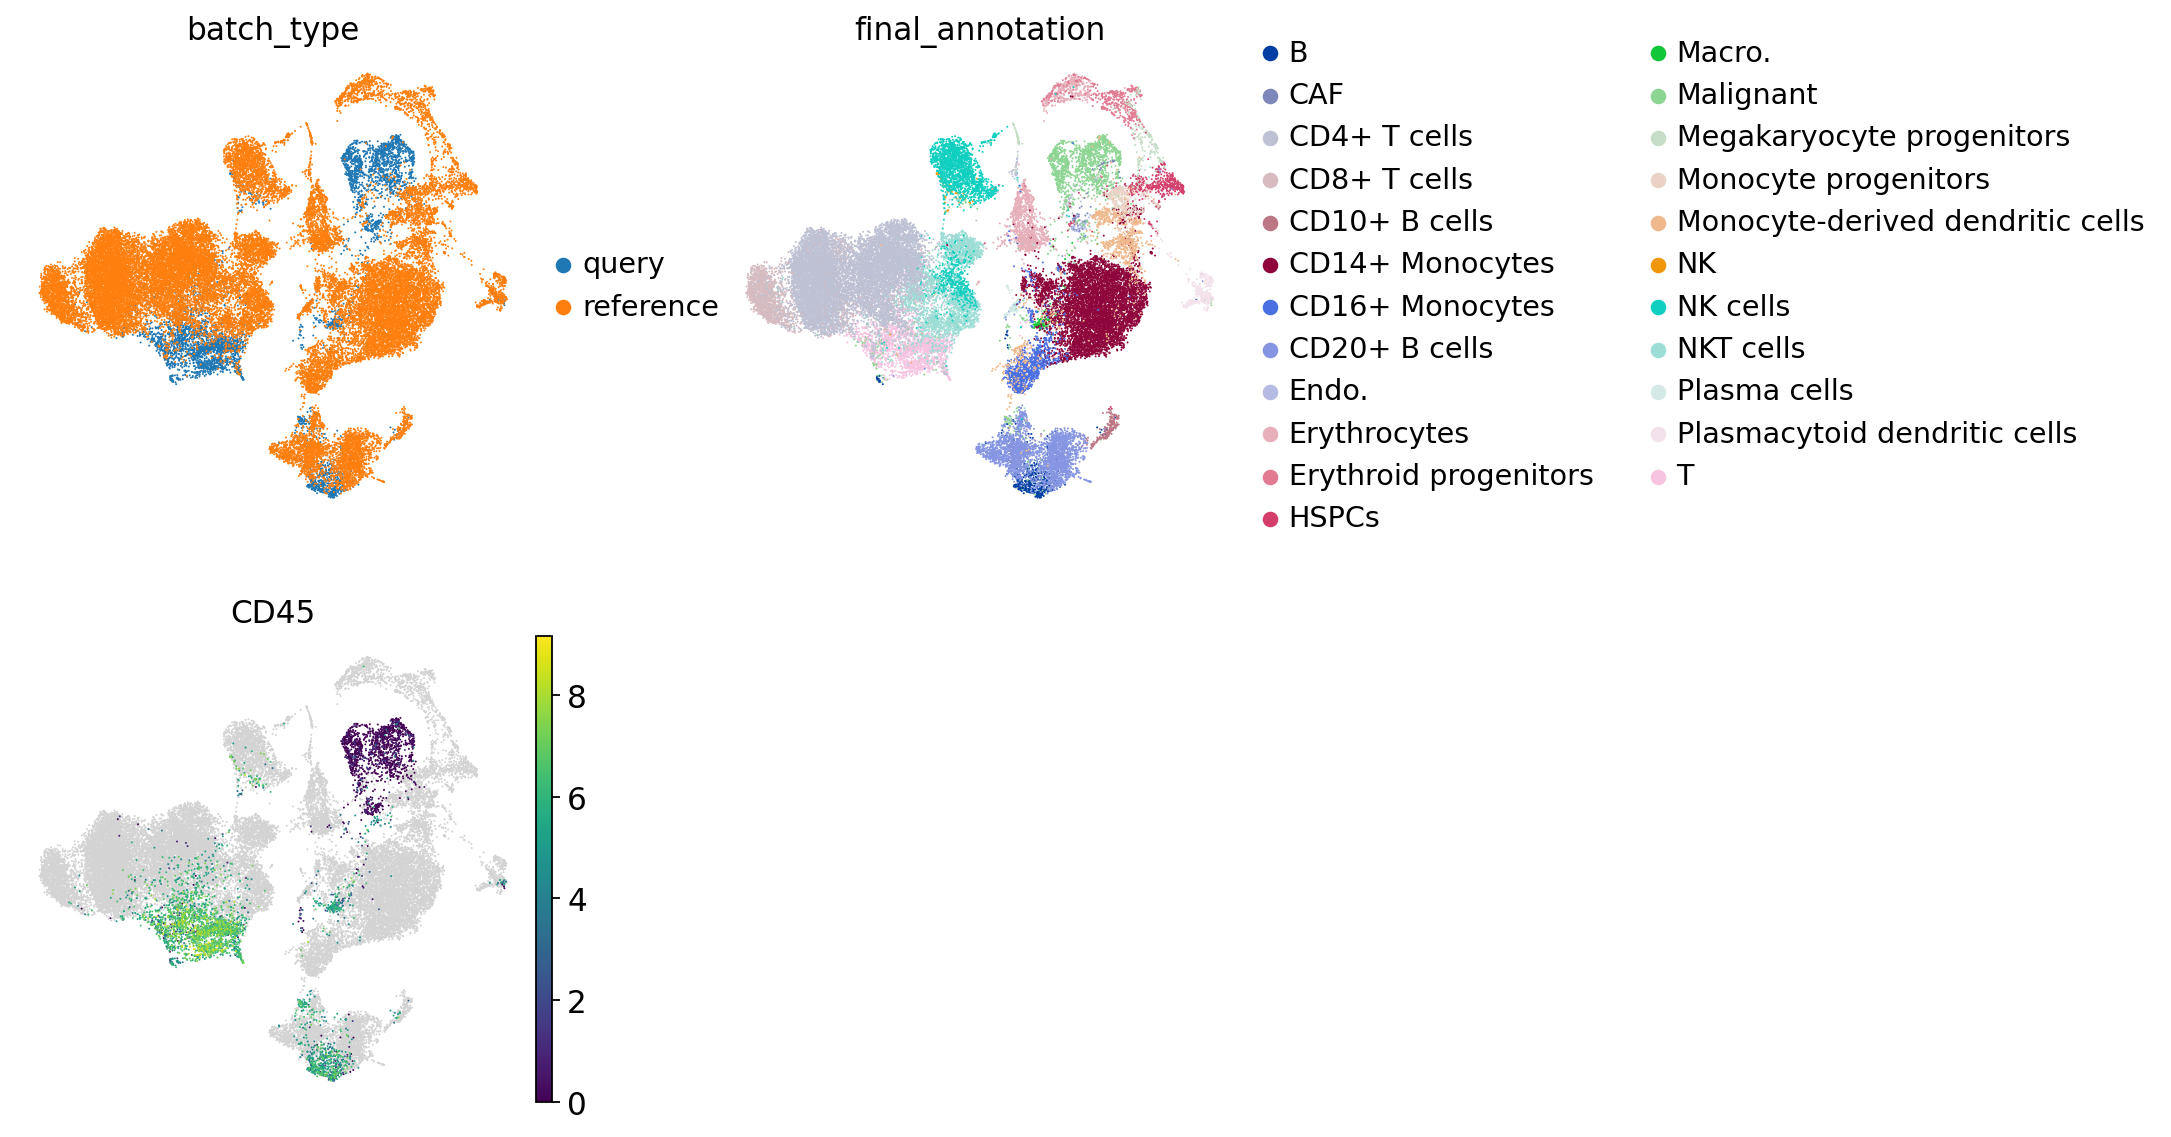

In [68]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch_type", "final_annotation","CD45"],
    wspace= 0.25,
    frameon=False,
    ncols=2,
#     save = 'fig_tirosh_4k_integrated_scvi_cl_newmodel_midlayers.png'
)

/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/otdd/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


<Figure size 320x320 with 0 Axes>

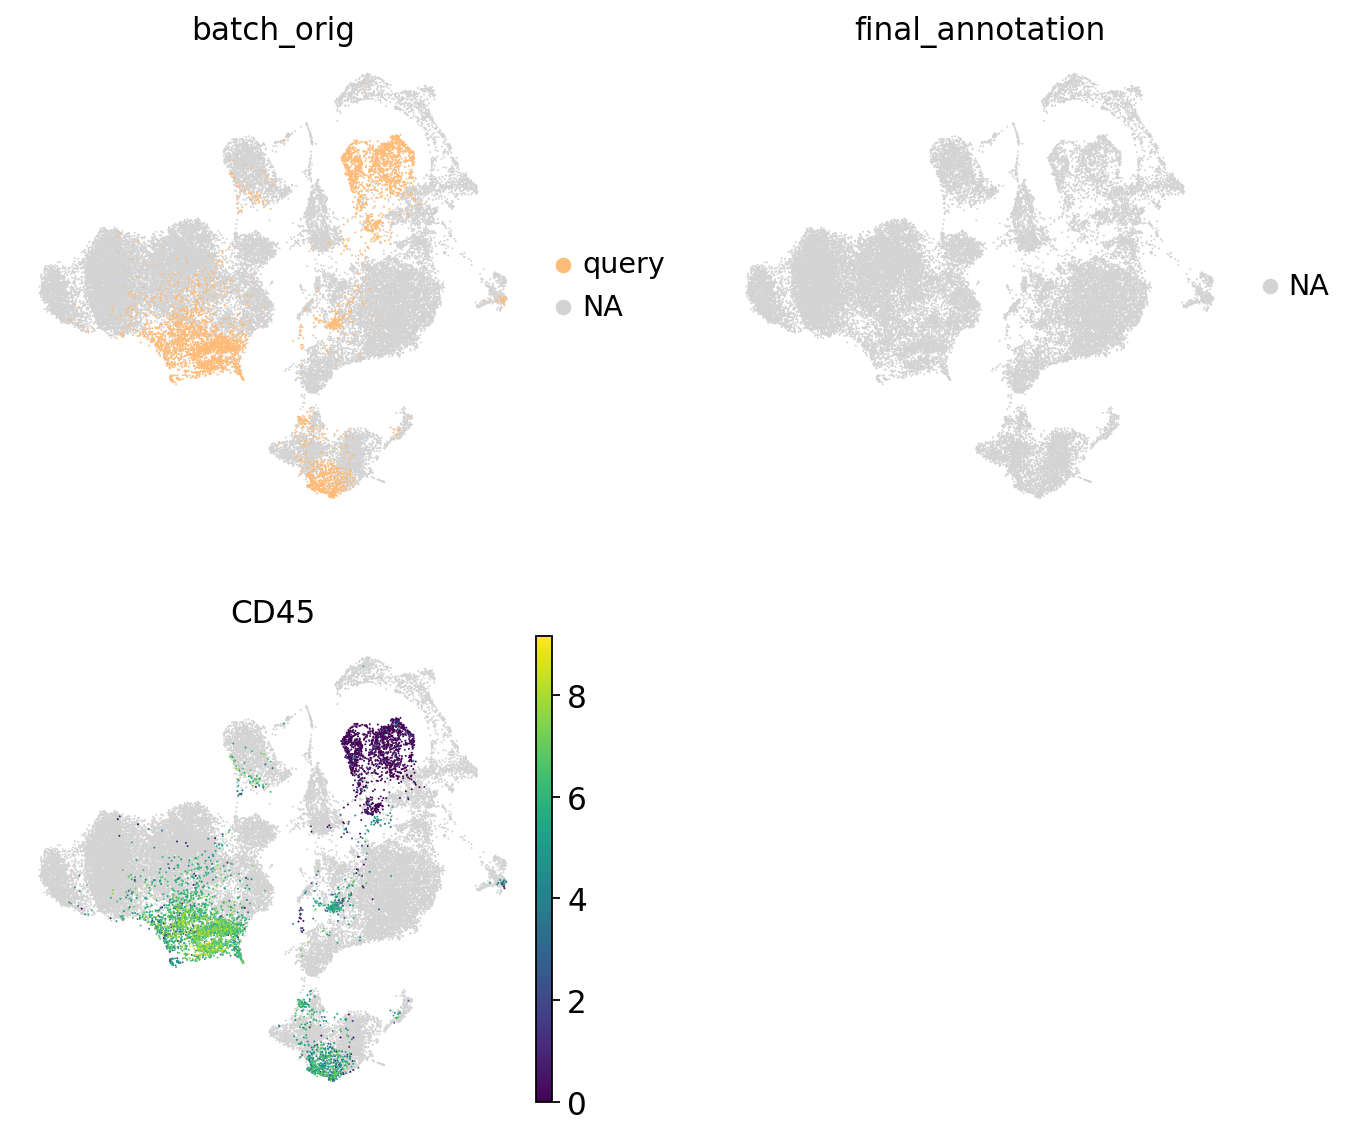

In [69]:
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch_orig", "final_annotation","CD45"],
    groups = ['query'],
    wspace= 0.25,
    frameon=False,
    ncols=2,
#     save = 'fig_tirosh_4k_integrated_scvi_cl_newmodel_midlayers.png'
)

In [70]:
ref_adata = full_latent[full_latent.obs.batch_type == 'reference'].copy()
query_adata = full_latent[full_latent.obs.batch_type == 'query'].copy()

In [71]:
import pynndescent

X_train = ref_adata.X
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

import numba

query_emb = query_adata

ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(
    ref_distances_tilda, axis=1, keepdims=True
)

@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

# get prediction and uncertainty
l = 'final_annotation'
ref_cats = ref_adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(ref_adata.obs[l].cat.categories)[p]
query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u


uncertainty_threshold = 0.3
mask = query_emb.obs[l + "_uncertainty"] > uncertainty_threshold
print(f"{l}: {sum(mask)/len(mask)} unknown")
query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

query_adata.obs = query_emb.obs

final_annotation: 0.39892357373519916 unknown


/tmp/ipykernel_15005/2214044460.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"


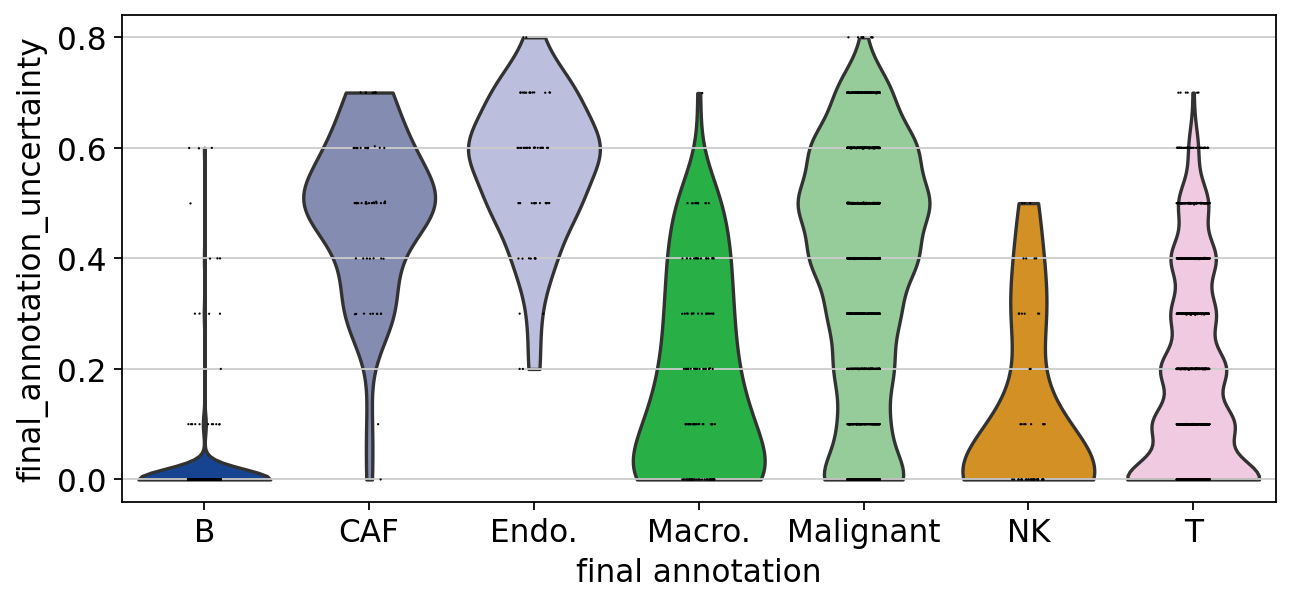

In [72]:
sc.set_figure_params(figsize=(8, 4))
sc.pl.violin(query_adata, ['final_annotation_uncertainty'], groupby='final_annotation',
            save = '_melanoma_clcvae_uncertainty_scores.png')

In [73]:
import pandas as pd
df = pd.crosstab(query_adata.obs.final_annotation, query_adata.obs.final_annotation_pred)

/tmp/ipykernel_15005/1589319703.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(scaler.transform(df.T.to_numpy()))


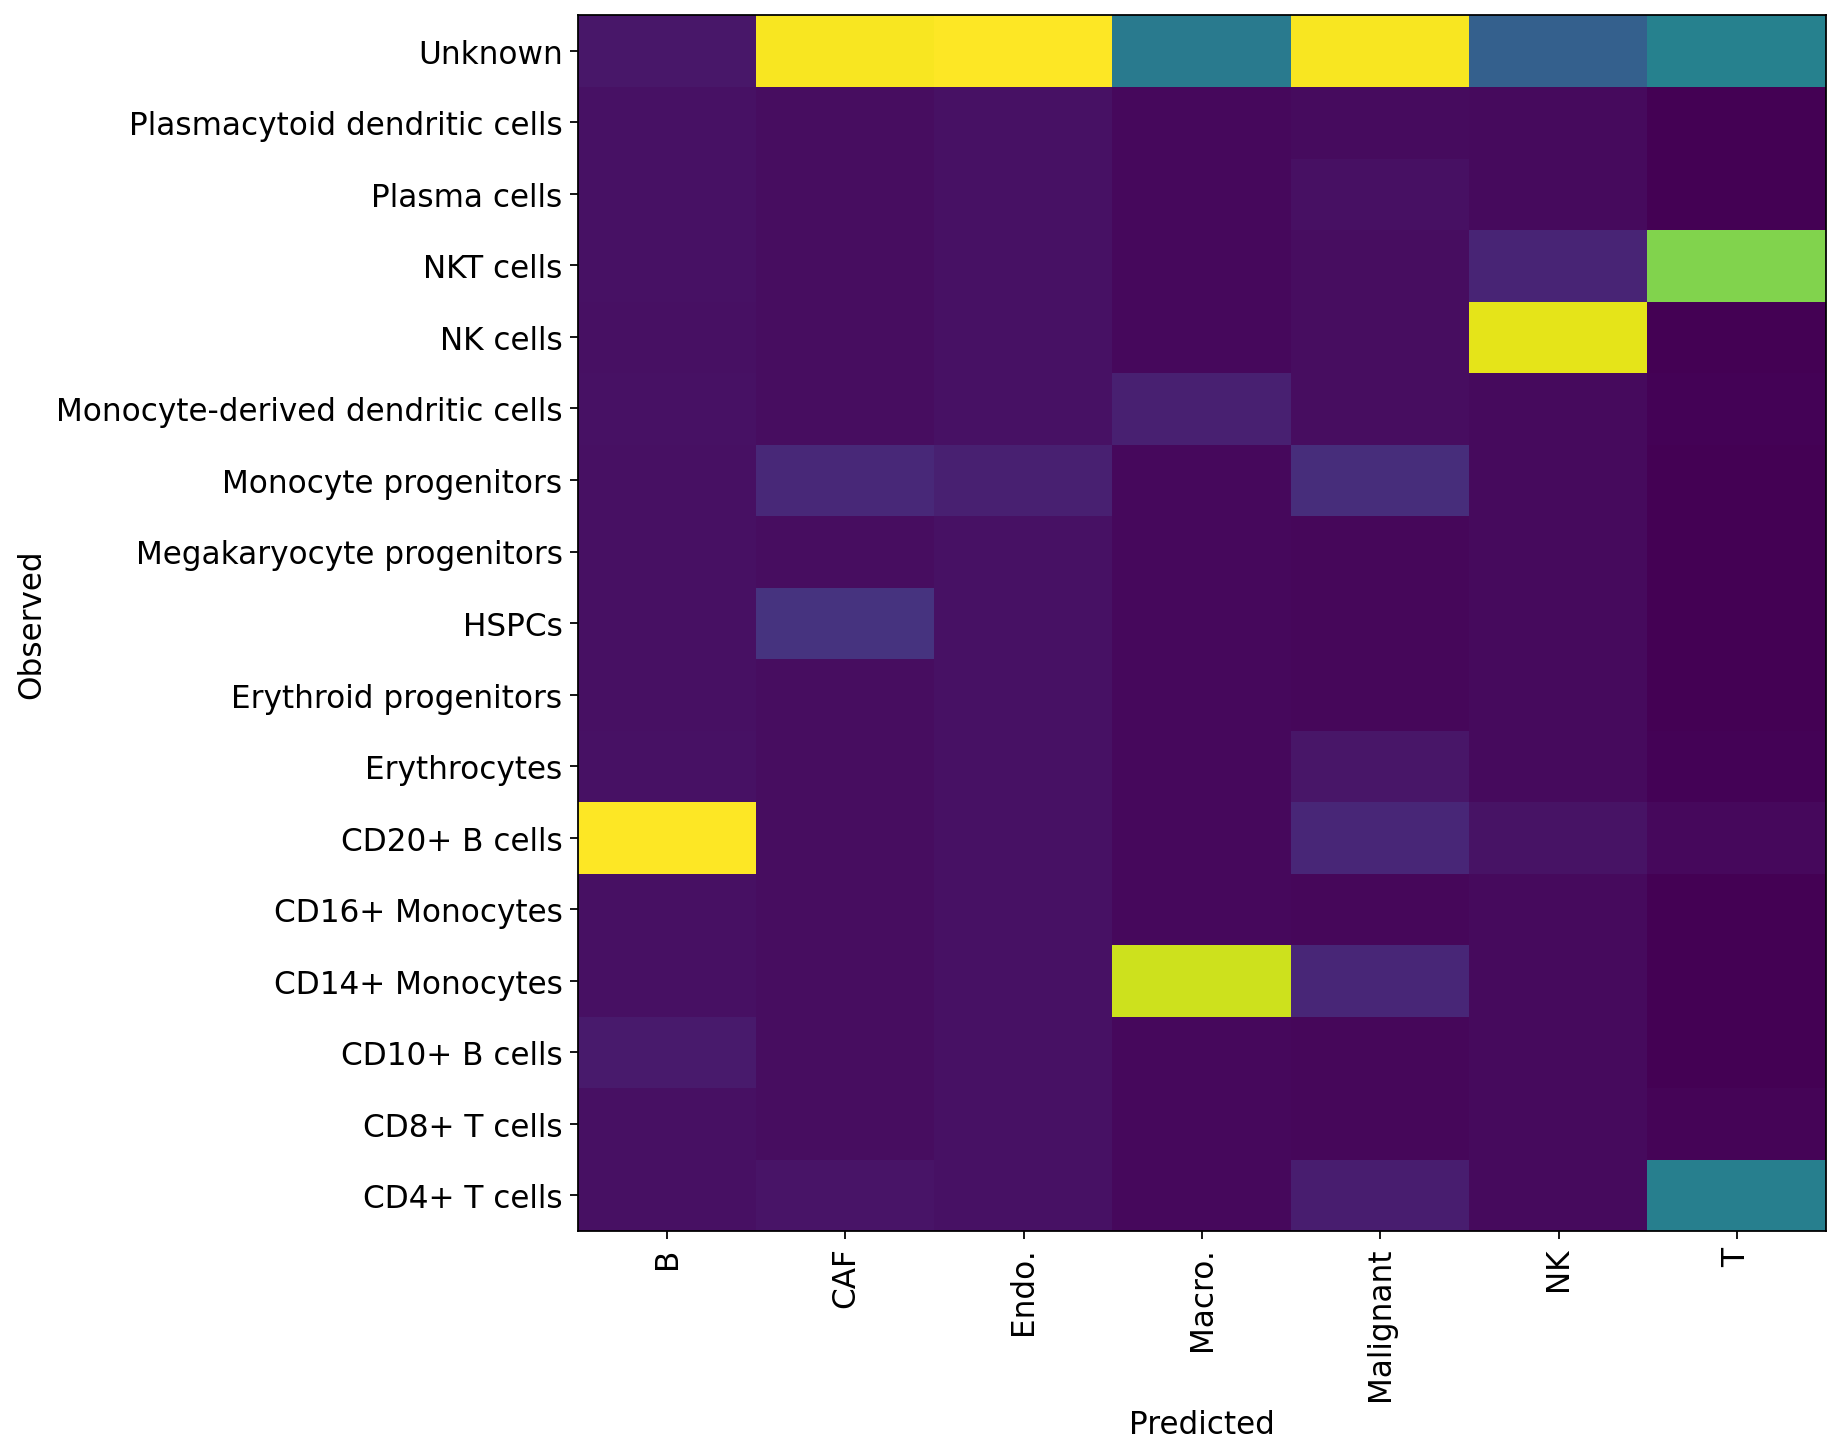

In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.T.to_numpy())

plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10, 10))
_ = plt.pcolor(scaler.transform(df.T.to_numpy()))
_ = plt.xticks(np.arange(0.5, len(df.index), 1), df.index, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.savefig('figures/melanoma_pynn_predictions_heatmap_clcvae.png')

In [ ]:
# full_latent.write('../data/tirosh_2016/tirosh_immune_4k_integrated_latent_cl_weightelosses_newmodel_meanencoderlayer.h5ad')